# Itteratively Find Improved Consensus Labels for Multiannotator Data using Cleanlab

This example shows how to improve consensus labels by combining the CROWDLAB algorithm with itteratively retraining a model. For an introductory tutorial on finding consensus labels with the multiannotator library see [Find Best Consensus Labels for Multiannotator Data using Cleanlab](linke to hui wen's). 

The following code uses the [cifar10h](linke cifar10h) multiannotator labeling dataset which is a collection of 2751 annotators each labeling 200 examples for all 10,000 test images of the original [cifar10](link cifar10) dataset but **any multiannotator classification image dataset should work with the code below**. 

## 1. Install and import required dependencies, build example folder

In [12]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

from utils.model_training import train_model
from utils.model_training import sum_xval_folds
from cleanlab.multiannotator import get_majority_vote_label
from cleanlab.multiannotator import get_label_quality_multiannotator

In [13]:
now = datetime.now() # Current date and time
experiment_path = "./experiment_" + str(int(now.timestamp()))

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

Directory  ./experiment_1661119697  Created 
Experiment saved in ./experiment_1661119697


In [14]:
# Import cifar10 data for model training or download it yourself by calling cifar2png cifar10 ./data/cifar10 --name-with-batch-index
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Import cifar10h pre calculated multiannotator labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_labels_worst25_coin20.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'

File ‘cifar10_test.tar.gz’ already there; not retrieving.

--2022-08-21 18:08:18--  https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_labels_worst25_coin20.npy
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 3.5.11.188
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|3.5.11.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40880128 (39M) [application/x-www-form-urlencoded]
Saving to: ‘c10h_labels_worst25_coin20.npy’

c10h_labels_worst25 100%[===================>]  38.99M  36.3MB/s    in 1.1s    

2022-08-21 18:08:19 (36.3 MB/s) - ‘c10h_labels_worst25_coin20.npy’ saved [40880128/40880128]

--2022-08-21 18:08:19--  https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 3.5.11.188
Connecting to cleanlab-public.s3.am

## 2. Load multiannotator labels and generate consensus labels for them
`multiannotator_labels` for this example is a precalculated subset of the original `cifar10h` annotator labels. The subset takes the worst 25 annotators and the incrementally add annotators from worst to best if they share annotations with those already in the subset until each of the 10,000 examples has at least 1 annotation. 

The reason for this being `cifar10` is an unnaturally easy dataset to label and using the original dataset would make the annotator agreement too high for our method to contribute meaningful improvement. Additionally in practice it is rare to have 50 annotators annotate a specific example but this subset ensures significantly sparser annotations.

In [15]:
# Load labels
multiannotator_labels = np.load(f'{experiment_path}/c10h_labels_worst25_coin20.npy')

# Load and reformat image paths to work for specific machine
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = [f"{path}/{image_path}" for image_path in image_paths]

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

You can easily replace the above with your own multiannotator dataset, and continue with the rest of the example.

`multiannotator_labels` should be a numpy array or pandas DataFrame with each column representing an annotator and each row representing an example. Your classes (and entries of `multiannotator_labels`) should be represented as integer indices 0, 1, ..., num_classes - 1, where examples that are not annotated by a particular annotator are represented using `np.nan`.
    
If working with images, `image_paths` should be a string of absolute or relative paths to the where each index corresponds the example for that row of `multiannotator_labels`.

If working with other data, `image_paths` should be a string of examples corresponding to the row of `multiannotator_labels`.

</div>


Before training our machine learning model, we must first obtain the consensus labels from the annotators that labeled the data. The simplest way to obtain an initial set of consensus labels is to select it using majority vote.

In [16]:
consensus_labels = get_majority_vote_label(multiannotator_labels)

## 3. Train model and use cleanlab to get better consensus labels

Next, we will train our model on the consensus labels obtained using majority vote to compute out-of-sample predicted probabilities. We will then use these `pred_probs` to generate more informed `consensus_labels` using Cleanlab's [CROWDLAB](link to something) algorithm. We them use these `consensus_labels` to train a better model that generates more accurate `pred_probs`. This process itterates until the `consensus_labels` have no more improvement.

`train_model()` trains a `resnet18` image model using cross validation to get out-of-sample predicted probabilities on the whole dataset. The function can be replaced with a custom training algorithm.

In [17]:
model_type = "resnet18" # You can also try with "swin_base_patch4_window7_224"

# Load model arguments
train_args = {
    "num_cv_folds": 5, 
    "verbose": 1, 
    "epochs": 100, 
    "holdout_frac": 0.2, 
    "time_limit": 21600, 
    "random_state": 123
}

In [18]:
# Loop through and retrain model on better consensus labels, save results
indices_changed = set()
seen_consensus_labels = list()
model_results = {}
itter = 0

while tuple(consensus_labels) not in seen_consensus_labels:
    seen_consensus_labels.append(tuple(consensus_labels)) # add curent consensus labels into the set
    model_results['itter'] = itter
    model_xval_results_folder = f'{experiment_path}/xval_results_itter{itter}' # + [model_type]

    # Zip consensus labels with their corresponding image_paths
    consensus_data = pd.DataFrame(zip(image_paths,consensus_labels), columns=["image", "label"])
    
    # Train model
    train_model(model_type, consensus_data, model_xval_results_folder, **train_args)
    pred_probs, labels, images = sum_xval_folds(model_type, model_xval_results_folder, **train_args)
    
    # Get improved consensus labels with label quality multiannotator using model pred probs
    label_quality_multiannotator = get_label_quality_multiannotator(multiannotator_labels, pred_probs, verbose=False)
    consensus_labels = label_quality_multiannotator["label_quality"]["consensus_label"].tolist()
    
    unique_indices = len(indices_changed)
    indices_changed.update(list(np.where(consensus_labels != np.array(seen_consensus_labels[-1]))[0]))
    unique_indices = len(indices_changed) - unique_indices
    label_changes_from_prior = np.sum(consensus_labels != np.array(seen_consensus_labels[-1]))
    
    print("Num changes in consensus labels from previous itter: ", np.sum(consensus_labels != np.array(seen_consensus_labels[-1])))
    print("Num unique indices changed: ", unique_indices)
    # End to delete
    
    results = {
        "pred_probs": pred_probs,
        "consensus_labels_in": labels, # consensus labels used to train the model
        "images": images, 
        "consensus_labels_out": consensus_labels, # new consensus labels generated from pred_probs
        "label_changes_from_prior": label_changes_from_prior, # num changes in consensus labels from previous itterations
        "unique_indices_added": unique_indices, # number of unique labels indices changed
    }
    
    model_results[itter] = results
    itter+=1
    
    if unique_indices == 0: # no more label improvement
        break

modified configs(<old> != <new>): {
root.misc.seed       42 != 266
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/1e68ac71/.trial_0/config.yaml


----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 192.427612 samples/sec	accuracy=0.131250	lr=0.000100
Epoch[0] Batch [99]	Speed: 836.322144 samples/sec	accuracy=0.146875	lr=0.000100
Epoch[0] Batch [149]	Speed: 828.769086 samples/sec	accuracy=0.179583	lr=0.000100
Epoch[0] Batch [199]	Speed: 802.557896 samples/sec	accuracy=0.188125	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.201813 samples/sec	accuracy=0.203000	lr=0.000100
Epoch[0] Batch [299]	Speed: 820.708573 samples/sec	accuracy=0.215625	lr=0.000100
Epoch[0] Batch [349]	Speed: 833.831131 samples/sec	accuracy=0.232321	lr=0.000100
Epoch[0] Batch [399]	Speed: 847.926191 samples/sec	accuracy=0.245938	lr=0.000100
Epoch[0] Batch [449]	Speed: 842.423409 samples/sec	accuracy=0.257778	lr=0.000100
[Epoch 0] training: accuracy=0.257778
[Epoch 0] speed: 602 samples/sec	time

Epoch[8] Batch [149]	Speed: 840.548622 samples/sec	accuracy=0.658333	lr=0.010000
Epoch[8] Batch [199]	Speed: 824.697446 samples/sec	accuracy=0.658125	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.308768 samples/sec	accuracy=0.659500	lr=0.010000
Epoch[8] Batch [299]	Speed: 837.486067 samples/sec	accuracy=0.656250	lr=0.010000
Epoch[8] Batch [349]	Speed: 840.747016 samples/sec	accuracy=0.657500	lr=0.010000
Epoch[8] Batch [399]	Speed: 847.141181 samples/sec	accuracy=0.657500	lr=0.010000
Epoch[8] Batch [449]	Speed: 843.591238 samples/sec	accuracy=0.656250	lr=0.010000
[Epoch 8] training: accuracy=0.656250
[Epoch 8] speed: 799 samples/sec	time cost: 8.985095
[Epoch 8] validation: top1=0.758750 top5=0.967500
Epoch[9] Batch [49]	Speed: 627.919313 samples/sec	accuracy=0.662500	lr=0.010000
Epoch[9] Batch [99]	Speed: 834.921016 samples/sec	accuracy=0.650000	lr=0.010000
Epoch[9] Batch [149]	Speed: 847.735960 samples/sec	accuracy=0.655833	lr=0.010000
Epoch[9] Batch [199]	Speed: 829.728394 samples/sec	

Epoch[17] Batch [249]	Speed: 832.792863 samples/sec	accuracy=0.732750	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.890148 samples/sec	accuracy=0.733542	lr=0.010000
Epoch[17] Batch [349]	Speed: 840.957517 samples/sec	accuracy=0.738036	lr=0.010000
Epoch[17] Batch [399]	Speed: 846.876058 samples/sec	accuracy=0.736563	lr=0.010000
Epoch[17] Batch [449]	Speed: 841.533933 samples/sec	accuracy=0.733611	lr=0.010000
[Epoch 17] training: accuracy=0.733611
[Epoch 17] speed: 801 samples/sec	time cost: 8.965306
[Epoch 17] validation: top1=0.837500 top5=0.980000
[Epoch 17] Current best top-1: 0.837500 vs previous 0.811250, saved to /datasets/ulyana/examples/cifar10-multiannotator/1e68ac71/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 632.588781 samples/sec	accuracy=0.701250	lr=0.010000
Epoch[18] Batch [99]	Speed: 826.019908 samples/sec	accuracy=0.725625	lr=0.010000
Epoch[18] Batch [149]	Speed: 848.769118 samples/sec	accuracy=0.732083	lr=0.010000
Epoch[18] Batch [199]	Speed: 828.301202 samp

Epoch[26] Batch [249]	Speed: 828.372772 samples/sec	accuracy=0.762250	lr=0.010000
Epoch[26] Batch [299]	Speed: 827.168566 samples/sec	accuracy=0.764167	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.546188 samples/sec	accuracy=0.761786	lr=0.010000
Epoch[26] Batch [399]	Speed: 846.390928 samples/sec	accuracy=0.762188	lr=0.010000
Epoch[26] Batch [449]	Speed: 842.208790 samples/sec	accuracy=0.764861	lr=0.010000
[Epoch 26] training: accuracy=0.764861
[Epoch 26] speed: 792 samples/sec	time cost: 9.067484
[Epoch 26] validation: top1=0.843750 top5=0.968750
[Epoch 26] Current best top-1: 0.843750 vs previous 0.838750, saved to /datasets/ulyana/examples/cifar10-multiannotator/1e68ac71/.trial_0/best_checkpoint.pkl
Epoch[27] Batch [49]	Speed: 629.454623 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[27] Batch [99]	Speed: 827.209553 samples/sec	accuracy=0.784375	lr=0.010000
Epoch[27] Batch [149]	Speed: 838.496683 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[27] Batch [199]	Speed: 823.730518 samp

Epoch[35] Batch [149]	Speed: 844.968018 samples/sec	accuracy=0.839167	lr=0.001000
Epoch[35] Batch [199]	Speed: 823.801705 samples/sec	accuracy=0.840313	lr=0.001000
Epoch[35] Batch [249]	Speed: 831.359238 samples/sec	accuracy=0.843750	lr=0.001000
Epoch[35] Batch [299]	Speed: 831.107811 samples/sec	accuracy=0.842708	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.510496 samples/sec	accuracy=0.840714	lr=0.001000
Epoch[35] Batch [399]	Speed: 845.710846 samples/sec	accuracy=0.842812	lr=0.001000
Epoch[35] Batch [449]	Speed: 841.882316 samples/sec	accuracy=0.843472	lr=0.001000
[Epoch 35] training: accuracy=0.843472
[Epoch 35] speed: 799 samples/sec	time cost: 8.986629
[Epoch 35] validation: top1=0.860000 top5=0.980000
Epoch[36] Batch [49]	Speed: 624.630381 samples/sec	accuracy=0.863750	lr=0.001000
Epoch[36] Batch [99]	Speed: 828.592059 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[36] Batch [149]	Speed: 840.652230 samples/sec	accuracy=0.854583	lr=0.001000
Epoch[36] Batch [199]	Speed: 819.98996

Epoch[44] Batch [249]	Speed: 833.929359 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[44] Batch [299]	Speed: 830.557098 samples/sec	accuracy=0.868333	lr=0.001000
Epoch[44] Batch [349]	Speed: 837.201258 samples/sec	accuracy=0.866786	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.651044 samples/sec	accuracy=0.868906	lr=0.001000
Epoch[44] Batch [449]	Speed: 840.764922 samples/sec	accuracy=0.866806	lr=0.001000
[Epoch 44] training: accuracy=0.866806
[Epoch 44] speed: 798 samples/sec	time cost: 8.997730
[Epoch 44] validation: top1=0.862500 top5=0.975000
Epoch[45] Batch [49]	Speed: 626.624260 samples/sec	accuracy=0.855000	lr=0.001000
Epoch[45] Batch [99]	Speed: 828.647308 samples/sec	accuracy=0.859375	lr=0.001000
Epoch[45] Batch [149]	Speed: 841.573824 samples/sec	accuracy=0.861667	lr=0.001000
Epoch[45] Batch [199]	Speed: 818.920895 samples/sec	accuracy=0.858750	lr=0.001000
Epoch[45] Batch [249]	Speed: 828.076348 samples/sec	accuracy=0.861750	lr=0.001000
Epoch[45] Batch [299]	Speed: 824.47454

Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 338
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/1e4970f1/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 186.977696 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 854.360175 samples/sec	accuracy=0.165625	lr=0.000100
Epoch[0] Batch [149]	Speed: 836.334860 samples/sec	accuracy=0.180417	lr=0.000100
Epoch[0] Batch [199]	Speed: 828.669000 samples/sec	accuracy=0.196250	lr=0.000100
Epoch[0] Batch [249]	Speed: 827.673142 samples/sec	acc

[Epoch 7] Current best top-1: 0.781250 vs previous 0.776250, saved to /datasets/ulyana/examples/cifar10-multiannotator/1e4970f1/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 625.851353 samples/sec	accuracy=0.670000	lr=0.010000
Epoch[8] Batch [99]	Speed: 813.780295 samples/sec	accuracy=0.638125	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.754488 samples/sec	accuracy=0.637917	lr=0.010000
Epoch[8] Batch [199]	Speed: 814.777406 samples/sec	accuracy=0.644687	lr=0.010000
Epoch[8] Batch [249]	Speed: 820.331160 samples/sec	accuracy=0.646500	lr=0.010000
Epoch[8] Batch [299]	Speed: 829.762044 samples/sec	accuracy=0.642708	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.466156 samples/sec	accuracy=0.645714	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.993014 samples/sec	accuracy=0.648750	lr=0.010000
Epoch[8] Batch [449]	Speed: 843.129353 samples/sec	accuracy=0.650000	lr=0.010000
[Epoch 8] training: accuracy=0.650000
[Epoch 8] speed: 793 samples/sec	time cost: 9.053615
[Epoch 8] validation: top

Epoch[16] Batch [399]	Speed: 842.374132 samples/sec	accuracy=0.725000	lr=0.010000
Epoch[16] Batch [449]	Speed: 842.563445 samples/sec	accuracy=0.723472	lr=0.010000
[Epoch 16] training: accuracy=0.723472
[Epoch 16] speed: 794 samples/sec	time cost: 9.048129
[Epoch 16] validation: top1=0.820000 top5=0.986250
Epoch[17] Batch [49]	Speed: 633.518102 samples/sec	accuracy=0.735000	lr=0.010000
Epoch[17] Batch [99]	Speed: 817.622045 samples/sec	accuracy=0.731875	lr=0.010000
Epoch[17] Batch [149]	Speed: 834.363580 samples/sec	accuracy=0.730417	lr=0.010000
Epoch[17] Batch [199]	Speed: 827.874696 samples/sec	accuracy=0.727187	lr=0.010000
Epoch[17] Batch [249]	Speed: 825.160861 samples/sec	accuracy=0.727500	lr=0.010000
Epoch[17] Batch [299]	Speed: 830.696301 samples/sec	accuracy=0.722292	lr=0.010000
Epoch[17] Batch [349]	Speed: 832.226498 samples/sec	accuracy=0.724643	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.378524 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[17] Batch [449]	Speed: 841.61772

Epoch[25] Batch [399]	Speed: 838.152561 samples/sec	accuracy=0.767031	lr=0.010000
Epoch[25] Batch [449]	Speed: 838.520780 samples/sec	accuracy=0.765833	lr=0.010000
[Epoch 25] training: accuracy=0.765833
[Epoch 25] speed: 793 samples/sec	time cost: 9.061247
[Epoch 25] validation: top1=0.846250 top5=0.987500
[Epoch 25] Current best top-1: 0.846250 vs previous 0.826250, saved to /datasets/ulyana/examples/cifar10-multiannotator/1e4970f1/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 619.886510 samples/sec	accuracy=0.781250	lr=0.010000
Epoch[26] Batch [99]	Speed: 821.817336 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[26] Batch [149]	Speed: 834.504686 samples/sec	accuracy=0.773333	lr=0.010000
Epoch[26] Batch [199]	Speed: 820.744105 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[26] Batch [249]	Speed: 818.454279 samples/sec	accuracy=0.772000	lr=0.010000
Epoch[26] Batch [299]	Speed: 823.556849 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[26] Batch [349]	Speed: 834.864097 samp

[Epoch 34] training: accuracy=0.846806
[Epoch 34] speed: 791 samples/sec	time cost: 9.077010
[Epoch 34] validation: top1=0.835000 top5=0.978750
Epoch[35] Batch [49]	Speed: 622.984170 samples/sec	accuracy=0.852500	lr=0.001000
Epoch[35] Batch [99]	Speed: 830.259519 samples/sec	accuracy=0.848125	lr=0.001000
Epoch[35] Batch [149]	Speed: 836.774303 samples/sec	accuracy=0.845417	lr=0.001000
Epoch[35] Batch [199]	Speed: 818.983657 samples/sec	accuracy=0.844375	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.087341 samples/sec	accuracy=0.843500	lr=0.001000
Epoch[35] Batch [299]	Speed: 825.356726 samples/sec	accuracy=0.844375	lr=0.001000
Epoch[35] Batch [349]	Speed: 837.924419 samples/sec	accuracy=0.844821	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.097003 samples/sec	accuracy=0.846719	lr=0.001000
Epoch[35] Batch [449]	Speed: 839.610782 samples/sec	accuracy=0.846528	lr=0.001000
[Epoch 35] training: accuracy=0.846528
[Epoch 35] speed: 795 samples/sec	time cost: 9.033860
[Epoch 35] validation: top1

Epoch[44] Batch [49]	Speed: 625.008862 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[44] Batch [99]	Speed: 819.634030 samples/sec	accuracy=0.874375	lr=0.001000
Epoch[44] Batch [149]	Speed: 826.068713 samples/sec	accuracy=0.867917	lr=0.001000
Epoch[44] Batch [199]	Speed: 822.901853 samples/sec	accuracy=0.866563	lr=0.001000
Epoch[44] Batch [249]	Speed: 819.290010 samples/sec	accuracy=0.863250	lr=0.001000
Epoch[44] Batch [299]	Speed: 817.187954 samples/sec	accuracy=0.859583	lr=0.001000
Epoch[44] Batch [349]	Speed: 832.276866 samples/sec	accuracy=0.862500	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.987011 samples/sec	accuracy=0.861406	lr=0.001000
Epoch[44] Batch [449]	Speed: 840.076811 samples/sec	accuracy=0.862083	lr=0.001000
[Epoch 44] training: accuracy=0.862083
[Epoch 44] speed: 791 samples/sec	time cost: 9.074159
[Epoch 44] validation: top1=0.847500 top5=0.977500
Epoch[45] Batch [49]	Speed: 620.344807 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[45] Batch [99]	Speed: 824.694811 

Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 623
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/f5965972/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.224664 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.235542 samples/sec	accuracy=0.136250	lr=0.000100
Epoch[0] Batch [149]	Speed: 832.322904 samples/sec	accuracy=0.161250	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.937765 samples/sec	accuracy=0.178125	lr=0.000100
Epoch[0] Batch [249]	Speed: 824.582738 samples/sec	acc

Epoch[8] Batch [149]	Speed: 836.201679 samples/sec	accuracy=0.655417	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.597981 samples/sec	accuracy=0.649687	lr=0.010000
Epoch[8] Batch [249]	Speed: 819.685888 samples/sec	accuracy=0.644500	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.964914 samples/sec	accuracy=0.644792	lr=0.010000
Epoch[8] Batch [349]	Speed: 828.545819 samples/sec	accuracy=0.642321	lr=0.010000
Epoch[8] Batch [399]	Speed: 843.937718 samples/sec	accuracy=0.645625	lr=0.010000
Epoch[8] Batch [449]	Speed: 838.660151 samples/sec	accuracy=0.649028	lr=0.010000
[Epoch 8] training: accuracy=0.649028
[Epoch 8] speed: 793 samples/sec	time cost: 9.052612
[Epoch 8] validation: top1=0.786250 top5=0.986250
Epoch[9] Batch [49]	Speed: 621.114167 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[9] Batch [99]	Speed: 821.879536 samples/sec	accuracy=0.708125	lr=0.010000
Epoch[9] Batch [149]	Speed: 828.968921 samples/sec	accuracy=0.697083	lr=0.010000
Epoch[9] Batch [199]	Speed: 817.105171 samples/sec	

[Epoch 16] Current best top-1: 0.837500 vs previous 0.821250, saved to /datasets/ulyana/examples/cifar10-multiannotator/f5965972/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 623.215934 samples/sec	accuracy=0.733750	lr=0.010000
Epoch[17] Batch [99]	Speed: 828.007281 samples/sec	accuracy=0.731875	lr=0.010000
Epoch[17] Batch [149]	Speed: 851.088387 samples/sec	accuracy=0.729167	lr=0.010000
Epoch[17] Batch [199]	Speed: 828.449468 samples/sec	accuracy=0.739062	lr=0.010000
Epoch[17] Batch [249]	Speed: 833.627288 samples/sec	accuracy=0.737000	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.165698 samples/sec	accuracy=0.736458	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.163822 samples/sec	accuracy=0.734464	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.873431 samples/sec	accuracy=0.729531	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.170970 samples/sec	accuracy=0.730278	lr=0.010000
[Epoch 17] training: accuracy=0.730278
[Epoch 17] speed: 796 samples/sec	time cost: 9.018671
[Epoch 17] va

Epoch[26] Batch [149]	Speed: 835.579479 samples/sec	accuracy=0.781667	lr=0.010000
Epoch[26] Batch [199]	Speed: 815.301244 samples/sec	accuracy=0.780312	lr=0.010000
Epoch[26] Batch [249]	Speed: 825.443220 samples/sec	accuracy=0.778500	lr=0.010000
Epoch[26] Batch [299]	Speed: 815.188144 samples/sec	accuracy=0.775625	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.347415 samples/sec	accuracy=0.775000	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.464924 samples/sec	accuracy=0.772969	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.934804 samples/sec	accuracy=0.775556	lr=0.010000
[Epoch 26] training: accuracy=0.775556
[Epoch 26] speed: 793 samples/sec	time cost: 9.057320
[Epoch 26] validation: top1=0.818750 top5=0.978750
[Epoch 27] EarlyStop after 10 epochs: no better than 0.8375
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 566
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/1716e2b6/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.117183 samples/sec	accuracy=0.118750	lr=0.000100
Epoch[0] Batch [99]	Speed: 842.071408 samples/sec	accuracy=0.144375	lr=0.000100
Epoch[0] Batch [149]	Speed: 836.935221 samples/sec	accuracy=0.166250	lr=0.000100
Epoch[0] Batch [199]	Speed: 832.047166 samples/sec	accuracy=0.190000	lr=0.000100
Epoch[0] Batch [249]	Speed: 831.070141 samples/sec	acc

Epoch[8] Batch [49]	Speed: 631.308621 samples/sec	accuracy=0.668750	lr=0.010000
Epoch[8] Batch [99]	Speed: 826.204992 samples/sec	accuracy=0.655000	lr=0.010000
Epoch[8] Batch [149]	Speed: 846.013420 samples/sec	accuracy=0.652917	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.677618 samples/sec	accuracy=0.655625	lr=0.010000
Epoch[8] Batch [249]	Speed: 833.193625 samples/sec	accuracy=0.659500	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.270910 samples/sec	accuracy=0.661042	lr=0.010000
Epoch[8] Batch [349]	Speed: 833.593117 samples/sec	accuracy=0.658393	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.556675 samples/sec	accuracy=0.659844	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.995347 samples/sec	accuracy=0.661806	lr=0.010000
[Epoch 8] training: accuracy=0.661806
[Epoch 8] speed: 798 samples/sec	time cost: 8.994394
[Epoch 8] validation: top1=0.730000 top5=0.986250
Epoch[9] Batch [49]	Speed: 626.241717 samples/sec	accuracy=0.687500	lr=0.010000
Epoch[9] Batch [99]	Speed: 828.235164 samples/sec	ac

[Epoch 16] training: accuracy=0.727639
[Epoch 16] speed: 793 samples/sec	time cost: 9.059198
[Epoch 16] validation: top1=0.756250 top5=0.977500
Epoch[17] Batch [49]	Speed: 621.504052 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[17] Batch [99]	Speed: 824.977663 samples/sec	accuracy=0.716875	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.879994 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[17] Batch [199]	Speed: 816.724106 samples/sec	accuracy=0.726250	lr=0.010000
Epoch[17] Batch [249]	Speed: 830.360606 samples/sec	accuracy=0.730250	lr=0.010000
Epoch[17] Batch [299]	Speed: 826.856294 samples/sec	accuracy=0.726667	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.879460 samples/sec	accuracy=0.725714	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.901882 samples/sec	accuracy=0.726094	lr=0.010000
Epoch[17] Batch [449]	Speed: 836.236689 samples/sec	accuracy=0.725000	lr=0.010000
[Epoch 17] training: accuracy=0.725000
[Epoch 17] speed: 794 samples/sec	time cost: 9.044575
[Epoch 17] validation: top1

[Epoch 25] training: accuracy=0.770972
[Epoch 25] speed: 798 samples/sec	time cost: 9.001041
[Epoch 25] validation: top1=0.795000 top5=0.975000
Epoch[26] Batch [49]	Speed: 628.528699 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[26] Batch [99]	Speed: 830.760059 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[26] Batch [149]	Speed: 838.484740 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[26] Batch [199]	Speed: 826.986310 samples/sec	accuracy=0.760625	lr=0.010000
Epoch[26] Batch [249]	Speed: 826.025601 samples/sec	accuracy=0.764000	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.438269 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[26] Batch [349]	Speed: 838.383131 samples/sec	accuracy=0.759821	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.567909 samples/sec	accuracy=0.757188	lr=0.010000
Epoch[26] Batch [449]	Speed: 837.332877 samples/sec	accuracy=0.758194	lr=0.010000
[Epoch 26] training: accuracy=0.758194
[Epoch 26] speed: 796 samples/sec	time cost: 9.023887
[Epoch 26] validation: top1

Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 116
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/bda61dc3/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.832200 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.159018 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [149]	Speed: 834.358186 samples/sec	accuracy=0.148750	lr=0.000100
Epoch[0] Batch [199]	Speed: 827.676000 samples/sec	accuracy=0.170625	lr=0.000100
Epoch[0] Batch [249]	Speed: 830.814569 samples/sec	acc

[Epoch 7] Current best top-1: 0.793750 vs previous 0.760000, saved to /datasets/ulyana/examples/cifar10-multiannotator/bda61dc3/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 624.050462 samples/sec	accuracy=0.675000	lr=0.010000
Epoch[8] Batch [99]	Speed: 825.130423 samples/sec	accuracy=0.657500	lr=0.010000
Epoch[8] Batch [149]	Speed: 830.065221 samples/sec	accuracy=0.662917	lr=0.010000
Epoch[8] Batch [199]	Speed: 823.411137 samples/sec	accuracy=0.662500	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.091879 samples/sec	accuracy=0.665750	lr=0.010000
Epoch[8] Batch [299]	Speed: 829.260247 samples/sec	accuracy=0.662083	lr=0.010000
Epoch[8] Batch [349]	Speed: 824.853144 samples/sec	accuracy=0.661607	lr=0.010000
Epoch[8] Batch [399]	Speed: 838.252019 samples/sec	accuracy=0.656563	lr=0.010000
Epoch[8] Batch [449]	Speed: 831.121603 samples/sec	accuracy=0.656667	lr=0.010000
[Epoch 8] training: accuracy=0.656667
[Epoch 8] speed: 793 samples/sec	time cost: 9.061188
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.727917
[Epoch 16] speed: 794 samples/sec	time cost: 9.045672
[Epoch 16] validation: top1=0.812500 top5=0.987500
Epoch[17] Batch [49]	Speed: 619.089573 samples/sec	accuracy=0.722500	lr=0.010000
Epoch[17] Batch [99]	Speed: 820.395342 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[17] Batch [149]	Speed: 832.489549 samples/sec	accuracy=0.734583	lr=0.010000
Epoch[17] Batch [199]	Speed: 815.958676 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[17] Batch [249]	Speed: 830.450002 samples/sec	accuracy=0.732500	lr=0.010000
Epoch[17] Batch [299]	Speed: 816.514433 samples/sec	accuracy=0.730208	lr=0.010000
Epoch[17] Batch [349]	Speed: 834.493063 samples/sec	accuracy=0.728571	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.791071 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[17] Batch [449]	Speed: 836.401779 samples/sec	accuracy=0.730972	lr=0.010000
[Epoch 17] training: accuracy=0.730972
[Epoch 17] speed: 792 samples/sec	time cost: 9.071297
[Epoch 17] validation: top1

Epoch[25] Batch [399]	Speed: 844.189111 samples/sec	accuracy=0.774219	lr=0.010000
Epoch[25] Batch [449]	Speed: 836.492272 samples/sec	accuracy=0.772778	lr=0.010000
[Epoch 25] training: accuracy=0.772778
[Epoch 25] speed: 799 samples/sec	time cost: 8.988846
[Epoch 25] validation: top1=0.837500 top5=0.983750
Epoch[26] Batch [49]	Speed: 616.780954 samples/sec	accuracy=0.796250	lr=0.010000
Epoch[26] Batch [99]	Speed: 827.219750 samples/sec	accuracy=0.788750	lr=0.010000
Epoch[26] Batch [149]	Speed: 830.383005 samples/sec	accuracy=0.782083	lr=0.010000
Epoch[26] Batch [199]	Speed: 815.304413 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[26] Batch [249]	Speed: 822.259182 samples/sec	accuracy=0.777250	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.536377 samples/sec	accuracy=0.776458	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.093718 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.331416 samples/sec	accuracy=0.778594	lr=0.010000
Epoch[26] Batch [449]	Speed: 835.25167

Epoch[34] Batch [199]	Speed: 822.489960 samples/sec	accuracy=0.837500	lr=0.001000
Epoch[34] Batch [249]	Speed: 821.163093 samples/sec	accuracy=0.839500	lr=0.001000
Epoch[34] Batch [299]	Speed: 816.637441 samples/sec	accuracy=0.841667	lr=0.001000
Epoch[34] Batch [349]	Speed: 823.056470 samples/sec	accuracy=0.846964	lr=0.001000
Epoch[34] Batch [399]	Speed: 820.228289 samples/sec	accuracy=0.845625	lr=0.001000
Epoch[34] Batch [449]	Speed: 821.423418 samples/sec	accuracy=0.845972	lr=0.001000
[Epoch 34] training: accuracy=0.845972
[Epoch 34] speed: 787 samples/sec	time cost: 9.124080
[Epoch 34] validation: top1=0.872500 top5=0.983750
[Epoch 34] Current best top-1: 0.872500 vs previous 0.863750, saved to /datasets/ulyana/examples/cifar10-multiannotator/bda61dc3/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 615.370418 samples/sec	accuracy=0.852500	lr=0.001000
Epoch[35] Batch [99]	Speed: 825.343124 samples/sec	accuracy=0.841875	lr=0.001000
Epoch[35] Batch [149]	Speed: 830.964559 samp

Epoch[43] Batch [299]	Speed: 818.286819 samples/sec	accuracy=0.862500	lr=0.001000
Epoch[43] Batch [349]	Speed: 830.494399 samples/sec	accuracy=0.858214	lr=0.001000
Epoch[43] Batch [399]	Speed: 842.611898 samples/sec	accuracy=0.859219	lr=0.001000
Epoch[43] Batch [449]	Speed: 837.178072 samples/sec	accuracy=0.861528	lr=0.001000
[Epoch 43] training: accuracy=0.861528
[Epoch 43] speed: 792 samples/sec	time cost: 9.071854
[Epoch 43] validation: top1=0.866250 top5=0.988750
Epoch[44] Batch [49]	Speed: 621.161884 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[44] Batch [99]	Speed: 819.233001 samples/sec	accuracy=0.863750	lr=0.001000
Epoch[44] Batch [149]	Speed: 844.112021 samples/sec	accuracy=0.871667	lr=0.001000
Epoch[44] Batch [199]	Speed: 827.770741 samples/sec	accuracy=0.875938	lr=0.001000
Epoch[44] Batch [249]	Speed: 830.483711 samples/sec	accuracy=0.876750	lr=0.001000
Epoch[44] Batch [299]	Speed: 820.251348 samples/sec	accuracy=0.876458	lr=0.001000
Epoch[44] Batch [349]	Speed: 837.96438

Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter0_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter0_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 341
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/fd4d6f86/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  481
Num unique indices changed:  481
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.378762 samples/sec	accuracy=0.110000	lr=0.000100
Epoch[0] Batch [99]	Speed: 842.808303 samples/sec	accuracy=0.126875	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.079815 samples/sec	accuracy=0.155417	lr=0.000100
Epoch[0] Batch [199]	Speed: 810.842933 samples/sec	accuracy=0.170937	lr=0.000100
Epoch[0] Batch [249]	Speed: 818.762634 samples/sec	accuracy=0.194250	lr=0.000100
Epoch[0] Batch [299]	Speed: 833.960448 samples/sec	accuracy=0.216042	lr=0.000100
Epoch[0] Batch [349]	Speed: 847.075741 samples/sec	accuracy=0.230536	lr=0.000100
Epoch[0] Batch [399]	Speed: 851.937184 samples/sec	accuracy=0.248906	lr=0.000100
Epoch[0] Batch [449]	Speed: 847.870698 samples/sec	accuracy=0.263333	lr=0.000100
[Epoch 0] training: accuracy=0.263333
[Epoch 0] speed: 599 samples/sec	time

Epoch[8] Batch [249]	Speed: 827.061323 samples/sec	accuracy=0.694500	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.675720 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [349]	Speed: 849.199163 samples/sec	accuracy=0.687679	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.379028 samples/sec	accuracy=0.688438	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.621374 samples/sec	accuracy=0.691389	lr=0.010000
[Epoch 8] training: accuracy=0.691389
[Epoch 8] speed: 795 samples/sec	time cost: 9.037085
[Epoch 8] validation: top1=0.835000 top5=0.991250
Epoch[9] Batch [49]	Speed: 622.418616 samples/sec	accuracy=0.686250	lr=0.010000
Epoch[9] Batch [99]	Speed: 824.369821 samples/sec	accuracy=0.701875	lr=0.010000
Epoch[9] Batch [149]	Speed: 840.649913 samples/sec	accuracy=0.709167	lr=0.010000
Epoch[9] Batch [199]	Speed: 814.721815 samples/sec	accuracy=0.717500	lr=0.010000
Epoch[9] Batch [249]	Speed: 826.661753 samples/sec	accuracy=0.713250	lr=0.010000
Epoch[9] Batch [299]	Speed: 826.113863 samples/sec	

Epoch[17] Batch [249]	Speed: 822.605095 samples/sec	accuracy=0.767000	lr=0.010000
Epoch[17] Batch [299]	Speed: 813.540767 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.246581 samples/sec	accuracy=0.766786	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.242615 samples/sec	accuracy=0.769062	lr=0.010000
Epoch[17] Batch [449]	Speed: 830.275954 samples/sec	accuracy=0.771111	lr=0.010000
[Epoch 17] training: accuracy=0.771111
[Epoch 17] speed: 789 samples/sec	time cost: 9.100691
[Epoch 17] validation: top1=0.881250 top5=0.987500
[Epoch 17] Current best top-1: 0.881250 vs previous 0.867500, saved to /datasets/ulyana/examples/cifar10-multiannotator/fd4d6f86/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 622.367820 samples/sec	accuracy=0.756250	lr=0.010000
Epoch[18] Batch [99]	Speed: 824.610702 samples/sec	accuracy=0.771875	lr=0.010000
Epoch[18] Batch [149]	Speed: 839.541458 samples/sec	accuracy=0.770417	lr=0.010000
Epoch[18] Batch [199]	Speed: 822.382516 samp

Epoch[26] Batch [349]	Speed: 831.294977 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[26] Batch [399]	Speed: 825.502112 samples/sec	accuracy=0.813594	lr=0.010000
Epoch[26] Batch [449]	Speed: 821.729386 samples/sec	accuracy=0.813194	lr=0.010000
[Epoch 26] training: accuracy=0.813194
[Epoch 26] speed: 790 samples/sec	time cost: 9.096597
[Epoch 26] validation: top1=0.852500 top5=0.973750
Epoch[27] Batch [49]	Speed: 615.298311 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [99]	Speed: 818.155134 samples/sec	accuracy=0.822500	lr=0.010000
Epoch[27] Batch [149]	Speed: 839.992480 samples/sec	accuracy=0.820000	lr=0.010000
Epoch[27] Batch [199]	Speed: 819.327620 samples/sec	accuracy=0.825313	lr=0.010000
Epoch[27] Batch [249]	Speed: 827.717447 samples/sec	accuracy=0.818000	lr=0.010000
Epoch[27] Batch [299]	Speed: 822.380500 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [349]	Speed: 831.113987 samples/sec	accuracy=0.812143	lr=0.010000
Epoch[27] Batch [399]	Speed: 843.24271

Epoch[35] Batch [249]	Speed: 828.026283 samples/sec	accuracy=0.875250	lr=0.001000
Epoch[35] Batch [299]	Speed: 818.679930 samples/sec	accuracy=0.873542	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.463085 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.832225 samples/sec	accuracy=0.872812	lr=0.001000
Epoch[35] Batch [449]	Speed: 833.880449 samples/sec	accuracy=0.873333	lr=0.001000
[Epoch 35] training: accuracy=0.873333
[Epoch 35] speed: 792 samples/sec	time cost: 9.072750
[Epoch 35] validation: top1=0.910000 top5=0.995000
Epoch[36] Batch [49]	Speed: 618.063148 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[36] Batch [99]	Speed: 826.161256 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[36] Batch [149]	Speed: 842.084087 samples/sec	accuracy=0.875417	lr=0.001000
Epoch[36] Batch [199]	Speed: 816.574442 samples/sec	accuracy=0.871563	lr=0.001000
Epoch[36] Batch [249]	Speed: 826.062002 samples/sec	accuracy=0.875250	lr=0.001000
Epoch[36] Batch [299]	Speed: 821.44453

Epoch[44] Batch [249]	Speed: 824.535931 samples/sec	accuracy=0.882250	lr=0.001000
Epoch[44] Batch [299]	Speed: 820.843691 samples/sec	accuracy=0.881458	lr=0.001000
Epoch[44] Batch [349]	Speed: 830.127650 samples/sec	accuracy=0.883571	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.985740 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[44] Batch [449]	Speed: 835.280994 samples/sec	accuracy=0.883889	lr=0.001000
[Epoch 44] training: accuracy=0.883889
[Epoch 44] speed: 795 samples/sec	time cost: 9.037620
[Epoch 44] validation: top1=0.907500 top5=0.992500
Epoch[45] Batch [49]	Speed: 611.799293 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[45] Batch [99]	Speed: 815.058642 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[45] Batch [149]	Speed: 844.765712 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[45] Batch [199]	Speed: 811.115774 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[45] Batch [249]	Speed: 823.307290 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[45] Batch [299]	Speed: 821.36651

Epoch[53] Batch [449]	Speed: 826.928837 samples/sec	accuracy=0.889861	lr=0.001000
[Epoch 53] training: accuracy=0.889861
[Epoch 53] speed: 789 samples/sec	time cost: 9.098193
[Epoch 53] validation: top1=0.911250 top5=0.995000
[Epoch 54] EarlyStop after 10 epochs: no better than 0.91625
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 659
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/930b0a70/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 184.496764 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [99]	Speed: 840.772928 samples/sec	accuracy=0.137500	lr=0.000100
Epoch[0] Batch [149]	Speed: 841.503753 samples/sec	accuracy=0.158333	lr=0.000100
Epoch[0] Batch [199]	Speed: 834.012477 samples/sec	accuracy=0.179375	lr=0.000100
Epoch[0] Batch [249]	Speed: 823.237199 samples/sec	acc

[Epoch 7] training: accuracy=0.670694
[Epoch 7] speed: 794 samples/sec	time cost: 9.041831
[Epoch 7] validation: top1=0.782500 top5=0.983750
Epoch[8] Batch [49]	Speed: 620.815613 samples/sec	accuracy=0.676250	lr=0.010000
Epoch[8] Batch [99]	Speed: 810.100217 samples/sec	accuracy=0.670000	lr=0.010000
Epoch[8] Batch [149]	Speed: 834.394910 samples/sec	accuracy=0.686667	lr=0.010000
Epoch[8] Batch [199]	Speed: 820.470768 samples/sec	accuracy=0.685937	lr=0.010000
Epoch[8] Batch [249]	Speed: 821.222581 samples/sec	accuracy=0.678750	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.099612 samples/sec	accuracy=0.683958	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.123662 samples/sec	accuracy=0.683214	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.850462 samples/sec	accuracy=0.686562	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.346572 samples/sec	accuracy=0.686111	lr=0.010000
[Epoch 8] training: accuracy=0.686111
[Epoch 8] speed: 791 samples/sec	time cost: 9.079026
[Epoch 8] validation: top1=0.823750 top5=

Epoch[16] Batch [399]	Speed: 840.905883 samples/sec	accuracy=0.767813	lr=0.010000
Epoch[16] Batch [449]	Speed: 840.342955 samples/sec	accuracy=0.767361	lr=0.010000
[Epoch 16] training: accuracy=0.767361
[Epoch 16] speed: 791 samples/sec	time cost: 9.084160
[Epoch 16] validation: top1=0.820000 top5=0.990000
Epoch[17] Batch [49]	Speed: 625.211030 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[17] Batch [99]	Speed: 811.915948 samples/sec	accuracy=0.765625	lr=0.010000
Epoch[17] Batch [149]	Speed: 821.439305 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[17] Batch [199]	Speed: 814.513960 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[17] Batch [249]	Speed: 810.181978 samples/sec	accuracy=0.759750	lr=0.010000
Epoch[17] Batch [299]	Speed: 819.983549 samples/sec	accuracy=0.762708	lr=0.010000
Epoch[17] Batch [349]	Speed: 833.610305 samples/sec	accuracy=0.760357	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.906819 samples/sec	accuracy=0.758906	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.18367

[Epoch 25] training: accuracy=0.804167
[Epoch 25] speed: 790 samples/sec	time cost: 9.091821
[Epoch 25] validation: top1=0.873750 top5=0.992500
[Epoch 25] Current best top-1: 0.873750 vs previous 0.867500, saved to /datasets/ulyana/examples/cifar10-multiannotator/930b0a70/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 623.492008 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[26] Batch [99]	Speed: 819.524529 samples/sec	accuracy=0.814375	lr=0.010000
Epoch[26] Batch [149]	Speed: 836.415748 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[26] Batch [199]	Speed: 824.299548 samples/sec	accuracy=0.811875	lr=0.010000
Epoch[26] Batch [249]	Speed: 809.325869 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[26] Batch [299]	Speed: 817.278119 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.537568 samples/sec	accuracy=0.807679	lr=0.010000
Epoch[26] Batch [399]	Speed: 829.222334 samples/sec	accuracy=0.805625	lr=0.010000
Epoch[26] Batch [449]	Speed: 820.252150 samp

Epoch[34] Batch [299]	Speed: 816.812777 samples/sec	accuracy=0.874792	lr=0.001000
Epoch[34] Batch [349]	Speed: 831.953300 samples/sec	accuracy=0.873571	lr=0.001000
Epoch[34] Batch [399]	Speed: 839.890506 samples/sec	accuracy=0.874062	lr=0.001000
Epoch[34] Batch [449]	Speed: 838.741070 samples/sec	accuracy=0.872778	lr=0.001000
[Epoch 34] training: accuracy=0.872778
[Epoch 34] speed: 788 samples/sec	time cost: 9.110718
[Epoch 34] validation: top1=0.905000 top5=0.993750
Epoch[35] Batch [49]	Speed: 617.121262 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[35] Batch [99]	Speed: 819.128206 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[35] Batch [149]	Speed: 834.994982 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[35] Batch [199]	Speed: 824.544036 samples/sec	accuracy=0.873125	lr=0.001000
Epoch[35] Batch [249]	Speed: 823.624165 samples/sec	accuracy=0.877250	lr=0.001000
Epoch[35] Batch [299]	Speed: 820.651768 samples/sec	accuracy=0.874792	lr=0.001000
Epoch[35] Batch [349]	Speed: 828.82845

Epoch[43] Batch [299]	Speed: 829.668488 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[43] Batch [349]	Speed: 831.554760 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[43] Batch [399]	Speed: 841.078725 samples/sec	accuracy=0.886719	lr=0.001000
Epoch[43] Batch [449]	Speed: 837.471853 samples/sec	accuracy=0.885833	lr=0.001000
[Epoch 43] training: accuracy=0.885833
[Epoch 43] speed: 795 samples/sec	time cost: 9.036674
[Epoch 43] validation: top1=0.908750 top5=0.996250
Epoch[44] Batch [49]	Speed: 625.450283 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[44] Batch [99]	Speed: 824.262696 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[44] Batch [149]	Speed: 835.715168 samples/sec	accuracy=0.875417	lr=0.001000
Epoch[44] Batch [199]	Speed: 818.604633 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[44] Batch [249]	Speed: 820.395943 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[44] Batch [299]	Speed: 822.283160 samples/sec	accuracy=0.877292	lr=0.001000
Epoch[44] Batch [349]	Speed: 831.25378

Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 678
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/ee8b66c1/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.204843 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [99]	Speed: 844.108623 samples/sec	accuracy=0.123125	lr=0.000100
Epoch[0] Batch [149]	Speed: 847.806430 samples/sec	accuracy=0.150000	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.775967 samples/sec	accuracy=0.169687	lr=0.000100
Epoch[0] Batch [249]	Speed: 822.905284 samples/sec	acc

Epoch[8] Batch [49]	Speed: 615.619139 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [99]	Speed: 823.403863 samples/sec	accuracy=0.686875	lr=0.010000
Epoch[8] Batch [149]	Speed: 839.400115 samples/sec	accuracy=0.691667	lr=0.010000
Epoch[8] Batch [199]	Speed: 821.981412 samples/sec	accuracy=0.693125	lr=0.010000
Epoch[8] Batch [249]	Speed: 829.683259 samples/sec	accuracy=0.694250	lr=0.010000
Epoch[8] Batch [299]	Speed: 818.608827 samples/sec	accuracy=0.686458	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.521771 samples/sec	accuracy=0.691786	lr=0.010000
Epoch[8] Batch [399]	Speed: 835.657724 samples/sec	accuracy=0.694219	lr=0.010000
Epoch[8] Batch [449]	Speed: 830.707818 samples/sec	accuracy=0.694861	lr=0.010000
[Epoch 8] training: accuracy=0.694861
[Epoch 8] speed: 791 samples/sec	time cost: 9.076927
[Epoch 8] validation: top1=0.830000 top5=0.986250
[Epoch 8] Current best top-1: 0.830000 vs previous 0.806250, saved to /datasets/ulyana/examples/cifar10-multiannotator/ee8b66c1/.tri

[Epoch 16] training: accuracy=0.753889
[Epoch 16] speed: 796 samples/sec	time cost: 9.024469
[Epoch 16] validation: top1=0.868750 top5=0.991250
[Epoch 16] Current best top-1: 0.868750 vs previous 0.853750, saved to /datasets/ulyana/examples/cifar10-multiannotator/ee8b66c1/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 624.959970 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[17] Batch [99]	Speed: 824.345721 samples/sec	accuracy=0.781875	lr=0.010000
Epoch[17] Batch [149]	Speed: 843.125540 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [199]	Speed: 828.164435 samples/sec	accuracy=0.770938	lr=0.010000
Epoch[17] Batch [249]	Speed: 831.276030 samples/sec	accuracy=0.761000	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.095119 samples/sec	accuracy=0.765208	lr=0.010000
Epoch[17] Batch [349]	Speed: 836.535441 samples/sec	accuracy=0.766786	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.670725 samples/sec	accuracy=0.768125	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.216716 samp

[Epoch 25] training: accuracy=0.806111
[Epoch 25] speed: 792 samples/sec	time cost: 9.071522
[Epoch 25] validation: top1=0.868750 top5=0.983750
Epoch[26] Batch [49]	Speed: 624.425800 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[26] Batch [99]	Speed: 821.872289 samples/sec	accuracy=0.803125	lr=0.010000
Epoch[26] Batch [149]	Speed: 838.006452 samples/sec	accuracy=0.799167	lr=0.010000
Epoch[26] Batch [199]	Speed: 819.352628 samples/sec	accuracy=0.793125	lr=0.010000
Epoch[26] Batch [249]	Speed: 826.748724 samples/sec	accuracy=0.797750	lr=0.010000
Epoch[26] Batch [299]	Speed: 821.052178 samples/sec	accuracy=0.795625	lr=0.010000
Epoch[26] Batch [349]	Speed: 826.245071 samples/sec	accuracy=0.797500	lr=0.010000
Epoch[26] Batch [399]	Speed: 828.836233 samples/sec	accuracy=0.797188	lr=0.010000
Epoch[26] Batch [449]	Speed: 825.839987 samples/sec	accuracy=0.799583	lr=0.010000
[Epoch 26] training: accuracy=0.799583
[Epoch 26] speed: 790 samples/sec	time cost: 9.085788
[Epoch 26] validation: top1

Epoch[34] Batch [299]	Speed: 824.011495 samples/sec	accuracy=0.864792	lr=0.001000
Epoch[34] Batch [349]	Speed: 835.652105 samples/sec	accuracy=0.865536	lr=0.001000
Epoch[34] Batch [399]	Speed: 844.619840 samples/sec	accuracy=0.866875	lr=0.001000
Epoch[34] Batch [449]	Speed: 837.889895 samples/sec	accuracy=0.868194	lr=0.001000
[Epoch 34] training: accuracy=0.868194
[Epoch 34] speed: 792 samples/sec	time cost: 9.067758
[Epoch 34] validation: top1=0.907500 top5=0.993750
Epoch[35] Batch [49]	Speed: 622.368397 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [99]	Speed: 818.685923 samples/sec	accuracy=0.868125	lr=0.001000
Epoch[35] Batch [149]	Speed: 831.862342 samples/sec	accuracy=0.870417	lr=0.001000
Epoch[35] Batch [199]	Speed: 817.328087 samples/sec	accuracy=0.866875	lr=0.001000
Epoch[35] Batch [249]	Speed: 825.371953 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[35] Batch [299]	Speed: 820.699339 samples/sec	accuracy=0.867708	lr=0.001000
Epoch[35] Batch [349]	Speed: 820.01901

Epoch[43] Batch [399]	Speed: 843.197364 samples/sec	accuracy=0.889687	lr=0.001000
Epoch[43] Batch [449]	Speed: 834.510289 samples/sec	accuracy=0.890000	lr=0.001000
[Epoch 43] training: accuracy=0.890000
[Epoch 43] speed: 794 samples/sec	time cost: 9.042824
[Epoch 43] validation: top1=0.908750 top5=0.993750
Epoch[44] Batch [49]	Speed: 638.821145 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[44] Batch [99]	Speed: 823.167927 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [149]	Speed: 840.329065 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[44] Batch [199]	Speed: 828.663474 samples/sec	accuracy=0.889062	lr=0.001000
Epoch[44] Batch [249]	Speed: 834.963607 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[44] Batch [299]	Speed: 827.608837 samples/sec	accuracy=0.889792	lr=0.001000
Epoch[44] Batch [349]	Speed: 835.579271 samples/sec	accuracy=0.889107	lr=0.001000
Epoch[44] Batch [399]	Speed: 843.600146 samples/sec	accuracy=0.890312	lr=0.001000
Epoch[44] Batch [449]	Speed: 837.77399

[Epoch 52] training: accuracy=0.889167
[Epoch 52] speed: 791 samples/sec	time cost: 9.083734
[Epoch 52] validation: top1=0.910000 top5=0.993750
Epoch[53] Batch [49]	Speed: 624.129162 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[53] Batch [99]	Speed: 831.471307 samples/sec	accuracy=0.895625	lr=0.001000
Epoch[53] Batch [149]	Speed: 840.619586 samples/sec	accuracy=0.892083	lr=0.001000
Epoch[53] Batch [199]	Speed: 820.701346 samples/sec	accuracy=0.890938	lr=0.001000
Epoch[53] Batch [249]	Speed: 827.587200 samples/sec	accuracy=0.890250	lr=0.001000
Epoch[53] Batch [299]	Speed: 814.183311 samples/sec	accuracy=0.891667	lr=0.001000
Epoch[53] Batch [349]	Speed: 831.487584 samples/sec	accuracy=0.890179	lr=0.001000
Epoch[53] Batch [399]	Speed: 840.962365 samples/sec	accuracy=0.891406	lr=0.001000
Epoch[53] Batch [449]	Speed: 834.985632 samples/sec	accuracy=0.891944	lr=0.001000
[Epoch 53] training: accuracy=0.891944
[Epoch 53] speed: 794 samples/sec	time cost: 9.050665
[Epoch 53] validation: top1

Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 113
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/32de67f8/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.775951 samples/sec	accuracy=0.130000	lr=0.000100
Epoch[0] Batch [99]	Speed: 823.740022 samples/sec	accuracy=0.141250	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.685846 samples/sec	accuracy=0.159167	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.217402 samples/sec	accuracy=0.182500	lr=0.000100
Epoch[0] Batch [249]	Speed: 812.230405 samples/sec	acc

Epoch[8] Batch [149]	Speed: 838.344380 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [199]	Speed: 822.360144 samples/sec	accuracy=0.698125	lr=0.010000
Epoch[8] Batch [249]	Speed: 826.848958 samples/sec	accuracy=0.689750	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.699839 samples/sec	accuracy=0.694792	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.655642 samples/sec	accuracy=0.694286	lr=0.010000
Epoch[8] Batch [399]	Speed: 843.983569 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.914893 samples/sec	accuracy=0.695833	lr=0.010000
[Epoch 8] training: accuracy=0.695833
[Epoch 8] speed: 794 samples/sec	time cost: 9.041118
[Epoch 8] validation: top1=0.825000 top5=0.990000
[Epoch 8] Current best top-1: 0.825000 vs previous 0.783750, saved to /datasets/ulyana/examples/cifar10-multiannotator/32de67f8/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 624.267341 samples/sec	accuracy=0.720000	lr=0.010000
Epoch[9] Batch [99]	Speed: 830.544352 samples/sec	accur

[Epoch 16] training: accuracy=0.750833
[Epoch 16] speed: 789 samples/sec	time cost: 9.096710
[Epoch 16] validation: top1=0.873750 top5=0.993750
[Epoch 16] Current best top-1: 0.873750 vs previous 0.852500, saved to /datasets/ulyana/examples/cifar10-multiannotator/32de67f8/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 618.861552 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[17] Batch [99]	Speed: 822.450849 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.166466 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [199]	Speed: 824.503717 samples/sec	accuracy=0.765312	lr=0.010000
Epoch[17] Batch [249]	Speed: 823.275980 samples/sec	accuracy=0.766000	lr=0.010000
Epoch[17] Batch [299]	Speed: 817.849630 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[17] Batch [349]	Speed: 832.190378 samples/sec	accuracy=0.758393	lr=0.010000
Epoch[17] Batch [399]	Speed: 844.161926 samples/sec	accuracy=0.756719	lr=0.010000
Epoch[17] Batch [449]	Speed: 827.061527 samp

[Epoch 25] training: accuracy=0.792917
[Epoch 25] speed: 790 samples/sec	time cost: 9.085673
[Epoch 25] validation: top1=0.858750 top5=0.987500
Epoch[26] Batch [49]	Speed: 614.741214 samples/sec	accuracy=0.826250	lr=0.010000
Epoch[26] Batch [99]	Speed: 817.156510 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[26] Batch [149]	Speed: 842.611686 samples/sec	accuracy=0.802917	lr=0.010000
Epoch[26] Batch [199]	Speed: 825.080512 samples/sec	accuracy=0.795625	lr=0.010000
Epoch[26] Batch [249]	Speed: 827.232802 samples/sec	accuracy=0.797250	lr=0.010000
Epoch[26] Batch [299]	Speed: 822.944236 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.736191 samples/sec	accuracy=0.795893	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.169184 samples/sec	accuracy=0.795469	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.435138 samples/sec	accuracy=0.794861	lr=0.010000
[Epoch 26] training: accuracy=0.794861
[Epoch 26] speed: 793 samples/sec	time cost: 9.060925
[Epoch 26] validation: top1

Epoch[34] Batch [399]	Speed: 841.340230 samples/sec	accuracy=0.877656	lr=0.001000
Epoch[34] Batch [449]	Speed: 838.419582 samples/sec	accuracy=0.875556	lr=0.001000
[Epoch 34] training: accuracy=0.875556
[Epoch 34] speed: 791 samples/sec	time cost: 9.078765
[Epoch 34] validation: top1=0.897500 top5=0.992500
Epoch[35] Batch [49]	Speed: 614.751013 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[35] Batch [99]	Speed: 804.103429 samples/sec	accuracy=0.869375	lr=0.001000
Epoch[35] Batch [149]	Speed: 836.098956 samples/sec	accuracy=0.865833	lr=0.001000
Epoch[35] Batch [199]	Speed: 819.140404 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[35] Batch [249]	Speed: 805.908801 samples/sec	accuracy=0.869250	lr=0.001000
Epoch[35] Batch [299]	Speed: 823.271738 samples/sec	accuracy=0.868958	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.407192 samples/sec	accuracy=0.869464	lr=0.001000
Epoch[35] Batch [399]	Speed: 843.495173 samples/sec	accuracy=0.870313	lr=0.001000
Epoch[35] Batch [449]	Speed: 838.97532

Epoch[43] Batch [299]	Speed: 821.613691 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[43] Batch [349]	Speed: 836.700857 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[43] Batch [399]	Speed: 843.634506 samples/sec	accuracy=0.874062	lr=0.001000
Epoch[43] Batch [449]	Speed: 839.403474 samples/sec	accuracy=0.875278	lr=0.001000
[Epoch 43] training: accuracy=0.875278
[Epoch 43] speed: 796 samples/sec	time cost: 9.022118
[Epoch 43] validation: top1=0.906250 top5=0.988750
Epoch[44] Batch [49]	Speed: 625.506715 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[44] Batch [99]	Speed: 816.693890 samples/sec	accuracy=0.886875	lr=0.001000
Epoch[44] Batch [149]	Speed: 834.220449 samples/sec	accuracy=0.895417	lr=0.001000
Epoch[44] Batch [199]	Speed: 823.096647 samples/sec	accuracy=0.891563	lr=0.001000
Epoch[44] Batch [249]	Speed: 819.304413 samples/sec	accuracy=0.887750	lr=0.001000
Epoch[44] Batch [299]	Speed: 821.211929 samples/sec	accuracy=0.886458	lr=0.001000
Epoch[44] Batch [349]	Speed: 834.01351

Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 197
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/78a3a8ee/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.031577 samples/sec	accuracy=0.100000	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.429819 samples/sec	accuracy=0.123750	lr=0.000100
Epoch[0] Batch [149]	Speed: 841.725824 samples/sec	accuracy=0.148333	lr=0.000100
Epoch[0] Batch [199]	Speed: 834.238700 samples/sec	accuracy=0.168750	lr=0.000100
Epoch[0] Batch [249]	Speed: 832.041595 samples/sec	acc

[Epoch 7] Current best top-1: 0.825000 vs previous 0.770000, saved to /datasets/ulyana/examples/cifar10-multiannotator/78a3a8ee/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 616.865315 samples/sec	accuracy=0.726250	lr=0.010000
Epoch[8] Batch [99]	Speed: 830.025593 samples/sec	accuracy=0.695625	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.314219 samples/sec	accuracy=0.700417	lr=0.010000
Epoch[8] Batch [199]	Speed: 821.470475 samples/sec	accuracy=0.692813	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.745342 samples/sec	accuracy=0.692500	lr=0.010000
Epoch[8] Batch [299]	Speed: 828.435355 samples/sec	accuracy=0.693542	lr=0.010000
Epoch[8] Batch [349]	Speed: 834.926002 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.447878 samples/sec	accuracy=0.690781	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.356650 samples/sec	accuracy=0.692778	lr=0.010000
[Epoch 8] training: accuracy=0.692778
[Epoch 8] speed: 795 samples/sec	time cost: 9.028165
[Epoch 8] validation: top

Epoch[16] Batch [399]	Speed: 843.276194 samples/sec	accuracy=0.760000	lr=0.010000
Epoch[16] Batch [449]	Speed: 839.029865 samples/sec	accuracy=0.760972	lr=0.010000
[Epoch 16] training: accuracy=0.760972
[Epoch 16] speed: 794 samples/sec	time cost: 9.045686
[Epoch 16] validation: top1=0.833750 top5=0.993750
Epoch[17] Batch [49]	Speed: 624.766107 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[17] Batch [99]	Speed: 831.174925 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[17] Batch [149]	Speed: 837.256825 samples/sec	accuracy=0.777917	lr=0.010000
Epoch[17] Batch [199]	Speed: 819.352628 samples/sec	accuracy=0.772813	lr=0.010000
Epoch[17] Batch [249]	Speed: 825.012349 samples/sec	accuracy=0.770750	lr=0.010000
Epoch[17] Batch [299]	Speed: 819.662861 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.115995 samples/sec	accuracy=0.767500	lr=0.010000
Epoch[17] Batch [399]	Speed: 831.982798 samples/sec	accuracy=0.769062	lr=0.010000
Epoch[17] Batch [449]	Speed: 824.18029

[Epoch 25] training: accuracy=0.797500
[Epoch 25] speed: 791 samples/sec	time cost: 9.080183
[Epoch 25] validation: top1=0.858750 top5=0.991250
Epoch[26] Batch [49]	Speed: 620.162278 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[26] Batch [99]	Speed: 818.275245 samples/sec	accuracy=0.818125	lr=0.010000
Epoch[26] Batch [149]	Speed: 835.901916 samples/sec	accuracy=0.805417	lr=0.010000
Epoch[26] Batch [199]	Speed: 827.607817 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[26] Batch [249]	Speed: 817.480218 samples/sec	accuracy=0.801000	lr=0.010000
Epoch[26] Batch [299]	Speed: 825.258883 samples/sec	accuracy=0.801042	lr=0.010000
Epoch[26] Batch [349]	Speed: 823.524307 samples/sec	accuracy=0.801607	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.859523 samples/sec	accuracy=0.799687	lr=0.010000
Epoch[26] Batch [449]	Speed: 842.022172 samples/sec	accuracy=0.800139	lr=0.010000
[Epoch 26] training: accuracy=0.800139
[Epoch 26] speed: 792 samples/sec	time cost: 9.071200
[Epoch 26] validation: top1

Epoch[34] Batch [299]	Speed: 822.235406 samples/sec	accuracy=0.867917	lr=0.001000
Epoch[34] Batch [349]	Speed: 836.773677 samples/sec	accuracy=0.867321	lr=0.001000
Epoch[34] Batch [399]	Speed: 842.560906 samples/sec	accuracy=0.869062	lr=0.001000
Epoch[34] Batch [449]	Speed: 840.793785 samples/sec	accuracy=0.867639	lr=0.001000
[Epoch 34] training: accuracy=0.867639
[Epoch 34] speed: 797 samples/sec	time cost: 9.006440
[Epoch 34] validation: top1=0.898750 top5=0.993750
Epoch[35] Batch [49]	Speed: 627.157980 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [99]	Speed: 818.325534 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[35] Batch [149]	Speed: 843.039324 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[35] Batch [199]	Speed: 826.970209 samples/sec	accuracy=0.870938	lr=0.001000
Epoch[35] Batch [249]	Speed: 821.317057 samples/sec	accuracy=0.874000	lr=0.001000
Epoch[35] Batch [299]	Speed: 824.783600 samples/sec	accuracy=0.873333	lr=0.001000
Epoch[35] Batch [349]	Speed: 828.10066

Epoch[43] Batch [299]	Speed: 822.303513 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[43] Batch [349]	Speed: 832.505040 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[43] Batch [399]	Speed: 831.557439 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[43] Batch [449]	Speed: 829.769226 samples/sec	accuracy=0.886389	lr=0.001000
[Epoch 43] training: accuracy=0.886389
[Epoch 43] speed: 788 samples/sec	time cost: 9.117661
[Epoch 43] validation: top1=0.897500 top5=0.996250
Epoch[44] Batch [49]	Speed: 629.760128 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[44] Batch [99]	Speed: 824.160658 samples/sec	accuracy=0.874375	lr=0.001000
Epoch[44] Batch [149]	Speed: 835.728698 samples/sec	accuracy=0.884583	lr=0.001000
Epoch[44] Batch [199]	Speed: 827.155923 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[44] Batch [249]	Speed: 825.318560 samples/sec	accuracy=0.889500	lr=0.001000
Epoch[44] Batch [299]	Speed: 825.071788 samples/sec	accuracy=0.891458	lr=0.001000
Epoch[44] Batch [349]	Speed: 825.29115

Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter1_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter1_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 499
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/6ecd0849/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  202
Num unique indices changed:  112
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.563798 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 837.730074 samples/sec	accuracy=0.125625	lr=0.000100
Epoch[0] Batch [149]	Speed: 819.745363 samples/sec	accuracy=0.157083	lr=0.000100
Epoch[0] Batch [199]	Speed: 828.519632 samples/sec	accuracy=0.186875	lr=0.000100
Epoch[0] Batch [249]	Speed: 828.270329 samples/sec	accuracy=0.207000	lr=0.000100
Epoch[0] Batch [299]	Speed: 823.824762 samples/sec	accuracy=0.222500	lr=0.000100
Epoch[0] Batch [349]	Speed: 830.319305 samples/sec	accuracy=0.238214	lr=0.000100
Epoch[0] Batch [399]	Speed: 847.749239 samples/sec	accuracy=0.251719	lr=0.000100
Epoch[0] Batch [449]	Speed: 847.989406 samples/sec	accuracy=0.264861	lr=0.000100
[Epoch 0] training: accuracy=0.264861
[Epoch 0] speed: 600 samples/sec	time

Epoch[8] Batch [349]	Speed: 836.425964 samples/sec	accuracy=0.701607	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.123700 samples/sec	accuracy=0.701719	lr=0.010000
Epoch[8] Batch [449]	Speed: 843.735057 samples/sec	accuracy=0.699444	lr=0.010000
[Epoch 8] training: accuracy=0.699444
[Epoch 8] speed: 794 samples/sec	time cost: 9.041124
[Epoch 8] validation: top1=0.825000 top5=0.993750
[Epoch 8] Current best top-1: 0.825000 vs previous 0.808750, saved to /datasets/ulyana/examples/cifar10-multiannotator/6ecd0849/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 612.621849 samples/sec	accuracy=0.750000	lr=0.010000
Epoch[9] Batch [99]	Speed: 826.577039 samples/sec	accuracy=0.731250	lr=0.010000
Epoch[9] Batch [149]	Speed: 843.289122 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[9] Batch [199]	Speed: 831.831821 samples/sec	accuracy=0.726250	lr=0.010000
Epoch[9] Batch [249]	Speed: 821.211326 samples/sec	accuracy=0.728250	lr=0.010000
Epoch[9] Batch [299]	Speed: 827.468422 samples/sec	accur

Epoch[17] Batch [149]	Speed: 829.585823 samples/sec	accuracy=0.764583	lr=0.010000
Epoch[17] Batch [199]	Speed: 822.563554 samples/sec	accuracy=0.762813	lr=0.010000
Epoch[17] Batch [249]	Speed: 829.631153 samples/sec	accuracy=0.765750	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.570612 samples/sec	accuracy=0.768333	lr=0.010000
Epoch[17] Batch [349]	Speed: 832.714121 samples/sec	accuracy=0.767679	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.162616 samples/sec	accuracy=0.766406	lr=0.010000
Epoch[17] Batch [449]	Speed: 842.280882 samples/sec	accuracy=0.767222	lr=0.010000
[Epoch 17] training: accuracy=0.767222
[Epoch 17] speed: 792 samples/sec	time cost: 9.069708
[Epoch 17] validation: top1=0.871250 top5=0.992500
Epoch[18] Batch [49]	Speed: 614.994162 samples/sec	accuracy=0.737500	lr=0.010000
Epoch[18] Batch [99]	Speed: 818.395990 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[18] Batch [149]	Speed: 844.755929 samples/sec	accuracy=0.769167	lr=0.010000
Epoch[18] Batch [199]	Speed: 832.98988

Epoch[26] Batch [149]	Speed: 840.137389 samples/sec	accuracy=0.809167	lr=0.010000
Epoch[26] Batch [199]	Speed: 823.344664 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [249]	Speed: 811.612336 samples/sec	accuracy=0.810750	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.801644 samples/sec	accuracy=0.804583	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.693474 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.956463 samples/sec	accuracy=0.805469	lr=0.010000
Epoch[26] Batch [449]	Speed: 841.122789 samples/sec	accuracy=0.806944	lr=0.010000
[Epoch 26] training: accuracy=0.806944
[Epoch 26] speed: 792 samples/sec	time cost: 9.072724
[Epoch 26] validation: top1=0.872500 top5=0.990000
Epoch[27] Batch [49]	Speed: 612.745356 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.041664 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [149]	Speed: 830.444864 samples/sec	accuracy=0.815417	lr=0.010000
Epoch[27] Batch [199]	Speed: 818.79320

Epoch[35] Batch [149]	Speed: 839.433714 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[35] Batch [199]	Speed: 818.828968 samples/sec	accuracy=0.869687	lr=0.001000
Epoch[35] Batch [249]	Speed: 819.623619 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[35] Batch [299]	Speed: 826.830214 samples/sec	accuracy=0.870417	lr=0.001000
Epoch[35] Batch [349]	Speed: 838.041196 samples/sec	accuracy=0.870714	lr=0.001000
Epoch[35] Batch [399]	Speed: 841.441501 samples/sec	accuracy=0.869687	lr=0.001000
Epoch[35] Batch [449]	Speed: 841.199756 samples/sec	accuracy=0.871806	lr=0.001000
[Epoch 35] training: accuracy=0.871806
[Epoch 35] speed: 791 samples/sec	time cost: 9.073909
[Epoch 35] validation: top1=0.905000 top5=1.000000
Epoch[36] Batch [49]	Speed: 609.180877 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[36] Batch [99]	Speed: 820.474179 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[36] Batch [149]	Speed: 840.799684 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[36] Batch [199]	Speed: 824.70981

Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 183
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/43b4c46f/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.387139 samples/sec	accuracy=0.098750	lr=0.000100
Epoch[0] Batch [99]	Speed: 830.490699 samples/sec	accuracy=0.117500	lr=0.000100
Epoch[0] Batch [149]	Speed: 842.108180 samples/sec	accuracy=0.141250	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.081932 samples/sec	accuracy=0.161875	lr=0.000100
Epoch[0] Batch [249]	Speed: 829.987815 samples/sec	acc

Epoch[8] Batch [149]	Speed: 841.655728 samples/sec	accuracy=0.683333	lr=0.010000
Epoch[8] Batch [199]	Speed: 816.659304 samples/sec	accuracy=0.685312	lr=0.010000
Epoch[8] Batch [249]	Speed: 807.628008 samples/sec	accuracy=0.686000	lr=0.010000
Epoch[8] Batch [299]	Speed: 820.406374 samples/sec	accuracy=0.686458	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.246934 samples/sec	accuracy=0.686429	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.279190 samples/sec	accuracy=0.689844	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.272247 samples/sec	accuracy=0.690833	lr=0.010000
[Epoch 8] training: accuracy=0.690833
[Epoch 8] speed: 789 samples/sec	time cost: 9.100713
[Epoch 8] validation: top1=0.776250 top5=0.986250
Epoch[9] Batch [49]	Speed: 631.242707 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.708765 samples/sec	accuracy=0.719375	lr=0.010000
Epoch[9] Batch [149]	Speed: 839.381426 samples/sec	accuracy=0.710000	lr=0.010000
Epoch[9] Batch [199]	Speed: 828.257244 samples/sec	

Epoch[17] Batch [149]	Speed: 835.702471 samples/sec	accuracy=0.759167	lr=0.010000
Epoch[17] Batch [199]	Speed: 805.715285 samples/sec	accuracy=0.763437	lr=0.010000
Epoch[17] Batch [249]	Speed: 815.089133 samples/sec	accuracy=0.765250	lr=0.010000
Epoch[17] Batch [299]	Speed: 823.995914 samples/sec	accuracy=0.764375	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.603603 samples/sec	accuracy=0.768214	lr=0.010000
Epoch[17] Batch [399]	Speed: 838.672308 samples/sec	accuracy=0.766719	lr=0.010000
Epoch[17] Batch [449]	Speed: 834.806977 samples/sec	accuracy=0.766944	lr=0.010000
[Epoch 17] training: accuracy=0.766944
[Epoch 17] speed: 788 samples/sec	time cost: 9.112121
[Epoch 17] validation: top1=0.837500 top5=0.991250
Epoch[18] Batch [49]	Speed: 620.690324 samples/sec	accuracy=0.793750	lr=0.010000
Epoch[18] Batch [99]	Speed: 816.261578 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[18] Batch [149]	Speed: 835.862769 samples/sec	accuracy=0.789167	lr=0.010000
Epoch[18] Batch [199]	Speed: 818.77741

Epoch[26] Batch [149]	Speed: 841.733426 samples/sec	accuracy=0.810833	lr=0.010000
Epoch[26] Batch [199]	Speed: 823.420836 samples/sec	accuracy=0.809063	lr=0.010000
Epoch[26] Batch [249]	Speed: 825.570153 samples/sec	accuracy=0.810500	lr=0.010000
Epoch[26] Batch [299]	Speed: 822.394005 samples/sec	accuracy=0.807708	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.378703 samples/sec	accuracy=0.805536	lr=0.010000
Epoch[26] Batch [399]	Speed: 833.844807 samples/sec	accuracy=0.803438	lr=0.010000
Epoch[26] Batch [449]	Speed: 832.819320 samples/sec	accuracy=0.801111	lr=0.010000
[Epoch 26] training: accuracy=0.801111
[Epoch 26] speed: 790 samples/sec	time cost: 9.085291
[Epoch 26] validation: top1=0.863750 top5=0.990000
Epoch[27] Batch [49]	Speed: 618.727239 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[27] Batch [99]	Speed: 814.023123 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[27] Batch [149]	Speed: 835.258331 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[27] Batch [199]	Speed: 820.47738

Epoch[35] Batch [49]	Speed: 618.964067 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[35] Batch [99]	Speed: 821.647490 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [149]	Speed: 835.986470 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [199]	Speed: 825.840597 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[35] Batch [249]	Speed: 825.901782 samples/sec	accuracy=0.874000	lr=0.001000
Epoch[35] Batch [299]	Speed: 818.825371 samples/sec	accuracy=0.873958	lr=0.001000
Epoch[35] Batch [349]	Speed: 835.169144 samples/sec	accuracy=0.875179	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.221328 samples/sec	accuracy=0.877031	lr=0.001000
Epoch[35] Batch [449]	Speed: 834.112407 samples/sec	accuracy=0.878333	lr=0.001000
[Epoch 35] training: accuracy=0.878333
[Epoch 35] speed: 792 samples/sec	time cost: 9.064638
[Epoch 35] validation: top1=0.896250 top5=0.995000
Epoch[36] Batch [49]	Speed: 628.114668 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[36] Batch [99]	Speed: 823.454380 

Epoch[44] Batch [149]	Speed: 841.022860 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[44] Batch [199]	Speed: 823.650245 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[44] Batch [249]	Speed: 819.985553 samples/sec	accuracy=0.884500	lr=0.001000
Epoch[44] Batch [299]	Speed: 826.455496 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[44] Batch [349]	Speed: 827.556788 samples/sec	accuracy=0.885179	lr=0.001000
Epoch[44] Batch [399]	Speed: 838.222284 samples/sec	accuracy=0.886094	lr=0.001000
Epoch[44] Batch [449]	Speed: 832.674239 samples/sec	accuracy=0.885556	lr=0.001000
[Epoch 44] training: accuracy=0.885556
[Epoch 44] speed: 794 samples/sec	time cost: 9.045408
[Epoch 44] validation: top1=0.897500 top5=0.995000
Epoch[45] Batch [49]	Speed: 619.625290 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[45] Batch [99]	Speed: 814.108246 samples/sec	accuracy=0.894375	lr=0.001000
Epoch[45] Batch [149]	Speed: 837.406016 samples/sec	accuracy=0.894583	lr=0.001000
Epoch[45] Batch [199]	Speed: 815.62764

Epoch[53] Batch [149]	Speed: 840.395151 samples/sec	accuracy=0.892083	lr=0.001000
Epoch[53] Batch [199]	Speed: 828.047943 samples/sec	accuracy=0.897188	lr=0.001000
Epoch[53] Batch [249]	Speed: 817.723665 samples/sec	accuracy=0.894500	lr=0.001000
Epoch[53] Batch [299]	Speed: 818.434915 samples/sec	accuracy=0.894583	lr=0.001000
Epoch[53] Batch [349]	Speed: 835.579271 samples/sec	accuracy=0.896071	lr=0.001000
Epoch[53] Batch [399]	Speed: 842.883885 samples/sec	accuracy=0.896719	lr=0.001000
Epoch[53] Batch [449]	Speed: 840.724055 samples/sec	accuracy=0.896667	lr=0.001000
[Epoch 53] training: accuracy=0.896667
[Epoch 53] speed: 792 samples/sec	time cost: 9.069701
[Epoch 53] validation: top1=0.903750 top5=0.996250
Epoch[54] Batch [49]	Speed: 617.170865 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[54] Batch [99]	Speed: 820.025230 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[54] Batch [149]	Speed: 836.751559 samples/sec	accuracy=0.902083	lr=0.001000
Epoch[54] Batch [199]	Speed: 819.67847

Epoch[62] Batch [149]	Speed: 831.756353 samples/sec	accuracy=0.891667	lr=0.000100
Epoch[62] Batch [199]	Speed: 824.045694 samples/sec	accuracy=0.898125	lr=0.000100
Epoch[62] Batch [249]	Speed: 823.671070 samples/sec	accuracy=0.899750	lr=0.000100
Epoch[62] Batch [299]	Speed: 822.784415 samples/sec	accuracy=0.898958	lr=0.000100
Epoch[62] Batch [349]	Speed: 831.883584 samples/sec	accuracy=0.898571	lr=0.000100
Epoch[62] Batch [399]	Speed: 842.592431 samples/sec	accuracy=0.897656	lr=0.000100
Epoch[62] Batch [449]	Speed: 839.643348 samples/sec	accuracy=0.897083	lr=0.000100
[Epoch 62] training: accuracy=0.897083
[Epoch 62] speed: 793 samples/sec	time cost: 9.061420
[Epoch 62] validation: top1=0.896250 top5=0.995000
Epoch[63] Batch [49]	Speed: 613.680543 samples/sec	accuracy=0.903750	lr=0.000100
Epoch[63] Batch [99]	Speed: 813.395226 samples/sec	accuracy=0.903125	lr=0.000100
Epoch[63] Batch [149]	Speed: 839.244125 samples/sec	accuracy=0.908333	lr=0.000100
Epoch[63] Batch [199]	Speed: 818.15792

Epoch[71] Batch [249]	Speed: 825.051703 samples/sec	accuracy=0.901500	lr=0.000100
Epoch[71] Batch [299]	Speed: 826.111829 samples/sec	accuracy=0.901250	lr=0.000100
Epoch[71] Batch [349]	Speed: 826.623873 samples/sec	accuracy=0.903393	lr=0.000100
Epoch[71] Batch [399]	Speed: 841.709777 samples/sec	accuracy=0.905937	lr=0.000100
Epoch[71] Batch [449]	Speed: 838.812149 samples/sec	accuracy=0.904167	lr=0.000100
[Epoch 71] training: accuracy=0.904167
[Epoch 71] speed: 789 samples/sec	time cost: 9.096558
[Epoch 71] validation: top1=0.905000 top5=0.993750
Epoch[72] Batch [49]	Speed: 616.038345 samples/sec	accuracy=0.885000	lr=0.000100
Epoch[72] Batch [99]	Speed: 823.180043 samples/sec	accuracy=0.898750	lr=0.000100
Epoch[72] Batch [149]	Speed: 838.842345 samples/sec	accuracy=0.897083	lr=0.000100
Epoch[72] Batch [199]	Speed: 817.777275 samples/sec	accuracy=0.901250	lr=0.000100
Epoch[72] Batch [249]	Speed: 814.822319 samples/sec	accuracy=0.899500	lr=0.000100
Epoch[72] Batch [299]	Speed: 816.04599

Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 325
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/a6a6f54a/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.619553 samples/sec	accuracy=0.108750	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.343529 samples/sec	accuracy=0.135000	lr=0.000100
Epoch[0] Batch [149]	Speed: 837.273121 samples/sec	accuracy=0.155833	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.409920 samples/sec	accuracy=0.175000	lr=0.000100
Epoch[0] Batch [249]	Speed: 819.619415 samples/sec	acc

Epoch[8] Batch [149]	Speed: 831.410530 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[8] Batch [199]	Speed: 819.604400 samples/sec	accuracy=0.702812	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.906462 samples/sec	accuracy=0.694500	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.410127 samples/sec	accuracy=0.695208	lr=0.010000
Epoch[8] Batch [349]	Speed: 841.870909 samples/sec	accuracy=0.695714	lr=0.010000
Epoch[8] Batch [399]	Speed: 845.515216 samples/sec	accuracy=0.698594	lr=0.010000
Epoch[8] Batch [449]	Speed: 838.329509 samples/sec	accuracy=0.695556	lr=0.010000
[Epoch 8] training: accuracy=0.695556
[Epoch 8] speed: 792 samples/sec	time cost: 9.067309
[Epoch 8] validation: top1=0.843750 top5=0.991250
[Epoch 8] Current best top-1: 0.843750 vs previous 0.796250, saved to /datasets/ulyana/examples/cifar10-multiannotator/a6a6f54a/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 611.072074 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[9] Batch [99]	Speed: 821.669019 samples/sec	accur

Epoch[17] Batch [49]	Speed: 615.046467 samples/sec	accuracy=0.760000	lr=0.010000
Epoch[17] Batch [99]	Speed: 832.170152 samples/sec	accuracy=0.763750	lr=0.010000
Epoch[17] Batch [149]	Speed: 845.323510 samples/sec	accuracy=0.765833	lr=0.010000
Epoch[17] Batch [199]	Speed: 819.763788 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [249]	Speed: 833.266457 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [299]	Speed: 831.127985 samples/sec	accuracy=0.766042	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.832138 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.613083 samples/sec	accuracy=0.767969	lr=0.010000
Epoch[17] Batch [449]	Speed: 835.469213 samples/sec	accuracy=0.767639	lr=0.010000
[Epoch 17] training: accuracy=0.767639
[Epoch 17] speed: 795 samples/sec	time cost: 9.031185
[Epoch 17] validation: top1=0.857500 top5=0.988750
Epoch[18] Batch [49]	Speed: 615.651105 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[18] Batch [99]	Speed: 826.847532 

Epoch[26] Batch [149]	Speed: 842.533192 samples/sec	accuracy=0.795833	lr=0.010000
Epoch[26] Batch [199]	Speed: 822.790871 samples/sec	accuracy=0.793125	lr=0.010000
Epoch[26] Batch [249]	Speed: 829.402501 samples/sec	accuracy=0.795750	lr=0.010000
Epoch[26] Batch [299]	Speed: 825.770277 samples/sec	accuracy=0.791875	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.103076 samples/sec	accuracy=0.792857	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.759405 samples/sec	accuracy=0.795469	lr=0.010000
Epoch[26] Batch [449]	Speed: 835.448203 samples/sec	accuracy=0.796389	lr=0.010000
[Epoch 26] training: accuracy=0.796389
[Epoch 26] speed: 792 samples/sec	time cost: 9.066604
[Epoch 26] validation: top1=0.868750 top5=0.992500
Epoch[27] Batch [49]	Speed: 611.399092 samples/sec	accuracy=0.822500	lr=0.010000
Epoch[27] Batch [99]	Speed: 817.270157 samples/sec	accuracy=0.810625	lr=0.010000
Epoch[27] Batch [149]	Speed: 837.010797 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [199]	Speed: 815.93982

Epoch[35] Batch [49]	Speed: 615.343559 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[35] Batch [99]	Speed: 821.217155 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [149]	Speed: 835.009527 samples/sec	accuracy=0.873333	lr=0.001000
Epoch[35] Batch [199]	Speed: 824.951702 samples/sec	accuracy=0.871875	lr=0.001000
Epoch[35] Batch [249]	Speed: 816.469730 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[35] Batch [299]	Speed: 815.761295 samples/sec	accuracy=0.867708	lr=0.001000
Epoch[35] Batch [349]	Speed: 828.219014 samples/sec	accuracy=0.866429	lr=0.001000
Epoch[35] Batch [399]	Speed: 834.176689 samples/sec	accuracy=0.869062	lr=0.001000
Epoch[35] Batch [449]	Speed: 825.029997 samples/sec	accuracy=0.868194	lr=0.001000
[Epoch 35] training: accuracy=0.868194
[Epoch 35] speed: 788 samples/sec	time cost: 9.113502
[Epoch 35] validation: top1=0.897500 top5=0.998750
[Epoch 35] Current best top-1: 0.897500 vs previous 0.895000, saved to /datasets/ulyana/examples/cifar10-multiannotator/

[Epoch 43] Current best top-1: 0.902500 vs previous 0.901250, saved to /datasets/ulyana/examples/cifar10-multiannotator/a6a6f54a/.trial_0/best_checkpoint.pkl
Epoch[44] Batch [49]	Speed: 606.377051 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[44] Batch [99]	Speed: 815.717071 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [149]	Speed: 831.845638 samples/sec	accuracy=0.888333	lr=0.001000
Epoch[44] Batch [199]	Speed: 815.872967 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[44] Batch [249]	Speed: 820.962986 samples/sec	accuracy=0.891500	lr=0.001000
Epoch[44] Batch [299]	Speed: 819.743160 samples/sec	accuracy=0.892083	lr=0.001000
Epoch[44] Batch [349]	Speed: 827.936999 samples/sec	accuracy=0.889464	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.644273 samples/sec	accuracy=0.890156	lr=0.001000
Epoch[44] Batch [449]	Speed: 835.040490 samples/sec	accuracy=0.888889	lr=0.001000
[Epoch 44] training: accuracy=0.888889
[Epoch 44] speed: 787 samples/sec	time cost: 9.126851
[Epoch 44] va

Epoch[53] Batch [49]	Speed: 602.382463 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[53] Batch [99]	Speed: 814.067953 samples/sec	accuracy=0.896250	lr=0.001000
Epoch[53] Batch [149]	Speed: 826.842031 samples/sec	accuracy=0.889167	lr=0.001000
Epoch[53] Batch [199]	Speed: 808.499618 samples/sec	accuracy=0.892813	lr=0.001000
Epoch[53] Batch [249]	Speed: 821.193439 samples/sec	accuracy=0.896000	lr=0.001000
Epoch[53] Batch [299]	Speed: 815.136457 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[53] Batch [349]	Speed: 832.840405 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[53] Batch [399]	Speed: 842.944233 samples/sec	accuracy=0.894062	lr=0.001000
Epoch[53] Batch [449]	Speed: 835.902333 samples/sec	accuracy=0.894861	lr=0.001000
[Epoch 53] training: accuracy=0.894861
[Epoch 53] speed: 785 samples/sec	time cost: 9.148637
[Epoch 53] validation: top1=0.905000 top5=1.000000
Epoch[54] Batch [49]	Speed: 611.756795 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[54] Batch [99]	Speed: 817.989990 

Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 217
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/a29ef0a8/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.147059 samples/sec	accuracy=0.098750	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.049170 samples/sec	accuracy=0.119375	lr=0.000100
Epoch[0] Batch [149]	Speed: 833.180178 samples/sec	accuracy=0.143333	lr=0.000100
Epoch[0] Batch [199]	Speed: 824.649005 samples/sec	accuracy=0.161562	lr=0.000100
Epoch[0] Batch [249]	Speed: 822.217877 samples/sec	acc

Epoch[8] Batch [49]	Speed: 621.848326 samples/sec	accuracy=0.695000	lr=0.010000
Epoch[8] Batch [99]	Speed: 819.177601 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [149]	Speed: 828.574872 samples/sec	accuracy=0.696667	lr=0.010000
Epoch[8] Batch [199]	Speed: 824.837531 samples/sec	accuracy=0.694063	lr=0.010000
Epoch[8] Batch [249]	Speed: 821.759170 samples/sec	accuracy=0.696250	lr=0.010000
Epoch[8] Batch [299]	Speed: 824.811781 samples/sec	accuracy=0.692708	lr=0.010000
Epoch[8] Batch [349]	Speed: 819.432066 samples/sec	accuracy=0.694464	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.332853 samples/sec	accuracy=0.691875	lr=0.010000
Epoch[8] Batch [449]	Speed: 837.599794 samples/sec	accuracy=0.693056	lr=0.010000
[Epoch 8] training: accuracy=0.693056
[Epoch 8] speed: 791 samples/sec	time cost: 9.084952
[Epoch 8] validation: top1=0.821250 top5=0.990000
Epoch[9] Batch [49]	Speed: 616.301643 samples/sec	accuracy=0.720000	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.908916 samples/sec	ac

Epoch[17] Batch [49]	Speed: 616.635303 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[17] Batch [99]	Speed: 820.422622 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.328726 samples/sec	accuracy=0.769583	lr=0.010000
Epoch[17] Batch [199]	Speed: 826.745669 samples/sec	accuracy=0.766563	lr=0.010000
Epoch[17] Batch [249]	Speed: 813.068834 samples/sec	accuracy=0.766750	lr=0.010000
Epoch[17] Batch [299]	Speed: 824.988414 samples/sec	accuracy=0.763125	lr=0.010000
Epoch[17] Batch [349]	Speed: 835.936693 samples/sec	accuracy=0.764821	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.388743 samples/sec	accuracy=0.763281	lr=0.010000
Epoch[17] Batch [449]	Speed: 838.983921 samples/sec	accuracy=0.764722	lr=0.010000
[Epoch 17] training: accuracy=0.764722
[Epoch 17] speed: 793 samples/sec	time cost: 9.057437
[Epoch 17] validation: top1=0.825000 top5=0.993750
Epoch[18] Batch [49]	Speed: 612.571520 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[18] Batch [99]	Speed: 821.298964 

Epoch[26] Batch [49]	Speed: 617.841229 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[26] Batch [99]	Speed: 823.959897 samples/sec	accuracy=0.804375	lr=0.010000
Epoch[26] Batch [149]	Speed: 832.768887 samples/sec	accuracy=0.809583	lr=0.010000
Epoch[26] Batch [199]	Speed: 824.988211 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[26] Batch [249]	Speed: 818.240525 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.022018 samples/sec	accuracy=0.807083	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.097806 samples/sec	accuracy=0.807143	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.110927 samples/sec	accuracy=0.806562	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.469543 samples/sec	accuracy=0.806389	lr=0.010000
[Epoch 26] training: accuracy=0.806389
[Epoch 26] speed: 791 samples/sec	time cost: 9.079703
[Epoch 26] validation: top1=0.871250 top5=0.993750
Epoch[27] Batch [49]	Speed: 617.271685 samples/sec	accuracy=0.830000	lr=0.010000
Epoch[27] Batch [99]	Speed: 814.568336 

Epoch[34] Batch [399]	Speed: 841.260074 samples/sec	accuracy=0.869687	lr=0.001000
Epoch[34] Batch [449]	Speed: 839.307521 samples/sec	accuracy=0.870278	lr=0.001000
[Epoch 34] training: accuracy=0.870278
[Epoch 34] speed: 795 samples/sec	time cost: 9.038579
[Epoch 34] validation: top1=0.898750 top5=0.996250
Epoch[35] Batch [49]	Speed: 623.240011 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [99]	Speed: 825.723539 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[35] Batch [149]	Speed: 845.096131 samples/sec	accuracy=0.871667	lr=0.001000
Epoch[35] Batch [199]	Speed: 827.646602 samples/sec	accuracy=0.873125	lr=0.001000
Epoch[35] Batch [249]	Speed: 825.392052 samples/sec	accuracy=0.874500	lr=0.001000
Epoch[35] Batch [299]	Speed: 827.275836 samples/sec	accuracy=0.874167	lr=0.001000
Epoch[35] Batch [349]	Speed: 837.591430 samples/sec	accuracy=0.875893	lr=0.001000
Epoch[35] Batch [399]	Speed: 841.561793 samples/sec	accuracy=0.877031	lr=0.001000
Epoch[35] Batch [449]	Speed: 838.31338

[Epoch 44] EarlyStop after 10 epochs: no better than 0.905
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 690
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/de9fa4b2/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 183.509444 samples/sec	accuracy=0.117500	lr=0.000100
Epoch[0] Batch [99]	Speed: 833.258801 samples/sec	accuracy=0.143750	lr=0.000100
Epoch[0] Batch [149]	Speed: 829.937109 samples/sec	accuracy=0.156250	lr=0.000100
Epoch[0] Batch [199]	Speed: 818.911102 samples/sec	accuracy=0.180312	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.047037 samples/sec	acc

Epoch[8] Batch [49]	Speed: 612.501969 samples/sec	accuracy=0.711250	lr=0.010000
Epoch[8] Batch [99]	Speed: 824.230907 samples/sec	accuracy=0.700625	lr=0.010000
Epoch[8] Batch [149]	Speed: 836.976974 samples/sec	accuracy=0.705833	lr=0.010000
Epoch[8] Batch [199]	Speed: 817.285684 samples/sec	accuracy=0.699688	lr=0.010000
Epoch[8] Batch [249]	Speed: 830.196660 samples/sec	accuracy=0.695750	lr=0.010000
Epoch[8] Batch [299]	Speed: 825.646940 samples/sec	accuracy=0.692083	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.928077 samples/sec	accuracy=0.689286	lr=0.010000
Epoch[8] Batch [399]	Speed: 835.533705 samples/sec	accuracy=0.692656	lr=0.010000
Epoch[8] Batch [449]	Speed: 822.562747 samples/sec	accuracy=0.691250	lr=0.010000
[Epoch 8] training: accuracy=0.691250
[Epoch 8] speed: 790 samples/sec	time cost: 9.090204
[Epoch 8] validation: top1=0.820000 top5=0.988750
[Epoch 8] Current best top-1: 0.820000 vs previous 0.812500, saved to /datasets/ulyana/examples/cifar10-multiannotator/de9fa4b2/.tri

Epoch[17] Batch [49]	Speed: 607.896685 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [99]	Speed: 821.616507 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[17] Batch [149]	Speed: 833.113566 samples/sec	accuracy=0.780833	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.534940 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[17] Batch [249]	Speed: 826.491324 samples/sec	accuracy=0.775250	lr=0.010000
Epoch[17] Batch [299]	Speed: 821.678677 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.247199 samples/sec	accuracy=0.774643	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.994184 samples/sec	accuracy=0.777656	lr=0.010000
Epoch[17] Batch [449]	Speed: 830.187006 samples/sec	accuracy=0.775139	lr=0.010000
[Epoch 17] training: accuracy=0.775139
[Epoch 17] speed: 790 samples/sec	time cost: 9.094833
[Epoch 17] validation: top1=0.858750 top5=0.991250
[Epoch 17] Current best top-1: 0.858750 vs previous 0.857500, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[26] Batch [149]	Speed: 837.433604 samples/sec	accuracy=0.805833	lr=0.010000
Epoch[26] Batch [199]	Speed: 824.849697 samples/sec	accuracy=0.810625	lr=0.010000
Epoch[26] Batch [249]	Speed: 830.254999 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [299]	Speed: 828.555230 samples/sec	accuracy=0.810417	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.806957 samples/sec	accuracy=0.808929	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.859748 samples/sec	accuracy=0.810469	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.159170 samples/sec	accuracy=0.807500	lr=0.010000
[Epoch 26] training: accuracy=0.807500
[Epoch 26] speed: 793 samples/sec	time cost: 9.058200
[Epoch 26] validation: top1=0.857500 top5=0.988750
Epoch[27] Batch [49]	Speed: 615.393554 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[27] Batch [99]	Speed: 821.693970 samples/sec	accuracy=0.825625	lr=0.010000
Epoch[27] Batch [149]	Speed: 840.243000 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[27] Batch [199]	Speed: 814.20326

Epoch[34] Batch [199]	Speed: 825.851167 samples/sec	accuracy=0.863437	lr=0.001000
Epoch[34] Batch [249]	Speed: 830.473228 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[34] Batch [299]	Speed: 824.659139 samples/sec	accuracy=0.867292	lr=0.001000
Epoch[34] Batch [349]	Speed: 836.526681 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[34] Batch [399]	Speed: 842.623959 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[34] Batch [449]	Speed: 834.983762 samples/sec	accuracy=0.870972	lr=0.001000
[Epoch 34] training: accuracy=0.870972
[Epoch 34] speed: 795 samples/sec	time cost: 9.033959
[Epoch 34] validation: top1=0.901250 top5=0.995000
[Epoch 34] Current best top-1: 0.901250 vs previous 0.896250, saved to /datasets/ulyana/examples/cifar10-multiannotator/de9fa4b2/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 619.573461 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [99]	Speed: 829.126031 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[35] Batch [149]	Speed: 846.708518 samp

Epoch[43] Batch [199]	Speed: 824.579698 samples/sec	accuracy=0.892813	lr=0.001000
Epoch[43] Batch [249]	Speed: 828.600652 samples/sec	accuracy=0.895250	lr=0.001000
Epoch[43] Batch [299]	Speed: 815.844600 samples/sec	accuracy=0.895833	lr=0.001000
Epoch[43] Batch [349]	Speed: 835.893379 samples/sec	accuracy=0.894107	lr=0.001000
Epoch[43] Batch [399]	Speed: 843.786191 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[43] Batch [449]	Speed: 838.441579 samples/sec	accuracy=0.890833	lr=0.001000
[Epoch 43] training: accuracy=0.890833
[Epoch 43] speed: 790 samples/sec	time cost: 9.087946
[Epoch 43] validation: top1=0.890000 top5=0.995000
Epoch[44] Batch [49]	Speed: 608.474762 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[44] Batch [99]	Speed: 816.467942 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[44] Batch [149]	Speed: 834.609300 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[44] Batch [199]	Speed: 812.422540 samples/sec	accuracy=0.888437	lr=0.001000
Epoch[44] Batch [249]	Speed: 816.14841

Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter2_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter2_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 389
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/12e717a0/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  152
Num unique indices changed:  42
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.414857 samples/sec	accuracy=0.092500	lr=0.000100
Epoch[0] Batch [99]	Speed: 842.721941 samples/sec	accuracy=0.115625	lr=0.000100
Epoch[0] Batch [149]	Speed: 819.244002 samples/sec	accuracy=0.138750	lr=0.000100
Epoch[0] Batch [199]	Speed: 839.176750 samples/sec	accuracy=0.156250	lr=0.000100
Epoch[0] Batch [249]	Speed: 826.401557 samples/sec	accuracy=0.178750	lr=0.000100
Epoch[0] Batch [299]	Speed: 830.625357 samples/sec	accuracy=0.196042	lr=0.000100
Epoch[0] Batch [349]	Speed: 841.566225 samples/sec	accuracy=0.211071	lr=0.000100
Epoch[0] Batch [399]	Speed: 843.539916 samples/sec	accuracy=0.222656	lr=0.000100
Epoch[0] Batch [449]	Speed: 843.345924 samples/sec	accuracy=0.237222	lr=0.000100
[Epoch 0] training: accuracy=0.237222
[Epoch 0] speed: 602 samples/sec	time

Epoch[8] Batch [449]	Speed: 840.250995 samples/sec	accuracy=0.699444	lr=0.010000
[Epoch 8] training: accuracy=0.699444
[Epoch 8] speed: 790 samples/sec	time cost: 9.095512
[Epoch 8] validation: top1=0.830000 top5=0.991250
[Epoch 8] Current best top-1: 0.830000 vs previous 0.802500, saved to /datasets/ulyana/examples/cifar10-multiannotator/12e717a0/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 621.797277 samples/sec	accuracy=0.681250	lr=0.010000
Epoch[9] Batch [99]	Speed: 819.042830 samples/sec	accuracy=0.693125	lr=0.010000
Epoch[9] Batch [149]	Speed: 843.418846 samples/sec	accuracy=0.710000	lr=0.010000
Epoch[9] Batch [199]	Speed: 826.667048 samples/sec	accuracy=0.708750	lr=0.010000
Epoch[9] Batch [249]	Speed: 825.466776 samples/sec	accuracy=0.698250	lr=0.010000
Epoch[9] Batch [299]	Speed: 824.100541 samples/sec	accuracy=0.703333	lr=0.010000
Epoch[9] Batch [349]	Speed: 833.967496 samples/sec	accuracy=0.705536	lr=0.010000
Epoch[9] Batch [399]	Speed: 841.207137 samples/sec	accur

Epoch[17] Batch [49]	Speed: 628.908030 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[17] Batch [99]	Speed: 826.900919 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [149]	Speed: 842.152564 samples/sec	accuracy=0.763333	lr=0.010000
Epoch[17] Batch [199]	Speed: 827.796064 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [249]	Speed: 823.368302 samples/sec	accuracy=0.775250	lr=0.010000
Epoch[17] Batch [299]	Speed: 819.643240 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[17] Batch [349]	Speed: 836.276288 samples/sec	accuracy=0.774286	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.259230 samples/sec	accuracy=0.773438	lr=0.010000
Epoch[17] Batch [449]	Speed: 828.156668 samples/sec	accuracy=0.773750	lr=0.010000
[Epoch 17] training: accuracy=0.773750
[Epoch 17] speed: 795 samples/sec	time cost: 9.038476
[Epoch 17] validation: top1=0.852500 top5=0.988750
Epoch[18] Batch [49]	Speed: 617.860115 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[18] Batch [99]	Speed: 820.955956 

Epoch[26] Batch [149]	Speed: 839.580110 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[26] Batch [199]	Speed: 808.458515 samples/sec	accuracy=0.801562	lr=0.010000
Epoch[26] Batch [249]	Speed: 817.306188 samples/sec	accuracy=0.802750	lr=0.010000
Epoch[26] Batch [299]	Speed: 826.848958 samples/sec	accuracy=0.802917	lr=0.010000
Epoch[26] Batch [349]	Speed: 827.475564 samples/sec	accuracy=0.802857	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.669662 samples/sec	accuracy=0.805156	lr=0.010000
Epoch[26] Batch [449]	Speed: 837.906006 samples/sec	accuracy=0.801111	lr=0.010000
[Epoch 26] training: accuracy=0.801111
[Epoch 26] speed: 793 samples/sec	time cost: 9.061113
[Epoch 26] validation: top1=0.855000 top5=0.987500
Epoch[27] Batch [49]	Speed: 628.759895 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [99]	Speed: 829.869168 samples/sec	accuracy=0.804375	lr=0.010000
Epoch[27] Batch [149]	Speed: 836.449108 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[27] Batch [199]	Speed: 816.65234

[Epoch 34] training: accuracy=0.880694
[Epoch 34] speed: 790 samples/sec	time cost: 9.094886
[Epoch 34] validation: top1=0.902500 top5=0.995000
[Epoch 34] Current best top-1: 0.902500 vs previous 0.897500, saved to /datasets/ulyana/examples/cifar10-multiannotator/12e717a0/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 626.033392 samples/sec	accuracy=0.860000	lr=0.001000
Epoch[35] Batch [99]	Speed: 824.621240 samples/sec	accuracy=0.878125	lr=0.001000
Epoch[35] Batch [149]	Speed: 837.412495 samples/sec	accuracy=0.880417	lr=0.001000
Epoch[35] Batch [199]	Speed: 818.544924 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.258376 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[35] Batch [299]	Speed: 827.095980 samples/sec	accuracy=0.875833	lr=0.001000
Epoch[35] Batch [349]	Speed: 834.457161 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.722365 samples/sec	accuracy=0.877344	lr=0.001000
Epoch[35] Batch [449]	Speed: 839.969980 samp

[Epoch 43] training: accuracy=0.882083
[Epoch 43] speed: 793 samples/sec	time cost: 9.053182
[Epoch 43] validation: top1=0.905000 top5=0.996250
Epoch[44] Batch [49]	Speed: 616.770523 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[44] Batch [99]	Speed: 823.237603 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[44] Batch [149]	Speed: 838.865414 samples/sec	accuracy=0.886667	lr=0.001000
Epoch[44] Batch [199]	Speed: 819.096413 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[44] Batch [249]	Speed: 815.017266 samples/sec	accuracy=0.883500	lr=0.001000
Epoch[44] Batch [299]	Speed: 816.382126 samples/sec	accuracy=0.883958	lr=0.001000
Epoch[44] Batch [349]	Speed: 836.117290 samples/sec	accuracy=0.884821	lr=0.001000
Epoch[44] Batch [399]	Speed: 841.008947 samples/sec	accuracy=0.883437	lr=0.001000
Epoch[44] Batch [449]	Speed: 838.098968 samples/sec	accuracy=0.884167	lr=0.001000
[Epoch 44] training: accuracy=0.884167
[Epoch 44] speed: 791 samples/sec	time cost: 9.083673
[Epoch 44] validation: top1

Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 646
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/c6902649/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.615312 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 833.574686 samples/sec	accuracy=0.128125	lr=0.000100
Epoch[0] Batch [149]	Speed: 826.860369 samples/sec	accuracy=0.142083	lr=0.000100
Epoch[0] Batch [199]	Speed: 818.783012 samples/sec	accuracy=0.156562	lr=0.000100
Epoch[0] Batch [249]	Speed: 823.638519 samples/sec	acc

[Epoch 7] training: accuracy=0.674861
[Epoch 7] speed: 792 samples/sec	time cost: 9.072487
[Epoch 7] validation: top1=0.772500 top5=0.986250
Epoch[8] Batch [49]	Speed: 615.941998 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [99]	Speed: 826.104100 samples/sec	accuracy=0.679375	lr=0.010000
Epoch[8] Batch [149]	Speed: 835.239203 samples/sec	accuracy=0.682083	lr=0.010000
Epoch[8] Batch [199]	Speed: 821.849743 samples/sec	accuracy=0.686875	lr=0.010000
Epoch[8] Batch [249]	Speed: 820.681876 samples/sec	accuracy=0.682250	lr=0.010000
Epoch[8] Batch [299]	Speed: 821.875308 samples/sec	accuracy=0.683542	lr=0.010000
Epoch[8] Batch [349]	Speed: 833.696053 samples/sec	accuracy=0.686071	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.865629 samples/sec	accuracy=0.688594	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.894099 samples/sec	accuracy=0.688194	lr=0.010000
[Epoch 8] training: accuracy=0.688194
[Epoch 8] speed: 791 samples/sec	time cost: 9.074297
[Epoch 8] validation: top1=0.842500 top5=

[Epoch 16] training: accuracy=0.771528
[Epoch 16] speed: 794 samples/sec	time cost: 9.050303
[Epoch 16] validation: top1=0.823750 top5=0.996250
Epoch[17] Batch [49]	Speed: 621.602262 samples/sec	accuracy=0.791250	lr=0.010000
Epoch[17] Batch [99]	Speed: 825.117438 samples/sec	accuracy=0.781875	lr=0.010000
Epoch[17] Batch [149]	Speed: 827.357021 samples/sec	accuracy=0.773333	lr=0.010000
Epoch[17] Batch [199]	Speed: 815.142002 samples/sec	accuracy=0.764687	lr=0.010000
Epoch[17] Batch [249]	Speed: 827.236269 samples/sec	accuracy=0.764750	lr=0.010000
Epoch[17] Batch [299]	Speed: 828.370318 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[17] Batch [349]	Speed: 824.166124 samples/sec	accuracy=0.765536	lr=0.010000
Epoch[17] Batch [399]	Speed: 833.701646 samples/sec	accuracy=0.763750	lr=0.010000
Epoch[17] Batch [449]	Speed: 830.632348 samples/sec	accuracy=0.764444	lr=0.010000
[Epoch 17] training: accuracy=0.764444
[Epoch 17] speed: 790 samples/sec	time cost: 9.092971
[Epoch 17] validation: top1

Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 371
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/778ab74e/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.406485 samples/sec	accuracy=0.115000	lr=0.000100
Epoch[0] Batch [99]	Speed: 822.612153 samples/sec	accuracy=0.136250	lr=0.000100
Epoch[0] Batch [149]	Speed: 833.509668 samples/sec	accuracy=0.154167	lr=0.000100
Epoch[0] Batch [199]	Speed: 835.632126 samples/sec	accuracy=0.169375	lr=0.000100
Epoch[0] Batch [249]	Speed: 832.023439 samples/sec	acc

[Epoch 7] training: accuracy=0.673889
[Epoch 7] speed: 791 samples/sec	time cost: 9.075246
[Epoch 7] validation: top1=0.812500 top5=0.980000
[Epoch 7] Current best top-1: 0.812500 vs previous 0.795000, saved to /datasets/ulyana/examples/cifar10-multiannotator/778ab74e/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 623.657028 samples/sec	accuracy=0.681250	lr=0.010000
Epoch[8] Batch [99]	Speed: 826.462214 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [149]	Speed: 836.925827 samples/sec	accuracy=0.699583	lr=0.010000
Epoch[8] Batch [199]	Speed: 820.546409 samples/sec	accuracy=0.695937	lr=0.010000
Epoch[8] Batch [249]	Speed: 823.126733 samples/sec	accuracy=0.700250	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.713922 samples/sec	accuracy=0.697917	lr=0.010000
Epoch[8] Batch [349]	Speed: 837.808513 samples/sec	accuracy=0.699286	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.000977 samples/sec	accuracy=0.698125	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.690634 samples/sec	accur

Epoch[16] Batch [399]	Speed: 840.228061 samples/sec	accuracy=0.765938	lr=0.010000
Epoch[16] Batch [449]	Speed: 835.419706 samples/sec	accuracy=0.762778	lr=0.010000
[Epoch 16] training: accuracy=0.762778
[Epoch 16] speed: 795 samples/sec	time cost: 9.040022
[Epoch 16] validation: top1=0.841250 top5=0.992500
Epoch[17] Batch [49]	Speed: 608.627842 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [99]	Speed: 825.366471 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[17] Batch [149]	Speed: 838.203020 samples/sec	accuracy=0.784583	lr=0.010000
Epoch[17] Batch [199]	Speed: 820.107204 samples/sec	accuracy=0.778125	lr=0.010000
Epoch[17] Batch [249]	Speed: 826.609212 samples/sec	accuracy=0.774500	lr=0.010000
Epoch[17] Batch [299]	Speed: 830.337181 samples/sec	accuracy=0.774167	lr=0.010000
Epoch[17] Batch [349]	Speed: 829.194466 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.848527 samples/sec	accuracy=0.771563	lr=0.010000
Epoch[17] Batch [449]	Speed: 836.46412

[Epoch 25] training: accuracy=0.802083
[Epoch 25] speed: 793 samples/sec	time cost: 9.059437
[Epoch 25] validation: top1=0.855000 top5=0.988750
Epoch[26] Batch [49]	Speed: 612.537637 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[26] Batch [99]	Speed: 814.704209 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[26] Batch [149]	Speed: 825.042169 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[26] Batch [199]	Speed: 824.514455 samples/sec	accuracy=0.800625	lr=0.010000
Epoch[26] Batch [249]	Speed: 832.679404 samples/sec	accuracy=0.801500	lr=0.010000
Epoch[26] Batch [299]	Speed: 827.594344 samples/sec	accuracy=0.803750	lr=0.010000
Epoch[26] Batch [349]	Speed: 833.484616 samples/sec	accuracy=0.802857	lr=0.010000
Epoch[26] Batch [399]	Speed: 844.071889 samples/sec	accuracy=0.800781	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.137709 samples/sec	accuracy=0.802500	lr=0.010000
[Epoch 26] training: accuracy=0.802500
[Epoch 26] speed: 791 samples/sec	time cost: 9.073752
[Epoch 26] validation: top1

Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 625
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/5c6662b8/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.192074 samples/sec	accuracy=0.105000	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.046343 samples/sec	accuracy=0.131875	lr=0.000100
Epoch[0] Batch [149]	Speed: 834.009160 samples/sec	accuracy=0.153750	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.152947 samples/sec	accuracy=0.172187	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.858077 samples/sec	acc

[Epoch 7] Current best top-1: 0.811250 vs previous 0.767500, saved to /datasets/ulyana/examples/cifar10-multiannotator/5c6662b8/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 621.455592 samples/sec	accuracy=0.688750	lr=0.010000
Epoch[8] Batch [99]	Speed: 812.376317 samples/sec	accuracy=0.691875	lr=0.010000
Epoch[8] Batch [149]	Speed: 837.460357 samples/sec	accuracy=0.691667	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.817630 samples/sec	accuracy=0.687187	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.297726 samples/sec	accuracy=0.688000	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.889507 samples/sec	accuracy=0.691042	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.932610 samples/sec	accuracy=0.692679	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.073025 samples/sec	accuracy=0.690781	lr=0.010000
Epoch[8] Batch [449]	Speed: 837.202929 samples/sec	accuracy=0.688472	lr=0.010000
[Epoch 8] training: accuracy=0.688472
[Epoch 8] speed: 793 samples/sec	time cost: 9.051203
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.760278
[Epoch 16] speed: 782 samples/sec	time cost: 9.189510
[Epoch 16] validation: top1=0.858750 top5=0.990000
[Epoch 16] Current best top-1: 0.858750 vs previous 0.851250, saved to /datasets/ulyana/examples/cifar10-multiannotator/5c6662b8/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 628.345441 samples/sec	accuracy=0.778750	lr=0.010000
Epoch[17] Batch [99]	Speed: 820.215056 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [149]	Speed: 834.657050 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.104926 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[17] Batch [249]	Speed: 813.839310 samples/sec	accuracy=0.771000	lr=0.010000
Epoch[17] Batch [299]	Speed: 821.809687 samples/sec	accuracy=0.771667	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.966873 samples/sec	accuracy=0.773929	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.618744 samples/sec	accuracy=0.772031	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.729656 samp

[Epoch 25] training: accuracy=0.805833
[Epoch 25] speed: 793 samples/sec	time cost: 9.056205
[Epoch 25] validation: top1=0.837500 top5=0.991250
Epoch[26] Batch [49]	Speed: 626.308345 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[26] Batch [99]	Speed: 810.318545 samples/sec	accuracy=0.789375	lr=0.010000
Epoch[26] Batch [149]	Speed: 831.347703 samples/sec	accuracy=0.796667	lr=0.010000
Epoch[26] Batch [199]	Speed: 822.963410 samples/sec	accuracy=0.798438	lr=0.010000
Epoch[26] Batch [249]	Speed: 818.373435 samples/sec	accuracy=0.801000	lr=0.010000
Epoch[26] Batch [299]	Speed: 821.913962 samples/sec	accuracy=0.803542	lr=0.010000
Epoch[26] Batch [349]	Speed: 829.840845 samples/sec	accuracy=0.802679	lr=0.010000
Epoch[26] Batch [399]	Speed: 837.258288 samples/sec	accuracy=0.804688	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.201887 samples/sec	accuracy=0.805972	lr=0.010000
[Epoch 26] training: accuracy=0.805972
[Epoch 26] speed: 790 samples/sec	time cost: 9.094570
[Epoch 26] validation: top1

Epoch[34] Batch [399]	Speed: 821.347817 samples/sec	accuracy=0.872969	lr=0.001000
Epoch[34] Batch [449]	Speed: 824.970767 samples/sec	accuracy=0.874444	lr=0.001000
[Epoch 34] training: accuracy=0.874444
[Epoch 34] speed: 788 samples/sec	time cost: 9.114611
[Epoch 34] validation: top1=0.893750 top5=0.995000
Epoch[35] Batch [49]	Speed: 614.400713 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[35] Batch [99]	Speed: 804.919942 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [149]	Speed: 826.932302 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [199]	Speed: 816.391661 samples/sec	accuracy=0.880938	lr=0.001000
Epoch[35] Batch [249]	Speed: 817.092436 samples/sec	accuracy=0.883250	lr=0.001000
Epoch[35] Batch [299]	Speed: 810.252604 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[35] Batch [349]	Speed: 824.328102 samples/sec	accuracy=0.885714	lr=0.001000
Epoch[35] Batch [399]	Speed: 839.606791 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[35] Batch [449]	Speed: 834.05393

[Epoch 43] training: accuracy=0.883333
[Epoch 43] speed: 789 samples/sec	time cost: 9.106961
[Epoch 43] validation: top1=0.900000 top5=0.992500
Epoch[44] Batch [49]	Speed: 613.609281 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[44] Batch [99]	Speed: 822.891762 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[44] Batch [149]	Speed: 846.809590 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [199]	Speed: 823.068583 samples/sec	accuracy=0.892188	lr=0.001000
Epoch[44] Batch [249]	Speed: 822.823961 samples/sec	accuracy=0.886500	lr=0.001000
Epoch[44] Batch [299]	Speed: 819.779009 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[44] Batch [349]	Speed: 834.359223 samples/sec	accuracy=0.888214	lr=0.001000
Epoch[44] Batch [399]	Speed: 838.078454 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [449]	Speed: 835.083093 samples/sec	accuracy=0.888611	lr=0.001000
[Epoch 44] training: accuracy=0.888611
[Epoch 44] speed: 792 samples/sec	time cost: 9.066520
[Epoch 44] validation: top1

Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 737
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/66b355d8/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 184.088403 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 840.163894 samples/sec	accuracy=0.135000	lr=0.000100
Epoch[0] Batch [149]	Speed: 841.381579 samples/sec	accuracy=0.160000	lr=0.000100
Epoch[0] Batch [199]	Speed: 820.930247 samples/sec	accuracy=0.182500	lr=0.000100
Epoch[0] Batch [249]	Speed: 821.262178 samples/sec	acc

[Epoch 7] Current best top-1: 0.833750 vs previous 0.818750, saved to /datasets/ulyana/examples/cifar10-multiannotator/66b355d8/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 605.645604 samples/sec	accuracy=0.688750	lr=0.010000
Epoch[8] Batch [99]	Speed: 817.747978 samples/sec	accuracy=0.688125	lr=0.010000
Epoch[8] Batch [149]	Speed: 834.144961 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [199]	Speed: 807.609347 samples/sec	accuracy=0.688750	lr=0.010000
Epoch[8] Batch [249]	Speed: 820.794498 samples/sec	accuracy=0.689250	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.441851 samples/sec	accuracy=0.690625	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.632294 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [399]	Speed: 843.729117 samples/sec	accuracy=0.692813	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.923323 samples/sec	accuracy=0.698056	lr=0.010000
[Epoch 8] training: accuracy=0.698056
[Epoch 8] speed: 788 samples/sec	time cost: 9.114237
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.766250
[Epoch 16] speed: 793 samples/sec	time cost: 9.056446
[Epoch 16] validation: top1=0.845000 top5=0.993750
Epoch[17] Batch [49]	Speed: 601.346300 samples/sec	accuracy=0.755000	lr=0.010000
Epoch[17] Batch [99]	Speed: 815.311545 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[17] Batch [149]	Speed: 831.482021 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [199]	Speed: 819.421660 samples/sec	accuracy=0.767188	lr=0.010000
Epoch[17] Batch [249]	Speed: 830.814569 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [299]	Speed: 823.290524 samples/sec	accuracy=0.767708	lr=0.010000
Epoch[17] Batch [349]	Speed: 838.127229 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.314767 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [449]	Speed: 836.218975 samples/sec	accuracy=0.771389	lr=0.010000
[Epoch 17] training: accuracy=0.771389
[Epoch 17] speed: 789 samples/sec	time cost: 9.098530
[Epoch 17] validation: top1

[Epoch 25] training: accuracy=0.800417
[Epoch 25] speed: 789 samples/sec	time cost: 9.103025
[Epoch 25] validation: top1=0.855000 top5=0.992500
Epoch[26] Batch [49]	Speed: 618.863036 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[26] Batch [99]	Speed: 820.873612 samples/sec	accuracy=0.803125	lr=0.010000
Epoch[26] Batch [149]	Speed: 832.872240 samples/sec	accuracy=0.792917	lr=0.010000
Epoch[26] Batch [199]	Speed: 813.759375 samples/sec	accuracy=0.798438	lr=0.010000
Epoch[26] Batch [249]	Speed: 821.741259 samples/sec	accuracy=0.803250	lr=0.010000
Epoch[26] Batch [299]	Speed: 817.317337 samples/sec	accuracy=0.806042	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.477742 samples/sec	accuracy=0.806607	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.900612 samples/sec	accuracy=0.805781	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.125624 samples/sec	accuracy=0.806111	lr=0.010000
[Epoch 26] training: accuracy=0.806111
[Epoch 26] speed: 790 samples/sec	time cost: 9.086472
[Epoch 26] validation: top1

[Epoch 42] speed: 791 samples/sec	time cost: 9.083051
[Epoch 42] validation: top1=0.888750 top5=0.992500
Epoch[43] Batch [49]	Speed: 608.732406 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[43] Batch [99]	Speed: 816.452645 samples/sec	accuracy=0.886875	lr=0.001000
Epoch[43] Batch [149]	Speed: 839.612253 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[43] Batch [199]	Speed: 825.035677 samples/sec	accuracy=0.891563	lr=0.001000
Epoch[43] Batch [249]	Speed: 828.103733 samples/sec	accuracy=0.891500	lr=0.001000
Epoch[43] Batch [299]	Speed: 818.488019 samples/sec	accuracy=0.891458	lr=0.001000
Epoch[43] Batch [349]	Speed: 832.679198 samples/sec	accuracy=0.891964	lr=0.001000
Epoch[43] Batch [399]	Speed: 842.829473 samples/sec	accuracy=0.891094	lr=0.001000
Epoch[43] Batch [449]	Speed: 836.342573 samples/sec	accuracy=0.892222	lr=0.001000
[Epoch 43] training: accuracy=0.892222
[Epoch 43] speed: 790 samples/sec	time cost: 9.090105
[Epoch 43] validation: top1=0.890000 top5=0.991250
Epoch[44] Batch

Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter3_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter3_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 617
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/7bfbcd7e/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  176
Num unique indices changed:  35
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 191.344992 samples/sec	accuracy=0.087500	lr=0.000100
Epoch[0] Batch [99]	Speed: 833.935576 samples/sec	accuracy=0.139375	lr=0.000100
Epoch[0] Batch [149]	Speed: 828.205522 samples/sec	accuracy=0.162500	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.772558 samples/sec	accuracy=0.171875	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.832670 samples/sec	accuracy=0.195250	lr=0.000100
Epoch[0] Batch [299]	Speed: 822.449640 samples/sec	accuracy=0.208542	lr=0.000100
Epoch[0] Batch [349]	Speed: 842.447520 samples/sec	accuracy=0.226786	lr=0.000100
Epoch[0] Batch [399]	Speed: 849.020820 samples/sec	accuracy=0.244375	lr=0.000100
Epoch[0] Batch [449]	Speed: 843.802742 samples/sec	accuracy=0.259167	lr=0.000100
[Epoch 0] training: accuracy=0.259167
[Epoch 0] speed: 603 samples/sec	time

Epoch[8] Batch [449]	Speed: 839.243915 samples/sec	accuracy=0.695694	lr=0.010000
[Epoch 8] training: accuracy=0.695694
[Epoch 8] speed: 790 samples/sec	time cost: 9.085710
[Epoch 8] validation: top1=0.813750 top5=0.986250
[Epoch 8] Current best top-1: 0.813750 vs previous 0.773750, saved to /datasets/ulyana/examples/cifar10-multiannotator/7bfbcd7e/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 617.289173 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [99]	Speed: 815.765460 samples/sec	accuracy=0.700625	lr=0.010000
Epoch[9] Batch [149]	Speed: 839.937179 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[9] Batch [199]	Speed: 826.420893 samples/sec	accuracy=0.701250	lr=0.010000
Epoch[9] Batch [249]	Speed: 818.928890 samples/sec	accuracy=0.696750	lr=0.010000
Epoch[9] Batch [299]	Speed: 821.265997 samples/sec	accuracy=0.695833	lr=0.010000
Epoch[9] Batch [349]	Speed: 831.023007 samples/sec	accuracy=0.696607	lr=0.010000
Epoch[9] Batch [399]	Speed: 843.643202 samples/sec	accur

Epoch[17] Batch [249]	Speed: 825.373780 samples/sec	accuracy=0.771000	lr=0.010000
Epoch[17] Batch [299]	Speed: 818.899510 samples/sec	accuracy=0.770417	lr=0.010000
Epoch[17] Batch [349]	Speed: 834.431014 samples/sec	accuracy=0.771786	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.391917 samples/sec	accuracy=0.774062	lr=0.010000
Epoch[17] Batch [449]	Speed: 834.981476 samples/sec	accuracy=0.770556	lr=0.010000
[Epoch 17] training: accuracy=0.770556
[Epoch 17] speed: 793 samples/sec	time cost: 9.055759
[Epoch 17] validation: top1=0.877500 top5=0.992500
[Epoch 17] Current best top-1: 0.877500 vs previous 0.853750, saved to /datasets/ulyana/examples/cifar10-multiannotator/7bfbcd7e/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 620.960257 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [99]	Speed: 822.449035 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[18] Batch [149]	Speed: 836.480177 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[18] Batch [199]	Speed: 814.934130 samp

Epoch[26] Batch [349]	Speed: 836.588625 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.437715 samples/sec	accuracy=0.806719	lr=0.010000
Epoch[26] Batch [449]	Speed: 837.328698 samples/sec	accuracy=0.805417	lr=0.010000
[Epoch 26] training: accuracy=0.805417
[Epoch 26] speed: 796 samples/sec	time cost: 9.027658
[Epoch 26] validation: top1=0.848750 top5=0.995000
Epoch[27] Batch [49]	Speed: 623.353362 samples/sec	accuracy=0.836250	lr=0.010000
Epoch[27] Batch [99]	Speed: 830.219461 samples/sec	accuracy=0.825000	lr=0.010000
Epoch[27] Batch [149]	Speed: 839.463955 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[27] Batch [199]	Speed: 824.234349 samples/sec	accuracy=0.812187	lr=0.010000
Epoch[27] Batch [249]	Speed: 826.332972 samples/sec	accuracy=0.814250	lr=0.010000
Epoch[27] Batch [299]	Speed: 818.931288 samples/sec	accuracy=0.812083	lr=0.010000
Epoch[27] Batch [349]	Speed: 826.125863 samples/sec	accuracy=0.812857	lr=0.010000
Epoch[27] Batch [399]	Speed: 843.65189

Epoch[35] Batch [149]	Speed: 846.405020 samples/sec	accuracy=0.883333	lr=0.001000
Epoch[35] Batch [199]	Speed: 827.367629 samples/sec	accuracy=0.885312	lr=0.001000
Epoch[35] Batch [249]	Speed: 825.035474 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [299]	Speed: 822.230973 samples/sec	accuracy=0.877917	lr=0.001000
Epoch[35] Batch [349]	Speed: 835.645445 samples/sec	accuracy=0.878393	lr=0.001000
Epoch[35] Batch [399]	Speed: 843.551155 samples/sec	accuracy=0.882969	lr=0.001000
Epoch[35] Batch [449]	Speed: 834.991865 samples/sec	accuracy=0.879861	lr=0.001000
[Epoch 35] training: accuracy=0.879861
[Epoch 35] speed: 793 samples/sec	time cost: 9.055123
[Epoch 35] validation: top1=0.901250 top5=0.993750
Epoch[36] Batch [49]	Speed: 623.828515 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[36] Batch [99]	Speed: 822.924456 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[36] Batch [149]	Speed: 839.464375 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[36] Batch [199]	Speed: 821.10160

Epoch[44] Batch [249]	Speed: 823.112598 samples/sec	accuracy=0.889750	lr=0.001000
Epoch[44] Batch [299]	Speed: 815.383662 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[44] Batch [349]	Speed: 824.384201 samples/sec	accuracy=0.889821	lr=0.001000
Epoch[44] Batch [399]	Speed: 841.092428 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[44] Batch [449]	Speed: 837.630948 samples/sec	accuracy=0.887500	lr=0.001000
[Epoch 44] training: accuracy=0.887500
[Epoch 44] speed: 789 samples/sec	time cost: 9.104415
[Epoch 44] validation: top1=0.903750 top5=0.995000
Epoch[45] Batch [49]	Speed: 626.920580 samples/sec	accuracy=0.903750	lr=0.001000
Epoch[45] Batch [99]	Speed: 826.222284 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[45] Batch [149]	Speed: 837.857047 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[45] Batch [199]	Speed: 821.408940 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[45] Batch [249]	Speed: 830.424106 samples/sec	accuracy=0.892750	lr=0.001000
Epoch[45] Batch [299]	Speed: 824.73190

Epoch[53] Batch [349]	Speed: 832.382575 samples/sec	accuracy=0.895893	lr=0.001000
Epoch[53] Batch [399]	Speed: 843.308197 samples/sec	accuracy=0.894375	lr=0.001000
Epoch[53] Batch [449]	Speed: 833.573029 samples/sec	accuracy=0.893472	lr=0.001000
[Epoch 53] training: accuracy=0.893472
[Epoch 53] speed: 790 samples/sec	time cost: 9.086149
[Epoch 53] validation: top1=0.892500 top5=0.991250
Epoch[54] Batch [49]	Speed: 618.757360 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[54] Batch [99]	Speed: 826.366754 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[54] Batch [149]	Speed: 850.612220 samples/sec	accuracy=0.885833	lr=0.001000
Epoch[54] Batch [199]	Speed: 827.163468 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[54] Batch [249]	Speed: 829.707057 samples/sec	accuracy=0.893500	lr=0.001000
Epoch[54] Batch [299]	Speed: 825.758084 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[54] Batch [349]	Speed: 839.040984 samples/sec	accuracy=0.891429	lr=0.001000
Epoch[54] Batch [399]	Speed: 844.58327

Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 206
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/92e8f058/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.938527 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.421884 samples/sec	accuracy=0.130625	lr=0.000100
Epoch[0] Batch [149]	Speed: 830.978141 samples/sec	accuracy=0.152500	lr=0.000100
Epoch[0] Batch [199]	Speed: 811.064406 samples/sec	accuracy=0.177813	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.465161 samples/sec	acc

[Epoch 7] training: accuracy=0.677222
[Epoch 7] speed: 788 samples/sec	time cost: 9.119422
[Epoch 7] validation: top1=0.798750 top5=0.985000
Epoch[8] Batch [49]	Speed: 612.586282 samples/sec	accuracy=0.681250	lr=0.010000
Epoch[8] Batch [99]	Speed: 817.929374 samples/sec	accuracy=0.670000	lr=0.010000
Epoch[8] Batch [149]	Speed: 843.845607 samples/sec	accuracy=0.678750	lr=0.010000
Epoch[8] Batch [199]	Speed: 816.154167 samples/sec	accuracy=0.674063	lr=0.010000
Epoch[8] Batch [249]	Speed: 819.259004 samples/sec	accuracy=0.676500	lr=0.010000
Epoch[8] Batch [299]	Speed: 820.755950 samples/sec	accuracy=0.679375	lr=0.010000
Epoch[8] Batch [349]	Speed: 820.720417 samples/sec	accuracy=0.681429	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.366527 samples/sec	accuracy=0.686875	lr=0.010000
Epoch[8] Batch [449]	Speed: 834.367730 samples/sec	accuracy=0.689861	lr=0.010000
[Epoch 8] training: accuracy=0.689861
[Epoch 8] speed: 788 samples/sec	time cost: 9.118742
[Epoch 8] validation: top1=0.837500 top5=

Epoch[16] Batch [299]	Speed: 815.099033 samples/sec	accuracy=0.761875	lr=0.010000
Epoch[16] Batch [349]	Speed: 828.239866 samples/sec	accuracy=0.757679	lr=0.010000
Epoch[16] Batch [399]	Speed: 841.599153 samples/sec	accuracy=0.755156	lr=0.010000
Epoch[16] Batch [449]	Speed: 834.873029 samples/sec	accuracy=0.754861	lr=0.010000
[Epoch 16] training: accuracy=0.754861
[Epoch 16] speed: 789 samples/sec	time cost: 9.100183
[Epoch 16] validation: top1=0.842500 top5=0.988750
Epoch[17] Batch [49]	Speed: 626.086424 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [99]	Speed: 833.495382 samples/sec	accuracy=0.771875	lr=0.010000
Epoch[17] Batch [149]	Speed: 840.910941 samples/sec	accuracy=0.767917	lr=0.010000
Epoch[17] Batch [199]	Speed: 821.138577 samples/sec	accuracy=0.774687	lr=0.010000
Epoch[17] Batch [249]	Speed: 829.200408 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.360345 samples/sec	accuracy=0.775625	lr=0.010000
Epoch[17] Batch [349]	Speed: 833.81351

Epoch[25] Batch [99]	Speed: 817.282300 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[25] Batch [149]	Speed: 834.135838 samples/sec	accuracy=0.805833	lr=0.010000
Epoch[25] Batch [199]	Speed: 819.080817 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[25] Batch [249]	Speed: 815.499393 samples/sec	accuracy=0.804000	lr=0.010000
Epoch[25] Batch [299]	Speed: 815.100023 samples/sec	accuracy=0.802708	lr=0.010000
Epoch[25] Batch [349]	Speed: 826.133592 samples/sec	accuracy=0.800714	lr=0.010000
Epoch[25] Batch [399]	Speed: 842.777397 samples/sec	accuracy=0.800312	lr=0.010000
Epoch[25] Batch [449]	Speed: 834.963607 samples/sec	accuracy=0.799306	lr=0.010000
[Epoch 25] training: accuracy=0.799306
[Epoch 25] speed: 788 samples/sec	time cost: 9.108706
[Epoch 25] validation: top1=0.843750 top5=0.990000
Epoch[26] Batch [49]	Speed: 619.284043 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[26] Batch [99]	Speed: 824.470695 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[26] Batch [149]	Speed: 837.000984

Epoch[34] Batch [199]	Speed: 812.386151 samples/sec	accuracy=0.871563	lr=0.001000
Epoch[34] Batch [249]	Speed: 819.205800 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[34] Batch [299]	Speed: 819.324419 samples/sec	accuracy=0.872083	lr=0.001000
Epoch[34] Batch [349]	Speed: 820.013206 samples/sec	accuracy=0.871429	lr=0.001000
Epoch[34] Batch [399]	Speed: 827.443731 samples/sec	accuracy=0.872656	lr=0.001000
Epoch[34] Batch [449]	Speed: 822.036387 samples/sec	accuracy=0.873333	lr=0.001000
[Epoch 34] training: accuracy=0.873333
[Epoch 34] speed: 789 samples/sec	time cost: 9.103587
[Epoch 34] validation: top1=0.882500 top5=0.993750
Epoch[35] Batch [49]	Speed: 615.995935 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[35] Batch [99]	Speed: 824.786438 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[35] Batch [149]	Speed: 834.929950 samples/sec	accuracy=0.880833	lr=0.001000
Epoch[35] Batch [199]	Speed: 816.123795 samples/sec	accuracy=0.883437	lr=0.001000
Epoch[35] Batch [249]	Speed: 823.94957

Epoch[43] Batch [99]	Speed: 817.575229 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[43] Batch [149]	Speed: 834.645631 samples/sec	accuracy=0.893333	lr=0.001000
Epoch[43] Batch [199]	Speed: 807.556479 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[43] Batch [249]	Speed: 823.605768 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[43] Batch [299]	Speed: 817.949911 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[43] Batch [349]	Speed: 821.437294 samples/sec	accuracy=0.884821	lr=0.001000
Epoch[43] Batch [399]	Speed: 836.921235 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[43] Batch [449]	Speed: 833.708274 samples/sec	accuracy=0.882361	lr=0.001000
[Epoch 43] training: accuracy=0.882361
[Epoch 43] speed: 786 samples/sec	time cost: 9.135446
[Epoch 43] validation: top1=0.892500 top5=0.993750
Epoch[44] Batch [49]	Speed: 617.343573 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[44] Batch [99]	Speed: 816.812578 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[44] Batch [149]	Speed: 837.854537

Epoch[52] Batch [299]	Speed: 816.914196 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[52] Batch [349]	Speed: 825.521609 samples/sec	accuracy=0.889464	lr=0.001000
Epoch[52] Batch [399]	Speed: 842.090005 samples/sec	accuracy=0.889844	lr=0.001000
Epoch[52] Batch [449]	Speed: 833.577999 samples/sec	accuracy=0.889722	lr=0.001000
[Epoch 52] training: accuracy=0.889722
[Epoch 52] speed: 790 samples/sec	time cost: 9.085611
[Epoch 52] validation: top1=0.886250 top5=0.993750
[Epoch 53] EarlyStop after 10 epochs: no better than 0.8925
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 498
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/a3bc8cce/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.929038 samples/sec	accuracy=0.132500	lr=0.000100
Epoch[0] Batch [99]	Speed: 838.470702 samples/sec	accuracy=0.160000	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.203957 samples/sec	accuracy=0.178750	lr=0.000100
Epoch[0] Batch [199]	Speed: 824.090017 samples/sec	accuracy=0.194375	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.918045 samples/sec	acc

Epoch[8] Batch [149]	Speed: 836.542949 samples/sec	accuracy=0.701667	lr=0.010000
Epoch[8] Batch [199]	Speed: 824.306838 samples/sec	accuracy=0.704375	lr=0.010000
Epoch[8] Batch [249]	Speed: 826.620412 samples/sec	accuracy=0.696750	lr=0.010000
Epoch[8] Batch [299]	Speed: 821.370335 samples/sec	accuracy=0.699375	lr=0.010000
Epoch[8] Batch [349]	Speed: 830.014095 samples/sec	accuracy=0.694464	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.592210 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [449]	Speed: 834.129202 samples/sec	accuracy=0.694722	lr=0.010000
[Epoch 8] training: accuracy=0.694722
[Epoch 8] speed: 792 samples/sec	time cost: 9.071311
[Epoch 8] validation: top1=0.837500 top5=0.991250
[Epoch 8] Current best top-1: 0.837500 vs previous 0.816250, saved to /datasets/ulyana/examples/cifar10-multiannotator/a3bc8cce/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 625.397476 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[9] Batch [99]	Speed: 804.061038 samples/sec	accur

Epoch[17] Batch [49]	Speed: 615.599487 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[17] Batch [99]	Speed: 810.944247 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [149]	Speed: 815.746818 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [199]	Speed: 813.657159 samples/sec	accuracy=0.767188	lr=0.010000
Epoch[17] Batch [249]	Speed: 823.846405 samples/sec	accuracy=0.763250	lr=0.010000
Epoch[17] Batch [299]	Speed: 806.074331 samples/sec	accuracy=0.761667	lr=0.010000
Epoch[17] Batch [349]	Speed: 821.756755 samples/sec	accuracy=0.762321	lr=0.010000
Epoch[17] Batch [399]	Speed: 835.824875 samples/sec	accuracy=0.762188	lr=0.010000
Epoch[17] Batch [449]	Speed: 829.600181 samples/sec	accuracy=0.763750	lr=0.010000
[Epoch 17] training: accuracy=0.763750
[Epoch 17] speed: 784 samples/sec	time cost: 9.162976
[Epoch 17] validation: top1=0.852500 top5=0.990000
Epoch[18] Batch [49]	Speed: 616.261121 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[18] Batch [99]	Speed: 813.082822 

Epoch[36] Batch [399]	Speed: 839.365049 samples/sec	accuracy=0.874687	lr=0.001000
Epoch[36] Batch [449]	Speed: 831.390960 samples/sec	accuracy=0.875694	lr=0.001000
[Epoch 36] training: accuracy=0.875694
[Epoch 36] speed: 789 samples/sec	time cost: 9.104177
[Epoch 36] validation: top1=0.910000 top5=0.996250
Epoch[37] Batch [49]	Speed: 615.387572 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[37] Batch [99]	Speed: 822.381508 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[37] Batch [149]	Speed: 832.184393 samples/sec	accuracy=0.875417	lr=0.001000
Epoch[37] Batch [199]	Speed: 813.487120 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[37] Batch [249]	Speed: 814.494188 samples/sec	accuracy=0.878250	lr=0.001000
Epoch[37] Batch [299]	Speed: 809.038625 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[37] Batch [349]	Speed: 825.896903 samples/sec	accuracy=0.878393	lr=0.001000
Epoch[37] Batch [399]	Speed: 838.038475 samples/sec	accuracy=0.879844	lr=0.001000
Epoch[37] Batch [449]	Speed: 831.05696

[Epoch 45] training: accuracy=0.887639
[Epoch 45] speed: 787 samples/sec	time cost: 9.124817
[Epoch 45] validation: top1=0.912500 top5=0.997500
Epoch[46] Batch [49]	Speed: 614.732205 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[46] Batch [99]	Speed: 820.881043 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[46] Batch [149]	Speed: 835.253965 samples/sec	accuracy=0.894167	lr=0.001000
Epoch[46] Batch [199]	Speed: 813.365848 samples/sec	accuracy=0.894062	lr=0.001000
Epoch[46] Batch [249]	Speed: 823.712925 samples/sec	accuracy=0.890500	lr=0.001000
Epoch[46] Batch [299]	Speed: 808.708703 samples/sec	accuracy=0.891458	lr=0.001000
Epoch[46] Batch [349]	Speed: 820.382103 samples/sec	accuracy=0.890714	lr=0.001000
Epoch[46] Batch [399]	Speed: 830.097666 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[46] Batch [449]	Speed: 822.295856 samples/sec	accuracy=0.893194	lr=0.001000
[Epoch 46] training: accuracy=0.893194
[Epoch 46] speed: 784 samples/sec	time cost: 9.155962
[Epoch 46] validation: top1

Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 649
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/06a90d2c/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642


----
Running Cross-Validation on Split: 3


AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.649821 samples/sec	accuracy=0.096250	lr=0.000100
Epoch[0] Batch [99]	Speed: 830.766229 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.930816 samples/sec	accuracy=0.150000	lr=0.000100
Epoch[0] Batch [199]	Speed: 821.780503 samples/sec	accuracy=0.174375	lr=0.000100
Epoch[0] Batch [249]	Speed: 822.051088 samples/sec	accuracy=0.198000	lr=0.000100
Epoch[0] Batch [299]	Speed: 815.510690 samples/sec	accuracy=0.214375	lr=0.000100
Epoch[0] Batch [349]	Speed: 827.542909 samples/sec	accuracy=0.229464	lr=0.000100
Epoch[0] Batch [399]	Speed: 832.942535 samples/sec	accuracy=0.242969	lr=0.000100
Epoch[0] Batch [449]	Speed: 829.804110 samples/sec	accuracy=0.255417	lr=0.000100
[Epoch 0] training: accuracy=0.255417
[Epoch 0] speed: 595 samples/sec	time cost: 12.071669
[Epoch 0] validation: top1=0.481250 top5=0.907500
[Epoch 0] Current b

[Epoch 17] validation: top1=0.863750 top5=0.988750
[Epoch 17] Current best top-1: 0.863750 vs previous 0.842500, saved to /datasets/ulyana/examples/cifar10-multiannotator/06a90d2c/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 618.118141 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[18] Batch [99]	Speed: 810.349269 samples/sec	accuracy=0.760625	lr=0.010000
Epoch[18] Batch [149]	Speed: 825.760116 samples/sec	accuracy=0.760833	lr=0.010000
Epoch[18] Batch [199]	Speed: 840.998408 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[18] Batch [249]	Speed: 817.155117 samples/sec	accuracy=0.772750	lr=0.010000
Epoch[18] Batch [299]	Speed: 815.859478 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[18] Batch [349]	Speed: 826.241205 samples/sec	accuracy=0.764464	lr=0.010000
Epoch[18] Batch [399]	Speed: 840.201972 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[18] Batch [449]	Speed: 834.728477 samples/sec	accuracy=0.766944	lr=0.010000
[Epoch 18] training: accuracy=0.766944
[Epoch 18] speed

[Epoch 26] validation: top1=0.851250 top5=0.992500
Epoch[27] Batch [49]	Speed: 616.280249 samples/sec	accuracy=0.843750	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.124642 samples/sec	accuracy=0.821875	lr=0.010000
Epoch[27] Batch [149]	Speed: 831.379424 samples/sec	accuracy=0.820000	lr=0.010000
Epoch[27] Batch [199]	Speed: 817.230546 samples/sec	accuracy=0.820000	lr=0.010000
Epoch[27] Batch [249]	Speed: 831.651009 samples/sec	accuracy=0.820250	lr=0.010000
Epoch[27] Batch [299]	Speed: 816.991968 samples/sec	accuracy=0.814792	lr=0.010000
Epoch[27] Batch [349]	Speed: 832.627749 samples/sec	accuracy=0.811964	lr=0.010000
Epoch[27] Batch [399]	Speed: 839.731392 samples/sec	accuracy=0.812813	lr=0.010000
Epoch[27] Batch [449]	Speed: 833.990919 samples/sec	accuracy=0.809722	lr=0.010000
[Epoch 27] training: accuracy=0.809722
[Epoch 27] speed: 790 samples/sec	time cost: 9.092581
[Epoch 27] validation: top1=0.863750 top5=0.996250
Epoch[28] Batch [49]	Speed: 620.836173 samples/sec	accuracy=0.827500	

Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 334
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/fb515808/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.045739 samples/sec	accuracy=0.127500	lr=0.000100
Epoch[0] Batch [99]	Speed: 820.513503 samples/sec	accuracy=0.149375	lr=0.000100
Epoch[0] Batch [149]	Speed: 836.266492 samples/sec	accuracy=0.169167	lr=0.000100
Epoch[0] Batch [199]	Speed: 821.574060 samples/sec	accuracy=0.191562	lr=0.000100
Epoch[0] Batch [249]	Speed: 818.796399 samples/sec	acc

[Epoch 7] Current best top-1: 0.817500 vs previous 0.798750, saved to /datasets/ulyana/examples/cifar10-multiannotator/fb515808/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 614.737610 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[8] Batch [99]	Speed: 829.082395 samples/sec	accuracy=0.706875	lr=0.010000
Epoch[8] Batch [149]	Speed: 845.582547 samples/sec	accuracy=0.700417	lr=0.010000
Epoch[8] Batch [199]	Speed: 817.704535 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [249]	Speed: 825.172224 samples/sec	accuracy=0.699250	lr=0.010000
Epoch[8] Batch [299]	Speed: 820.558248 samples/sec	accuracy=0.695417	lr=0.010000
Epoch[8] Batch [349]	Speed: 828.066539 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.897648 samples/sec	accuracy=0.693125	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.275663 samples/sec	accuracy=0.691944	lr=0.010000
[Epoch 8] training: accuracy=0.691944
[Epoch 8] speed: 792 samples/sec	time cost: 9.069132
[Epoch 8] validation: top

Epoch[16] Batch [399]	Speed: 841.262394 samples/sec	accuracy=0.757812	lr=0.010000
Epoch[16] Batch [449]	Speed: 835.325078 samples/sec	accuracy=0.755000	lr=0.010000
[Epoch 16] training: accuracy=0.755000
[Epoch 16] speed: 792 samples/sec	time cost: 9.066588
[Epoch 16] validation: top1=0.856250 top5=0.993750
Epoch[17] Batch [49]	Speed: 620.570824 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[17] Batch [99]	Speed: 815.886060 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[17] Batch [149]	Speed: 829.641000 samples/sec	accuracy=0.785417	lr=0.010000
Epoch[17] Batch [199]	Speed: 810.890550 samples/sec	accuracy=0.780937	lr=0.010000
Epoch[17] Batch [249]	Speed: 819.690694 samples/sec	accuracy=0.778000	lr=0.010000
Epoch[17] Batch [299]	Speed: 812.397362 samples/sec	accuracy=0.779792	lr=0.010000
Epoch[17] Batch [349]	Speed: 820.950533 samples/sec	accuracy=0.779821	lr=0.010000
Epoch[17] Batch [399]	Speed: 830.199330 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [449]	Speed: 821.78392

[Epoch 25] training: accuracy=0.805000
[Epoch 25] speed: 792 samples/sec	time cost: 9.066993
[Epoch 25] validation: top1=0.856250 top5=0.992500
Epoch[26] Batch [49]	Speed: 618.592413 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[26] Batch [99]	Speed: 815.261229 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[26] Batch [149]	Speed: 836.352370 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [199]	Speed: 817.363924 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[26] Batch [249]	Speed: 827.304188 samples/sec	accuracy=0.812000	lr=0.010000
Epoch[26] Batch [299]	Speed: 819.895189 samples/sec	accuracy=0.807083	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.918260 samples/sec	accuracy=0.806429	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.004212 samples/sec	accuracy=0.806719	lr=0.010000
Epoch[26] Batch [449]	Speed: 833.912364 samples/sec	accuracy=0.804722	lr=0.010000
[Epoch 26] training: accuracy=0.804722
[Epoch 26] speed: 790 samples/sec	time cost: 9.086605
[Epoch 26] validation: top1

Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter4_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter4_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 162
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/8fc54eda/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  180
Num unique indices changed:  26
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 186.135115 samples/sec	accuracy=0.090000	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.744932 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [149]	Speed: 829.429359 samples/sec	accuracy=0.156250	lr=0.000100
Epoch[0] Batch [199]	Speed: 821.385012 samples/sec	accuracy=0.176250	lr=0.000100
Epoch[0] Batch [249]	Speed: 821.273435 samples/sec	accuracy=0.204500	lr=0.000100
Epoch[0] Batch [299]	Speed: 830.008141 samples/sec	accuracy=0.218125	lr=0.000100
Epoch[0] Batch [349]	Speed: 837.609621 samples/sec	accuracy=0.231250	lr=0.000100
Epoch[0] Batch [399]	Speed: 847.685631 samples/sec	accuracy=0.247656	lr=0.000100
Epoch[0] Batch [449]	Speed: 842.616129 samples/sec	accuracy=0.261111	lr=0.000100
[Epoch 0] training: accuracy=0.261111
[Epoch 0] speed: 596 samples/sec	time

Epoch[8] Batch [449]	Speed: 834.465877 samples/sec	accuracy=0.695556	lr=0.010000
[Epoch 8] training: accuracy=0.695556
[Epoch 8] speed: 789 samples/sec	time cost: 9.107189
[Epoch 8] validation: top1=0.756250 top5=0.980000
Epoch[9] Batch [49]	Speed: 607.264201 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [99]	Speed: 816.927323 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[9] Batch [149]	Speed: 838.120739 samples/sec	accuracy=0.696667	lr=0.010000
Epoch[9] Batch [199]	Speed: 825.144830 samples/sec	accuracy=0.702812	lr=0.010000
Epoch[9] Batch [249]	Speed: 821.740856 samples/sec	accuracy=0.702250	lr=0.010000
Epoch[9] Batch [299]	Speed: 815.707949 samples/sec	accuracy=0.702708	lr=0.010000
Epoch[9] Batch [349]	Speed: 835.977722 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[9] Batch [399]	Speed: 840.247629 samples/sec	accuracy=0.699375	lr=0.010000
Epoch[9] Batch [449]	Speed: 835.388300 samples/sec	accuracy=0.696667	lr=0.010000
[Epoch 9] training: accuracy=0.696667
[Epoch 9] spe

Epoch[17] Batch [149]	Speed: 838.833119 samples/sec	accuracy=0.776667	lr=0.010000
Epoch[17] Batch [199]	Speed: 808.720202 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[17] Batch [249]	Speed: 809.074129 samples/sec	accuracy=0.765250	lr=0.010000
Epoch[17] Batch [299]	Speed: 817.302207 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[17] Batch [349]	Speed: 825.267205 samples/sec	accuracy=0.767143	lr=0.010000
Epoch[17] Batch [399]	Speed: 839.863597 samples/sec	accuracy=0.767500	lr=0.010000
Epoch[17] Batch [449]	Speed: 832.691389 samples/sec	accuracy=0.765833	lr=0.010000
[Epoch 17] training: accuracy=0.765833
[Epoch 17] speed: 785 samples/sec	time cost: 9.144238
[Epoch 17] validation: top1=0.878750 top5=0.990000
[Epoch 17] Current best top-1: 0.878750 vs previous 0.873750, saved to /datasets/ulyana/examples/cifar10-multiannotator/8fc54eda/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 620.005517 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[18] Batch [99]	Speed: 830.003829 samp

Epoch[26] Batch [249]	Speed: 822.062165 samples/sec	accuracy=0.795750	lr=0.010000
Epoch[26] Batch [299]	Speed: 813.439790 samples/sec	accuracy=0.796458	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.426393 samples/sec	accuracy=0.800893	lr=0.010000
Epoch[26] Batch [399]	Speed: 837.576377 samples/sec	accuracy=0.796875	lr=0.010000
Epoch[26] Batch [449]	Speed: 831.153925 samples/sec	accuracy=0.798889	lr=0.010000
[Epoch 26] training: accuracy=0.798889
[Epoch 26] speed: 790 samples/sec	time cost: 9.092247
[Epoch 26] validation: top1=0.802500 top5=0.991250
Epoch[27] Batch [49]	Speed: 603.191802 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[27] Batch [99]	Speed: 808.600932 samples/sec	accuracy=0.810625	lr=0.010000
Epoch[27] Batch [149]	Speed: 843.021321 samples/sec	accuracy=0.808333	lr=0.010000
Epoch[27] Batch [199]	Speed: 821.565209 samples/sec	accuracy=0.816562	lr=0.010000
Epoch[27] Batch [249]	Speed: 822.272481 samples/sec	accuracy=0.818250	lr=0.010000
Epoch[27] Batch [299]	Speed: 819.30341

Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 363
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/7a6accac/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.481732 samples/sec	accuracy=0.121250	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.959815 samples/sec	accuracy=0.125000	lr=0.000100
Epoch[0] Batch [149]	Speed: 832.901597 samples/sec	accuracy=0.150417	lr=0.000100
Epoch[0] Batch [199]	Speed: 827.844058 samples/sec	accuracy=0.169687	lr=0.000100
Epoch[0] Batch [249]	Speed: 830.007319 samples/sec	acc

[Epoch 7] training: accuracy=0.678472
[Epoch 7] speed: 786 samples/sec	time cost: 9.131613
[Epoch 7] validation: top1=0.822500 top5=0.982500
[Epoch 7] Current best top-1: 0.822500 vs previous 0.786250, saved to /datasets/ulyana/examples/cifar10-multiannotator/7a6accac/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 611.666020 samples/sec	accuracy=0.692500	lr=0.010000
Epoch[8] Batch [99]	Speed: 827.794430 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [149]	Speed: 842.746493 samples/sec	accuracy=0.685833	lr=0.010000
Epoch[8] Batch [199]	Speed: 818.761635 samples/sec	accuracy=0.688125	lr=0.010000
Epoch[8] Batch [249]	Speed: 829.209424 samples/sec	accuracy=0.684500	lr=0.010000
Epoch[8] Batch [299]	Speed: 817.207856 samples/sec	accuracy=0.684792	lr=0.010000
Epoch[8] Batch [349]	Speed: 822.298878 samples/sec	accuracy=0.688929	lr=0.010000
Epoch[8] Batch [399]	Speed: 837.704558 samples/sec	accuracy=0.689375	lr=0.010000
Epoch[8] Batch [449]	Speed: 835.320919 samples/sec	accur

Epoch[16] Batch [399]	Speed: 840.953302 samples/sec	accuracy=0.767656	lr=0.010000
Epoch[16] Batch [449]	Speed: 833.885008 samples/sec	accuracy=0.768472	lr=0.010000
[Epoch 16] training: accuracy=0.768472
[Epoch 16] speed: 786 samples/sec	time cost: 9.134531
[Epoch 16] validation: top1=0.855000 top5=0.992500
Epoch[17] Batch [49]	Speed: 623.150541 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[17] Batch [99]	Speed: 830.517422 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[17] Batch [149]	Speed: 837.434440 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.297196 samples/sec	accuracy=0.773438	lr=0.010000
Epoch[17] Batch [249]	Speed: 824.069980 samples/sec	accuracy=0.769000	lr=0.010000
Epoch[17] Batch [299]	Speed: 823.918624 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[17] Batch [349]	Speed: 837.013511 samples/sec	accuracy=0.763929	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.682541 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [449]	Speed: 835.68207

[Epoch 25] training: accuracy=0.808056
[Epoch 25] speed: 789 samples/sec	time cost: 9.105884
[Epoch 25] validation: top1=0.871250 top5=0.992500
Epoch[26] Batch [49]	Speed: 617.054532 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[26] Batch [99]	Speed: 830.679027 samples/sec	accuracy=0.821875	lr=0.010000
Epoch[26] Batch [149]	Speed: 842.921363 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[26] Batch [199]	Speed: 822.237219 samples/sec	accuracy=0.810625	lr=0.010000
Epoch[26] Batch [249]	Speed: 829.493947 samples/sec	accuracy=0.807250	lr=0.010000
Epoch[26] Batch [299]	Speed: 827.814648 samples/sec	accuracy=0.808333	lr=0.010000
Epoch[26] Batch [349]	Speed: 827.446180 samples/sec	accuracy=0.806429	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.237118 samples/sec	accuracy=0.804844	lr=0.010000
Epoch[26] Batch [449]	Speed: 835.276420 samples/sec	accuracy=0.805972	lr=0.010000
[Epoch 26] training: accuracy=0.805972
[Epoch 26] speed: 794 samples/sec	time cost: 9.049284
[Epoch 26] validation: top1

Epoch[34] Batch [199]	Speed: 819.497308 samples/sec	accuracy=0.873437	lr=0.001000
Epoch[34] Batch [249]	Speed: 823.182265 samples/sec	accuracy=0.875750	lr=0.001000
Epoch[34] Batch [299]	Speed: 812.671644 samples/sec	accuracy=0.878333	lr=0.001000
Epoch[34] Batch [349]	Speed: 835.368126 samples/sec	accuracy=0.875357	lr=0.001000
Epoch[34] Batch [399]	Speed: 843.487964 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[34] Batch [449]	Speed: 836.318601 samples/sec	accuracy=0.873750	lr=0.001000
[Epoch 34] training: accuracy=0.873750
[Epoch 34] speed: 790 samples/sec	time cost: 9.093753
[Epoch 34] validation: top1=0.907500 top5=0.993750
[Epoch 34] Current best top-1: 0.907500 vs previous 0.905000, saved to /datasets/ulyana/examples/cifar10-multiannotator/7a6accac/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 615.397053 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[35] Batch [99]	Speed: 824.123008 samples/sec	accuracy=0.878125	lr=0.001000
Epoch[35] Batch [149]	Speed: 836.730276 samp

Epoch[43] Batch [199]	Speed: 817.986600 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[43] Batch [249]	Speed: 823.168734 samples/sec	accuracy=0.880500	lr=0.001000
Epoch[43] Batch [299]	Speed: 813.810295 samples/sec	accuracy=0.879792	lr=0.001000
Epoch[43] Batch [349]	Speed: 825.655879 samples/sec	accuracy=0.880536	lr=0.001000
Epoch[43] Batch [399]	Speed: 831.134573 samples/sec	accuracy=0.882656	lr=0.001000
Epoch[43] Batch [449]	Speed: 823.591819 samples/sec	accuracy=0.881806	lr=0.001000
[Epoch 43] training: accuracy=0.881806
[Epoch 43] speed: 788 samples/sec	time cost: 9.111665
[Epoch 43] validation: top1=0.907500 top5=0.995000
Epoch[44] Batch [49]	Speed: 601.429079 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[44] Batch [99]	Speed: 817.226964 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[44] Batch [149]	Speed: 823.250327 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[44] Batch [199]	Speed: 822.918805 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[44] Batch [249]	Speed: 831.34523

Epoch[52] Batch [299]	Speed: 822.469799 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[52] Batch [349]	Speed: 838.303538 samples/sec	accuracy=0.888214	lr=0.001000
Epoch[52] Batch [399]	Speed: 844.605171 samples/sec	accuracy=0.887656	lr=0.001000
Epoch[52] Batch [449]	Speed: 837.342280 samples/sec	accuracy=0.890972	lr=0.001000
[Epoch 52] training: accuracy=0.890972
[Epoch 52] speed: 792 samples/sec	time cost: 9.066857
[Epoch 52] validation: top1=0.902500 top5=0.995000
Epoch[53] Batch [49]	Speed: 613.388979 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[53] Batch [99]	Speed: 819.683685 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[53] Batch [149]	Speed: 837.044205 samples/sec	accuracy=0.889167	lr=0.001000
Epoch[53] Batch [199]	Speed: 820.974033 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[53] Batch [249]	Speed: 828.955814 samples/sec	accuracy=0.889000	lr=0.001000
Epoch[53] Batch [299]	Speed: 824.670489 samples/sec	accuracy=0.888333	lr=0.001000
Epoch[53] Batch [349]	Speed: 833.56412

Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 430
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4e7f451f/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.442206 samples/sec	accuracy=0.168750	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.891545 samples/sec	accuracy=0.166250	lr=0.000100
Epoch[0] Batch [149]	Speed: 839.591875 samples/sec	accuracy=0.179583	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.933321 samples/sec	accuracy=0.189688	lr=0.000100
Epoch[0] Batch [249]	Speed: 810.069903 samples/sec	acc

Epoch[8] Batch [149]	Speed: 834.128787 samples/sec	accuracy=0.677083	lr=0.010000
Epoch[8] Batch [199]	Speed: 818.650569 samples/sec	accuracy=0.682187	lr=0.010000
Epoch[8] Batch [249]	Speed: 821.021843 samples/sec	accuracy=0.685250	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.856325 samples/sec	accuracy=0.680417	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.418771 samples/sec	accuracy=0.681964	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.722159 samples/sec	accuracy=0.684688	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.718591 samples/sec	accuracy=0.686250	lr=0.010000
[Epoch 8] training: accuracy=0.686250
[Epoch 8] speed: 790 samples/sec	time cost: 9.089859
[Epoch 8] validation: top1=0.817500 top5=0.990000
[Epoch 8] Current best top-1: 0.817500 vs previous 0.816250, saved to /datasets/ulyana/examples/cifar10-multiannotator/4e7f451f/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 609.968680 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[9] Batch [99]	Speed: 818.738660 samples/sec	accur

Epoch[16] Batch [399]	Speed: 829.702338 samples/sec	accuracy=0.769062	lr=0.010000
Epoch[16] Batch [449]	Speed: 821.998930 samples/sec	accuracy=0.765694	lr=0.010000
[Epoch 16] training: accuracy=0.765694
[Epoch 16] speed: 789 samples/sec	time cost: 9.108212
[Epoch 16] validation: top1=0.842500 top5=0.996250
Epoch[17] Batch [49]	Speed: 611.906399 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[17] Batch [99]	Speed: 818.155334 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[17] Batch [149]	Speed: 841.322932 samples/sec	accuracy=0.769583	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.323654 samples/sec	accuracy=0.776563	lr=0.010000
Epoch[17] Batch [249]	Speed: 825.882063 samples/sec	accuracy=0.773250	lr=0.010000
Epoch[17] Batch [299]	Speed: 819.940268 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[17] Batch [349]	Speed: 834.284748 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.932648 samples/sec	accuracy=0.770469	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.47206

[Epoch 25] Current best top-1: 0.891250 vs previous 0.872500, saved to /datasets/ulyana/examples/cifar10-multiannotator/4e7f451f/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 612.906863 samples/sec	accuracy=0.826250	lr=0.010000
Epoch[26] Batch [99]	Speed: 821.038115 samples/sec	accuracy=0.826875	lr=0.010000
Epoch[26] Batch [149]	Speed: 833.638058 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[26] Batch [199]	Speed: 813.445311 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[26] Batch [249]	Speed: 814.906818 samples/sec	accuracy=0.820000	lr=0.010000
Epoch[26] Batch [299]	Speed: 821.946779 samples/sec	accuracy=0.816042	lr=0.010000
Epoch[26] Batch [349]	Speed: 833.165282 samples/sec	accuracy=0.816071	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.918528 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[26] Batch [449]	Speed: 837.263511 samples/sec	accuracy=0.810694	lr=0.010000
[Epoch 26] training: accuracy=0.810694
[Epoch 26] speed: 788 samples/sec	time cost: 9.109793
[Epoch 26] va

[Epoch 34] training: accuracy=0.867917
[Epoch 34] speed: 788 samples/sec	time cost: 9.117506
[Epoch 34] validation: top1=0.905000 top5=0.997500
Epoch[35] Batch [49]	Speed: 615.582321 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [99]	Speed: 825.323635 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[35] Batch [149]	Speed: 836.739248 samples/sec	accuracy=0.871667	lr=0.001000
Epoch[35] Batch [199]	Speed: 822.989448 samples/sec	accuracy=0.876563	lr=0.001000
Epoch[35] Batch [249]	Speed: 828.594719 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [299]	Speed: 818.380820 samples/sec	accuracy=0.871875	lr=0.001000
Epoch[35] Batch [349]	Speed: 831.236285 samples/sec	accuracy=0.874286	lr=0.001000
Epoch[35] Batch [399]	Speed: 837.848470 samples/sec	accuracy=0.871563	lr=0.001000
Epoch[35] Batch [449]	Speed: 836.853607 samples/sec	accuracy=0.872500	lr=0.001000
[Epoch 35] training: accuracy=0.872500
[Epoch 35] speed: 791 samples/sec	time cost: 9.077138
[Epoch 35] validation: top1

Epoch[44] Batch [49]	Speed: 616.091054 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[44] Batch [99]	Speed: 820.239116 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [149]	Speed: 826.260940 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[44] Batch [199]	Speed: 822.420209 samples/sec	accuracy=0.892188	lr=0.001000
Epoch[44] Batch [249]	Speed: 829.959074 samples/sec	accuracy=0.889500	lr=0.001000
Epoch[44] Batch [299]	Speed: 827.570667 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[44] Batch [349]	Speed: 836.428466 samples/sec	accuracy=0.888929	lr=0.001000
Epoch[44] Batch [399]	Speed: 843.095881 samples/sec	accuracy=0.886719	lr=0.001000
Epoch[44] Batch [449]	Speed: 839.351401 samples/sec	accuracy=0.887222	lr=0.001000
[Epoch 44] training: accuracy=0.887222
[Epoch 44] speed: 792 samples/sec	time cost: 9.066584
[Epoch 44] validation: top1=0.910000 top5=1.000000
Epoch[45] Batch [49]	Speed: 611.875602 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[45] Batch [99]	Speed: 824.936288 

Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 245
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/92399bb8/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 180.417370 samples/sec	accuracy=0.096250	lr=0.000100
Epoch[0] Batch [99]	Speed: 849.062928 samples/sec	accuracy=0.116875	lr=0.000100
Epoch[0] Batch [149]	Speed: 834.943246 samples/sec	accuracy=0.135417	lr=0.000100
Epoch[0] Batch [199]	Speed: 818.890317 samples/sec	accuracy=0.157188	lr=0.000100
Epoch[0] Batch [249]	Speed: 821.305799 samples/sec	acc

Epoch[8] Batch [49]	Speed: 619.891893 samples/sec	accuracy=0.708750	lr=0.010000
Epoch[8] Batch [99]	Speed: 818.961469 samples/sec	accuracy=0.698125	lr=0.010000
Epoch[8] Batch [149]	Speed: 840.758392 samples/sec	accuracy=0.687917	lr=0.010000
Epoch[8] Batch [199]	Speed: 822.562344 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [249]	Speed: 828.260106 samples/sec	accuracy=0.692000	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.691692 samples/sec	accuracy=0.688750	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.753800 samples/sec	accuracy=0.687321	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.728291 samples/sec	accuracy=0.682344	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.538728 samples/sec	accuracy=0.683472	lr=0.010000
[Epoch 8] training: accuracy=0.683472
[Epoch 8] speed: 793 samples/sec	time cost: 9.052573
[Epoch 8] validation: top1=0.836250 top5=0.995000
Epoch[9] Batch [49]	Speed: 613.987215 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[9] Batch [99]	Speed: 818.679531 samples/sec	ac

Epoch[17] Batch [149]	Speed: 839.375967 samples/sec	accuracy=0.753750	lr=0.010000
Epoch[17] Batch [199]	Speed: 822.780986 samples/sec	accuracy=0.748437	lr=0.010000
Epoch[17] Batch [249]	Speed: 827.835072 samples/sec	accuracy=0.750750	lr=0.010000
Epoch[17] Batch [299]	Speed: 821.227003 samples/sec	accuracy=0.754375	lr=0.010000
Epoch[17] Batch [349]	Speed: 835.949605 samples/sec	accuracy=0.755179	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.379630 samples/sec	accuracy=0.755625	lr=0.010000
Epoch[17] Batch [449]	Speed: 840.415779 samples/sec	accuracy=0.756944	lr=0.010000
[Epoch 17] training: accuracy=0.756944
[Epoch 17] speed: 795 samples/sec	time cost: 9.032179
[Epoch 17] validation: top1=0.853750 top5=0.996250
Epoch[18] Batch [49]	Speed: 613.597836 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[18] Batch [99]	Speed: 820.956960 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[18] Batch [149]	Speed: 838.891000 samples/sec	accuracy=0.777083	lr=0.010000
Epoch[18] Batch [199]	Speed: 821.48998

Epoch[26] Batch [149]	Speed: 842.880709 samples/sec	accuracy=0.821667	lr=0.010000
Epoch[26] Batch [199]	Speed: 825.988187 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[26] Batch [249]	Speed: 824.825365 samples/sec	accuracy=0.814250	lr=0.010000
Epoch[26] Batch [299]	Speed: 825.115409 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[26] Batch [349]	Speed: 833.174592 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.396972 samples/sec	accuracy=0.803750	lr=0.010000
Epoch[26] Batch [449]	Speed: 840.717946 samples/sec	accuracy=0.801806	lr=0.010000
[Epoch 26] training: accuracy=0.801806
[Epoch 26] speed: 794 samples/sec	time cost: 9.040019
[Epoch 26] validation: top1=0.852500 top5=0.987500
Epoch[27] Batch [49]	Speed: 614.984243 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.435460 samples/sec	accuracy=0.800625	lr=0.010000
Epoch[27] Batch [149]	Speed: 828.343529 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[27] Batch [199]	Speed: 826.44328

[Epoch 34] training: accuracy=0.873333
[Epoch 34] speed: 791 samples/sec	time cost: 9.078947
[Epoch 34] validation: top1=0.907500 top5=0.992500
Epoch[35] Batch [49]	Speed: 626.410301 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[35] Batch [99]	Speed: 818.951076 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[35] Batch [149]	Speed: 852.391882 samples/sec	accuracy=0.877917	lr=0.001000
Epoch[35] Batch [199]	Speed: 814.174816 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[35] Batch [249]	Speed: 815.624871 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[35] Batch [299]	Speed: 812.854141 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [349]	Speed: 830.713165 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[35] Batch [399]	Speed: 838.917637 samples/sec	accuracy=0.868906	lr=0.001000
Epoch[35] Batch [449]	Speed: 834.765025 samples/sec	accuracy=0.868194	lr=0.001000
[Epoch 35] training: accuracy=0.868194
[Epoch 35] speed: 791 samples/sec	time cost: 9.077030
[Epoch 35] validation: top1

Epoch[43] Batch [299]	Speed: 822.194305 samples/sec	accuracy=0.888333	lr=0.001000
Epoch[43] Batch [349]	Speed: 819.899998 samples/sec	accuracy=0.890357	lr=0.001000
Epoch[43] Batch [399]	Speed: 831.644414 samples/sec	accuracy=0.891094	lr=0.001000
Epoch[43] Batch [449]	Speed: 824.612324 samples/sec	accuracy=0.890000	lr=0.001000
[Epoch 43] training: accuracy=0.890000
[Epoch 43] speed: 788 samples/sec	time cost: 9.112684
[Epoch 43] validation: top1=0.917500 top5=0.992500
Epoch[44] Batch [49]	Speed: 619.238557 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[44] Batch [99]	Speed: 811.600558 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[44] Batch [149]	Speed: 837.380103 samples/sec	accuracy=0.894583	lr=0.001000
Epoch[44] Batch [199]	Speed: 818.879925 samples/sec	accuracy=0.892188	lr=0.001000
Epoch[44] Batch [249]	Speed: 818.944080 samples/sec	accuracy=0.890250	lr=0.001000
Epoch[44] Batch [299]	Speed: 814.039909 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[44] Batch [349]	Speed: 832.05995

Epoch[52] Batch [399]	Speed: 831.998270 samples/sec	accuracy=0.900781	lr=0.001000
Epoch[52] Batch [449]	Speed: 829.583977 samples/sec	accuracy=0.900139	lr=0.001000
[Epoch 52] training: accuracy=0.900139
[Epoch 52] speed: 790 samples/sec	time cost: 9.088582
[Epoch 52] validation: top1=0.918750 top5=0.993750
Epoch[53] Batch [49]	Speed: 613.819749 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[53] Batch [99]	Speed: 821.034097 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[53] Batch [149]	Speed: 838.805439 samples/sec	accuracy=0.885833	lr=0.001000
Epoch[53] Batch [199]	Speed: 821.502654 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[53] Batch [249]	Speed: 820.286238 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[53] Batch [299]	Speed: 815.353744 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[53] Batch [349]	Speed: 828.757418 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[53] Batch [399]	Speed: 832.267370 samples/sec	accuracy=0.893281	lr=0.001000
Epoch[53] Batch [449]	Speed: 826.17732

Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter5_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 76
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/12c459f6/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.855820 samples/sec	accuracy=0.120000	lr=0.000100
Epoch[0] Batch [99]	Speed: 833.909255 samples/sec	accuracy=0.133125	lr=0.000100
Epoch[0] Batch [149]	Speed: 838.842555 samples/sec	accuracy=0.155417	lr=0.000100
Epoch[0] Batch [199]	Speed: 833.344683 samples/sec	accuracy=0.170000	lr=0.000100
Epoch[0] Batch [249]	Speed: 829.811293 samples/sec	accu

Epoch[8] Batch [149]	Speed: 857.137763 samples/sec	accuracy=0.702917	lr=0.010000
Epoch[8] Batch [199]	Speed: 831.826253 samples/sec	accuracy=0.702187	lr=0.010000
Epoch[8] Batch [249]	Speed: 817.215818 samples/sec	accuracy=0.698500	lr=0.010000
Epoch[8] Batch [299]	Speed: 816.726491 samples/sec	accuracy=0.696875	lr=0.010000
Epoch[8] Batch [349]	Speed: 836.040001 samples/sec	accuracy=0.698036	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.865634 samples/sec	accuracy=0.697969	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.853202 samples/sec	accuracy=0.698889	lr=0.010000
[Epoch 8] training: accuracy=0.698889
[Epoch 8] speed: 794 samples/sec	time cost: 9.043933
[Epoch 8] validation: top1=0.810000 top5=0.980000
Epoch[9] Batch [49]	Speed: 612.602835 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[9] Batch [99]	Speed: 820.245332 samples/sec	accuracy=0.708750	lr=0.010000
Epoch[9] Batch [149]	Speed: 833.966045 samples/sec	accuracy=0.700833	lr=0.010000
Epoch[9] Batch [199]	Speed: 814.623510 samples/sec	

Epoch[18] Batch [449]	Speed: 835.754301 samples/sec	accuracy=0.766667	lr=0.010000
[Epoch 18] training: accuracy=0.766667
[Epoch 18] speed: 787 samples/sec	time cost: 9.124059
[Epoch 18] validation: top1=0.852500 top5=0.993750
Epoch[19] Batch [49]	Speed: 614.733781 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[19] Batch [99]	Speed: 819.201400 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[19] Batch [149]	Speed: 839.943067 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[19] Batch [199]	Speed: 820.499659 samples/sec	accuracy=0.801875	lr=0.010000
Epoch[19] Batch [249]	Speed: 818.414953 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[19] Batch [299]	Speed: 818.409763 samples/sec	accuracy=0.793542	lr=0.010000
Epoch[19] Batch [349]	Speed: 835.258539 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[19] Batch [399]	Speed: 843.053092 samples/sec	accuracy=0.790625	lr=0.010000
Epoch[19] Batch [449]	Speed: 835.466300 samples/sec	accuracy=0.788472	lr=0.010000
[Epoch 19] training: accuracy=0.788472

Epoch[27] Batch [449]	Speed: 839.527175 samples/sec	accuracy=0.807639	lr=0.010000
[Epoch 27] training: accuracy=0.807639
[Epoch 27] speed: 791 samples/sec	time cost: 9.074983
[Epoch 27] validation: top1=0.863750 top5=0.988750
Epoch[28] Batch [49]	Speed: 614.821414 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[28] Batch [99]	Speed: 822.686980 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[28] Batch [149]	Speed: 840.163263 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[28] Batch [199]	Speed: 824.615363 samples/sec	accuracy=0.809375	lr=0.010000
Epoch[28] Batch [249]	Speed: 831.872654 samples/sec	accuracy=0.809500	lr=0.010000
Epoch[28] Batch [299]	Speed: 827.787078 samples/sec	accuracy=0.813333	lr=0.010000
Epoch[28] Batch [349]	Speed: 830.078363 samples/sec	accuracy=0.815714	lr=0.010000
Epoch[28] Batch [399]	Speed: 842.743318 samples/sec	accuracy=0.816719	lr=0.010000
Epoch[28] Batch [449]	Speed: 836.767208 samples/sec	accuracy=0.816250	lr=0.010000
[Epoch 28] training: accuracy=0.816250

Epoch[36] Batch [349]	Speed: 823.153589 samples/sec	accuracy=0.877143	lr=0.001000
Epoch[36] Batch [399]	Speed: 831.914315 samples/sec	accuracy=0.876406	lr=0.001000
Epoch[36] Batch [449]	Speed: 831.234638 samples/sec	accuracy=0.875278	lr=0.001000
[Epoch 36] training: accuracy=0.875278
[Epoch 36] speed: 786 samples/sec	time cost: 9.142847
[Epoch 36] validation: top1=0.887500 top5=0.995000
Epoch[37] Batch [49]	Speed: 617.712248 samples/sec	accuracy=0.863750	lr=0.001000
Epoch[37] Batch [99]	Speed: 819.059424 samples/sec	accuracy=0.858750	lr=0.001000
Epoch[37] Batch [149]	Speed: 828.777888 samples/sec	accuracy=0.861250	lr=0.001000
Epoch[37] Batch [199]	Speed: 822.790670 samples/sec	accuracy=0.865938	lr=0.001000
Epoch[37] Batch [249]	Speed: 827.430265 samples/sec	accuracy=0.871750	lr=0.001000
Epoch[37] Batch [299]	Speed: 828.632165 samples/sec	accuracy=0.872292	lr=0.001000
Epoch[37] Batch [349]	Speed: 831.765837 samples/sec	accuracy=0.872321	lr=0.001000
Epoch[37] Batch [399]	Speed: 838.72660

Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 394
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/d4ccb80d/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.811324 samples/sec	accuracy=0.108750	lr=0.000100
Epoch[0] Batch [99]	Speed: 835.627340 samples/sec	accuracy=0.127500	lr=0.000100
Epoch[0] Batch [149]	Speed: 842.810844 samples/sec	accuracy=0.155833	lr=0.000100
Epoch[0] Batch [199]	Speed: 822.575855 samples/sec	accuracy=0.177187	lr=0.000100
Epoch[0] Batch [249]	Speed: 819.598994 samples/sec	acc

[Epoch 7] Current best top-1: 0.811250 vs previous 0.775000, saved to /datasets/ulyana/examples/cifar10-multiannotator/d4ccb80d/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 619.575864 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [99]	Speed: 826.702487 samples/sec	accuracy=0.708125	lr=0.010000
Epoch[8] Batch [149]	Speed: 837.944508 samples/sec	accuracy=0.698333	lr=0.010000
Epoch[8] Batch [199]	Speed: 823.713936 samples/sec	accuracy=0.699063	lr=0.010000
Epoch[8] Batch [249]	Speed: 824.843817 samples/sec	accuracy=0.695000	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.511776 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.884822 samples/sec	accuracy=0.696964	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.721306 samples/sec	accuracy=0.694375	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.888403 samples/sec	accuracy=0.692917	lr=0.010000
[Epoch 8] training: accuracy=0.692917
[Epoch 8] speed: 794 samples/sec	time cost: 9.050319
[Epoch 8] validation: top

Epoch[16] Batch [299]	Speed: 819.443873 samples/sec	accuracy=0.752083	lr=0.010000
Epoch[16] Batch [349]	Speed: 834.286200 samples/sec	accuracy=0.749107	lr=0.010000
Epoch[16] Batch [399]	Speed: 842.461692 samples/sec	accuracy=0.750469	lr=0.010000
Epoch[16] Batch [449]	Speed: 840.319805 samples/sec	accuracy=0.752500	lr=0.010000
[Epoch 16] training: accuracy=0.752500
[Epoch 16] speed: 791 samples/sec	time cost: 9.084800
[Epoch 16] validation: top1=0.836250 top5=0.991250
Epoch[17] Batch [49]	Speed: 629.196958 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[17] Batch [99]	Speed: 825.682291 samples/sec	accuracy=0.760000	lr=0.010000
Epoch[17] Batch [149]	Speed: 840.905883 samples/sec	accuracy=0.746250	lr=0.010000
Epoch[17] Batch [199]	Speed: 827.903906 samples/sec	accuracy=0.749375	lr=0.010000
Epoch[17] Batch [249]	Speed: 817.587580 samples/sec	accuracy=0.751250	lr=0.010000
Epoch[17] Batch [299]	Speed: 828.215743 samples/sec	accuracy=0.752917	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.07096

Epoch[25] Batch [199]	Speed: 818.763033 samples/sec	accuracy=0.797188	lr=0.010000
Epoch[25] Batch [249]	Speed: 822.711790 samples/sec	accuracy=0.797250	lr=0.010000
Epoch[25] Batch [299]	Speed: 821.533227 samples/sec	accuracy=0.798333	lr=0.010000
Epoch[25] Batch [349]	Speed: 830.136686 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[25] Batch [399]	Speed: 833.381732 samples/sec	accuracy=0.795937	lr=0.010000
Epoch[25] Batch [449]	Speed: 829.212088 samples/sec	accuracy=0.796250	lr=0.010000
[Epoch 25] training: accuracy=0.796250
[Epoch 25] speed: 789 samples/sec	time cost: 9.100796
[Epoch 25] validation: top1=0.875000 top5=0.993750
[Epoch 25] Current best top-1: 0.875000 vs previous 0.866250, saved to /datasets/ulyana/examples/cifar10-multiannotator/d4ccb80d/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 619.473489 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[26] Batch [99]	Speed: 827.106582 samples/sec	accuracy=0.803125	lr=0.010000
Epoch[26] Batch [149]	Speed: 831.706255 samp

[Epoch 33] speed: 789 samples/sec	time cost: 9.105584
[Epoch 33] validation: top1=0.885000 top5=0.993750
Epoch[34] Batch [49]	Speed: 625.391414 samples/sec	accuracy=0.861250	lr=0.001000
Epoch[34] Batch [99]	Speed: 828.291388 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[34] Batch [149]	Speed: 840.046946 samples/sec	accuracy=0.867083	lr=0.001000
Epoch[34] Batch [199]	Speed: 816.595308 samples/sec	accuracy=0.870313	lr=0.001000
Epoch[34] Batch [249]	Speed: 821.681092 samples/sec	accuracy=0.868000	lr=0.001000
Epoch[34] Batch [299]	Speed: 828.662656 samples/sec	accuracy=0.867708	lr=0.001000
Epoch[34] Batch [349]	Speed: 834.779147 samples/sec	accuracy=0.866071	lr=0.001000
Epoch[34] Batch [399]	Speed: 841.776081 samples/sec	accuracy=0.867188	lr=0.001000
Epoch[34] Batch [449]	Speed: 838.974061 samples/sec	accuracy=0.868889	lr=0.001000
[Epoch 34] training: accuracy=0.868889
[Epoch 34] speed: 794 samples/sec	time cost: 9.045181
[Epoch 34] validation: top1=0.895000 top5=0.995000
[Epoch 34] Curr

[Epoch 42] training: accuracy=0.886806
[Epoch 42] speed: 795 samples/sec	time cost: 9.032102
[Epoch 42] validation: top1=0.896250 top5=0.993750
Epoch[43] Batch [49]	Speed: 619.501625 samples/sec	accuracy=0.855000	lr=0.001000
Epoch[43] Batch [99]	Speed: 824.406279 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[43] Batch [149]	Speed: 845.708502 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[43] Batch [199]	Speed: 817.396579 samples/sec	accuracy=0.872188	lr=0.001000
Epoch[43] Batch [249]	Speed: 819.294811 samples/sec	accuracy=0.871750	lr=0.001000
Epoch[43] Batch [299]	Speed: 832.966107 samples/sec	accuracy=0.875208	lr=0.001000
Epoch[43] Batch [349]	Speed: 836.726103 samples/sec	accuracy=0.876429	lr=0.001000
Epoch[43] Batch [399]	Speed: 839.771742 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[43] Batch [449]	Speed: 836.263366 samples/sec	accuracy=0.878889	lr=0.001000
[Epoch 43] training: accuracy=0.878889
[Epoch 43] speed: 793 samples/sec	time cost: 9.053735
[Epoch 43] validation: top1

Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 188
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/86599ad5/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.548043 samples/sec	accuracy=0.092500	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.759272 samples/sec	accuracy=0.121875	lr=0.000100
Epoch[0] Batch [149]	Speed: 835.025528 samples/sec	accuracy=0.138750	lr=0.000100
Epoch[0] Batch [199]	Speed: 827.477604 samples/sec	accuracy=0.170937	lr=0.000100
Epoch[0] Batch [249]	Speed: 827.659668 samples/sec	acc

[Epoch 7] Current best top-1: 0.808750 vs previous 0.787500, saved to /datasets/ulyana/examples/cifar10-multiannotator/86599ad5/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 629.748899 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [99]	Speed: 821.442723 samples/sec	accuracy=0.665625	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.181035 samples/sec	accuracy=0.670000	lr=0.010000
Epoch[8] Batch [199]	Speed: 820.610223 samples/sec	accuracy=0.681250	lr=0.010000
Epoch[8] Batch [249]	Speed: 816.514234 samples/sec	accuracy=0.680000	lr=0.010000
Epoch[8] Batch [299]	Speed: 825.733089 samples/sec	accuracy=0.684167	lr=0.010000
Epoch[8] Batch [349]	Speed: 834.119871 samples/sec	accuracy=0.684643	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.710573 samples/sec	accuracy=0.684063	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.900807 samples/sec	accuracy=0.685556	lr=0.010000
[Epoch 8] training: accuracy=0.685556
[Epoch 8] speed: 793 samples/sec	time cost: 9.059285
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.763333
[Epoch 16] speed: 791 samples/sec	time cost: 9.076628
[Epoch 16] validation: top1=0.828750 top5=0.983750
Epoch[17] Batch [49]	Speed: 630.602568 samples/sec	accuracy=0.775000	lr=0.010000
Epoch[17] Batch [99]	Speed: 821.998125 samples/sec	accuracy=0.760625	lr=0.010000
Epoch[17] Batch [149]	Speed: 834.762533 samples/sec	accuracy=0.758333	lr=0.010000
Epoch[17] Batch [199]	Speed: 812.335999 samples/sec	accuracy=0.764687	lr=0.010000
Epoch[17] Batch [249]	Speed: 812.660031 samples/sec	accuracy=0.763500	lr=0.010000
Epoch[17] Batch [299]	Speed: 820.847908 samples/sec	accuracy=0.765208	lr=0.010000
Epoch[17] Batch [349]	Speed: 821.013405 samples/sec	accuracy=0.766071	lr=0.010000
Epoch[17] Batch [399]	Speed: 827.919431 samples/sec	accuracy=0.764844	lr=0.010000
Epoch[17] Batch [449]	Speed: 826.590681 samples/sec	accuracy=0.766944	lr=0.010000
[Epoch 17] training: accuracy=0.766944
[Epoch 17] speed: 788 samples/sec	time cost: 9.120650
[Epoch 17] validation: top1

Epoch[26] Batch [49]	Speed: 629.642782 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[26] Batch [99]	Speed: 822.925869 samples/sec	accuracy=0.809375	lr=0.010000
Epoch[26] Batch [149]	Speed: 832.805678 samples/sec	accuracy=0.802917	lr=0.010000
Epoch[26] Batch [199]	Speed: 820.918196 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [249]	Speed: 816.609617 samples/sec	accuracy=0.799000	lr=0.010000
Epoch[26] Batch [299]	Speed: 817.761530 samples/sec	accuracy=0.797292	lr=0.010000
Epoch[26] Batch [349]	Speed: 834.239323 samples/sec	accuracy=0.799286	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.021750 samples/sec	accuracy=0.795781	lr=0.010000
Epoch[26] Batch [449]	Speed: 840.865002 samples/sec	accuracy=0.798472	lr=0.010000
[Epoch 26] training: accuracy=0.798472
[Epoch 26] speed: 793 samples/sec	time cost: 9.056204
[Epoch 26] validation: top1=0.857500 top5=0.985000
Epoch[27] Batch [49]	Speed: 628.098795 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [99]	Speed: 817.072539 

Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 90
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/e10ecd96/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 184.103079 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 823.778042 samples/sec	accuracy=0.137500	lr=0.000100
Epoch[0] Batch [149]	Speed: 820.967204 samples/sec	accuracy=0.152917	lr=0.000100
Epoch[0] Batch [199]	Speed: 830.826706 samples/sec	accuracy=0.170625	lr=0.000100
Epoch[0] Batch [249]	Speed: 819.500510 samples/sec	accu

[Epoch 7] training: accuracy=0.669167
[Epoch 7] speed: 789 samples/sec	time cost: 9.097418
[Epoch 7] validation: top1=0.762500 top5=0.983750
Epoch[8] Batch [49]	Speed: 626.438953 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[8] Batch [99]	Speed: 821.300773 samples/sec	accuracy=0.714375	lr=0.010000
Epoch[8] Batch [149]	Speed: 840.295394 samples/sec	accuracy=0.701667	lr=0.010000
Epoch[8] Batch [199]	Speed: 820.210244 samples/sec	accuracy=0.695937	lr=0.010000
Epoch[8] Batch [249]	Speed: 822.772108 samples/sec	accuracy=0.695000	lr=0.010000
Epoch[8] Batch [299]	Speed: 822.264824 samples/sec	accuracy=0.693333	lr=0.010000
Epoch[8] Batch [349]	Speed: 827.733373 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [399]	Speed: 834.550140 samples/sec	accuracy=0.690937	lr=0.010000
Epoch[8] Batch [449]	Speed: 830.721392 samples/sec	accuracy=0.688472	lr=0.010000
[Epoch 8] training: accuracy=0.688472
[Epoch 8] speed: 791 samples/sec	time cost: 9.079417
[Epoch 8] validation: top1=0.786250 top5=

Epoch[16] Batch [299]	Speed: 818.491613 samples/sec	accuracy=0.754583	lr=0.010000
Epoch[16] Batch [349]	Speed: 830.343551 samples/sec	accuracy=0.756429	lr=0.010000
Epoch[16] Batch [399]	Speed: 839.125124 samples/sec	accuracy=0.756250	lr=0.010000
Epoch[16] Batch [449]	Speed: 835.482526 samples/sec	accuracy=0.760694	lr=0.010000
[Epoch 16] training: accuracy=0.760694
[Epoch 16] speed: 787 samples/sec	time cost: 9.123835
[Epoch 16] validation: top1=0.846250 top5=0.988750
Epoch[17] Batch [49]	Speed: 605.592809 samples/sec	accuracy=0.797500	lr=0.010000
Epoch[17] Batch [99]	Speed: 817.106762 samples/sec	accuracy=0.789375	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.771742 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.619313 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [249]	Speed: 824.821310 samples/sec	accuracy=0.769000	lr=0.010000
Epoch[17] Batch [299]	Speed: 821.906311 samples/sec	accuracy=0.769375	lr=0.010000
Epoch[17] Batch [349]	Speed: 836.11312

Epoch[26] Batch [49]	Speed: 612.140490 samples/sec	accuracy=0.826250	lr=0.010000
Epoch[26] Batch [99]	Speed: 821.545496 samples/sec	accuracy=0.803750	lr=0.010000
Epoch[26] Batch [149]	Speed: 836.514794 samples/sec	accuracy=0.809167	lr=0.010000
Epoch[26] Batch [199]	Speed: 822.879856 samples/sec	accuracy=0.805937	lr=0.010000
Epoch[26] Batch [249]	Speed: 829.788925 samples/sec	accuracy=0.809750	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.037397 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.164640 samples/sec	accuracy=0.806964	lr=0.010000
Epoch[26] Batch [399]	Speed: 839.001752 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.332567 samples/sec	accuracy=0.806944	lr=0.010000
[Epoch 26] training: accuracy=0.806944
[Epoch 26] speed: 790 samples/sec	time cost: 9.087660
[Epoch 26] validation: top1=0.870000 top5=0.986250
Epoch[27] Batch [49]	Speed: 605.120574 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[27] Batch [99]	Speed: 825.130221 

[Epoch 34] training: accuracy=0.875972
[Epoch 34] speed: 790 samples/sec	time cost: 9.089993
[Epoch 34] validation: top1=0.893750 top5=0.993750
Epoch[35] Batch [49]	Speed: 612.390631 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [99]	Speed: 816.579808 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[35] Batch [149]	Speed: 837.875249 samples/sec	accuracy=0.886667	lr=0.001000
Epoch[35] Batch [199]	Speed: 811.726410 samples/sec	accuracy=0.883437	lr=0.001000
Epoch[35] Batch [249]	Speed: 818.355072 samples/sec	accuracy=0.879000	lr=0.001000
Epoch[35] Batch [299]	Speed: 817.332666 samples/sec	accuracy=0.878542	lr=0.001000
Epoch[35] Batch [349]	Speed: 825.933089 samples/sec	accuracy=0.880893	lr=0.001000
Epoch[35] Batch [399]	Speed: 825.656489 samples/sec	accuracy=0.880938	lr=0.001000
Epoch[35] Batch [449]	Speed: 828.267262 samples/sec	accuracy=0.879722	lr=0.001000
[Epoch 35] training: accuracy=0.879722
[Epoch 35] speed: 785 samples/sec	time cost: 9.147306
[Epoch 35] validation: top1

[Epoch 43] training: accuracy=0.890833
[Epoch 43] speed: 791 samples/sec	time cost: 9.082258
[Epoch 43] validation: top1=0.905000 top5=0.991250
Epoch[44] Batch [49]	Speed: 611.926151 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[44] Batch [99]	Speed: 816.606835 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[44] Batch [149]	Speed: 840.208915 samples/sec	accuracy=0.881667	lr=0.001000
Epoch[44] Batch [199]	Speed: 823.963135 samples/sec	accuracy=0.883125	lr=0.001000
Epoch[44] Batch [249]	Speed: 825.183182 samples/sec	accuracy=0.886500	lr=0.001000
Epoch[44] Batch [299]	Speed: 819.212800 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[44] Batch [349]	Speed: 834.341796 samples/sec	accuracy=0.892857	lr=0.001000
Epoch[44] Batch [399]	Speed: 840.978594 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[44] Batch [449]	Speed: 839.599017 samples/sec	accuracy=0.892917	lr=0.001000
[Epoch 44] training: accuracy=0.892917
[Epoch 44] speed: 790 samples/sec	time cost: 9.085800
[Epoch 44] validation: top1

Epoch[53] Batch [49]	Speed: 604.180702 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[53] Batch [99]	Speed: 831.671210 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[53] Batch [149]	Speed: 843.901423 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[53] Batch [199]	Speed: 831.204986 samples/sec	accuracy=0.887188	lr=0.001000
Epoch[53] Batch [249]	Speed: 825.199620 samples/sec	accuracy=0.888000	lr=0.001000
Epoch[53] Batch [299]	Speed: 815.825557 samples/sec	accuracy=0.887708	lr=0.001000
Epoch[53] Batch [349]	Speed: 836.558174 samples/sec	accuracy=0.886429	lr=0.001000
Epoch[53] Batch [399]	Speed: 842.090639 samples/sec	accuracy=0.888594	lr=0.001000
Epoch[53] Batch [449]	Speed: 839.680748 samples/sec	accuracy=0.891111	lr=0.001000
[Epoch 53] training: accuracy=0.891111
[Epoch 53] speed: 792 samples/sec	time cost: 9.072562
[Epoch 53] validation: top1=0.905000 top5=0.992500
Epoch[54] Batch [49]	Speed: 608.524750 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[54] Batch [99]	Speed: 820.307696 

[Epoch 62] validation: top1=0.901250 top5=0.992500
[Epoch 63] EarlyStop after 10 epochs: no better than 0.91625
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter7_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter7_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 701
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/a9fc5d87/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  160
Num unique indices changed:  12
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.699923 samples/sec	accuracy=0.127500	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.796385 samples/sec	accuracy=0.162500	lr=0.000100
Epoch[0] Batch [149]	Speed: 824.544441 samples/sec	accuracy=0.180417	lr=0.000100
Epoch[0] Batch [199]	Speed: 820.653374 samples/sec	accuracy=0.207500	lr=0.000100
Epoch[0] Batch [249]	Speed: 834.587296 samples/sec	accuracy=0.221500	lr=0.000100
Epoch[0] Batch [299]	Speed: 820.674449 samples/sec	accuracy=0.240208	lr=0.000100
Epoch[0] Batch [349]	Speed: 830.813129 samples/sec	accuracy=0.252321	lr=0.000100
Epoch[0] Batch [399]	Speed: 836.209597 samples/sec	accuracy=0.263906	lr=0.000100
Epoch[0] Batch [449]	Speed: 829.434484 samples/sec	accuracy=0.274861	lr=0.000100
[Epoch 0] training: accuracy=0.274861
[Epoch 0] speed: 596 samples/sec	time

Epoch[8] Batch [249]	Speed: 812.356452 samples/sec	accuracy=0.694500	lr=0.010000
Epoch[8] Batch [299]	Speed: 817.215619 samples/sec	accuracy=0.693958	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.758621 samples/sec	accuracy=0.693214	lr=0.010000
Epoch[8] Batch [399]	Speed: 838.940290 samples/sec	accuracy=0.691719	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.721730 samples/sec	accuracy=0.694306	lr=0.010000
[Epoch 8] training: accuracy=0.694306
[Epoch 8] speed: 788 samples/sec	time cost: 9.112184
[Epoch 8] validation: top1=0.841250 top5=0.985000
[Epoch 8] Current best top-1: 0.841250 vs previous 0.837500, saved to /datasets/ulyana/examples/cifar10-multiannotator/a9fc5d87/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 611.046702 samples/sec	accuracy=0.712500	lr=0.010000
Epoch[9] Batch [99]	Speed: 817.884117 samples/sec	accuracy=0.699375	lr=0.010000
Epoch[9] Batch [149]	Speed: 832.179233 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[9] Batch [199]	Speed: 827.166526 samples/sec	accur

Epoch[17] Batch [149]	Speed: 836.242733 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [199]	Speed: 826.167562 samples/sec	accuracy=0.779062	lr=0.010000
Epoch[17] Batch [249]	Speed: 809.161147 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.987170 samples/sec	accuracy=0.775833	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.301155 samples/sec	accuracy=0.774464	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.052161 samples/sec	accuracy=0.770781	lr=0.010000
Epoch[17] Batch [449]	Speed: 840.684033 samples/sec	accuracy=0.771528	lr=0.010000
[Epoch 17] training: accuracy=0.771528
[Epoch 17] speed: 790 samples/sec	time cost: 9.091223
[Epoch 17] validation: top1=0.858750 top5=0.993750
Epoch[18] Batch [49]	Speed: 617.272707 samples/sec	accuracy=0.778750	lr=0.010000
Epoch[18] Batch [99]	Speed: 821.122702 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [149]	Speed: 833.549216 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[18] Batch [199]	Speed: 810.21367

Epoch[27] Batch [49]	Speed: 620.983356 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[27] Batch [99]	Speed: 817.453332 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [149]	Speed: 841.667129 samples/sec	accuracy=0.809167	lr=0.010000
Epoch[27] Batch [199]	Speed: 826.468728 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[27] Batch [249]	Speed: 821.202885 samples/sec	accuracy=0.803500	lr=0.010000
Epoch[27] Batch [299]	Speed: 826.302042 samples/sec	accuracy=0.803333	lr=0.010000
Epoch[27] Batch [349]	Speed: 834.201161 samples/sec	accuracy=0.801607	lr=0.010000
Epoch[27] Batch [399]	Speed: 839.874108 samples/sec	accuracy=0.802656	lr=0.010000
Epoch[27] Batch [449]	Speed: 840.244683 samples/sec	accuracy=0.804444	lr=0.010000
[Epoch 27] training: accuracy=0.804444
[Epoch 27] speed: 793 samples/sec	time cost: 9.059976
[Epoch 27] validation: top1=0.895000 top5=0.995000
[Epoch 27] Current best top-1: 0.895000 vs previous 0.883750, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[35] Batch [399]	Speed: 841.123422 samples/sec	accuracy=0.874687	lr=0.001000
Epoch[35] Batch [449]	Speed: 841.533933 samples/sec	accuracy=0.873472	lr=0.001000
[Epoch 35] training: accuracy=0.873472
[Epoch 35] speed: 792 samples/sec	time cost: 9.073699
[Epoch 35] validation: top1=0.916250 top5=0.996250
[Epoch 35] Current best top-1: 0.916250 vs previous 0.912500, saved to /datasets/ulyana/examples/cifar10-multiannotator/a9fc5d87/.trial_0/best_checkpoint.pkl
Epoch[36] Batch [49]	Speed: 620.399862 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[36] Batch [99]	Speed: 829.643461 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[36] Batch [149]	Speed: 840.905883 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[36] Batch [199]	Speed: 829.203482 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[36] Batch [249]	Speed: 826.507407 samples/sec	accuracy=0.885250	lr=0.001000
Epoch[36] Batch [299]	Speed: 830.385882 samples/sec	accuracy=0.881042	lr=0.001000
Epoch[36] Batch [349]	Speed: 830.500977 samp

Epoch[44] Batch [299]	Speed: 820.833651 samples/sec	accuracy=0.890208	lr=0.001000
Epoch[44] Batch [349]	Speed: 829.161886 samples/sec	accuracy=0.888393	lr=0.001000
Epoch[44] Batch [399]	Speed: 832.489756 samples/sec	accuracy=0.887188	lr=0.001000
Epoch[44] Batch [449]	Speed: 838.211396 samples/sec	accuracy=0.886528	lr=0.001000
[Epoch 44] training: accuracy=0.886528
[Epoch 44] speed: 789 samples/sec	time cost: 9.105879
[Epoch 44] validation: top1=0.918750 top5=0.997500
Epoch[45] Batch [49]	Speed: 611.205533 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[45] Batch [99]	Speed: 817.427643 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[45] Batch [149]	Speed: 834.856619 samples/sec	accuracy=0.877083	lr=0.001000
Epoch[45] Batch [199]	Speed: 819.217400 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[45] Batch [249]	Speed: 818.584263 samples/sec	accuracy=0.884250	lr=0.001000
Epoch[45] Batch [299]	Speed: 815.648068 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[45] Batch [349]	Speed: 833.62935

Epoch[54] Batch [149]	Speed: 833.567438 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[54] Batch [199]	Speed: 819.153003 samples/sec	accuracy=0.894687	lr=0.001000
Epoch[54] Batch [249]	Speed: 814.339412 samples/sec	accuracy=0.897250	lr=0.001000
Epoch[54] Batch [299]	Speed: 823.395578 samples/sec	accuracy=0.897708	lr=0.001000
Epoch[54] Batch [349]	Speed: 818.483627 samples/sec	accuracy=0.895357	lr=0.001000
Epoch[54] Batch [399]	Speed: 823.809188 samples/sec	accuracy=0.892344	lr=0.001000
Epoch[54] Batch [449]	Speed: 827.571075 samples/sec	accuracy=0.891667	lr=0.001000
[Epoch 54] training: accuracy=0.891667
[Epoch 54] speed: 786 samples/sec	time cost: 9.136595
[Epoch 54] validation: top1=0.922500 top5=0.995000
Epoch[55] Batch [49]	Speed: 611.221343 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[55] Batch [99]	Speed: 816.732654 samples/sec	accuracy=0.905000	lr=0.001000
Epoch[55] Batch [149]	Speed: 833.553564 samples/sec	accuracy=0.905833	lr=0.001000
Epoch[55] Batch [199]	Speed: 826.67295

Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 518
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/b694942b/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.948034 samples/sec	accuracy=0.132500	lr=0.000100
Epoch[0] Batch [99]	Speed: 817.422266 samples/sec	accuracy=0.154375	lr=0.000100
Epoch[0] Batch [149]	Speed: 823.838517 samples/sec	accuracy=0.175833	lr=0.000100
Epoch[0] Batch [199]	Speed: 816.634460 samples/sec	accuracy=0.195937	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.216505 samples/sec	acc

[Epoch 7] training: accuracy=0.678750
[Epoch 7] speed: 788 samples/sec	time cost: 9.109642
[Epoch 7] validation: top1=0.805000 top5=0.991250
Epoch[8] Batch [49]	Speed: 615.819120 samples/sec	accuracy=0.675000	lr=0.010000
Epoch[8] Batch [99]	Speed: 830.501183 samples/sec	accuracy=0.686875	lr=0.010000
Epoch[8] Batch [149]	Speed: 842.569158 samples/sec	accuracy=0.680833	lr=0.010000
Epoch[8] Batch [199]	Speed: 820.291853 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [249]	Speed: 822.681130 samples/sec	accuracy=0.692250	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.552952 samples/sec	accuracy=0.691667	lr=0.010000
Epoch[8] Batch [349]	Speed: 823.193574 samples/sec	accuracy=0.691607	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.883794 samples/sec	accuracy=0.690156	lr=0.010000
Epoch[8] Batch [449]	Speed: 832.604196 samples/sec	accuracy=0.687222	lr=0.010000
[Epoch 8] training: accuracy=0.687222
[Epoch 8] speed: 791 samples/sec	time cost: 9.077665
[Epoch 8] validation: top1=0.820000 top5=

[Epoch 16] training: accuracy=0.757500
[Epoch 16] speed: 787 samples/sec	time cost: 9.129310
[Epoch 16] validation: top1=0.800000 top5=0.992500
Epoch[17] Batch [49]	Speed: 610.694496 samples/sec	accuracy=0.750000	lr=0.010000
Epoch[17] Batch [99]	Speed: 820.488223 samples/sec	accuracy=0.761875	lr=0.010000
Epoch[17] Batch [149]	Speed: 833.475092 samples/sec	accuracy=0.770833	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.394770 samples/sec	accuracy=0.763750	lr=0.010000
Epoch[17] Batch [249]	Speed: 831.682342 samples/sec	accuracy=0.760250	lr=0.010000
Epoch[17] Batch [299]	Speed: 820.986287 samples/sec	accuracy=0.759167	lr=0.010000
Epoch[17] Batch [349]	Speed: 833.678861 samples/sec	accuracy=0.761429	lr=0.010000
Epoch[17] Batch [399]	Speed: 839.379327 samples/sec	accuracy=0.763750	lr=0.010000
Epoch[17] Batch [449]	Speed: 824.597328 samples/sec	accuracy=0.762639	lr=0.010000
[Epoch 17] training: accuracy=0.762639
[Epoch 17] speed: 789 samples/sec	time cost: 9.101898
[Epoch 17] validation: top1

Epoch[26] Batch [249]	Speed: 823.003377 samples/sec	accuracy=0.794000	lr=0.010000
Epoch[26] Batch [299]	Speed: 814.576246 samples/sec	accuracy=0.797083	lr=0.010000
Epoch[26] Batch [349]	Speed: 822.162676 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[26] Batch [399]	Speed: 832.468276 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[26] Batch [449]	Speed: 825.037909 samples/sec	accuracy=0.799167	lr=0.010000
[Epoch 26] training: accuracy=0.799167
[Epoch 26] speed: 785 samples/sec	time cost: 9.149049
[Epoch 26] validation: top1=0.853750 top5=0.995000
Epoch[27] Batch [49]	Speed: 610.201513 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[27] Batch [99]	Speed: 828.506540 samples/sec	accuracy=0.804375	lr=0.010000
Epoch[27] Batch [149]	Speed: 832.985338 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[27] Batch [199]	Speed: 814.344353 samples/sec	accuracy=0.801875	lr=0.010000
Epoch[27] Batch [249]	Speed: 822.702310 samples/sec	accuracy=0.802750	lr=0.010000
Epoch[27] Batch [299]	Speed: 817.03831

Epoch[35] Batch [49]	Speed: 611.031569 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[35] Batch [99]	Speed: 823.746493 samples/sec	accuracy=0.874375	lr=0.001000
Epoch[35] Batch [149]	Speed: 832.164786 samples/sec	accuracy=0.875833	lr=0.001000
Epoch[35] Batch [199]	Speed: 818.818578 samples/sec	accuracy=0.878437	lr=0.001000
Epoch[35] Batch [249]	Speed: 820.836663 samples/sec	accuracy=0.878000	lr=0.001000
Epoch[35] Batch [299]	Speed: 816.351142 samples/sec	accuracy=0.878958	lr=0.001000
Epoch[35] Batch [349]	Speed: 825.093293 samples/sec	accuracy=0.875536	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.266987 samples/sec	accuracy=0.877656	lr=0.001000
Epoch[35] Batch [449]	Speed: 836.270035 samples/sec	accuracy=0.877500	lr=0.001000
[Epoch 35] training: accuracy=0.877500
[Epoch 35] speed: 788 samples/sec	time cost: 9.118279
[Epoch 35] validation: top1=0.897500 top5=0.998750
[Epoch 35] Current best top-1: 0.897500 vs previous 0.896250, saved to /datasets/ulyana/examples/cifar10-multiannotator/

[Epoch 43] training: accuracy=0.890972
[Epoch 43] speed: 788 samples/sec	time cost: 9.111243
[Epoch 43] validation: top1=0.910000 top5=0.996250
Epoch[44] Batch [49]	Speed: 619.876662 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[44] Batch [99]	Speed: 809.699278 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[44] Batch [149]	Speed: 839.644188 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[44] Batch [199]	Speed: 817.072539 samples/sec	accuracy=0.883125	lr=0.001000
Epoch[44] Batch [249]	Speed: 819.696501 samples/sec	accuracy=0.881750	lr=0.001000
Epoch[44] Batch [299]	Speed: 806.291850 samples/sec	accuracy=0.880833	lr=0.001000
Epoch[44] Batch [349]	Speed: 829.516914 samples/sec	accuracy=0.882857	lr=0.001000
Epoch[44] Batch [399]	Speed: 841.256277 samples/sec	accuracy=0.880156	lr=0.001000
Epoch[44] Batch [449]	Speed: 831.351823 samples/sec	accuracy=0.880417	lr=0.001000
[Epoch 44] training: accuracy=0.880417
[Epoch 44] speed: 787 samples/sec	time cost: 9.122076
[Epoch 44] validation: top1

Epoch[53] Batch [349]	Speed: 827.479237 samples/sec	accuracy=0.895536	lr=0.001000
Epoch[53] Batch [399]	Speed: 837.349802 samples/sec	accuracy=0.895781	lr=0.001000
Epoch[53] Batch [449]	Speed: 832.373902 samples/sec	accuracy=0.895139	lr=0.001000
[Epoch 53] training: accuracy=0.895139
[Epoch 53] speed: 785 samples/sec	time cost: 9.144779
[Epoch 53] validation: top1=0.905000 top5=0.995000
Epoch[54] Batch [49]	Speed: 625.784239 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[54] Batch [99]	Speed: 829.770868 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[54] Batch [149]	Speed: 836.214391 samples/sec	accuracy=0.896250	lr=0.001000
Epoch[54] Batch [199]	Speed: 817.769702 samples/sec	accuracy=0.898438	lr=0.001000
Epoch[54] Batch [249]	Speed: 824.165517 samples/sec	accuracy=0.896500	lr=0.001000
Epoch[54] Batch [299]	Speed: 825.329928 samples/sec	accuracy=0.895625	lr=0.001000
Epoch[54] Batch [349]	Speed: 837.207316 samples/sec	accuracy=0.892679	lr=0.001000
Epoch[54] Batch [399]	Speed: 840.18240

Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 137
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/aa3c024a/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.513203 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.786331 samples/sec	accuracy=0.148750	lr=0.000100
Epoch[0] Batch [149]	Speed: 841.272940 samples/sec	accuracy=0.173333	lr=0.000100
Epoch[0] Batch [199]	Speed: 824.827596 samples/sec	accuracy=0.190938	lr=0.000100
Epoch[0] Batch [249]	Speed: 827.405373 samples/sec	acc

Epoch[8] Batch [149]	Speed: 843.610326 samples/sec	accuracy=0.707917	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.009915 samples/sec	accuracy=0.713437	lr=0.010000
Epoch[8] Batch [249]	Speed: 821.850951 samples/sec	accuracy=0.704250	lr=0.010000
Epoch[8] Batch [299]	Speed: 821.239666 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.841720 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.703201 samples/sec	accuracy=0.694844	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.528015 samples/sec	accuracy=0.694722	lr=0.010000
[Epoch 8] training: accuracy=0.694722
[Epoch 8] speed: 795 samples/sec	time cost: 9.035788
[Epoch 8] validation: top1=0.793750 top5=0.986250
Epoch[9] Batch [49]	Speed: 610.904414 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[9] Batch [99]	Speed: 810.615510 samples/sec	accuracy=0.714375	lr=0.010000
Epoch[9] Batch [149]	Speed: 836.435555 samples/sec	accuracy=0.715833	lr=0.010000
Epoch[9] Batch [199]	Speed: 820.929243 samples/sec	

Epoch[17] Batch [149]	Speed: 836.391563 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.082526 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[17] Batch [249]	Speed: 823.545328 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[17] Batch [299]	Speed: 824.850913 samples/sec	accuracy=0.762708	lr=0.010000
Epoch[17] Batch [349]	Speed: 821.893427 samples/sec	accuracy=0.759821	lr=0.010000
Epoch[17] Batch [399]	Speed: 837.047755 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[17] Batch [449]	Speed: 838.720524 samples/sec	accuracy=0.759861	lr=0.010000
[Epoch 17] training: accuracy=0.759861
[Epoch 17] speed: 790 samples/sec	time cost: 9.088975
[Epoch 17] validation: top1=0.848750 top5=0.991250
Epoch[18] Batch [49]	Speed: 612.848428 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [99]	Speed: 815.023799 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [149]	Speed: 837.494846 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[18] Batch [199]	Speed: 815.52753

[Epoch 26] speed: 789 samples/sec	time cost: 9.099713
[Epoch 26] validation: top1=0.865000 top5=0.992500
Epoch[27] Batch [49]	Speed: 615.427754 samples/sec	accuracy=0.845000	lr=0.010000
Epoch[27] Batch [99]	Speed: 811.991592 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [149]	Speed: 835.623802 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[27] Batch [199]	Speed: 825.509423 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [249]	Speed: 822.965832 samples/sec	accuracy=0.811500	lr=0.010000
Epoch[27] Batch [299]	Speed: 817.896876 samples/sec	accuracy=0.811667	lr=0.010000
Epoch[27] Batch [349]	Speed: 824.422483 samples/sec	accuracy=0.809464	lr=0.010000
Epoch[27] Batch [399]	Speed: 832.031486 samples/sec	accuracy=0.810469	lr=0.010000
Epoch[27] Batch [449]	Speed: 830.629881 samples/sec	accuracy=0.808611	lr=0.010000
[Epoch 27] training: accuracy=0.808611
[Epoch 27] speed: 788 samples/sec	time cost: 9.115791
[Epoch 27] validation: top1=0.896250 top5=0.995000
[Epoch 27] Curr

[Epoch 35] training: accuracy=0.873333
[Epoch 35] speed: 786 samples/sec	time cost: 9.139052
[Epoch 35] validation: top1=0.905000 top5=0.992500
[Epoch 35] Current best top-1: 0.905000 vs previous 0.902500, saved to /datasets/ulyana/examples/cifar10-multiannotator/aa3c024a/.trial_0/best_checkpoint.pkl
Epoch[36] Batch [49]	Speed: 619.374922 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[36] Batch [99]	Speed: 824.537552 samples/sec	accuracy=0.874375	lr=0.001000
Epoch[36] Batch [149]	Speed: 834.230819 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[36] Batch [199]	Speed: 825.285473 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[36] Batch [249]	Speed: 826.614302 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[36] Batch [299]	Speed: 821.642259 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[36] Batch [349]	Speed: 830.768492 samples/sec	accuracy=0.874821	lr=0.001000
Epoch[36] Batch [399]	Speed: 838.505064 samples/sec	accuracy=0.874844	lr=0.001000
Epoch[36] Batch [449]	Speed: 838.396957 samp

Epoch[45] Batch [49]	Speed: 616.439208 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[45] Batch [99]	Speed: 826.074001 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[45] Batch [149]	Speed: 840.526724 samples/sec	accuracy=0.893333	lr=0.001000
Epoch[45] Batch [199]	Speed: 817.742996 samples/sec	accuracy=0.889687	lr=0.001000
Epoch[45] Batch [249]	Speed: 811.821463 samples/sec	accuracy=0.886000	lr=0.001000
Epoch[45] Batch [299]	Speed: 815.383662 samples/sec	accuracy=0.887917	lr=0.001000
Epoch[45] Batch [349]	Speed: 827.620881 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[45] Batch [399]	Speed: 838.455616 samples/sec	accuracy=0.886875	lr=0.001000
Epoch[45] Batch [449]	Speed: 836.218767 samples/sec	accuracy=0.884861	lr=0.001000
[Epoch 45] training: accuracy=0.884861
[Epoch 45] speed: 789 samples/sec	time cost: 9.100905
[Epoch 45] validation: top1=0.902500 top5=0.993750
[Epoch 46] EarlyStop after 10 epochs: no better than 0.905
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 766
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4307c612/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.511296 samples/sec	accuracy=0.132500	lr=0.000100
Epoch[0] Batch [99]	Speed: 835.832995 samples/sec	accuracy=0.153750	lr=0.000100
Epoch[0] Batch [149]	Speed: 841.712733 samples/sec	accuracy=0.177500	lr=0.000100
Epoch[0] Batch [199]	Speed: 829.195900 samples/sec	accuracy=0.189375	lr=0.000100
Epoch[0] Batch [249]	Speed: 829.563262 samples/sec	acc

Epoch[8] Batch [149]	Speed: 833.951121 samples/sec	accuracy=0.680833	lr=0.010000
Epoch[8] Batch [199]	Speed: 811.575431 samples/sec	accuracy=0.680625	lr=0.010000
Epoch[8] Batch [249]	Speed: 826.107151 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [299]	Speed: 822.367198 samples/sec	accuracy=0.682917	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.775915 samples/sec	accuracy=0.680536	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.754331 samples/sec	accuracy=0.681250	lr=0.010000
Epoch[8] Batch [449]	Speed: 835.950647 samples/sec	accuracy=0.682083	lr=0.010000
[Epoch 8] training: accuracy=0.682083
[Epoch 8] speed: 791 samples/sec	time cost: 9.079468
[Epoch 8] validation: top1=0.783750 top5=0.978750
Epoch[9] Batch [49]	Speed: 616.435698 samples/sec	accuracy=0.711250	lr=0.010000
Epoch[9] Batch [99]	Speed: 813.405479 samples/sec	accuracy=0.713125	lr=0.010000
Epoch[9] Batch [149]	Speed: 834.407567 samples/sec	accuracy=0.710833	lr=0.010000
Epoch[9] Batch [199]	Speed: 810.279996 samples/sec	

Epoch[17] Batch [199]	Speed: 816.327508 samples/sec	accuracy=0.762188	lr=0.010000
Epoch[17] Batch [249]	Speed: 828.628481 samples/sec	accuracy=0.757250	lr=0.010000
Epoch[17] Batch [299]	Speed: 816.749552 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.284061 samples/sec	accuracy=0.758393	lr=0.010000
Epoch[17] Batch [399]	Speed: 843.003742 samples/sec	accuracy=0.760625	lr=0.010000
Epoch[17] Batch [449]	Speed: 836.889715 samples/sec	accuracy=0.762222	lr=0.010000
[Epoch 17] training: accuracy=0.762222
[Epoch 17] speed: 788 samples/sec	time cost: 9.109519
[Epoch 17] validation: top1=0.867500 top5=0.990000
[Epoch 17] Current best top-1: 0.867500 vs previous 0.858750, saved to /datasets/ulyana/examples/cifar10-multiannotator/4307c612/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 610.649596 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[18] Batch [99]	Speed: 815.215079 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[18] Batch [149]	Speed: 838.699141 samp

Epoch[26] Batch [199]	Speed: 819.674074 samples/sec	accuracy=0.814375	lr=0.010000
Epoch[26] Batch [249]	Speed: 825.941628 samples/sec	accuracy=0.811000	lr=0.010000
Epoch[26] Batch [299]	Speed: 816.550994 samples/sec	accuracy=0.811875	lr=0.010000
Epoch[26] Batch [349]	Speed: 836.774512 samples/sec	accuracy=0.814107	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.854945 samples/sec	accuracy=0.814219	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.519591 samples/sec	accuracy=0.813194	lr=0.010000
[Epoch 26] training: accuracy=0.813194
[Epoch 26] speed: 790 samples/sec	time cost: 9.092012
[Epoch 26] validation: top1=0.857500 top5=0.992500
Epoch[27] Batch [49]	Speed: 605.986865 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [99]	Speed: 822.988439 samples/sec	accuracy=0.825625	lr=0.010000
Epoch[27] Batch [149]	Speed: 840.367369 samples/sec	accuracy=0.816667	lr=0.010000
Epoch[27] Batch [199]	Speed: 814.379533 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [249]	Speed: 824.56754

Epoch[35] Batch [99]	Speed: 826.877892 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [149]	Speed: 833.677618 samples/sec	accuracy=0.875833	lr=0.001000
Epoch[35] Batch [199]	Speed: 809.244085 samples/sec	accuracy=0.877812	lr=0.001000
Epoch[35] Batch [249]	Speed: 816.235963 samples/sec	accuracy=0.875750	lr=0.001000
Epoch[35] Batch [299]	Speed: 808.916725 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[35] Batch [349]	Speed: 826.145186 samples/sec	accuracy=0.881429	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.823969 samples/sec	accuracy=0.881094	lr=0.001000
Epoch[35] Batch [449]	Speed: 834.251768 samples/sec	accuracy=0.882361	lr=0.001000
[Epoch 35] training: accuracy=0.882361
[Epoch 35] speed: 787 samples/sec	time cost: 9.127957
[Epoch 35] validation: top1=0.883750 top5=0.993750
Epoch[36] Batch [49]	Speed: 620.561987 samples/sec	accuracy=0.862500	lr=0.001000
Epoch[36] Batch [99]	Speed: 827.147156 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[36] Batch [149]	Speed: 845.091661

Epoch[44] Batch [299]	Speed: 821.049165 samples/sec	accuracy=0.887083	lr=0.001000
Epoch[44] Batch [349]	Speed: 830.897273 samples/sec	accuracy=0.887857	lr=0.001000
Epoch[44] Batch [399]	Speed: 839.654483 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [449]	Speed: 835.198247 samples/sec	accuracy=0.888889	lr=0.001000
[Epoch 44] training: accuracy=0.888889
[Epoch 44] speed: 789 samples/sec	time cost: 9.105615
[Epoch 44] validation: top1=0.897500 top5=0.990000
Epoch[45] Batch [49]	Speed: 628.684735 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[45] Batch [99]	Speed: 819.172601 samples/sec	accuracy=0.878125	lr=0.001000
Epoch[45] Batch [149]	Speed: 840.573890 samples/sec	accuracy=0.884583	lr=0.001000
Epoch[45] Batch [199]	Speed: 817.434812 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[45] Batch [249]	Speed: 822.498226 samples/sec	accuracy=0.886500	lr=0.001000
Epoch[45] Batch [299]	Speed: 820.152506 samples/sec	accuracy=0.891458	lr=0.001000
Epoch[45] Batch [349]	Speed: 834.22418

Epoch[53] Batch [199]	Speed: 803.997267 samples/sec	accuracy=0.902813	lr=0.001000
Epoch[53] Batch [249]	Speed: 820.530959 samples/sec	accuracy=0.902250	lr=0.001000
Epoch[53] Batch [299]	Speed: 809.907029 samples/sec	accuracy=0.902292	lr=0.001000
Epoch[53] Batch [349]	Speed: 826.435345 samples/sec	accuracy=0.899107	lr=0.001000
Epoch[53] Batch [399]	Speed: 840.828338 samples/sec	accuracy=0.899844	lr=0.001000
Epoch[53] Batch [449]	Speed: 835.254172 samples/sec	accuracy=0.899583	lr=0.001000
[Epoch 53] training: accuracy=0.899583
[Epoch 53] speed: 783 samples/sec	time cost: 9.179106
[Epoch 53] validation: top1=0.907500 top5=0.991250
[Epoch 53] Current best top-1: 0.907500 vs previous 0.906250, saved to /datasets/ulyana/examples/cifar10-multiannotator/4307c612/.trial_0/best_checkpoint.pkl
Epoch[54] Batch [49]	Speed: 619.571059 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[54] Batch [99]	Speed: 826.830214 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[54] Batch [149]	Speed: 844.888020 samp

Epoch[62] Batch [199]	Speed: 815.990226 samples/sec	accuracy=0.907500	lr=0.000100
Epoch[62] Batch [249]	Speed: 824.574632 samples/sec	accuracy=0.907250	lr=0.000100
Epoch[62] Batch [299]	Speed: 825.580918 samples/sec	accuracy=0.901667	lr=0.000100
Epoch[62] Batch [349]	Speed: 827.536583 samples/sec	accuracy=0.901786	lr=0.000100
Epoch[62] Batch [399]	Speed: 842.676439 samples/sec	accuracy=0.902969	lr=0.000100
Epoch[62] Batch [449]	Speed: 834.386610 samples/sec	accuracy=0.901667	lr=0.000100
[Epoch 62] training: accuracy=0.901667
[Epoch 62] speed: 794 samples/sec	time cost: 9.049089
[Epoch 62] validation: top1=0.898750 top5=0.990000
Epoch[63] Batch [49]	Speed: 624.879198 samples/sec	accuracy=0.903750	lr=0.000100
Epoch[63] Batch [99]	Speed: 822.041623 samples/sec	accuracy=0.904375	lr=0.000100
Epoch[63] Batch [149]	Speed: 831.458739 samples/sec	accuracy=0.909167	lr=0.000100
Epoch[63] Batch [199]	Speed: 813.128731 samples/sec	accuracy=0.908750	lr=0.000100
Epoch[63] Batch [249]	Speed: 821.35465

Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 266
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/396b306f/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.677985 samples/sec	accuracy=0.128750	lr=0.000100
Epoch[0] Batch [99]	Speed: 829.206760 samples/sec	accuracy=0.155000	lr=0.000100
Epoch[0] Batch [149]	Speed: 838.214118 samples/sec	accuracy=0.179583	lr=0.000100
Epoch[0] Batch [199]	Speed: 824.484673 samples/sec	accuracy=0.192188	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.971108 samples/sec	acc

Epoch[8] Batch [349]	Speed: 828.016271 samples/sec	accuracy=0.708571	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.123397 samples/sec	accuracy=0.706406	lr=0.010000
Epoch[8] Batch [449]	Speed: 836.217933 samples/sec	accuracy=0.709028	lr=0.010000
[Epoch 8] training: accuracy=0.709028
[Epoch 8] speed: 792 samples/sec	time cost: 9.072073
[Epoch 8] validation: top1=0.823750 top5=0.978750
Epoch[9] Batch [49]	Speed: 612.969339 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[9] Batch [99]	Speed: 816.610213 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[9] Batch [149]	Speed: 826.770725 samples/sec	accuracy=0.710000	lr=0.010000
Epoch[9] Batch [199]	Speed: 815.527538 samples/sec	accuracy=0.707187	lr=0.010000
Epoch[9] Batch [249]	Speed: 817.250849 samples/sec	accuracy=0.714750	lr=0.010000
Epoch[9] Batch [299]	Speed: 805.021326 samples/sec	accuracy=0.711458	lr=0.010000
Epoch[9] Batch [349]	Speed: 829.289555 samples/sec	accuracy=0.705893	lr=0.010000
Epoch[9] Batch [399]	Speed: 840.034328 samples/sec	

Epoch[17] Batch [449]	Speed: 822.236413 samples/sec	accuracy=0.763333	lr=0.010000
[Epoch 17] training: accuracy=0.763333
[Epoch 17] speed: 787 samples/sec	time cost: 9.126052
[Epoch 17] validation: top1=0.848750 top5=0.981250
Epoch[18] Batch [49]	Speed: 617.668016 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[18] Batch [99]	Speed: 821.924229 samples/sec	accuracy=0.771875	lr=0.010000
Epoch[18] Batch [149]	Speed: 835.860687 samples/sec	accuracy=0.772083	lr=0.010000
Epoch[18] Batch [199]	Speed: 802.332411 samples/sec	accuracy=0.771563	lr=0.010000
Epoch[18] Batch [249]	Speed: 823.289918 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[18] Batch [299]	Speed: 813.477456 samples/sec	accuracy=0.776667	lr=0.010000
Epoch[18] Batch [349]	Speed: 835.284321 samples/sec	accuracy=0.770536	lr=0.010000
Epoch[18] Batch [399]	Speed: 841.680641 samples/sec	accuracy=0.772188	lr=0.010000
Epoch[18] Batch [449]	Speed: 833.777674 samples/sec	accuracy=0.771389	lr=0.010000
[Epoch 18] training: accuracy=0.771389

Epoch[26] Batch [349]	Speed: 819.995171 samples/sec	accuracy=0.807679	lr=0.010000
Epoch[26] Batch [399]	Speed: 831.284679 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[26] Batch [449]	Speed: 828.298544 samples/sec	accuracy=0.806944	lr=0.010000
[Epoch 26] training: accuracy=0.806944
[Epoch 26] speed: 784 samples/sec	time cost: 9.159956
[Epoch 26] validation: top1=0.868750 top5=0.990000
Epoch[27] Batch [49]	Speed: 614.590672 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[27] Batch [99]	Speed: 818.444697 samples/sec	accuracy=0.795000	lr=0.010000
Epoch[27] Batch [149]	Speed: 837.943252 samples/sec	accuracy=0.804583	lr=0.010000
Epoch[27] Batch [199]	Speed: 817.542162 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[27] Batch [249]	Speed: 821.755749 samples/sec	accuracy=0.803500	lr=0.010000
Epoch[27] Batch [299]	Speed: 814.153678 samples/sec	accuracy=0.804792	lr=0.010000
Epoch[27] Batch [349]	Speed: 832.409419 samples/sec	accuracy=0.803571	lr=0.010000
Epoch[27] Batch [399]	Speed: 839.44064

Epoch[35] Batch [49]	Speed: 616.920548 samples/sec	accuracy=0.860000	lr=0.001000
Epoch[35] Batch [99]	Speed: 826.466896 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[35] Batch [149]	Speed: 843.719994 samples/sec	accuracy=0.880417	lr=0.001000
Epoch[35] Batch [199]	Speed: 823.808784 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[35] Batch [249]	Speed: 817.664284 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[35] Batch [299]	Speed: 820.129453 samples/sec	accuracy=0.884167	lr=0.001000
Epoch[35] Batch [349]	Speed: 827.735415 samples/sec	accuracy=0.881071	lr=0.001000
Epoch[35] Batch [399]	Speed: 837.019149 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [449]	Speed: 832.196983 samples/sec	accuracy=0.881667	lr=0.001000
[Epoch 35] training: accuracy=0.881667
[Epoch 35] speed: 791 samples/sec	time cost: 9.080899
[Epoch 35] validation: top1=0.895000 top5=0.992500
Epoch[36] Batch [49]	Speed: 608.076142 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[36] Batch [99]	Speed: 821.875912 

Epoch[44] Batch [399]	Speed: 839.310461 samples/sec	accuracy=0.888594	lr=0.001000
Epoch[44] Batch [449]	Speed: 836.574233 samples/sec	accuracy=0.887778	lr=0.001000
[Epoch 44] training: accuracy=0.887778
[Epoch 44] speed: 789 samples/sec	time cost: 9.101838
[Epoch 44] validation: top1=0.902500 top5=0.992500
Epoch[45] Batch [49]	Speed: 618.513621 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[45] Batch [99]	Speed: 816.989580 samples/sec	accuracy=0.900625	lr=0.001000
Epoch[45] Batch [149]	Speed: 816.872830 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[45] Batch [199]	Speed: 855.960974 samples/sec	accuracy=0.895312	lr=0.001000
Epoch[45] Batch [249]	Speed: 834.935767 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[45] Batch [299]	Speed: 808.543647 samples/sec	accuracy=0.891042	lr=0.001000
Epoch[45] Batch [349]	Speed: 816.167269 samples/sec	accuracy=0.890714	lr=0.001000
Epoch[45] Batch [399]	Speed: 841.586277 samples/sec	accuracy=0.890312	lr=0.001000
Epoch[45] Batch [449]	Speed: 834.88549

[Epoch 53] training: accuracy=0.895556
[Epoch 53] speed: 788 samples/sec	time cost: 9.111650
[Epoch 53] validation: top1=0.898750 top5=0.993750
Epoch[54] Batch [49]	Speed: 614.560730 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[54] Batch [99]	Speed: 809.516241 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[54] Batch [149]	Speed: 827.448424 samples/sec	accuracy=0.891667	lr=0.001000
Epoch[54] Batch [199]	Speed: 819.966316 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[54] Batch [249]	Speed: 828.932059 samples/sec	accuracy=0.889750	lr=0.001000
Epoch[54] Batch [299]	Speed: 812.173588 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[54] Batch [349]	Speed: 828.954995 samples/sec	accuracy=0.890893	lr=0.001000
Epoch[54] Batch [399]	Speed: 841.455428 samples/sec	accuracy=0.891406	lr=0.001000
Epoch[54] Batch [449]	Speed: 835.089328 samples/sec	accuracy=0.892361	lr=0.001000
[Epoch 54] training: accuracy=0.892361
[Epoch 54] speed: 788 samples/sec	time cost: 9.118064
[Epoch 54] validation: top1

Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter8_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter8_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 338
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/b9fa3461/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  149
Num unique indices changed:  8
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.348379 samples/sec	accuracy=0.107500	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.659139 samples/sec	accuracy=0.137500	lr=0.000100
Epoch[0] Batch [149]	Speed: 815.251722 samples/sec	accuracy=0.160417	lr=0.000100
Epoch[0] Batch [199]	Speed: 790.619752 samples/sec	accuracy=0.185625	lr=0.000100
Epoch[0] Batch [249]	Speed: 801.255668 samples/sec	accuracy=0.206000	lr=0.000100
Epoch[0] Batch [299]	Speed: 826.517994 samples/sec	accuracy=0.223750	lr=0.000100
Epoch[0] Batch [349]	Speed: 835.316552 samples/sec	accuracy=0.240536	lr=0.000100
Epoch[0] Batch [399]	Speed: 846.505806 samples/sec	accuracy=0.252969	lr=0.000100
Epoch[0] Batch [449]	Speed: 845.512659 samples/sec	accuracy=0.269028	lr=0.000100
[Epoch 0] training: accuracy=0.269028
[Epoch 0] speed: 595 samples/sec	time

[Epoch 8] training: accuracy=0.689167
[Epoch 8] speed: 786 samples/sec	time cost: 9.135072
[Epoch 8] validation: top1=0.833750 top5=0.988750
[Epoch 8] Current best top-1: 0.833750 vs previous 0.827500, saved to /datasets/ulyana/examples/cifar10-multiannotator/b9fa3461/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 618.666206 samples/sec	accuracy=0.711250	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.624254 samples/sec	accuracy=0.678125	lr=0.010000
Epoch[9] Batch [149]	Speed: 840.225747 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[9] Batch [199]	Speed: 816.955765 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[9] Batch [249]	Speed: 822.679920 samples/sec	accuracy=0.686000	lr=0.010000
Epoch[9] Batch [299]	Speed: 818.857743 samples/sec	accuracy=0.692083	lr=0.010000
Epoch[9] Batch [349]	Speed: 839.350141 samples/sec	accuracy=0.694286	lr=0.010000
Epoch[9] Batch [399]	Speed: 843.119396 samples/sec	accuracy=0.694063	lr=0.010000
Epoch[9] Batch [449]	Speed: 840.807690 samples/sec	accur

Epoch[17] Batch [199]	Speed: 822.126014 samples/sec	accuracy=0.769062	lr=0.010000
Epoch[17] Batch [249]	Speed: 815.943001 samples/sec	accuracy=0.771000	lr=0.010000
Epoch[17] Batch [299]	Speed: 821.397479 samples/sec	accuracy=0.770833	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.311221 samples/sec	accuracy=0.769821	lr=0.010000
Epoch[17] Batch [399]	Speed: 830.787210 samples/sec	accuracy=0.769219	lr=0.010000
Epoch[17] Batch [449]	Speed: 829.993153 samples/sec	accuracy=0.768750	lr=0.010000
[Epoch 17] training: accuracy=0.768750
[Epoch 17] speed: 789 samples/sec	time cost: 9.097706
[Epoch 17] validation: top1=0.867500 top5=0.996250
[Epoch 17] Current best top-1: 0.867500 vs previous 0.863750, saved to /datasets/ulyana/examples/cifar10-multiannotator/b9fa3461/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 612.652497 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[18] Batch [99]	Speed: 821.088343 samples/sec	accuracy=0.785625	lr=0.010000
Epoch[18] Batch [149]	Speed: 840.065664 samp

[Epoch 25] speed: 789 samples/sec	time cost: 9.098295
[Epoch 25] validation: top1=0.852500 top5=0.996250
Epoch[26] Batch [49]	Speed: 621.683917 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[26] Batch [99]	Speed: 819.921034 samples/sec	accuracy=0.822500	lr=0.010000
Epoch[26] Batch [149]	Speed: 842.140094 samples/sec	accuracy=0.813333	lr=0.010000
Epoch[26] Batch [199]	Speed: 829.199178 samples/sec	accuracy=0.811875	lr=0.010000
Epoch[26] Batch [249]	Speed: 822.450245 samples/sec	accuracy=0.808500	lr=0.010000
Epoch[26] Batch [299]	Speed: 827.026872 samples/sec	accuracy=0.809792	lr=0.010000
Epoch[26] Batch [349]	Speed: 833.876304 samples/sec	accuracy=0.810179	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.640317 samples/sec	accuracy=0.810937	lr=0.010000
Epoch[26] Batch [449]	Speed: 839.161639 samples/sec	accuracy=0.810139	lr=0.010000
[Epoch 26] training: accuracy=0.810139
[Epoch 26] speed: 794 samples/sec	time cost: 9.047768
[Epoch 26] validation: top1=0.868750 top5=0.991250
Epoch[27] Batch

Epoch[34] Batch [449]	Speed: 825.056369 samples/sec	accuracy=0.871250	lr=0.001000
[Epoch 34] training: accuracy=0.871250
[Epoch 34] speed: 786 samples/sec	time cost: 9.137119
[Epoch 34] validation: top1=0.923750 top5=0.996250
[Epoch 34] Current best top-1: 0.923750 vs previous 0.922500, saved to /datasets/ulyana/examples/cifar10-multiannotator/b9fa3461/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 612.858502 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[35] Batch [99]	Speed: 822.439359 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[35] Batch [149]	Speed: 840.135706 samples/sec	accuracy=0.882917	lr=0.001000
Epoch[35] Batch [199]	Speed: 820.548416 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[35] Batch [249]	Speed: 820.307295 samples/sec	accuracy=0.880250	lr=0.001000
Epoch[35] Batch [299]	Speed: 808.871290 samples/sec	accuracy=0.879167	lr=0.001000
Epoch[35] Batch [349]	Speed: 829.472827 samples/sec	accuracy=0.878571	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.003835 samp

Epoch[44] Batch [199]	Speed: 819.330621 samples/sec	accuracy=0.880313	lr=0.001000
Epoch[44] Batch [249]	Speed: 821.324495 samples/sec	accuracy=0.878250	lr=0.001000
Epoch[44] Batch [299]	Speed: 821.952820 samples/sec	accuracy=0.877917	lr=0.001000
Epoch[44] Batch [349]	Speed: 828.904210 samples/sec	accuracy=0.879643	lr=0.001000
Epoch[44] Batch [399]	Speed: 832.504421 samples/sec	accuracy=0.880156	lr=0.001000
Epoch[44] Batch [449]	Speed: 831.669355 samples/sec	accuracy=0.881944	lr=0.001000
[Epoch 44] training: accuracy=0.881944
[Epoch 44] speed: 789 samples/sec	time cost: 9.104254
[Epoch 44] validation: top1=0.917500 top5=0.995000
Epoch[45] Batch [49]	Speed: 636.133728 samples/sec	accuracy=0.912500	lr=0.001000
Epoch[45] Batch [99]	Speed: 826.561971 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[45] Batch [149]	Speed: 836.081873 samples/sec	accuracy=0.893333	lr=0.001000
Epoch[45] Batch [199]	Speed: 820.535173 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[45] Batch [249]	Speed: 820.82521

Epoch[53] Batch [299]	Speed: 828.468696 samples/sec	accuracy=0.901667	lr=0.001000
Epoch[53] Batch [349]	Speed: 826.507611 samples/sec	accuracy=0.902321	lr=0.001000
Epoch[53] Batch [399]	Speed: 839.832276 samples/sec	accuracy=0.901563	lr=0.001000
Epoch[53] Batch [449]	Speed: 838.654701 samples/sec	accuracy=0.898750	lr=0.001000
[Epoch 53] training: accuracy=0.898750
[Epoch 53] speed: 793 samples/sec	time cost: 9.060353
[Epoch 53] validation: top1=0.923750 top5=0.995000
Epoch[54] Batch [49]	Speed: 617.011755 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[54] Batch [99]	Speed: 811.012457 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[54] Batch [149]	Speed: 821.400696 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[54] Batch [199]	Speed: 822.732770 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[54] Batch [249]	Speed: 824.991659 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[54] Batch [299]	Speed: 818.906905 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[54] Batch [349]	Speed: 834.85433

Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 623
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/c638e2e9/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.918277 samples/sec	accuracy=0.121250	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.039937 samples/sec	accuracy=0.143125	lr=0.000100
Epoch[0] Batch [149]	Speed: 825.341297 samples/sec	accuracy=0.163750	lr=0.000100
Epoch[0] Batch [199]	Speed: 814.759006 samples/sec	accuracy=0.190625	lr=0.000100
Epoch[0] Batch [249]	Speed: 812.081008 samples/sec	acc

[Epoch 7] Current best top-1: 0.836250 vs previous 0.823750, saved to /datasets/ulyana/examples/cifar10-multiannotator/c638e2e9/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 611.903944 samples/sec	accuracy=0.666250	lr=0.010000
Epoch[8] Batch [99]	Speed: 819.283809 samples/sec	accuracy=0.669375	lr=0.010000
Epoch[8] Batch [149]	Speed: 835.802182 samples/sec	accuracy=0.682917	lr=0.010000
Epoch[8] Batch [199]	Speed: 821.034901 samples/sec	accuracy=0.688438	lr=0.010000
Epoch[8] Batch [249]	Speed: 821.256751 samples/sec	accuracy=0.692250	lr=0.010000
Epoch[8] Batch [299]	Speed: 820.355828 samples/sec	accuracy=0.692917	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.934529 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.188293 samples/sec	accuracy=0.696562	lr=0.010000
Epoch[8] Batch [449]	Speed: 838.079500 samples/sec	accuracy=0.696389	lr=0.010000
[Epoch 8] training: accuracy=0.696389
[Epoch 8] speed: 788 samples/sec	time cost: 9.110445
[Epoch 8] validation: top

Epoch[17] Batch [249]	Speed: 822.671449 samples/sec	accuracy=0.770250	lr=0.010000
Epoch[17] Batch [299]	Speed: 824.299346 samples/sec	accuracy=0.767917	lr=0.010000
Epoch[17] Batch [349]	Speed: 824.592667 samples/sec	accuracy=0.767500	lr=0.010000
Epoch[17] Batch [399]	Speed: 830.593077 samples/sec	accuracy=0.765469	lr=0.010000
Epoch[17] Batch [449]	Speed: 827.465565 samples/sec	accuracy=0.766111	lr=0.010000
[Epoch 17] training: accuracy=0.766111
[Epoch 17] speed: 789 samples/sec	time cost: 9.106316
[Epoch 17] validation: top1=0.858750 top5=0.987500
[Epoch 17] Current best top-1: 0.858750 vs previous 0.846250, saved to /datasets/ulyana/examples/cifar10-multiannotator/c638e2e9/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 610.954580 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [99]	Speed: 816.895899 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[18] Batch [149]	Speed: 837.003907 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[18] Batch [199]	Speed: 823.343048 samp

Epoch[26] Batch [49]	Speed: 617.321880 samples/sec	accuracy=0.823750	lr=0.010000
Epoch[26] Batch [99]	Speed: 813.435057 samples/sec	accuracy=0.824375	lr=0.010000
Epoch[26] Batch [149]	Speed: 835.452779 samples/sec	accuracy=0.810833	lr=0.010000
Epoch[26] Batch [199]	Speed: 827.532501 samples/sec	accuracy=0.807813	lr=0.010000
Epoch[26] Batch [249]	Speed: 823.118858 samples/sec	accuracy=0.804000	lr=0.010000
Epoch[26] Batch [299]	Speed: 831.285503 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.941306 samples/sec	accuracy=0.808214	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.447043 samples/sec	accuracy=0.807031	lr=0.010000
Epoch[26] Batch [449]	Speed: 839.732442 samples/sec	accuracy=0.808056	lr=0.010000
[Epoch 26] training: accuracy=0.808056
[Epoch 26] speed: 793 samples/sec	time cost: 9.061839
[Epoch 26] validation: top1=0.890000 top5=0.995000
[Epoch 26] Current best top-1: 0.890000 vs previous 0.881250, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[35] Batch [49]	Speed: 608.899428 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[35] Batch [99]	Speed: 826.401557 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[35] Batch [149]	Speed: 837.750362 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [199]	Speed: 819.794631 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.501855 samples/sec	accuracy=0.878250	lr=0.001000
Epoch[35] Batch [299]	Speed: 823.424473 samples/sec	accuracy=0.880208	lr=0.001000
Epoch[35] Batch [349]	Speed: 835.627132 samples/sec	accuracy=0.880536	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.521345 samples/sec	accuracy=0.880469	lr=0.001000
Epoch[35] Batch [449]	Speed: 836.969667 samples/sec	accuracy=0.880417	lr=0.001000
[Epoch 35] training: accuracy=0.880417
[Epoch 35] speed: 790 samples/sec	time cost: 9.088189
[Epoch 35] validation: top1=0.901250 top5=0.992500
Epoch[36] Batch [49]	Speed: 610.785206 samples/sec	accuracy=0.871250	lr=0.001000
Epoch[36] Batch [99]	Speed: 821.007580 

Epoch[44] Batch [399]	Speed: 842.225068 samples/sec	accuracy=0.889219	lr=0.001000
Epoch[44] Batch [449]	Speed: 839.291986 samples/sec	accuracy=0.889028	lr=0.001000
[Epoch 44] training: accuracy=0.889028
[Epoch 44] speed: 793 samples/sec	time cost: 9.058831
[Epoch 44] validation: top1=0.907500 top5=0.993750
Epoch[45] Batch [49]	Speed: 610.907306 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[45] Batch [99]	Speed: 817.947518 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[45] Batch [149]	Speed: 840.895557 samples/sec	accuracy=0.889583	lr=0.001000
Epoch[45] Batch [199]	Speed: 821.516331 samples/sec	accuracy=0.888437	lr=0.001000
Epoch[45] Batch [249]	Speed: 823.378808 samples/sec	accuracy=0.891500	lr=0.001000
Epoch[45] Batch [299]	Speed: 820.237312 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[45] Batch [349]	Speed: 834.365448 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[45] Batch [399]	Speed: 827.579852 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[45] Batch [449]	Speed: 833.03848

[Epoch 53] training: accuracy=0.892500
[Epoch 53] speed: 790 samples/sec	time cost: 9.096410
[Epoch 53] validation: top1=0.907500 top5=0.992500
Epoch[54] Batch [49]	Speed: 616.596437 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[54] Batch [99]	Speed: 813.140357 samples/sec	accuracy=0.898125	lr=0.001000
Epoch[54] Batch [149]	Speed: 833.012014 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[54] Batch [199]	Speed: 809.479722 samples/sec	accuracy=0.897188	lr=0.001000
Epoch[54] Batch [249]	Speed: 819.509117 samples/sec	accuracy=0.897750	lr=0.001000
Epoch[54] Batch [299]	Speed: 831.082903 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[54] Batch [349]	Speed: 834.497629 samples/sec	accuracy=0.896607	lr=0.001000
Epoch[54] Batch [399]	Speed: 829.215777 samples/sec	accuracy=0.896563	lr=0.001000
Epoch[54] Batch [449]	Speed: 825.793038 samples/sec	accuracy=0.895833	lr=0.001000
[Epoch 54] training: accuracy=0.895833
[Epoch 54] speed: 787 samples/sec	time cost: 9.128979
[Epoch 54] validation: top1

Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 566
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4d57d861/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.959057 samples/sec	accuracy=0.153750	lr=0.000100
Epoch[0] Batch [99]	Speed: 830.405405 samples/sec	accuracy=0.168750	lr=0.000100
Epoch[0] Batch [149]	Speed: 827.944762 samples/sec	accuracy=0.185833	lr=0.000100
Epoch[0] Batch [199]	Speed: 820.849113 samples/sec	accuracy=0.202813	lr=0.000100
Epoch[0] Batch [249]	Speed: 821.839075 samples/sec	acc

[Epoch 7] training: accuracy=0.677361
[Epoch 7] speed: 786 samples/sec	time cost: 9.141791
[Epoch 7] validation: top1=0.781250 top5=0.980000
[Epoch 7] Current best top-1: 0.781250 vs previous 0.778750, saved to /datasets/ulyana/examples/cifar10-multiannotator/4d57d861/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 606.194982 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[8] Batch [99]	Speed: 825.693873 samples/sec	accuracy=0.690625	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.229823 samples/sec	accuracy=0.698333	lr=0.010000
Epoch[8] Batch [199]	Speed: 819.875156 samples/sec	accuracy=0.694375	lr=0.010000
Epoch[8] Batch [249]	Speed: 831.754291 samples/sec	accuracy=0.698500	lr=0.010000
Epoch[8] Batch [299]	Speed: 820.797911 samples/sec	accuracy=0.707917	lr=0.010000
Epoch[8] Batch [349]	Speed: 841.486026 samples/sec	accuracy=0.704464	lr=0.010000
Epoch[8] Batch [399]	Speed: 838.620745 samples/sec	accuracy=0.702187	lr=0.010000
Epoch[8] Batch [449]	Speed: 834.848103 samples/sec	accur

Epoch[16] Batch [49]	Speed: 616.182695 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[16] Batch [99]	Speed: 826.859146 samples/sec	accuracy=0.755000	lr=0.010000
Epoch[16] Batch [149]	Speed: 845.954339 samples/sec	accuracy=0.762917	lr=0.010000
Epoch[16] Batch [199]	Speed: 821.919800 samples/sec	accuracy=0.755313	lr=0.010000
Epoch[16] Batch [249]	Speed: 824.838950 samples/sec	accuracy=0.763000	lr=0.010000
Epoch[17] Batch [49]	Speed: 611.981508 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[17] Batch [99]	Speed: 819.717326 samples/sec	accuracy=0.754375	lr=0.010000
Epoch[17] Batch [149]	Speed: 833.345511 samples/sec	accuracy=0.752083	lr=0.010000
Epoch[17] Batch [199]	Speed: 822.135683 samples/sec	accuracy=0.754375	lr=0.010000
Epoch[17] Batch [249]	Speed: 831.929579 samples/sec	accuracy=0.754000	lr=0.010000
Epoch[17] Batch [299]	Speed: 817.061000 samples/sec	accuracy=0.751875	lr=0.010000
Epoch[17] Batch [349]	Speed: 830.094175 samples/sec	accuracy=0.754107	lr=0.010000
Epoch[17] Batch [399

[Epoch 25] speed: 786 samples/sec	time cost: 9.133565
[Epoch 25] validation: top1=0.868750 top5=0.987500
Epoch[26] Batch [49]	Speed: 613.382251 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[26] Batch [99]	Speed: 823.543306 samples/sec	accuracy=0.796875	lr=0.010000
Epoch[26] Batch [149]	Speed: 838.946373 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[26] Batch [199]	Speed: 811.217744 samples/sec	accuracy=0.802813	lr=0.010000
Epoch[26] Batch [249]	Speed: 823.425281 samples/sec	accuracy=0.804750	lr=0.010000
Epoch[26] Batch [299]	Speed: 809.561358 samples/sec	accuracy=0.801667	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.324222 samples/sec	accuracy=0.796786	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.869853 samples/sec	accuracy=0.796875	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.038751 samples/sec	accuracy=0.795556	lr=0.010000
[Epoch 26] training: accuracy=0.795556
[Epoch 26] speed: 789 samples/sec	time cost: 9.106270
[Epoch 26] validation: top1=0.878750 top5=0.992500
[Epoch 26] Curr

Epoch[34] Batch [449]	Speed: 835.902957 samples/sec	accuracy=0.879306	lr=0.001000
[Epoch 34] training: accuracy=0.879306
[Epoch 34] speed: 788 samples/sec	time cost: 9.112875
[Epoch 34] validation: top1=0.905000 top5=0.993750
Epoch[35] Batch [49]	Speed: 626.451701 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[35] Batch [99]	Speed: 807.373244 samples/sec	accuracy=0.893125	lr=0.001000
Epoch[35] Batch [149]	Speed: 837.953297 samples/sec	accuracy=0.885417	lr=0.001000
Epoch[35] Batch [199]	Speed: 822.599247 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [249]	Speed: 819.146204 samples/sec	accuracy=0.878500	lr=0.001000
Epoch[35] Batch [299]	Speed: 819.599395 samples/sec	accuracy=0.880208	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.854960 samples/sec	accuracy=0.879286	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.941921 samples/sec	accuracy=0.878906	lr=0.001000
Epoch[35] Batch [449]	Speed: 836.034585 samples/sec	accuracy=0.878472	lr=0.001000
[Epoch 35] training: accuracy=0.878472

[Epoch 43] speed: 791 samples/sec	time cost: 9.081297
[Epoch 43] validation: top1=0.902500 top5=0.995000
Epoch[44] Batch [49]	Speed: 610.073372 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[44] Batch [99]	Speed: 818.241124 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[44] Batch [149]	Speed: 836.072707 samples/sec	accuracy=0.894167	lr=0.001000
Epoch[44] Batch [199]	Speed: 819.730744 samples/sec	accuracy=0.894062	lr=0.001000
Epoch[44] Batch [249]	Speed: 816.218689 samples/sec	accuracy=0.892750	lr=0.001000
Epoch[44] Batch [299]	Speed: 822.198334 samples/sec	accuracy=0.891667	lr=0.001000
Epoch[44] Batch [349]	Speed: 815.719451 samples/sec	accuracy=0.891964	lr=0.001000
Epoch[44] Batch [399]	Speed: 841.182464 samples/sec	accuracy=0.889531	lr=0.001000
Epoch[44] Batch [449]	Speed: 834.956128 samples/sec	accuracy=0.888611	lr=0.001000
[Epoch 44] training: accuracy=0.888611
[Epoch 44] speed: 787 samples/sec	time cost: 9.125600
[Epoch 44] validation: top1=0.910000 top5=0.992500
[Epoch 44] Curr

Epoch[53] Batch [249]	Speed: 819.299612 samples/sec	accuracy=0.900500	lr=0.001000
Epoch[53] Batch [299]	Speed: 818.240725 samples/sec	accuracy=0.897917	lr=0.001000
Epoch[53] Batch [349]	Speed: 830.913528 samples/sec	accuracy=0.896607	lr=0.001000
Epoch[53] Batch [399]	Speed: 836.422837 samples/sec	accuracy=0.896719	lr=0.001000
Epoch[53] Batch [449]	Speed: 828.678823 samples/sec	accuracy=0.898472	lr=0.001000
[Epoch 53] training: accuracy=0.898472
[Epoch 53] speed: 787 samples/sec	time cost: 9.123344
[Epoch 53] validation: top1=0.907500 top5=0.991250
Epoch[54] Batch [49]	Speed: 614.724434 samples/sec	accuracy=0.906250	lr=0.001000
Epoch[54] Batch [99]	Speed: 819.139404 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[54] Batch [149]	Speed: 840.848566 samples/sec	accuracy=0.891667	lr=0.001000
Epoch[54] Batch [199]	Speed: 815.975939 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[54] Batch [249]	Speed: 820.914380 samples/sec	accuracy=0.894250	lr=0.001000
Epoch[54] Batch [299]	Speed: 817.61985

Epoch[62] Batch [349]	Speed: 829.950657 samples/sec	accuracy=0.899643	lr=0.000100
Epoch[62] Batch [399]	Speed: 844.322299 samples/sec	accuracy=0.898438	lr=0.000100
Epoch[62] Batch [449]	Speed: 822.731963 samples/sec	accuracy=0.898750	lr=0.000100
[Epoch 62] training: accuracy=0.898750
[Epoch 62] speed: 789 samples/sec	time cost: 9.103528
[Epoch 62] validation: top1=0.915000 top5=0.990000
Epoch[63] Batch [49]	Speed: 621.596850 samples/sec	accuracy=0.893750	lr=0.000100
Epoch[63] Batch [99]	Speed: 817.713303 samples/sec	accuracy=0.896250	lr=0.000100
Epoch[63] Batch [149]	Speed: 835.300748 samples/sec	accuracy=0.898333	lr=0.000100
Epoch[63] Batch [199]	Speed: 821.625762 samples/sec	accuracy=0.900937	lr=0.000100
Epoch[63] Batch [249]	Speed: 808.339127 samples/sec	accuracy=0.897750	lr=0.000100
Epoch[63] Batch [299]	Speed: 815.533881 samples/sec	accuracy=0.899167	lr=0.000100
Epoch[63] Batch [349]	Speed: 832.970656 samples/sec	accuracy=0.901786	lr=0.000100
Epoch[63] Batch [399]	Speed: 842.13037

Epoch[71] Batch [349]	Speed: 815.922763 samples/sec	accuracy=0.902679	lr=0.000100
Epoch[71] Batch [399]	Speed: 823.835887 samples/sec	accuracy=0.902500	lr=0.000100
Epoch[71] Batch [449]	Speed: 821.525986 samples/sec	accuracy=0.902500	lr=0.000100
[Epoch 71] training: accuracy=0.902500
[Epoch 71] speed: 784 samples/sec	time cost: 9.155864
[Epoch 71] validation: top1=0.911250 top5=0.992500
Epoch[72] Batch [49]	Speed: 613.955759 samples/sec	accuracy=0.912500	lr=0.000100
Epoch[72] Batch [99]	Speed: 826.808821 samples/sec	accuracy=0.913750	lr=0.000100
Epoch[72] Batch [149]	Speed: 832.122067 samples/sec	accuracy=0.906667	lr=0.000100
Epoch[72] Batch [199]	Speed: 817.158500 samples/sec	accuracy=0.911563	lr=0.000100
Epoch[72] Batch [249]	Speed: 821.629383 samples/sec	accuracy=0.909250	lr=0.000100
Epoch[72] Batch [299]	Speed: 819.204600 samples/sec	accuracy=0.910833	lr=0.000100
Epoch[72] Batch [349]	Speed: 812.627951 samples/sec	accuracy=0.907143	lr=0.000100
Epoch[72] Batch [399]	Speed: 824.96001

Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 116
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/dd05aa50/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.778486 samples/sec	accuracy=0.093750	lr=0.000100
Epoch[0] Batch [99]	Speed: 823.897584 samples/sec	accuracy=0.116875	lr=0.000100
Epoch[0] Batch [149]	Speed: 827.015458 samples/sec	accuracy=0.139583	lr=0.000100
Epoch[0] Batch [199]	Speed: 813.319517 samples/sec	accuracy=0.164687	lr=0.000100
Epoch[0] Batch [249]	Speed: 811.979999 samples/sec	acc

Epoch[8] Batch [399]	Speed: 835.026982 samples/sec	accuracy=0.684375	lr=0.010000
Epoch[8] Batch [449]	Speed: 826.549144 samples/sec	accuracy=0.686250	lr=0.010000
[Epoch 8] training: accuracy=0.686250
[Epoch 8] speed: 786 samples/sec	time cost: 9.138262
[Epoch 8] validation: top1=0.818750 top5=0.991250
[Epoch 8] Current best top-1: 0.818750 vs previous 0.812500, saved to /datasets/ulyana/examples/cifar10-multiannotator/dd05aa50/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 609.532778 samples/sec	accuracy=0.743750	lr=0.010000
Epoch[9] Batch [99]	Speed: 825.983917 samples/sec	accuracy=0.743750	lr=0.010000
Epoch[9] Batch [149]	Speed: 863.069467 samples/sec	accuracy=0.729167	lr=0.010000
Epoch[9] Batch [199]	Speed: 822.132258 samples/sec	accuracy=0.716875	lr=0.010000
Epoch[9] Batch [249]	Speed: 818.576275 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[9] Batch [299]	Speed: 810.578892 samples/sec	accuracy=0.716042	lr=0.010000
Epoch[9] Batch [349]	Speed: 836.971964 samples/sec	accur

Epoch[17] Batch [199]	Speed: 815.887052 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[17] Batch [249]	Speed: 827.263394 samples/sec	accuracy=0.763250	lr=0.010000
Epoch[17] Batch [299]	Speed: 819.493305 samples/sec	accuracy=0.761458	lr=0.010000
Epoch[17] Batch [349]	Speed: 822.694846 samples/sec	accuracy=0.760000	lr=0.010000
Epoch[17] Batch [399]	Speed: 826.774799 samples/sec	accuracy=0.764219	lr=0.010000
Epoch[17] Batch [449]	Speed: 824.391695 samples/sec	accuracy=0.765556	lr=0.010000
[Epoch 17] training: accuracy=0.765556
[Epoch 17] speed: 788 samples/sec	time cost: 9.111563
[Epoch 17] validation: top1=0.832500 top5=0.980000
Epoch[18] Batch [49]	Speed: 616.265988 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [99]	Speed: 821.162490 samples/sec	accuracy=0.768125	lr=0.010000
Epoch[18] Batch [149]	Speed: 835.172262 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[18] Batch [199]	Speed: 812.259111 samples/sec	accuracy=0.784062	lr=0.010000
Epoch[18] Batch [249]	Speed: 819.84090

Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 341
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/f259af98/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.313394 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.389956 samples/sec	accuracy=0.130625	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.577017 samples/sec	accuracy=0.156667	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.782948 samples/sec	accuracy=0.174375	lr=0.000100
Epoch[0] Batch [249]	Speed: 825.525468 samples/sec	acc

Epoch[8] Batch [149]	Speed: 841.969140 samples/sec	accuracy=0.682083	lr=0.010000
Epoch[8] Batch [199]	Speed: 823.633465 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[9] Batch [49]	Speed: 611.059722 samples/sec	accuracy=0.712500	lr=0.010000
Epoch[9] Batch [99]	Speed: 831.062936 samples/sec	accuracy=0.707500	lr=0.010000
Epoch[9] Batch [149]	Speed: 840.570099 samples/sec	accuracy=0.702083	lr=0.010000
Epoch[9] Batch [199]	Speed: 821.241877 samples/sec	accuracy=0.710625	lr=0.010000
Epoch[9] Batch [249]	Speed: 827.374770 samples/sec	accuracy=0.710500	lr=0.010000
Epoch[9] Batch [299]	Speed: 822.985815 samples/sec	accuracy=0.713542	lr=0.010000
Epoch[9] Batch [349]	Speed: 834.003771 samples/sec	accuracy=0.714286	lr=0.010000
Epoch[9] Batch [399]	Speed: 841.700909 samples/sec	accuracy=0.712969	lr=0.010000
Epoch[9] Batch [449]	Speed: 839.037627 samples/sec	accuracy=0.709167	lr=0.010000
[Epoch 9] training: accuracy=0.709167
[Epoch 9] speed: 792 samples/sec	time cost: 9.068158
[Epoch 9] validation

Epoch[17] Batch [399]	Speed: 835.317592 samples/sec	accuracy=0.764687	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.601048 samples/sec	accuracy=0.763194	lr=0.010000
[Epoch 17] training: accuracy=0.763194
[Epoch 17] speed: 790 samples/sec	time cost: 9.085914
[Epoch 17] validation: top1=0.852500 top5=0.990000
Epoch[18] Batch [49]	Speed: 609.427940 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[18] Batch [99]	Speed: 820.687898 samples/sec	accuracy=0.783125	lr=0.010000
Epoch[18] Batch [149]	Speed: 835.799267 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[18] Batch [199]	Speed: 820.667424 samples/sec	accuracy=0.783125	lr=0.010000
Epoch[18] Batch [249]	Speed: 824.821108 samples/sec	accuracy=0.781750	lr=0.010000
Epoch[18] Batch [299]	Speed: 816.964318 samples/sec	accuracy=0.781667	lr=0.010000
Epoch[18] Batch [349]	Speed: 823.888278 samples/sec	accuracy=0.779821	lr=0.010000
Epoch[18] Batch [399]	Speed: 843.626446 samples/sec	accuracy=0.777969	lr=0.010000
Epoch[18] Batch [449]	Speed: 839.43287

[Epoch 27] EarlyStop after 10 epochs: no better than 0.88875
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter9_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter9_resnet18/split_2/_test_l

modified configs(<old> != <new>): {
root.misc.seed       42 != 659
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/8c57557b/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  151
Num unique indices changed:  14
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.110446 samples/sec	accuracy=0.101250	lr=0.000100
Epoch[0] Batch [99]	Speed: 829.099808 samples/sec	accuracy=0.134375	lr=0.000100
Epoch[0] Batch [149]	Speed: 819.086616 samples/sec	accuracy=0.157083	lr=0.000100
Epoch[0] Batch [199]	Speed: 820.650363 samples/sec	accuracy=0.171875	lr=0.000100
Epoch[0] Batch [249]	Speed: 806.937156 samples/sec	accuracy=0.184750	lr=0.000100
Epoch[0] Batch [299]	Speed: 816.522579 samples/sec	accuracy=0.200208	lr=0.000100
Epoch[0] Batch [349]	Speed: 825.365862 samples/sec	accuracy=0.216250	lr=0.000100
Epoch[0] Batch [399]	Speed: 847.071036 samples/sec	accuracy=0.227969	lr=0.000100
Epoch[0] Batch [449]	Speed: 843.540976 samples/sec	accuracy=0.243611	lr=0.000100
[Epoch 0] training: accuracy=0.243611
[Epoch 0] speed: 594 samples/sec	time

Epoch[8] Batch [249]	Speed: 822.981576 samples/sec	accuracy=0.687000	lr=0.010000
Epoch[8] Batch [299]	Speed: 824.407494 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.420748 samples/sec	accuracy=0.687857	lr=0.010000
Epoch[8] Batch [399]	Speed: 840.372841 samples/sec	accuracy=0.688125	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.264179 samples/sec	accuracy=0.688333	lr=0.010000
[Epoch 8] training: accuracy=0.688333
[Epoch 8] speed: 790 samples/sec	time cost: 9.090844
[Epoch 8] validation: top1=0.827500 top5=0.986250
[Epoch 8] Current best top-1: 0.827500 vs previous 0.810000, saved to /datasets/ulyana/examples/cifar10-multiannotator/8c57557b/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 621.885322 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [99]	Speed: 813.202434 samples/sec	accuracy=0.687500	lr=0.010000
Epoch[9] Batch [149]	Speed: 834.982099 samples/sec	accuracy=0.696667	lr=0.010000
Epoch[9] Batch [199]	Speed: 825.729838 samples/sec	accur

Epoch[17] Batch [299]	Speed: 817.402353 samples/sec	accuracy=0.778542	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.346055 samples/sec	accuracy=0.778750	lr=0.010000
Epoch[17] Batch [399]	Speed: 831.291064 samples/sec	accuracy=0.775625	lr=0.010000
Epoch[17] Batch [449]	Speed: 832.283059 samples/sec	accuracy=0.773472	lr=0.010000
[Epoch 17] training: accuracy=0.773472
[Epoch 17] speed: 789 samples/sec	time cost: 9.108251
[Epoch 17] validation: top1=0.863750 top5=0.991250
Epoch[18] Batch [49]	Speed: 625.718306 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[18] Batch [99]	Speed: 827.423123 samples/sec	accuracy=0.769375	lr=0.010000
Epoch[18] Batch [149]	Speed: 838.785309 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[18] Batch [199]	Speed: 818.058792 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[18] Batch [249]	Speed: 822.345431 samples/sec	accuracy=0.767750	lr=0.010000
Epoch[18] Batch [299]	Speed: 831.170808 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[18] Batch [349]	Speed: 841.55546

Epoch[26] Batch [299]	Speed: 819.813860 samples/sec	accuracy=0.811875	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.564652 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.763869 samples/sec	accuracy=0.804688	lr=0.010000
Epoch[26] Batch [449]	Speed: 842.111561 samples/sec	accuracy=0.805972	lr=0.010000
[Epoch 26] training: accuracy=0.805972
[Epoch 26] speed: 790 samples/sec	time cost: 9.091026
[Epoch 26] validation: top1=0.866250 top5=0.995000
Epoch[27] Batch [49]	Speed: 616.971140 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[27] Batch [99]	Speed: 813.680047 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [149]	Speed: 828.926530 samples/sec	accuracy=0.816667	lr=0.010000
Epoch[27] Batch [199]	Speed: 819.061423 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[27] Batch [249]	Speed: 821.770239 samples/sec	accuracy=0.812250	lr=0.010000
Epoch[27] Batch [299]	Speed: 830.683345 samples/sec	accuracy=0.812083	lr=0.010000
Epoch[27] Batch [349]	Speed: 833.79342

Epoch[35] Batch [99]	Speed: 817.618260 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[35] Batch [149]	Speed: 838.823892 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[35] Batch [199]	Speed: 817.852819 samples/sec	accuracy=0.875313	lr=0.001000
Epoch[35] Batch [249]	Speed: 816.865273 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [299]	Speed: 816.740606 samples/sec	accuracy=0.878542	lr=0.001000
Epoch[35] Batch [349]	Speed: 827.777276 samples/sec	accuracy=0.877679	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.046472 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[35] Batch [449]	Speed: 841.136284 samples/sec	accuracy=0.875556	lr=0.001000
[Epoch 35] training: accuracy=0.875556
[Epoch 35] speed: 789 samples/sec	time cost: 9.097409
[Epoch 35] validation: top1=0.915000 top5=0.996250
Epoch[36] Batch [49]	Speed: 620.887180 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[36] Batch [99]	Speed: 824.236981 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[36] Batch [149]	Speed: 838.386273

[Epoch 44] speed: 792 samples/sec	time cost: 9.068409
[Epoch 44] validation: top1=0.925000 top5=0.995000
Epoch[45] Batch [49]	Speed: 639.241622 samples/sec	accuracy=0.910000	lr=0.001000
Epoch[45] Batch [99]	Speed: 832.123306 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[45] Batch [149]	Speed: 832.710814 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[45] Batch [199]	Speed: 825.302118 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[45] Batch [249]	Speed: 823.609811 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[45] Batch [299]	Speed: 825.290548 samples/sec	accuracy=0.891458	lr=0.001000
Epoch[45] Batch [349]	Speed: 830.426573 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[45] Batch [399]	Speed: 840.562940 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[45] Batch [449]	Speed: 840.312440 samples/sec	accuracy=0.888611	lr=0.001000
[Epoch 45] training: accuracy=0.888611
[Epoch 45] speed: 796 samples/sec	time cost: 9.019522
[Epoch 45] validation: top1=0.920000 top5=0.996250
Epoch[46] Batch

Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 678
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/baf6d655/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.307233 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 816.586564 samples/sec	accuracy=0.140625	lr=0.000100
Epoch[0] Batch [149]	Speed: 822.628287 samples/sec	accuracy=0.162917	lr=0.000100
Epoch[0] Batch [199]	Speed: 816.084494 samples/sec	accuracy=0.182500	lr=0.000100
Epoch[0] Batch [249]	Speed: 815.816235 samples/sec	acc

Epoch[8] Batch [149]	Speed: 838.822004 samples/sec	accuracy=0.688333	lr=0.010000
Epoch[8] Batch [199]	Speed: 824.687312 samples/sec	accuracy=0.689063	lr=0.010000
Epoch[8] Batch [249]	Speed: 825.839174 samples/sec	accuracy=0.692000	lr=0.010000
Epoch[8] Batch [299]	Speed: 831.238344 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [349]	Speed: 832.736440 samples/sec	accuracy=0.691964	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.696756 samples/sec	accuracy=0.692813	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.725717 samples/sec	accuracy=0.693333	lr=0.010000
[Epoch 8] training: accuracy=0.693333
[Epoch 8] speed: 793 samples/sec	time cost: 9.053039
[Epoch 8] validation: top1=0.827500 top5=0.992500
Epoch[9] Batch [49]	Speed: 614.714749 samples/sec	accuracy=0.720000	lr=0.010000
Epoch[9] Batch [99]	Speed: 818.519566 samples/sec	accuracy=0.720625	lr=0.010000
Epoch[9] Batch [149]	Speed: 841.375461 samples/sec	accuracy=0.717083	lr=0.010000
Epoch[9] Batch [199]	Speed: 818.828568 samples/sec	

[Epoch 16] training: accuracy=0.758889
[Epoch 16] speed: 792 samples/sec	time cost: 9.062808
[Epoch 16] validation: top1=0.853750 top5=0.995000
Epoch[17] Batch [49]	Speed: 609.434470 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [99]	Speed: 816.862489 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[17] Batch [149]	Speed: 825.954639 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[17] Batch [199]	Speed: 817.471455 samples/sec	accuracy=0.752500	lr=0.010000
Epoch[17] Batch [249]	Speed: 813.877409 samples/sec	accuracy=0.751250	lr=0.010000
Epoch[17] Batch [299]	Speed: 816.400599 samples/sec	accuracy=0.752292	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.713616 samples/sec	accuracy=0.755893	lr=0.010000
Epoch[17] Batch [399]	Speed: 838.650508 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.434231 samples/sec	accuracy=0.762222	lr=0.010000
[Epoch 17] training: accuracy=0.762222
[Epoch 17] speed: 786 samples/sec	time cost: 9.140143
[Epoch 17] validation: top1

Epoch[26] Batch [299]	Speed: 816.549007 samples/sec	accuracy=0.795000	lr=0.010000
Epoch[26] Batch [349]	Speed: 826.204382 samples/sec	accuracy=0.795179	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.074719 samples/sec	accuracy=0.797969	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.350454 samples/sec	accuracy=0.799861	lr=0.010000
[Epoch 26] training: accuracy=0.799861
[Epoch 26] speed: 789 samples/sec	time cost: 9.103135
[Epoch 26] validation: top1=0.868750 top5=0.990000
Epoch[27] Batch [49]	Speed: 624.209391 samples/sec	accuracy=0.833750	lr=0.010000
Epoch[27] Batch [99]	Speed: 825.973548 samples/sec	accuracy=0.831250	lr=0.010000
Epoch[27] Batch [149]	Speed: 837.162407 samples/sec	accuracy=0.828333	lr=0.010000
Epoch[27] Batch [199]	Speed: 832.381336 samples/sec	accuracy=0.818438	lr=0.010000
Epoch[27] Batch [249]	Speed: 809.213250 samples/sec	accuracy=0.818000	lr=0.010000
Epoch[27] Batch [299]	Speed: 816.189306 samples/sec	accuracy=0.812292	lr=0.010000
Epoch[27] Batch [349]	Speed: 831.37509

Epoch[35] Batch [49]	Speed: 616.807598 samples/sec	accuracy=0.861250	lr=0.001000
Epoch[35] Batch [99]	Speed: 823.128146 samples/sec	accuracy=0.863750	lr=0.001000
Epoch[35] Batch [149]	Speed: 825.791412 samples/sec	accuracy=0.862917	lr=0.001000
Epoch[35] Batch [199]	Speed: 810.737335 samples/sec	accuracy=0.861875	lr=0.001000
Epoch[35] Batch [249]	Speed: 816.098388 samples/sec	accuracy=0.862250	lr=0.001000
Epoch[35] Batch [299]	Speed: 812.941777 samples/sec	accuracy=0.865833	lr=0.001000
Epoch[35] Batch [349]	Speed: 827.731944 samples/sec	accuracy=0.869286	lr=0.001000
Epoch[35] Batch [399]	Speed: 841.225063 samples/sec	accuracy=0.872031	lr=0.001000
Epoch[35] Batch [449]	Speed: 835.481070 samples/sec	accuracy=0.872222	lr=0.001000
[Epoch 35] training: accuracy=0.872222
[Epoch 35] speed: 787 samples/sec	time cost: 9.126946
[Epoch 35] validation: top1=0.908750 top5=0.992500
Epoch[36] Batch [49]	Speed: 614.181528 samples/sec	accuracy=0.901250	lr=0.001000
Epoch[36] Batch [99]	Speed: 819.979341 

Epoch[44] Batch [149]	Speed: 831.634726 samples/sec	accuracy=0.884583	lr=0.001000
Epoch[44] Batch [199]	Speed: 817.510691 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [249]	Speed: 816.332870 samples/sec	accuracy=0.887000	lr=0.001000
Epoch[44] Batch [299]	Speed: 814.743773 samples/sec	accuracy=0.886667	lr=0.001000
Epoch[44] Batch [349]	Speed: 824.726027 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[44] Batch [399]	Speed: 825.457638 samples/sec	accuracy=0.887656	lr=0.001000
Epoch[44] Batch [449]	Speed: 824.580914 samples/sec	accuracy=0.885556	lr=0.001000
[Epoch 44] training: accuracy=0.885556
[Epoch 44] speed: 785 samples/sec	time cost: 9.148422
[Epoch 44] validation: top1=0.918750 top5=0.992500
Epoch[45] Batch [49]	Speed: 615.787476 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[45] Batch [99]	Speed: 819.406852 samples/sec	accuracy=0.898125	lr=0.001000
Epoch[45] Batch [149]	Speed: 832.885265 samples/sec	accuracy=0.889583	lr=0.001000
Epoch[45] Batch [199]	Speed: 818.20640

Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 113
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4f5c2be5/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.634979 samples/sec	accuracy=0.118750	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.704182 samples/sec	accuracy=0.145000	lr=0.000100
Epoch[0] Batch [149]	Speed: 832.717221 samples/sec	accuracy=0.164583	lr=0.000100
Epoch[0] Batch [199]	Speed: 822.818311 samples/sec	accuracy=0.182500	lr=0.000100
Epoch[0] Batch [249]	Speed: 820.645747 samples/sec	acc

Epoch[8] Batch [399]	Speed: 841.769112 samples/sec	accuracy=0.695937	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.381426 samples/sec	accuracy=0.694861	lr=0.010000
[Epoch 8] training: accuracy=0.694861
[Epoch 8] speed: 790 samples/sec	time cost: 9.087998
[Epoch 8] validation: top1=0.762500 top5=0.981250
Epoch[9] Batch [49]	Speed: 613.480266 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.423434 samples/sec	accuracy=0.716250	lr=0.010000
Epoch[9] Batch [149]	Speed: 841.418502 samples/sec	accuracy=0.707500	lr=0.010000
Epoch[9] Batch [199]	Speed: 820.899920 samples/sec	accuracy=0.699688	lr=0.010000
Epoch[9] Batch [249]	Speed: 821.022445 samples/sec	accuracy=0.699500	lr=0.010000
Epoch[9] Batch [299]	Speed: 820.028036 samples/sec	accuracy=0.701667	lr=0.010000
Epoch[9] Batch [349]	Speed: 830.017996 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[9] Batch [399]	Speed: 839.150097 samples/sec	accuracy=0.703281	lr=0.010000
Epoch[9] Batch [449]	Speed: 839.206553 samples/sec	

Epoch[17] Batch [299]	Speed: 817.522243 samples/sec	accuracy=0.776458	lr=0.010000
Epoch[17] Batch [349]	Speed: 830.139972 samples/sec	accuracy=0.773929	lr=0.010000
Epoch[17] Batch [399]	Speed: 838.065685 samples/sec	accuracy=0.769219	lr=0.010000
Epoch[17] Batch [449]	Speed: 833.987602 samples/sec	accuracy=0.766944	lr=0.010000
[Epoch 17] training: accuracy=0.766944
[Epoch 17] speed: 789 samples/sec	time cost: 9.098204
[Epoch 17] validation: top1=0.862500 top5=0.986250
Epoch[18] Batch [49]	Speed: 616.187787 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[18] Batch [99]	Speed: 818.961469 samples/sec	accuracy=0.780625	lr=0.010000
Epoch[18] Batch [149]	Speed: 824.875855 samples/sec	accuracy=0.780833	lr=0.010000
Epoch[18] Batch [199]	Speed: 818.385211 samples/sec	accuracy=0.784375	lr=0.010000
Epoch[18] Batch [249]	Speed: 816.938461 samples/sec	accuracy=0.785500	lr=0.010000
Epoch[18] Batch [299]	Speed: 820.979859 samples/sec	accuracy=0.782708	lr=0.010000
Epoch[18] Batch [349]	Speed: 825.66603

Epoch[26] Batch [399]	Speed: 838.059406 samples/sec	accuracy=0.805469	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.571105 samples/sec	accuracy=0.802778	lr=0.010000
[Epoch 26] training: accuracy=0.802778
[Epoch 26] speed: 788 samples/sec	time cost: 9.108742
[Epoch 26] validation: top1=0.873750 top5=0.986250
[Epoch 26] Current best top-1: 0.873750 vs previous 0.871250, saved to /datasets/ulyana/examples/cifar10-multiannotator/4f5c2be5/.trial_0/best_checkpoint.pkl
Epoch[27] Batch [49]	Speed: 614.537543 samples/sec	accuracy=0.825000	lr=0.010000
Epoch[27] Batch [99]	Speed: 814.789870 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [149]	Speed: 830.920112 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [199]	Speed: 823.222051 samples/sec	accuracy=0.809063	lr=0.010000
Epoch[27] Batch [249]	Speed: 814.999252 samples/sec	accuracy=0.809500	lr=0.010000
Epoch[27] Batch [299]	Speed: 825.202259 samples/sec	accuracy=0.807292	lr=0.010000
Epoch[27] Batch [349]	Speed: 824.946834 samp

Epoch[35] Batch [99]	Speed: 820.031844 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[35] Batch [149]	Speed: 829.401886 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[35] Batch [199]	Speed: 817.958883 samples/sec	accuracy=0.878125	lr=0.001000
Epoch[35] Batch [249]	Speed: 818.827769 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [299]	Speed: 816.299705 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[35] Batch [349]	Speed: 822.799345 samples/sec	accuracy=0.869464	lr=0.001000
Epoch[35] Batch [399]	Speed: 827.096592 samples/sec	accuracy=0.870938	lr=0.001000
Epoch[35] Batch [449]	Speed: 824.232122 samples/sec	accuracy=0.872222	lr=0.001000
[Epoch 35] training: accuracy=0.872222
[Epoch 35] speed: 785 samples/sec	time cost: 9.145519
[Epoch 35] validation: top1=0.891250 top5=0.990000
Epoch[36] Batch [49]	Speed: 613.972273 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[36] Batch [99]	Speed: 815.459755 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[36] Batch [149]	Speed: 834.594146

Epoch[44] Batch [249]	Speed: 815.995385 samples/sec	accuracy=0.886500	lr=0.001000
Epoch[44] Batch [299]	Speed: 815.852535 samples/sec	accuracy=0.887292	lr=0.001000
Epoch[44] Batch [349]	Speed: 821.365308 samples/sec	accuracy=0.885179	lr=0.001000
Epoch[44] Batch [399]	Speed: 836.260031 samples/sec	accuracy=0.885156	lr=0.001000
Epoch[44] Batch [449]	Speed: 834.520667 samples/sec	accuracy=0.886944	lr=0.001000
[Epoch 44] training: accuracy=0.886944
[Epoch 44] speed: 784 samples/sec	time cost: 9.156109
[Epoch 44] validation: top1=0.902500 top5=0.987500
Epoch[45] Batch [49]	Speed: 610.968152 samples/sec	accuracy=0.905000	lr=0.001000
Epoch[45] Batch [99]	Speed: 815.243204 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[45] Batch [149]	Speed: 824.860241 samples/sec	accuracy=0.896250	lr=0.001000
Epoch[45] Batch [199]	Speed: 807.815054 samples/sec	accuracy=0.895625	lr=0.001000
Epoch[45] Batch [249]	Speed: 820.473176 samples/sec	accuracy=0.892250	lr=0.001000
Epoch[45] Batch [299]	Speed: 815.53467

Epoch[53] Batch [449]	Speed: 837.034182 samples/sec	accuracy=0.888750	lr=0.001000
[Epoch 53] training: accuracy=0.888750
[Epoch 53] speed: 785 samples/sec	time cost: 9.150329
[Epoch 53] validation: top1=0.902500 top5=0.988750
[Epoch 54] EarlyStop after 10 epochs: no better than 0.90875
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 197
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/b3be235c/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 186.116490 samples/sec	accuracy=0.110000	lr=0.000100
Epoch[0] Batch [99]	Speed: 832.255603 samples/sec	accuracy=0.140000	lr=0.000100
Epoch[0] Batch [149]	Speed: 839.494828 samples/sec	accuracy=0.153750	lr=0.000100
Epoch[0] Batch [199]	Speed: 828.577736 samples/sec	accuracy=0.176875	lr=0.000100
Epoch[0] Batch [249]	Speed: 814.852199 samples/sec	acc

Epoch[8] Batch [149]	Speed: 833.552115 samples/sec	accuracy=0.708333	lr=0.010000
Epoch[8] Batch [199]	Speed: 823.837505 samples/sec	accuracy=0.712812	lr=0.010000
Epoch[8] Batch [249]	Speed: 817.173426 samples/sec	accuracy=0.706000	lr=0.010000
Epoch[8] Batch [299]	Speed: 816.159328 samples/sec	accuracy=0.703958	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.044294 samples/sec	accuracy=0.702143	lr=0.010000
Epoch[8] Batch [399]	Speed: 831.408676 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[8] Batch [449]	Speed: 829.740500 samples/sec	accuracy=0.696667	lr=0.010000
[Epoch 8] training: accuracy=0.696667
[Epoch 8] speed: 787 samples/sec	time cost: 9.125150
[Epoch 8] validation: top1=0.778750 top5=0.980000
Epoch[9] Batch [49]	Speed: 611.795612 samples/sec	accuracy=0.657500	lr=0.010000
Epoch[9] Batch [99]	Speed: 823.079687 samples/sec	accuracy=0.678125	lr=0.010000
Epoch[9] Batch [149]	Speed: 846.657457 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[9] Batch [199]	Speed: 835.771996 samples/sec	

[Epoch 16] Current best top-1: 0.855000 vs previous 0.852500, saved to /datasets/ulyana/examples/cifar10-multiannotator/b3be235c/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [299]	Speed: 829.440840 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[17] Batch [349]	Speed: 830.159278 samples/sec	accuracy=0.771964	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.442233 samples/sec	accuracy=0.771406	lr=0.010000
Epoch[17] Batch [449]	Speed: 829.661103 samples/sec	accuracy=0.770833	lr=0.010000
[Epoch 17] training: accuracy=0.770833
[Epoch 17] speed: 788 samples/sec	time cost: 9.113484
[Epoch 17] validation: top1=0.857500 top5=0.986250
[Epoch 17] Current best top-1: 0.857500 vs previous 0.855000, saved to /datasets/ulyana/examples/cifar10-multiannotator/b3be235c/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 615.636534 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[18] Batch [99]	Speed: 832.842059 samples/sec	accuracy=0.791875	lr=0.010000
Epoch[18] Batch [149]	Speed: 835.035710 samples/se

Epoch[26] Batch [99]	Speed: 818.082726 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[26] Batch [149]	Speed: 840.099947 samples/sec	accuracy=0.807917	lr=0.010000
Epoch[26] Batch [199]	Speed: 823.598693 samples/sec	accuracy=0.799687	lr=0.010000
Epoch[26] Batch [249]	Speed: 822.221906 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[26] Batch [299]	Speed: 831.507571 samples/sec	accuracy=0.800625	lr=0.010000
Epoch[26] Batch [349]	Speed: 834.662656 samples/sec	accuracy=0.801429	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.655065 samples/sec	accuracy=0.800469	lr=0.010000
Epoch[26] Batch [449]	Speed: 841.431584 samples/sec	accuracy=0.801389	lr=0.010000
[Epoch 26] training: accuracy=0.801389
[Epoch 26] speed: 793 samples/sec	time cost: 9.060972
[Epoch 26] validation: top1=0.855000 top5=0.993750
Epoch[27] Batch [49]	Speed: 620.806768 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[27] Batch [99]	Speed: 817.215619 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[27] Batch [149]	Speed: 839.848882

Epoch[35] Batch [49]	Speed: 610.133941 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[35] Batch [99]	Speed: 816.024755 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[35] Batch [149]	Speed: 836.179173 samples/sec	accuracy=0.885833	lr=0.001000
Epoch[35] Batch [199]	Speed: 822.054311 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.538954 samples/sec	accuracy=0.880250	lr=0.001000
Epoch[35] Batch [299]	Speed: 819.137605 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[35] Batch [349]	Speed: 834.281637 samples/sec	accuracy=0.882143	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.012878 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [449]	Speed: 839.943487 samples/sec	accuracy=0.879583	lr=0.001000
[Epoch 35] training: accuracy=0.879583
[Epoch 35] speed: 789 samples/sec	time cost: 9.097178
[Epoch 35] validation: top1=0.901250 top5=0.993750
Epoch[36] Batch [49]	Speed: 612.092139 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[36] Batch [99]	Speed: 822.585736 

Epoch[44] Batch [149]	Speed: 834.305699 samples/sec	accuracy=0.887083	lr=0.001000
Epoch[44] Batch [199]	Speed: 829.927666 samples/sec	accuracy=0.890312	lr=0.001000
Epoch[44] Batch [249]	Speed: 823.928133 samples/sec	accuracy=0.888250	lr=0.001000
Epoch[44] Batch [299]	Speed: 827.089048 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[44] Batch [349]	Speed: 838.592660 samples/sec	accuracy=0.892857	lr=0.001000
Epoch[44] Batch [399]	Speed: 840.550517 samples/sec	accuracy=0.890469	lr=0.001000
Epoch[44] Batch [449]	Speed: 840.787675 samples/sec	accuracy=0.890000	lr=0.001000
[Epoch 44] training: accuracy=0.890000
[Epoch 44] speed: 791 samples/sec	time cost: 9.074703
[Epoch 44] validation: top1=0.895000 top5=0.993750
Epoch[45] Batch [49]	Speed: 607.707979 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[45] Batch [99]	Speed: 820.639324 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[45] Batch [149]	Speed: 829.347561 samples/sec	accuracy=0.887917	lr=0.001000
Epoch[45] Batch [199]	Speed: 827.89879

Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 499
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4be1b971/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.331552 samples/sec	accuracy=0.103750	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.746979 samples/sec	accuracy=0.128750	lr=0.000100
Epoch[0] Batch [149]	Speed: 842.045838 samples/sec	accuracy=0.151667	lr=0.000100
Epoch[0] Batch [199]	Speed: 818.928290 samples/sec	accuracy=0.170000	lr=0.000100
Epoch[0] Batch [249]	Speed: 821.336156 samples/sec	acc

Epoch[8] Batch [349]	Speed: 837.216716 samples/sec	accuracy=0.694107	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.363999 samples/sec	accuracy=0.696406	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.687614 samples/sec	accuracy=0.697083	lr=0.010000
[Epoch 8] training: accuracy=0.697083
[Epoch 8] speed: 791 samples/sec	time cost: 9.085260
[Epoch 8] validation: top1=0.833750 top5=0.982500
[Epoch 8] Current best top-1: 0.833750 vs previous 0.787500, saved to /datasets/ulyana/examples/cifar10-multiannotator/4be1b971/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 612.381913 samples/sec	accuracy=0.725000	lr=0.010000
Epoch[9] Batch [99]	Speed: 817.910234 samples/sec	accuracy=0.711875	lr=0.010000
Epoch[9] Batch [149]	Speed: 819.987757 samples/sec	accuracy=0.711667	lr=0.010000
Epoch[9] Batch [199]	Speed: 824.354834 samples/sec	accuracy=0.713750	lr=0.010000
Epoch[9] Batch [249]	Speed: 810.449285 samples/sec	accuracy=0.711500	lr=0.010000
Epoch[9] Batch [299]	Speed: 813.148240 samples/sec	accur

Epoch[17] Batch [349]	Speed: 828.796517 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[17] Batch [399]	Speed: 838.673147 samples/sec	accuracy=0.767031	lr=0.010000
Epoch[17] Batch [449]	Speed: 840.309283 samples/sec	accuracy=0.768194	lr=0.010000
[Epoch 17] training: accuracy=0.768194
[Epoch 17] speed: 788 samples/sec	time cost: 9.116595
[Epoch 17] validation: top1=0.875000 top5=0.990000
[Epoch 17] Current best top-1: 0.875000 vs previous 0.861250, saved to /datasets/ulyana/examples/cifar10-multiannotator/4be1b971/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 607.607949 samples/sec	accuracy=0.781250	lr=0.010000
Epoch[18] Batch [99]	Speed: 819.212800 samples/sec	accuracy=0.774375	lr=0.010000
Epoch[18] Batch [149]	Speed: 832.999400 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [199]	Speed: 817.774286 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[18] Batch [249]	Speed: 816.570666 samples/sec	accuracy=0.772000	lr=0.010000
Epoch[18] Batch [299]	Speed: 813.149619 samp

Epoch[26] Batch [449]	Speed: 838.678807 samples/sec	accuracy=0.803194	lr=0.010000
[Epoch 26] training: accuracy=0.803194
[Epoch 26] speed: 788 samples/sec	time cost: 9.118150
[Epoch 26] validation: top1=0.875000 top5=0.993750
Epoch[27] Batch [49]	Speed: 614.171860 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[27] Batch [99]	Speed: 816.521586 samples/sec	accuracy=0.818125	lr=0.010000
Epoch[27] Batch [149]	Speed: 834.911876 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[27] Batch [199]	Speed: 817.186163 samples/sec	accuracy=0.815312	lr=0.010000
Epoch[27] Batch [249]	Speed: 826.370418 samples/sec	accuracy=0.812250	lr=0.010000
Epoch[27] Batch [299]	Speed: 826.805765 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [349]	Speed: 836.460993 samples/sec	accuracy=0.809464	lr=0.010000
Epoch[27] Batch [399]	Speed: 841.334956 samples/sec	accuracy=0.809688	lr=0.010000
Epoch[27] Batch [449]	Speed: 840.739854 samples/sec	accuracy=0.809861	lr=0.010000
[Epoch 27] training: accuracy=0.809861

Epoch[35] Batch [399]	Speed: 820.840880 samples/sec	accuracy=0.873594	lr=0.001000
Epoch[35] Batch [449]	Speed: 823.913161 samples/sec	accuracy=0.872639	lr=0.001000
[Epoch 35] training: accuracy=0.872639
[Epoch 35] speed: 785 samples/sec	time cost: 9.151942
[Epoch 35] validation: top1=0.906250 top5=0.988750
Epoch[36] Batch [49]	Speed: 604.053664 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[36] Batch [99]	Speed: 816.366832 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[36] Batch [149]	Speed: 825.598184 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[36] Batch [199]	Speed: 815.859279 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[36] Batch [249]	Speed: 812.436112 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[36] Batch [299]	Speed: 815.789260 samples/sec	accuracy=0.883958	lr=0.001000
Epoch[36] Batch [349]	Speed: 821.836256 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[36] Batch [399]	Speed: 826.819823 samples/sec	accuracy=0.882812	lr=0.001000
Epoch[36] Batch [449]	Speed: 826.96715

Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter10_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter10_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter10_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter10_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter10_resnet18/spli

modified configs(<old> != <new>): {
root.misc.seed       42 != 183
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/e6046e67/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  173
Num unique indices changed:  7
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.044613 samples/sec	accuracy=0.083750	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.871799 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [149]	Speed: 822.627682 samples/sec	accuracy=0.135000	lr=0.000100
Epoch[0] Batch [199]	Speed: 805.344574 samples/sec	accuracy=0.161250	lr=0.000100
Epoch[0] Batch [249]	Speed: 820.732060 samples/sec	accuracy=0.182750	lr=0.000100
Epoch[0] Batch [299]	Speed: 825.382510 samples/sec	accuracy=0.201667	lr=0.000100
Epoch[0] Batch [349]	Speed: 840.170836 samples/sec	accuracy=0.219286	lr=0.000100
Epoch[0] Batch [399]	Speed: 846.946172 samples/sec	accuracy=0.234375	lr=0.000100
Epoch[0] Batch [449]	Speed: 844.453616 samples/sec	accuracy=0.247917	lr=0.000100
[Epoch 0] training: accuracy=0.247917
[Epoch 0] speed: 597 samples/sec	time

Epoch[8] Batch [249]	Speed: 830.187006 samples/sec	accuracy=0.692750	lr=0.010000
Epoch[8] Batch [299]	Speed: 825.227830 samples/sec	accuracy=0.689583	lr=0.010000
Epoch[8] Batch [349]	Speed: 835.685613 samples/sec	accuracy=0.691964	lr=0.010000
Epoch[8] Batch [399]	Speed: 843.640445 samples/sec	accuracy=0.694375	lr=0.010000
Epoch[8] Batch [449]	Speed: 838.095409 samples/sec	accuracy=0.693472	lr=0.010000
[Epoch 8] training: accuracy=0.693472
[Epoch 8] speed: 792 samples/sec	time cost: 9.071014
[Epoch 8] validation: top1=0.820000 top5=0.998750
Epoch[9] Batch [49]	Speed: 617.578092 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[9] Batch [99]	Speed: 819.730944 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [149]	Speed: 833.310949 samples/sec	accuracy=0.706667	lr=0.010000
Epoch[9] Batch [199]	Speed: 816.521387 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[9] Batch [249]	Speed: 822.775336 samples/sec	accuracy=0.705500	lr=0.010000
Epoch[9] Batch [299]	Speed: 829.523066 samples/sec	

Epoch[17] Batch [49]	Speed: 610.522933 samples/sec	accuracy=0.791250	lr=0.010000
Epoch[17] Batch [99]	Speed: 809.879466 samples/sec	accuracy=0.793125	lr=0.010000
Epoch[17] Batch [149]	Speed: 829.033028 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[17] Batch [199]	Speed: 808.306803 samples/sec	accuracy=0.765312	lr=0.010000
Epoch[17] Batch [249]	Speed: 817.453332 samples/sec	accuracy=0.763250	lr=0.010000
Epoch[17] Batch [299]	Speed: 810.427557 samples/sec	accuracy=0.764167	lr=0.010000
Epoch[17] Batch [349]	Speed: 835.624635 samples/sec	accuracy=0.766429	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.381745 samples/sec	accuracy=0.764687	lr=0.010000
Epoch[17] Batch [449]	Speed: 823.543104 samples/sec	accuracy=0.762361	lr=0.010000
[Epoch 17] training: accuracy=0.762361
[Epoch 17] speed: 783 samples/sec	time cost: 9.168070
[Epoch 17] validation: top1=0.815000 top5=0.987500
Epoch[18] Batch [49]	Speed: 610.660043 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[18] Batch [99]	Speed: 826.656865 

Epoch[26] Batch [399]	Speed: 841.885062 samples/sec	accuracy=0.801719	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.060624 samples/sec	accuracy=0.802361	lr=0.010000
[Epoch 26] training: accuracy=0.802361
[Epoch 26] speed: 788 samples/sec	time cost: 9.108334
[Epoch 26] validation: top1=0.867500 top5=0.987500
Epoch[27] Batch [49]	Speed: 616.894462 samples/sec	accuracy=0.796250	lr=0.010000
Epoch[27] Batch [99]	Speed: 825.438144 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [149]	Speed: 832.457330 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [199]	Speed: 823.270122 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[27] Batch [249]	Speed: 828.369705 samples/sec	accuracy=0.814750	lr=0.010000
Epoch[27] Batch [299]	Speed: 809.769428 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [349]	Speed: 830.118203 samples/sec	accuracy=0.821786	lr=0.010000
Epoch[27] Batch [399]	Speed: 833.074059 samples/sec	accuracy=0.820625	lr=0.010000
Epoch[27] Batch [449]	Speed: 825.49053

Epoch[35] Batch [199]	Speed: 814.386649 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [249]	Speed: 826.512497 samples/sec	accuracy=0.877000	lr=0.001000
Epoch[35] Batch [299]	Speed: 823.755594 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[35] Batch [349]	Speed: 825.835922 samples/sec	accuracy=0.875357	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.973245 samples/sec	accuracy=0.875469	lr=0.001000
Epoch[35] Batch [449]	Speed: 836.306719 samples/sec	accuracy=0.875000	lr=0.001000
[Epoch 35] training: accuracy=0.875000
[Epoch 35] speed: 789 samples/sec	time cost: 9.098299
[Epoch 35] validation: top1=0.910000 top5=0.993750
Epoch[36] Batch [49]	Speed: 608.956227 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[36] Batch [99]	Speed: 823.089581 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[36] Batch [149]	Speed: 830.935133 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[36] Batch [199]	Speed: 820.376487 samples/sec	accuracy=0.876563	lr=0.001000
Epoch[36] Batch [249]	Speed: 826.68680

Epoch[44] Batch [199]	Speed: 816.596302 samples/sec	accuracy=0.883437	lr=0.001000
Epoch[44] Batch [249]	Speed: 822.623044 samples/sec	accuracy=0.884750	lr=0.001000
Epoch[44] Batch [299]	Speed: 824.310078 samples/sec	accuracy=0.886667	lr=0.001000
Epoch[44] Batch [349]	Speed: 833.643443 samples/sec	accuracy=0.884464	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.172010 samples/sec	accuracy=0.883594	lr=0.001000
Epoch[44] Batch [449]	Speed: 832.527142 samples/sec	accuracy=0.885000	lr=0.001000
[Epoch 44] training: accuracy=0.885000
[Epoch 44] speed: 790 samples/sec	time cost: 9.093326
[Epoch 44] validation: top1=0.918750 top5=0.993750
Epoch[45] Batch [49]	Speed: 608.808173 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[45] Batch [99]	Speed: 810.608461 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[45] Batch [149]	Speed: 844.431302 samples/sec	accuracy=0.890833	lr=0.001000
Epoch[45] Batch [199]	Speed: 819.704711 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[45] Batch [249]	Speed: 825.61870

Epoch[54] Batch [49]	Speed: 618.022736 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[54] Batch [99]	Speed: 819.803845 samples/sec	accuracy=0.903750	lr=0.001000
Epoch[54] Batch [149]	Speed: 839.156183 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[54] Batch [199]	Speed: 817.946122 samples/sec	accuracy=0.899687	lr=0.001000
Epoch[54] Batch [249]	Speed: 822.688795 samples/sec	accuracy=0.899750	lr=0.001000
Epoch[54] Batch [299]	Speed: 812.168084 samples/sec	accuracy=0.897917	lr=0.001000
Epoch[54] Batch [349]	Speed: 834.326029 samples/sec	accuracy=0.897321	lr=0.001000
Epoch[54] Batch [399]	Speed: 841.601897 samples/sec	accuracy=0.898594	lr=0.001000
Epoch[54] Batch [449]	Speed: 835.238787 samples/sec	accuracy=0.899028	lr=0.001000
[Epoch 54] training: accuracy=0.899028
[Epoch 54] speed: 789 samples/sec	time cost: 9.097644
[Epoch 54] validation: top1=0.926250 top5=0.996250
[Epoch 54] Current best top-1: 0.926250 vs previous 0.920000, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[63] Batch [149]	Speed: 840.808112 samples/sec	accuracy=0.910000	lr=0.000100
Epoch[63] Batch [199]	Speed: 823.669857 samples/sec	accuracy=0.909375	lr=0.000100
Epoch[63] Batch [249]	Speed: 828.360093 samples/sec	accuracy=0.907500	lr=0.000100
Epoch[63] Batch [299]	Speed: 820.554235 samples/sec	accuracy=0.908125	lr=0.000100
Epoch[63] Batch [349]	Speed: 830.818477 samples/sec	accuracy=0.908036	lr=0.000100
Epoch[63] Batch [399]	Speed: 842.380053 samples/sec	accuracy=0.906875	lr=0.000100
Epoch[63] Batch [449]	Speed: 836.113748 samples/sec	accuracy=0.908194	lr=0.000100
[Epoch 63] training: accuracy=0.908194
[Epoch 63] speed: 792 samples/sec	time cost: 9.066833
[Epoch 63] validation: top1=0.916250 top5=0.995000
Epoch[64] Batch [49]	Speed: 613.593011 samples/sec	accuracy=0.898750	lr=0.000100
Epoch[64] Batch [99]	Speed: 819.432866 samples/sec	accuracy=0.896250	lr=0.000100
Epoch[64] Batch [149]	Speed: 834.434127 samples/sec	accuracy=0.900000	lr=0.000100
Epoch[64] Batch [199]	Speed: 814.97826

Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 325
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/c4ddfdad/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.042068 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 823.710094 samples/sec	accuracy=0.143125	lr=0.000100
Epoch[0] Batch [149]	Speed: 831.687701 samples/sec	accuracy=0.166250	lr=0.000100
Epoch[0] Batch [199]	Speed: 814.137283 samples/sec	accuracy=0.186562	lr=0.000100
Epoch[0] Batch [249]	Speed: 818.011726 samples/sec	acc

Epoch[8] Batch [149]	Speed: 825.560403 samples/sec	accuracy=0.707917	lr=0.010000
Epoch[8] Batch [199]	Speed: 814.015421 samples/sec	accuracy=0.700937	lr=0.010000
Epoch[8] Batch [249]	Speed: 811.860551 samples/sec	accuracy=0.695750	lr=0.010000
Epoch[8] Batch [299]	Speed: 817.254631 samples/sec	accuracy=0.697917	lr=0.010000
Epoch[8] Batch [349]	Speed: 826.415601 samples/sec	accuracy=0.701429	lr=0.010000
Epoch[8] Batch [399]	Speed: 837.574913 samples/sec	accuracy=0.702812	lr=0.010000
Epoch[8] Batch [449]	Speed: 837.542508 samples/sec	accuracy=0.701528	lr=0.010000
[Epoch 8] training: accuracy=0.701528
[Epoch 8] speed: 784 samples/sec	time cost: 9.158095
[Epoch 8] validation: top1=0.825000 top5=0.990000
[Epoch 8] Current best top-1: 0.825000 vs previous 0.781250, saved to /datasets/ulyana/examples/cifar10-multiannotator/c4ddfdad/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 615.250250 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.948272 samples/sec	accur

Epoch[17] Batch [299]	Speed: 828.499789 samples/sec	accuracy=0.768542	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.584436 samples/sec	accuracy=0.769107	lr=0.010000
Epoch[17] Batch [399]	Speed: 839.661417 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.564878 samples/sec	accuracy=0.770556	lr=0.010000
[Epoch 17] training: accuracy=0.770556
[Epoch 17] speed: 790 samples/sec	time cost: 9.095864
[Epoch 17] validation: top1=0.846250 top5=0.991250
[Epoch 17] Current best top-1: 0.846250 vs previous 0.845000, saved to /datasets/ulyana/examples/cifar10-multiannotator/c4ddfdad/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 606.974088 samples/sec	accuracy=0.778750	lr=0.010000
Epoch[18] Batch [99]	Speed: 820.920807 samples/sec	accuracy=0.785625	lr=0.010000
Epoch[18] Batch [149]	Speed: 838.432780 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [199]	Speed: 825.990220 samples/sec	accuracy=0.785000	lr=0.010000
Epoch[18] Batch [249]	Speed: 823.167321 samp

Epoch[26] Batch [199]	Speed: 817.642168 samples/sec	accuracy=0.801562	lr=0.010000
Epoch[26] Batch [249]	Speed: 814.533139 samples/sec	accuracy=0.804250	lr=0.010000
Epoch[26] Batch [299]	Speed: 811.868801 samples/sec	accuracy=0.804375	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.134838 samples/sec	accuracy=0.803929	lr=0.010000
Epoch[26] Batch [399]	Speed: 839.390455 samples/sec	accuracy=0.801875	lr=0.010000
Epoch[26] Batch [449]	Speed: 836.498320 samples/sec	accuracy=0.799167	lr=0.010000
[Epoch 26] training: accuracy=0.799167
[Epoch 26] speed: 785 samples/sec	time cost: 9.148900
[Epoch 26] validation: top1=0.847500 top5=0.991250
Epoch[27] Batch [49]	Speed: 607.086322 samples/sec	accuracy=0.828750	lr=0.010000
Epoch[27] Batch [99]	Speed: 806.844795 samples/sec	accuracy=0.813125	lr=0.010000
Epoch[27] Batch [149]	Speed: 827.318670 samples/sec	accuracy=0.814167	lr=0.010000
Epoch[27] Batch [199]	Speed: 811.164403 samples/sec	accuracy=0.821562	lr=0.010000
Epoch[27] Batch [249]	Speed: 810.52935

Epoch[35] Batch [99]	Speed: 827.662118 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[35] Batch [149]	Speed: 842.960539 samples/sec	accuracy=0.872083	lr=0.001000
Epoch[35] Batch [199]	Speed: 821.399289 samples/sec	accuracy=0.872188	lr=0.001000
Epoch[35] Batch [249]	Speed: 826.069933 samples/sec	accuracy=0.875750	lr=0.001000
Epoch[35] Batch [299]	Speed: 826.745873 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[35] Batch [349]	Speed: 835.802598 samples/sec	accuracy=0.875536	lr=0.001000
Epoch[35] Batch [399]	Speed: 839.073715 samples/sec	accuracy=0.877656	lr=0.001000
Epoch[35] Batch [449]	Speed: 838.060871 samples/sec	accuracy=0.878611	lr=0.001000
[Epoch 35] training: accuracy=0.878611
[Epoch 35] speed: 792 samples/sec	time cost: 9.073473
[Epoch 35] validation: top1=0.888750 top5=0.998750
Epoch[36] Batch [49]	Speed: 595.794407 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[36] Batch [99]	Speed: 805.106508 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[36] Batch [149]	Speed: 832.251475

Epoch[44] Batch [299]	Speed: 822.348051 samples/sec	accuracy=0.889792	lr=0.001000
Epoch[44] Batch [349]	Speed: 832.875135 samples/sec	accuracy=0.887857	lr=0.001000
Epoch[44] Batch [399]	Speed: 839.383316 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [449]	Speed: 835.696644 samples/sec	accuracy=0.889861	lr=0.001000
[Epoch 44] training: accuracy=0.889861
[Epoch 44] speed: 791 samples/sec	time cost: 9.082118
[Epoch 44] validation: top1=0.896250 top5=0.996250
[Epoch 45] EarlyStop after 10 epochs: no better than 0.89875
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 217
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/af4313c9/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.796602 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [349]	Speed: 839.125124 samples/sec	accuracy=0.210179	lr=0.000100
Epoch[0] Batch [399]	Speed: 829.454373 samples/sec	accuracy=0.224531	lr=0.000100
Epoch[0] Batch [449]	Speed: 832.916483 samples/sec	accuracy=0.237917	lr=0.000100
[Epoch 0] training: accuracy=0.237917
[Epoch 0] speed

Epoch[8] Batch [399]	Speed: 834.523572 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [449]	Speed: 820.357433 samples/sec	accuracy=0.685278	lr=0.010000
[Epoch 8] training: accuracy=0.685278
[Epoch 8] speed: 790 samples/sec	time cost: 9.086358
[Epoch 8] validation: top1=0.766250 top5=0.992500
Epoch[9] Batch [49]	Speed: 625.211496 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [99]	Speed: 817.856009 samples/sec	accuracy=0.730000	lr=0.010000
Epoch[9] Batch [149]	Speed: 831.496238 samples/sec	accuracy=0.722500	lr=0.010000
Epoch[9] Batch [199]	Speed: 823.159647 samples/sec	accuracy=0.713437	lr=0.010000
Epoch[9] Batch [249]	Speed: 834.428109 samples/sec	accuracy=0.711750	lr=0.010000
Epoch[9] Batch [299]	Speed: 820.084153 samples/sec	accuracy=0.706667	lr=0.010000
Epoch[9] Batch [349]	Speed: 815.800367 samples/sec	accuracy=0.707143	lr=0.010000
Epoch[9] Batch [399]	Speed: 836.937518 samples/sec	accuracy=0.704375	lr=0.010000
Epoch[9] Batch [449]	Speed: 832.568249 samples/sec	

Epoch[17] Batch [299]	Speed: 812.618898 samples/sec	accuracy=0.766458	lr=0.010000
Epoch[17] Batch [349]	Speed: 834.371464 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.221478 samples/sec	accuracy=0.763906	lr=0.010000
Epoch[17] Batch [449]	Speed: 840.857416 samples/sec	accuracy=0.765694	lr=0.010000
[Epoch 17] training: accuracy=0.765694
[Epoch 17] speed: 788 samples/sec	time cost: 9.113268
[Epoch 17] validation: top1=0.851250 top5=0.995000
Epoch[18] Batch [49]	Speed: 621.828390 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[18] Batch [99]	Speed: 824.511416 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[18] Batch [149]	Speed: 840.186825 samples/sec	accuracy=0.765833	lr=0.010000
Epoch[18] Batch [199]	Speed: 824.999164 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[18] Batch [249]	Speed: 813.435451 samples/sec	accuracy=0.766750	lr=0.010000
Epoch[18] Batch [299]	Speed: 822.109094 samples/sec	accuracy=0.771458	lr=0.010000
Epoch[18] Batch [349]	Speed: 829.39368

Epoch[26] Batch [399]	Speed: 841.713578 samples/sec	accuracy=0.802813	lr=0.010000
Epoch[26] Batch [449]	Speed: 839.743580 samples/sec	accuracy=0.804722	lr=0.010000
[Epoch 26] training: accuracy=0.804722
[Epoch 26] speed: 788 samples/sec	time cost: 9.115182
[Epoch 26] validation: top1=0.848750 top5=0.988750
Epoch[27] Batch [49]	Speed: 626.306474 samples/sec	accuracy=0.838750	lr=0.010000
Epoch[27] Batch [99]	Speed: 814.690560 samples/sec	accuracy=0.820625	lr=0.010000
Epoch[27] Batch [149]	Speed: 832.336737 samples/sec	accuracy=0.817917	lr=0.010000
Epoch[27] Batch [199]	Speed: 817.502325 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [249]	Speed: 817.466078 samples/sec	accuracy=0.809000	lr=0.010000
Epoch[27] Batch [299]	Speed: 817.349987 samples/sec	accuracy=0.812708	lr=0.010000
Epoch[27] Batch [349]	Speed: 833.708896 samples/sec	accuracy=0.813393	lr=0.010000
Epoch[27] Batch [399]	Speed: 840.592210 samples/sec	accuracy=0.809375	lr=0.010000
Epoch[27] Batch [449]	Speed: 839.78014

Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 690
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/b02abd47/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.818901 samples/sec	accuracy=0.090000	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.500690 samples/sec	accuracy=0.119375	lr=0.000100
Epoch[0] Batch [149]	Speed: 826.040039 samples/sec	accuracy=0.146667	lr=0.000100
Epoch[0] Batch [199]	Speed: 814.239816 samples/sec	accuracy=0.174687	lr=0.000100
Epoch[0] Batch [249]	Speed: 814.145579 samples/sec	acc

Epoch[8] Batch [249]	Speed: 815.342253 samples/sec	accuracy=0.692500	lr=0.010000
Epoch[8] Batch [299]	Speed: 822.801968 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [349]	Speed: 836.345908 samples/sec	accuracy=0.677857	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.502065 samples/sec	accuracy=0.684219	lr=0.010000
Epoch[8] Batch [449]	Speed: 837.951413 samples/sec	accuracy=0.688194	lr=0.010000
[Epoch 8] training: accuracy=0.688194
[Epoch 8] speed: 792 samples/sec	time cost: 9.066003
[Epoch 8] validation: top1=0.845000 top5=0.987500
[Epoch 8] Current best top-1: 0.845000 vs previous 0.786250, saved to /datasets/ulyana/examples/cifar10-multiannotator/b02abd47/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 625.709088 samples/sec	accuracy=0.716250	lr=0.010000
Epoch[9] Batch [99]	Speed: 827.975407 samples/sec	accuracy=0.705625	lr=0.010000
Epoch[9] Batch [149]	Speed: 834.861189 samples/sec	accuracy=0.697083	lr=0.010000
Epoch[9] Batch [199]	Speed: 816.754323 samples/sec	accur

Epoch[17] Batch [249]	Speed: 824.098315 samples/sec	accuracy=0.777250	lr=0.010000
Epoch[17] Batch [299]	Speed: 827.376810 samples/sec	accuracy=0.773333	lr=0.010000
Epoch[17] Batch [349]	Speed: 824.828609 samples/sec	accuracy=0.772321	lr=0.010000
Epoch[17] Batch [399]	Speed: 831.792642 samples/sec	accuracy=0.773125	lr=0.010000
Epoch[17] Batch [449]	Speed: 834.909175 samples/sec	accuracy=0.768750	lr=0.010000
[Epoch 17] training: accuracy=0.768750
[Epoch 17] speed: 789 samples/sec	time cost: 9.102945
[Epoch 17] validation: top1=0.816250 top5=0.993750
Epoch[18] Batch [49]	Speed: 612.760798 samples/sec	accuracy=0.788750	lr=0.010000
Epoch[18] Batch [99]	Speed: 832.852808 samples/sec	accuracy=0.778125	lr=0.010000
Epoch[18] Batch [149]	Speed: 843.088467 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[18] Batch [199]	Speed: 829.970160 samples/sec	accuracy=0.772813	lr=0.010000
Epoch[18] Batch [249]	Speed: 823.007414 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [299]	Speed: 839.07602

Epoch[26] Batch [249]	Speed: 821.672440 samples/sec	accuracy=0.807000	lr=0.010000
Epoch[26] Batch [299]	Speed: 822.638170 samples/sec	accuracy=0.808125	lr=0.010000
Epoch[26] Batch [349]	Speed: 828.517791 samples/sec	accuracy=0.808929	lr=0.010000
Epoch[26] Batch [399]	Speed: 830.208779 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[26] Batch [449]	Speed: 829.559776 samples/sec	accuracy=0.806250	lr=0.010000
[Epoch 26] training: accuracy=0.806250
[Epoch 26] speed: 786 samples/sec	time cost: 9.138682
[Epoch 26] validation: top1=0.852500 top5=0.996250
Epoch[27] Batch [49]	Speed: 618.105843 samples/sec	accuracy=0.823750	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.298872 samples/sec	accuracy=0.824375	lr=0.010000
Epoch[27] Batch [149]	Speed: 833.891018 samples/sec	accuracy=0.821667	lr=0.010000
Epoch[27] Batch [199]	Speed: 824.997744 samples/sec	accuracy=0.816562	lr=0.010000
Epoch[27] Batch [249]	Speed: 818.114041 samples/sec	accuracy=0.813250	lr=0.010000
Epoch[27] Batch [299]	Speed: 817.66348

Epoch[35] Batch [299]	Speed: 819.644441 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.755507 samples/sec	accuracy=0.878036	lr=0.001000
Epoch[35] Batch [399]	Speed: 841.038670 samples/sec	accuracy=0.873906	lr=0.001000
Epoch[35] Batch [449]	Speed: 838.126810 samples/sec	accuracy=0.873056	lr=0.001000
[Epoch 35] training: accuracy=0.873056
[Epoch 35] speed: 789 samples/sec	time cost: 9.101669
[Epoch 35] validation: top1=0.895000 top5=0.995000
Epoch[36] Batch [49]	Speed: 615.544378 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[36] Batch [99]	Speed: 812.435719 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[36] Batch [149]	Speed: 836.972799 samples/sec	accuracy=0.875833	lr=0.001000
Epoch[36] Batch [199]	Speed: 815.917208 samples/sec	accuracy=0.874687	lr=0.001000
Epoch[36] Batch [249]	Speed: 815.839839 samples/sec	accuracy=0.875500	lr=0.001000
Epoch[36] Batch [299]	Speed: 817.446362 samples/sec	accuracy=0.874583	lr=0.001000
Epoch[36] Batch [349]	Speed: 829.17684

[Epoch 44] training: accuracy=0.888889
[Epoch 44] speed: 789 samples/sec	time cost: 9.099079
[Epoch 44] validation: top1=0.888750 top5=0.996250
[Epoch 45] EarlyStop after 10 epochs: no better than 0.8975
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 389
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/f1ada02e/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.489874 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 827.976020 samples/sec	accuracy=0.117500	lr=0.000100
Epoch[0] Batch [149]	Speed: 823.764290 samples/sec	accuracy=0.142500	lr=0.000100
Epoch[0] Batch [199]	Speed: 805.922738 samples/sec	accuracy=0.166875	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.897291 samples/sec	acc

Epoch[8] Batch [49]	Speed: 616.045131 samples/sec	accuracy=0.696250	lr=0.010000
Epoch[8] Batch [99]	Speed: 812.596857 samples/sec	accuracy=0.696250	lr=0.010000
Epoch[8] Batch [149]	Speed: 840.016453 samples/sec	accuracy=0.692917	lr=0.010000
Epoch[8] Batch [199]	Speed: 828.663270 samples/sec	accuracy=0.683125	lr=0.010000
Epoch[8] Batch [249]	Speed: 822.735795 samples/sec	accuracy=0.684250	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.142746 samples/sec	accuracy=0.683542	lr=0.010000
Epoch[8] Batch [349]	Speed: 837.202511 samples/sec	accuracy=0.684464	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.532666 samples/sec	accuracy=0.681875	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.312019 samples/sec	accuracy=0.685000	lr=0.010000
[Epoch 8] training: accuracy=0.685000
[Epoch 8] speed: 792 samples/sec	time cost: 9.064349
[Epoch 8] validation: top1=0.787500 top5=0.986250
Epoch[9] Batch [49]	Speed: 622.514921 samples/sec	accuracy=0.658750	lr=0.010000
Epoch[9] Batch [99]	Speed: 827.507398 samples/sec	ac

[Epoch 16] Current best top-1: 0.863750 vs previous 0.850000, saved to /datasets/ulyana/examples/cifar10-multiannotator/f1ada02e/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 622.330305 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [99]	Speed: 823.173177 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[17] Batch [149]	Speed: 843.374329 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[17] Batch [199]	Speed: 830.956328 samples/sec	accuracy=0.767188	lr=0.010000
Epoch[17] Batch [249]	Speed: 821.279264 samples/sec	accuracy=0.762250	lr=0.010000
Epoch[17] Batch [299]	Speed: 805.436591 samples/sec	accuracy=0.759167	lr=0.010000
Epoch[17] Batch [349]	Speed: 828.924687 samples/sec	accuracy=0.759464	lr=0.010000
Epoch[17] Batch [399]	Speed: 839.112324 samples/sec	accuracy=0.762031	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.174521 samples/sec	accuracy=0.762917	lr=0.010000
[Epoch 17] training: accuracy=0.762917
[Epoch 17] speed: 792 samples/sec	time cost: 9.073601
[Epoch 17] va

Epoch[26] Batch [249]	Speed: 814.065978 samples/sec	accuracy=0.815750	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.817588 samples/sec	accuracy=0.816667	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.355232 samples/sec	accuracy=0.815357	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.500376 samples/sec	accuracy=0.812187	lr=0.010000
Epoch[26] Batch [449]	Speed: 839.691045 samples/sec	accuracy=0.808750	lr=0.010000
[Epoch 26] training: accuracy=0.808750
[Epoch 26] speed: 789 samples/sec	time cost: 9.102051
[Epoch 26] validation: top1=0.842500 top5=0.992500
Epoch[27] Batch [49]	Speed: 649.495261 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[27] Batch [99]	Speed: 824.337822 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[27] Batch [149]	Speed: 837.480841 samples/sec	accuracy=0.812083	lr=0.010000
Epoch[27] Batch [199]	Speed: 817.461298 samples/sec	accuracy=0.816250	lr=0.010000
Epoch[27] Batch [249]	Speed: 819.170201 samples/sec	accuracy=0.814250	lr=0.010000
Epoch[27] Batch [299]	Speed: 823.14066

Epoch[35] Batch [149]	Speed: 838.808165 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[35] Batch [199]	Speed: 824.465428 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[35] Batch [249]	Speed: 826.042276 samples/sec	accuracy=0.885250	lr=0.001000
Epoch[35] Batch [299]	Speed: 827.508011 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[35] Batch [349]	Speed: 835.859854 samples/sec	accuracy=0.883929	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.628853 samples/sec	accuracy=0.881719	lr=0.001000
Epoch[35] Batch [449]	Speed: 840.800316 samples/sec	accuracy=0.880833	lr=0.001000
[Epoch 35] training: accuracy=0.880833
[Epoch 35] speed: 795 samples/sec	time cost: 9.036180
[Epoch 35] validation: top1=0.901250 top5=0.995000
Epoch[36] Batch [49]	Speed: 624.638404 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[36] Batch [99]	Speed: 826.839993 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[36] Batch [149]	Speed: 830.548669 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[36] Batch [199]	Speed: 821.53745

Epoch[44] Batch [149]	Speed: 835.462556 samples/sec	accuracy=0.879583	lr=0.001000
Epoch[44] Batch [199]	Speed: 820.345199 samples/sec	accuracy=0.880313	lr=0.001000
Epoch[44] Batch [249]	Speed: 816.284414 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[44] Batch [299]	Speed: 826.024584 samples/sec	accuracy=0.881458	lr=0.001000
Epoch[44] Batch [349]	Speed: 824.246902 samples/sec	accuracy=0.883214	lr=0.001000
Epoch[44] Batch [399]	Speed: 829.860342 samples/sec	accuracy=0.883594	lr=0.001000
Epoch[44] Batch [449]	Speed: 830.344578 samples/sec	accuracy=0.883056	lr=0.001000
[Epoch 44] training: accuracy=0.883056
[Epoch 44] speed: 790 samples/sec	time cost: 9.086483
[Epoch 44] validation: top1=0.907500 top5=0.995000
Epoch[45] Batch [49]	Speed: 638.645816 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[45] Batch [99]	Speed: 836.849850 samples/sec	accuracy=0.886875	lr=0.001000
Epoch[45] Batch [149]	Speed: 836.310263 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[45] Batch [199]	Speed: 809.08603

[Epoch 54] EarlyStop after 10 epochs: no better than 0.91625
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter11_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter11_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter11_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter11_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter11_resnet18/spli

modified configs(<old> != <new>): {
root.misc.seed       42 != 646
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/e84d3d7f/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  149
Num unique indices changed:  9
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.887363 samples/sec	accuracy=0.140000	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.266287 samples/sec	accuracy=0.166250	lr=0.000100
Epoch[0] Batch [149]	Speed: 833.213487 samples/sec	accuracy=0.178750	lr=0.000100
Epoch[0] Batch [199]	Speed: 806.852556 samples/sec	accuracy=0.190312	lr=0.000100
Epoch[0] Batch [249]	Speed: 820.017816 samples/sec	accuracy=0.200000	lr=0.000100
Epoch[0] Batch [299]	Speed: 833.216798 samples/sec	accuracy=0.215208	lr=0.000100
Epoch[0] Batch [349]	Speed: 834.926833 samples/sec	accuracy=0.230714	lr=0.000100
Epoch[0] Batch [399]	Speed: 845.912965 samples/sec	accuracy=0.247500	lr=0.000100
Epoch[0] Batch [449]	Speed: 842.820582 samples/sec	accuracy=0.262639	lr=0.000100
[Epoch 0] training: accuracy=0.262639
[Epoch 0] speed: 599 samples/sec	time

Epoch[8] Batch [249]	Speed: 816.137095 samples/sec	accuracy=0.679500	lr=0.010000
Epoch[8] Batch [299]	Speed: 818.114640 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[8] Batch [349]	Speed: 823.643978 samples/sec	accuracy=0.685179	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.816417 samples/sec	accuracy=0.687344	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.052600 samples/sec	accuracy=0.688889	lr=0.010000
[Epoch 8] training: accuracy=0.688889
[Epoch 8] speed: 790 samples/sec	time cost: 9.092067
[Epoch 8] validation: top1=0.816250 top5=0.987500
Epoch[9] Batch [49]	Speed: 603.261207 samples/sec	accuracy=0.706250	lr=0.010000
Epoch[9] Batch [99]	Speed: 825.693060 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[9] Batch [149]	Speed: 841.075141 samples/sec	accuracy=0.699583	lr=0.010000
Epoch[9] Batch [199]	Speed: 827.481277 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[9] Batch [249]	Speed: 829.215367 samples/sec	accuracy=0.707750	lr=0.010000
Epoch[9] Batch [299]	Speed: 829.413572 samples/sec	

Epoch[17] Batch [149]	Speed: 840.194188 samples/sec	accuracy=0.790833	lr=0.010000
Epoch[17] Batch [199]	Speed: 827.649869 samples/sec	accuracy=0.789062	lr=0.010000
Epoch[17] Batch [249]	Speed: 819.360631 samples/sec	accuracy=0.782250	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.967245 samples/sec	accuracy=0.783333	lr=0.010000
Epoch[17] Batch [349]	Speed: 829.251229 samples/sec	accuracy=0.783393	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.590315 samples/sec	accuracy=0.782188	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.946641 samples/sec	accuracy=0.779583	lr=0.010000
[Epoch 17] training: accuracy=0.779583
[Epoch 17] speed: 791 samples/sec	time cost: 9.077482
[Epoch 17] validation: top1=0.845000 top5=0.992500
Epoch[18] Batch [49]	Speed: 618.798097 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [99]	Speed: 811.041077 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[18] Batch [149]	Speed: 833.604921 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[18] Batch [199]	Speed: 818.10626

Epoch[26] Batch [399]	Speed: 841.217893 samples/sec	accuracy=0.798438	lr=0.010000
Epoch[26] Batch [449]	Speed: 841.923718 samples/sec	accuracy=0.802917	lr=0.010000
[Epoch 26] training: accuracy=0.802917
[Epoch 26] speed: 792 samples/sec	time cost: 9.071474
[Epoch 26] validation: top1=0.870000 top5=0.991250
Epoch[27] Batch [49]	Speed: 608.325618 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[27] Batch [99]	Speed: 827.785240 samples/sec	accuracy=0.822500	lr=0.010000
Epoch[27] Batch [149]	Speed: 845.856669 samples/sec	accuracy=0.823333	lr=0.010000
Epoch[27] Batch [199]	Speed: 826.466082 samples/sec	accuracy=0.823438	lr=0.010000
Epoch[27] Batch [249]	Speed: 827.368037 samples/sec	accuracy=0.817000	lr=0.010000
Epoch[27] Batch [299]	Speed: 818.868934 samples/sec	accuracy=0.817292	lr=0.010000
Epoch[27] Batch [349]	Speed: 832.310103 samples/sec	accuracy=0.816786	lr=0.010000
Epoch[27] Batch [399]	Speed: 843.714054 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[27] Batch [449]	Speed: 841.76657

Epoch[35] Batch [199]	Speed: 826.832659 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[35] Batch [249]	Speed: 818.867335 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[35] Batch [299]	Speed: 818.633392 samples/sec	accuracy=0.883333	lr=0.001000
Epoch[35] Batch [349]	Speed: 829.670950 samples/sec	accuracy=0.881429	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.379155 samples/sec	accuracy=0.880938	lr=0.001000
Epoch[35] Batch [449]	Speed: 839.038466 samples/sec	accuracy=0.882222	lr=0.001000
[Epoch 35] training: accuracy=0.882222
[Epoch 35] speed: 788 samples/sec	time cost: 9.112439
[Epoch 35] validation: top1=0.910000 top5=0.990000
[Epoch 35] Current best top-1: 0.910000 vs previous 0.906250, saved to /datasets/ulyana/examples/cifar10-multiannotator/e84d3d7f/.trial_0/best_checkpoint.pkl
Epoch[36] Batch [49]	Speed: 607.894813 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[36] Batch [99]	Speed: 824.399392 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[36] Batch [149]	Speed: 838.038475 samp

[Epoch 43] speed: 785 samples/sec	time cost: 9.148427
[Epoch 43] validation: top1=0.910000 top5=0.996250
Epoch[44] Batch [49]	Speed: 612.302349 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[44] Batch [99]	Speed: 817.754754 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[44] Batch [149]	Speed: 830.762527 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[44] Batch [199]	Speed: 814.600965 samples/sec	accuracy=0.890625	lr=0.001000
Epoch[44] Batch [249]	Speed: 814.824496 samples/sec	accuracy=0.888500	lr=0.001000
Epoch[44] Batch [299]	Speed: 815.872570 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [349]	Speed: 826.997521 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [399]	Speed: 832.147450 samples/sec	accuracy=0.891094	lr=0.001000
Epoch[44] Batch [449]	Speed: 830.696713 samples/sec	accuracy=0.888889	lr=0.001000
[Epoch 44] training: accuracy=0.888889
[Epoch 44] speed: 785 samples/sec	time cost: 9.147569
[Epoch 44] validation: top1=0.905000 top5=0.996250
Epoch[45] Batch

Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 371
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/784d6a10/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.460390 samples/sec	accuracy=0.097500	lr=0.000100
Epoch[0] Batch [99]	Speed: 822.832637 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [149]	Speed: 829.529424 samples/sec	accuracy=0.136250	lr=0.000100
Epoch[0] Batch [199]	Speed: 808.609700 samples/sec	accuracy=0.159062	lr=0.000100
Epoch[0] Batch [249]	Speed: 812.954777 samples/sec	acc

Epoch[8] Batch [449]	Speed: 837.389089 samples/sec	accuracy=0.690139	lr=0.010000
[Epoch 8] training: accuracy=0.690139
[Epoch 8] speed: 790 samples/sec	time cost: 9.087922
[Epoch 8] validation: top1=0.830000 top5=0.990000
[Epoch 8] Current best top-1: 0.830000 vs previous 0.798750, saved to /datasets/ulyana/examples/cifar10-multiannotator/784d6a10/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 620.862365 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[9] Batch [99]	Speed: 822.130647 samples/sec	accuracy=0.716875	lr=0.010000
Epoch[9] Batch [149]	Speed: 834.604318 samples/sec	accuracy=0.709167	lr=0.010000
Epoch[9] Batch [199]	Speed: 814.420647 samples/sec	accuracy=0.715625	lr=0.010000
Epoch[9] Batch [249]	Speed: 821.837464 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[9] Batch [299]	Speed: 817.457116 samples/sec	accuracy=0.712292	lr=0.010000
Epoch[9] Batch [349]	Speed: 834.637949 samples/sec	accuracy=0.710536	lr=0.010000
Epoch[9] Batch [399]	Speed: 840.321068 samples/sec	accur

Epoch[17] Batch [149]	Speed: 847.280865 samples/sec	accuracy=0.775833	lr=0.010000
Epoch[17] Batch [199]	Speed: 820.674048 samples/sec	accuracy=0.777813	lr=0.010000
Epoch[17] Batch [249]	Speed: 829.540088 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.549435 samples/sec	accuracy=0.769167	lr=0.010000
Epoch[17] Batch [349]	Speed: 838.140209 samples/sec	accuracy=0.771071	lr=0.010000
Epoch[17] Batch [399]	Speed: 841.557993 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.660433 samples/sec	accuracy=0.769306	lr=0.010000
[Epoch 17] training: accuracy=0.769306
[Epoch 17] speed: 792 samples/sec	time cost: 9.071711
[Epoch 17] validation: top1=0.856250 top5=0.993750
Epoch[18] Batch [49]	Speed: 617.122397 samples/sec	accuracy=0.791250	lr=0.010000
Epoch[18] Batch [99]	Speed: 824.195680 samples/sec	accuracy=0.793125	lr=0.010000
Epoch[18] Batch [149]	Speed: 842.852761 samples/sec	accuracy=0.790000	lr=0.010000
Epoch[18] Batch [199]	Speed: 827.42169

Epoch[26] Batch [249]	Speed: 828.431469 samples/sec	accuracy=0.814750	lr=0.010000
Epoch[26] Batch [299]	Speed: 826.613081 samples/sec	accuracy=0.814792	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.530167 samples/sec	accuracy=0.815179	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.272096 samples/sec	accuracy=0.812656	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.302909 samples/sec	accuracy=0.810833	lr=0.010000
[Epoch 26] training: accuracy=0.810833
[Epoch 26] speed: 793 samples/sec	time cost: 9.057967
[Epoch 26] validation: top1=0.845000 top5=0.990000
Epoch[27] Batch [49]	Speed: 617.538084 samples/sec	accuracy=0.817500	lr=0.010000
Epoch[27] Batch [99]	Speed: 824.334785 samples/sec	accuracy=0.819375	lr=0.010000
Epoch[27] Batch [149]	Speed: 830.428011 samples/sec	accuracy=0.824583	lr=0.010000
Epoch[27] Batch [199]	Speed: 814.421240 samples/sec	accuracy=0.820312	lr=0.010000
Epoch[27] Batch [249]	Speed: 819.187200 samples/sec	accuracy=0.815500	lr=0.010000
Epoch[27] Batch [299]	Speed: 817.72545

Epoch[35] Batch [149]	Speed: 833.155352 samples/sec	accuracy=0.875417	lr=0.001000
Epoch[35] Batch [199]	Speed: 825.428803 samples/sec	accuracy=0.878437	lr=0.001000
Epoch[35] Batch [249]	Speed: 823.477014 samples/sec	accuracy=0.879750	lr=0.001000
Epoch[35] Batch [299]	Speed: 820.094375 samples/sec	accuracy=0.877083	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.394358 samples/sec	accuracy=0.875714	lr=0.001000
Epoch[35] Batch [399]	Speed: 840.796313 samples/sec	accuracy=0.874062	lr=0.001000
Epoch[35] Batch [449]	Speed: 831.429483 samples/sec	accuracy=0.874583	lr=0.001000
[Epoch 35] training: accuracy=0.874583
[Epoch 35] speed: 790 samples/sec	time cost: 9.089226
[Epoch 35] validation: top1=0.902500 top5=0.996250
Epoch[36] Batch [299]	Speed: 825.370531 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[36] Batch [349]	Speed: 832.773228 samples/sec	accuracy=0.882143	lr=0.001000
Epoch[36] Batch [399]	Speed: 840.812325 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[36] Batch [449]	Speed: 839.453

[Epoch 44] training: accuracy=0.885139
[Epoch 44] speed: 788 samples/sec	time cost: 9.119470
[Epoch 44] validation: top1=0.905000 top5=0.996250
Epoch[45] Batch [49]	Speed: 612.004278 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[45] Batch [99]	Speed: 818.225161 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[45] Batch [149]	Speed: 834.874275 samples/sec	accuracy=0.884583	lr=0.001000
Epoch[45] Batch [199]	Speed: 824.606447 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[45] Batch [249]	Speed: 825.925567 samples/sec	accuracy=0.883250	lr=0.001000
Epoch[45] Batch [299]	Speed: 818.132194 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[45] Batch [349]	Speed: 831.706873 samples/sec	accuracy=0.885179	lr=0.001000
Epoch[45] Batch [399]	Speed: 840.863316 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[45] Batch [449]	Speed: 836.826475 samples/sec	accuracy=0.885278	lr=0.001000
[Epoch 45] training: accuracy=0.885278
[Epoch 45] speed: 790 samples/sec	time cost: 9.095308
[Epoch 45] validation: top1

Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 625
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/73fd56ef/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.740960 samples/sec	accuracy=0.121250	lr=0.000100
Epoch[0] Batch [99]	Speed: 816.006895 samples/sec	accuracy=0.147500	lr=0.000100
Epoch[0] Batch [149]	Speed: 835.451531 samples/sec	accuracy=0.161667	lr=0.000100
Epoch[0] Batch [199]	Speed: 812.147247 samples/sec	accuracy=0.179375	lr=0.000100
Epoch[0] Batch [249]	Speed: 799.413349 samples/sec	acc

Epoch[8] Batch [49]	Speed: 616.895369 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [99]	Speed: 816.258202 samples/sec	accuracy=0.682500	lr=0.010000
Epoch[8] Batch [149]	Speed: 842.328667 samples/sec	accuracy=0.688333	lr=0.010000
Epoch[8] Batch [199]	Speed: 821.595585 samples/sec	accuracy=0.694688	lr=0.010000
Epoch[8] Batch [249]	Speed: 817.397774 samples/sec	accuracy=0.690000	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.890099 samples/sec	accuracy=0.689583	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.876985 samples/sec	accuracy=0.686607	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.242865 samples/sec	accuracy=0.686094	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.228482 samples/sec	accuracy=0.688194	lr=0.010000
[Epoch 8] training: accuracy=0.688194
[Epoch 8] speed: 789 samples/sec	time cost: 9.097338
[Epoch 8] validation: top1=0.846250 top5=0.990000
[Epoch 8] Current best top-1: 0.846250 vs previous 0.790000, saved to /datasets/ulyana/examples/cifar10-multiannotator/73fd56ef/.tri

Epoch[23] Batch [349]	Speed: 824.096493 samples/sec	accuracy=0.794107	lr=0.010000
Epoch[23] Batch [399]	Speed: 830.075078 samples/sec	accuracy=0.796250	lr=0.010000
Epoch[23] Batch [449]	Speed: 831.067259 samples/sec	accuracy=0.794306	lr=0.010000
[Epoch 23] training: accuracy=0.794306
[Epoch 23] speed: 792 samples/sec	time cost: 9.071548
[Epoch 23] validation: top1=0.857500 top5=0.993750
Epoch[24] Batch [49]	Speed: 607.781180 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[24] Batch [99]	Speed: 818.549317 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[24] Batch [149]	Speed: 823.849035 samples/sec	accuracy=0.799167	lr=0.010000
Epoch[24] Batch [199]	Speed: 814.070521 samples/sec	accuracy=0.801562	lr=0.010000
Epoch[24] Batch [249]	Speed: 823.257599 samples/sec	accuracy=0.799500	lr=0.010000
Epoch[24] Batch [299]	Speed: 810.220713 samples/sec	accuracy=0.796042	lr=0.010000
Epoch[24] Batch [349]	Speed: 825.033446 samples/sec	accuracy=0.799107	lr=0.010000
Epoch[24] Batch [399]	Speed: 835.14045

Epoch[32] Batch [249]	Speed: 819.803244 samples/sec	accuracy=0.873250	lr=0.001000
Epoch[32] Batch [299]	Speed: 827.206698 samples/sec	accuracy=0.870417	lr=0.001000
Epoch[32] Batch [349]	Speed: 835.486895 samples/sec	accuracy=0.870357	lr=0.001000
Epoch[32] Batch [399]	Speed: 839.355390 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[32] Batch [449]	Speed: 840.444197 samples/sec	accuracy=0.869167	lr=0.001000
[Epoch 32] training: accuracy=0.869167
[Epoch 32] speed: 786 samples/sec	time cost: 9.132000
[Epoch 32] validation: top1=0.907500 top5=0.993750
[Epoch 32] Current best top-1: 0.907500 vs previous 0.903750, saved to /datasets/ulyana/examples/cifar10-multiannotator/73fd56ef/.trial_0/best_checkpoint.pkl
Epoch[33] Batch [49]	Speed: 614.648538 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[33] Batch [99]	Speed: 823.703624 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[33] Batch [149]	Speed: 838.210349 samples/sec	accuracy=0.867083	lr=0.001000
Epoch[33] Batch [199]	Speed: 819.792829 samp

Epoch[41] Batch [149]	Speed: 836.621165 samples/sec	accuracy=0.887083	lr=0.001000
Epoch[41] Batch [199]	Speed: 823.896977 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[41] Batch [249]	Speed: 820.490430 samples/sec	accuracy=0.890500	lr=0.001000
Epoch[41] Batch [299]	Speed: 823.646404 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[41] Batch [349]	Speed: 824.946226 samples/sec	accuracy=0.887857	lr=0.001000
Epoch[41] Batch [399]	Speed: 821.767220 samples/sec	accuracy=0.885469	lr=0.001000
Epoch[41] Batch [449]	Speed: 830.338620 samples/sec	accuracy=0.882917	lr=0.001000
[Epoch 41] training: accuracy=0.882917
[Epoch 41] speed: 788 samples/sec	time cost: 9.116381
[Epoch 41] validation: top1=0.912500 top5=0.993750
Epoch[42] Batch [49]	Speed: 614.596750 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[42] Batch [99]	Speed: 819.419459 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[42] Batch [149]	Speed: 831.765837 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[42] Batch [199]	Speed: 825.48424

Epoch[50] Batch [149]	Speed: 845.949007 samples/sec	accuracy=0.885833	lr=0.001000
Epoch[50] Batch [199]	Speed: 826.784170 samples/sec	accuracy=0.889687	lr=0.001000
Epoch[50] Batch [249]	Speed: 823.139050 samples/sec	accuracy=0.891500	lr=0.001000
Epoch[50] Batch [299]	Speed: 825.319778 samples/sec	accuracy=0.889583	lr=0.001000
Epoch[50] Batch [349]	Speed: 821.857392 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[50] Batch [399]	Speed: 829.827095 samples/sec	accuracy=0.888437	lr=0.001000
Epoch[50] Batch [449]	Speed: 831.624626 samples/sec	accuracy=0.886944	lr=0.001000
[Epoch 50] training: accuracy=0.886944
[Epoch 50] speed: 790 samples/sec	time cost: 9.095389
[Epoch 50] validation: top1=0.905000 top5=0.993750
Epoch[51] Batch [49]	Speed: 618.059050 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[51] Batch [99]	Speed: 819.941471 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[51] Batch [149]	Speed: 837.992012 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[51] Batch [199]	Speed: 825.49033

Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_indices_split_2


modified configs(<old> != <new>): {
root.misc.seed       42 != 737
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/3ee76870/.trial_0/config.yaml


----
Running Cross-Validation on Split: 3


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 192.100805 samples/sec	accuracy=0.100000	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.939939 samples/sec	accuracy=0.135000	lr=0.000100
Epoch[0] Batch [149]	Speed: 827.546379 samples/sec	accuracy=0.155417	lr=0.000100
Epoch[0] Batch [199]	Speed: 826.084576 samples/sec	accuracy=0.180625	lr=0.000100
Epoch[0] Batch [249]	Speed: 815.648266 samples/sec	accuracy=0.201250	lr=0.000100
Epoch[0] Batch [299]	Speed: 817.332268 samples/sec	accuracy=0.225625	lr=0.000100
Epoch[0] Batch [349]	Speed: 828.164026 samples/sec	accuracy=0.242143	lr=0.000100
Epoch[0] Batch [399]	Speed: 842.809574 samples/sec	accuracy=0.257969	lr=0.000100
Epoch[0] Batch [449]	Speed: 834.350095 samples/sec	accuracy=0.271806	lr=0.000100
[Epoch 0] training: accuracy=0.271806
[Epoch 0] speed: 599 samples/sec	time

Epoch[8] Batch [349]	Speed: 823.666622 samples/sec	accuracy=0.690714	lr=0.010000
Epoch[8] Batch [399]	Speed: 841.172342 samples/sec	accuracy=0.692031	lr=0.010000
Epoch[8] Batch [449]	Speed: 841.597042 samples/sec	accuracy=0.691806	lr=0.010000
[Epoch 8] training: accuracy=0.691806
[Epoch 8] speed: 791 samples/sec	time cost: 9.077123
[Epoch 8] validation: top1=0.870000 top5=0.991250
[Epoch 8] Current best top-1: 0.870000 vs previous 0.836250, saved to /datasets/ulyana/examples/cifar10-multiannotator/3ee76870/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 614.019236 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[9] Batch [99]	Speed: 814.883861 samples/sec	accuracy=0.711250	lr=0.010000
Epoch[9] Batch [149]	Speed: 845.691450 samples/sec	accuracy=0.716250	lr=0.010000
Epoch[9] Batch [199]	Speed: 831.161749 samples/sec	accuracy=0.709375	lr=0.010000
Epoch[9] Batch [249]	Speed: 826.779281 samples/sec	accuracy=0.710250	lr=0.010000
Epoch[9] Batch [299]	Speed: 827.186306 samples/sec	accur

Epoch[17] Batch [449]	Speed: 832.529207 samples/sec	accuracy=0.760000	lr=0.010000
[Epoch 17] training: accuracy=0.760000
[Epoch 17] speed: 789 samples/sec	time cost: 9.104729
[Epoch 17] validation: top1=0.890000 top5=0.992500
[Epoch 17] Current best top-1: 0.890000 vs previous 0.870000, saved to /datasets/ulyana/examples/cifar10-multiannotator/3ee76870/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 622.290833 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[18] Batch [99]	Speed: 818.734265 samples/sec	accuracy=0.768125	lr=0.010000
Epoch[18] Batch [149]	Speed: 829.612077 samples/sec	accuracy=0.767917	lr=0.010000
Epoch[18] Batch [199]	Speed: 822.009402 samples/sec	accuracy=0.772813	lr=0.010000
Epoch[18] Batch [249]	Speed: 820.686492 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[18] Batch [299]	Speed: 821.630993 samples/sec	accuracy=0.772917	lr=0.010000
Epoch[18] Batch [349]	Speed: 826.235101 samples/sec	accuracy=0.774286	lr=0.010000
Epoch[18] Batch [399]	Speed: 840.172730 samp

Epoch[27] Batch [149]	Speed: 842.968374 samples/sec	accuracy=0.812083	lr=0.010000
Epoch[27] Batch [199]	Speed: 820.077138 samples/sec	accuracy=0.812187	lr=0.010000
Epoch[27] Batch [249]	Speed: 816.830076 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [299]	Speed: 818.150945 samples/sec	accuracy=0.809792	lr=0.010000
Epoch[27] Batch [349]	Speed: 833.616933 samples/sec	accuracy=0.809643	lr=0.010000
Epoch[27] Batch [399]	Speed: 839.964513 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[27] Batch [449]	Speed: 840.919371 samples/sec	accuracy=0.803056	lr=0.010000
[Epoch 27] training: accuracy=0.803056
[Epoch 27] speed: 789 samples/sec	time cost: 9.101112
[Epoch 27] validation: top1=0.873750 top5=0.993750
Epoch[28] Batch [49]	Speed: 610.733067 samples/sec	accuracy=0.822500	lr=0.010000
Epoch[28] Batch [99]	Speed: 822.114935 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[28] Batch [149]	Speed: 839.674234 samples/sec	accuracy=0.812083	lr=0.010000
Epoch[28] Batch [199]	Speed: 830.73661

Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 617
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/682a8e9f/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.632309 samples/sec	accuracy=0.122500	lr=0.000100
Epoch[0] Batch [99]	Speed: 822.512541 samples/sec	accuracy=0.137500	lr=0.000100
Epoch[0] Batch [149]	Speed: 829.135865 samples/sec	accuracy=0.163333	lr=0.000100
Epoch[0] Batch [199]	Speed: 815.640732 samples/sec	accuracy=0.183750	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.162108 samples/sec	acc

Epoch[8] Batch [149]	Speed: 833.991955 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[8] Batch [199]	Speed: 816.132529 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[8] Batch [249]	Speed: 818.118829 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [299]	Speed: 815.747809 samples/sec	accuracy=0.689167	lr=0.010000
Epoch[8] Batch [349]	Speed: 828.091879 samples/sec	accuracy=0.689821	lr=0.010000
Epoch[8] Batch [399]	Speed: 838.976159 samples/sec	accuracy=0.689844	lr=0.010000
Epoch[8] Batch [449]	Speed: 833.123702 samples/sec	accuracy=0.687639	lr=0.010000
[Epoch 8] training: accuracy=0.687639
[Epoch 8] speed: 788 samples/sec	time cost: 9.109648
[Epoch 8] validation: top1=0.820000 top5=0.981250
[Epoch 8] Current best top-1: 0.820000 vs previous 0.800000, saved to /datasets/ulyana/examples/cifar10-multiannotator/682a8e9f/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 611.863887 samples/sec	accuracy=0.723750	lr=0.010000
Epoch[9] Batch [99]	Speed: 826.655235 samples/sec	accur

[Epoch 16] training: accuracy=0.759583
[Epoch 16] speed: 790 samples/sec	time cost: 9.089290
[Epoch 16] validation: top1=0.855000 top5=0.995000
Epoch[17] Batch [49]	Speed: 610.433523 samples/sec	accuracy=0.772500	lr=0.010000
Epoch[17] Batch [99]	Speed: 818.178874 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [149]	Speed: 831.442462 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.110451 samples/sec	accuracy=0.763437	lr=0.010000
Epoch[17] Batch [249]	Speed: 822.519396 samples/sec	accuracy=0.769750	lr=0.010000
Epoch[17] Batch [299]	Speed: 818.303582 samples/sec	accuracy=0.768333	lr=0.010000
Epoch[17] Batch [349]	Speed: 830.357524 samples/sec	accuracy=0.768393	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.536409 samples/sec	accuracy=0.769062	lr=0.010000
Epoch[17] Batch [449]	Speed: 835.194921 samples/sec	accuracy=0.769722	lr=0.010000
[Epoch 17] training: accuracy=0.769722
[Epoch 17] speed: 787 samples/sec	time cost: 9.130291
[Epoch 17] validation: top1

Epoch[29] Batch [249]	Speed: 817.630413 samples/sec	accuracy=0.813250	lr=0.010000
Epoch[29] Batch [299]	Speed: 820.469966 samples/sec	accuracy=0.809583	lr=0.010000
Epoch[29] Batch [349]	Speed: 826.611452 samples/sec	accuracy=0.809464	lr=0.010000
Epoch[29] Batch [399]	Speed: 841.565803 samples/sec	accuracy=0.810312	lr=0.010000
Epoch[29] Batch [449]	Speed: 835.624635 samples/sec	accuracy=0.812778	lr=0.010000
[Epoch 29] training: accuracy=0.812778
[Epoch 29] speed: 790 samples/sec	time cost: 9.092198
[Epoch 29] validation: top1=0.877500 top5=0.997500
Epoch[30] Batch [49]	Speed: 614.800911 samples/sec	accuracy=0.833750	lr=0.001000
Epoch[30] Batch [99]	Speed: 833.697089 samples/sec	accuracy=0.831250	lr=0.001000
Epoch[30] Batch [149]	Speed: 840.054938 samples/sec	accuracy=0.838750	lr=0.001000
Epoch[30] Batch [199]	Speed: 820.982470 samples/sec	accuracy=0.845938	lr=0.001000
Epoch[30] Batch [249]	Speed: 831.221253 samples/sec	accuracy=0.842250	lr=0.001000
Epoch[30] Batch [299]	Speed: 821.03329

Epoch[38] Batch [149]	Speed: 836.090623 samples/sec	accuracy=0.874167	lr=0.001000
Epoch[38] Batch [199]	Speed: 808.878310 samples/sec	accuracy=0.874687	lr=0.001000
Epoch[38] Batch [249]	Speed: 826.201330 samples/sec	accuracy=0.870500	lr=0.001000
Epoch[38] Batch [299]	Speed: 819.037632 samples/sec	accuracy=0.873125	lr=0.001000
Epoch[38] Batch [349]	Speed: 819.799038 samples/sec	accuracy=0.872857	lr=0.001000
Epoch[38] Batch [399]	Speed: 828.789557 samples/sec	accuracy=0.873437	lr=0.001000
Epoch[38] Batch [449]	Speed: 826.471374 samples/sec	accuracy=0.873472	lr=0.001000
[Epoch 38] training: accuracy=0.873472
[Epoch 38] speed: 785 samples/sec	time cost: 9.145644
[Epoch 38] validation: top1=0.916250 top5=0.998750
Epoch[39] Batch [49]	Speed: 615.414435 samples/sec	accuracy=0.865000	lr=0.001000
Epoch[39] Batch [99]	Speed: 823.872500 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[39] Batch [149]	Speed: 830.295883 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[39] Batch [199]	Speed: 803.03942

Epoch[47] Batch [249]	Speed: 815.090717 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[47] Batch [299]	Speed: 813.180558 samples/sec	accuracy=0.892708	lr=0.001000
Epoch[47] Batch [349]	Speed: 832.422429 samples/sec	accuracy=0.893929	lr=0.001000
Epoch[47] Batch [399]	Speed: 839.824499 samples/sec	accuracy=0.892813	lr=0.001000
Epoch[47] Batch [449]	Speed: 834.514233 samples/sec	accuracy=0.892500	lr=0.001000
[Epoch 47] training: accuracy=0.892500
[Epoch 47] speed: 786 samples/sec	time cost: 9.134437
[Epoch 47] validation: top1=0.913750 top5=0.997500
Epoch[48] Batch [49]	Speed: 618.209360 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[48] Batch [99]	Speed: 826.758299 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[48] Batch [149]	Speed: 835.047348 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[48] Batch [199]	Speed: 819.052227 samples/sec	accuracy=0.887500	lr=0.001000
Epoch[48] Batch [249]	Speed: 826.408884 samples/sec	accuracy=0.889750	lr=0.001000
Epoch[48] Batch [299]	Speed: 820.51751

Epoch[56] Batch [349]	Speed: 832.117321 samples/sec	accuracy=0.899286	lr=0.001000
Epoch[56] Batch [399]	Speed: 837.786757 samples/sec	accuracy=0.900156	lr=0.001000
Epoch[56] Batch [449]	Speed: 836.168338 samples/sec	accuracy=0.898056	lr=0.001000
[Epoch 56] training: accuracy=0.898056
[Epoch 56] speed: 787 samples/sec	time cost: 9.121777
[Epoch 56] validation: top1=0.928750 top5=0.997500
[Epoch 56] Current best top-1: 0.928750 vs previous 0.926250, saved to /datasets/ulyana/examples/cifar10-multiannotator/682a8e9f/.trial_0/best_checkpoint.pkl
Epoch[57] Batch [49]	Speed: 622.821008 samples/sec	accuracy=0.905000	lr=0.001000
Epoch[57] Batch [99]	Speed: 819.556955 samples/sec	accuracy=0.898125	lr=0.001000
Epoch[57] Batch [149]	Speed: 830.475695 samples/sec	accuracy=0.900833	lr=0.001000
Epoch[57] Batch [199]	Speed: 814.805699 samples/sec	accuracy=0.903438	lr=0.001000
Epoch[57] Batch [249]	Speed: 824.425521 samples/sec	accuracy=0.899500	lr=0.001000
Epoch[57] Batch [299]	Speed: 817.403747 samp

Epoch[66] Batch [99]	Speed: 817.030362 samples/sec	accuracy=0.913750	lr=0.000100
Epoch[66] Batch [149]	Speed: 826.803524 samples/sec	accuracy=0.910833	lr=0.000100
Epoch[66] Batch [199]	Speed: 814.705396 samples/sec	accuracy=0.904375	lr=0.000100
Epoch[66] Batch [249]	Speed: 820.568482 samples/sec	accuracy=0.902250	lr=0.000100
Epoch[66] Batch [299]	Speed: 819.562761 samples/sec	accuracy=0.902917	lr=0.000100
Epoch[66] Batch [349]	Speed: 832.094004 samples/sec	accuracy=0.901786	lr=0.000100
Epoch[66] Batch [399]	Speed: 840.913470 samples/sec	accuracy=0.904219	lr=0.000100
Epoch[66] Batch [449]	Speed: 834.213812 samples/sec	accuracy=0.904167	lr=0.000100
[Epoch 66] training: accuracy=0.904167
[Epoch 66] speed: 787 samples/sec	time cost: 9.126129
[Epoch 66] validation: top1=0.925000 top5=0.998750
[Epoch 67] EarlyStop after 10 epochs: no better than 0.92875
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter12_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter12_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter12_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter12_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter12_resnet18/spli

modified configs(<old> != <new>): {
root.misc.seed       42 != 206
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/5368f3f5/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  166
Num unique indices changed:  8
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.962058 samples/sec	accuracy=0.105000	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.669085 samples/sec	accuracy=0.117500	lr=0.000100
Epoch[0] Batch [149]	Speed: 821.124511 samples/sec	accuracy=0.150417	lr=0.000100
Epoch[0] Batch [199]	Speed: 807.128736 samples/sec	accuracy=0.170937	lr=0.000100
Epoch[0] Batch [249]	Speed: 813.293496 samples/sec	accuracy=0.192250	lr=0.000100
Epoch[0] Batch [299]	Speed: 819.797636 samples/sec	accuracy=0.207292	lr=0.000100
Epoch[0] Batch [349]	Speed: 838.607121 samples/sec	accuracy=0.225714	lr=0.000100
Epoch[0] Batch [399]	Speed: 842.808092 samples/sec	accuracy=0.237813	lr=0.000100
Epoch[0] Batch [449]	Speed: 840.373051 samples/sec	accuracy=0.253889	lr=0.000100
[Epoch 0] training: accuracy=0.253889
[Epoch 0] speed: 598 samples/sec	time

Epoch[8] Batch [249]	Speed: 824.695622 samples/sec	accuracy=0.699250	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.567365 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[8] Batch [349]	Speed: 836.528558 samples/sec	accuracy=0.698929	lr=0.010000
Epoch[8] Batch [399]	Speed: 846.044564 samples/sec	accuracy=0.699219	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.900824 samples/sec	accuracy=0.697917	lr=0.010000
[Epoch 8] training: accuracy=0.697917
[Epoch 8] speed: 793 samples/sec	time cost: 9.059077
[Epoch 8] validation: top1=0.826250 top5=0.995000
[Epoch 8] Current best top-1: 0.826250 vs previous 0.812500, saved to /datasets/ulyana/examples/cifar10-multiannotator/5368f3f5/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 615.875523 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[9] Batch [99]	Speed: 819.527331 samples/sec	accuracy=0.719375	lr=0.010000
Epoch[9] Batch [149]	Speed: 835.820295 samples/sec	accuracy=0.709167	lr=0.010000
Epoch[9] Batch [199]	Speed: 819.102212 samples/sec	accur

Epoch[17] Batch [249]	Speed: 813.708659 samples/sec	accuracy=0.775000	lr=0.010000
Epoch[17] Batch [299]	Speed: 813.296058 samples/sec	accuracy=0.773750	lr=0.010000
Epoch[17] Batch [349]	Speed: 829.016232 samples/sec	accuracy=0.771607	lr=0.010000
Epoch[17] Batch [399]	Speed: 844.603895 samples/sec	accuracy=0.771094	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.893239 samples/sec	accuracy=0.767500	lr=0.010000
[Epoch 17] training: accuracy=0.767500
[Epoch 17] speed: 789 samples/sec	time cost: 9.106520
[Epoch 17] validation: top1=0.833750 top5=0.992500
Epoch[18] Batch [49]	Speed: 614.398013 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[18] Batch [99]	Speed: 817.580408 samples/sec	accuracy=0.776875	lr=0.010000
Epoch[18] Batch [149]	Speed: 830.022718 samples/sec	accuracy=0.767917	lr=0.010000
Epoch[18] Batch [199]	Speed: 819.224401 samples/sec	accuracy=0.768125	lr=0.010000
Epoch[18] Batch [249]	Speed: 825.177095 samples/sec	accuracy=0.768500	lr=0.010000
Epoch[18] Batch [299]	Speed: 818.82017

[Epoch 26] speed: 792 samples/sec	time cost: 9.068196
[Epoch 26] validation: top1=0.853750 top5=0.987500
Epoch[27] Batch [49]	Speed: 627.426412 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[27] Batch [99]	Speed: 825.771902 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[27] Batch [149]	Speed: 843.647657 samples/sec	accuracy=0.825417	lr=0.010000
Epoch[27] Batch [199]	Speed: 827.278080 samples/sec	accuracy=0.824688	lr=0.010000
Epoch[27] Batch [249]	Speed: 828.589603 samples/sec	accuracy=0.815000	lr=0.010000
Epoch[27] Batch [299]	Speed: 830.955299 samples/sec	accuracy=0.813542	lr=0.010000
Epoch[27] Batch [349]	Speed: 835.907955 samples/sec	accuracy=0.816786	lr=0.010000
Epoch[27] Batch [399]	Speed: 845.985691 samples/sec	accuracy=0.817031	lr=0.010000
Epoch[27] Batch [449]	Speed: 840.341903 samples/sec	accuracy=0.814167	lr=0.010000
[Epoch 27] training: accuracy=0.814167
[Epoch 27] speed: 797 samples/sec	time cost: 9.017184
[Epoch 27] validation: top1=0.872500 top5=0.995000
Epoch[28] Batch

Epoch[35] Batch [349]	Speed: 837.444054 samples/sec	accuracy=0.875536	lr=0.001000
Epoch[35] Batch [399]	Speed: 845.803792 samples/sec	accuracy=0.872656	lr=0.001000
Epoch[35] Batch [449]	Speed: 840.701516 samples/sec	accuracy=0.874861	lr=0.001000
[Epoch 35] training: accuracy=0.874861
[Epoch 35] speed: 793 samples/sec	time cost: 9.055928
[Epoch 35] validation: top1=0.915000 top5=0.997500
[Epoch 35] Current best top-1: 0.915000 vs previous 0.905000, saved to /datasets/ulyana/examples/cifar10-multiannotator/5368f3f5/.trial_0/best_checkpoint.pkl
Epoch[36] Batch [49]	Speed: 623.246726 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[36] Batch [99]	Speed: 829.778870 samples/sec	accuracy=0.877500	lr=0.001000
Epoch[36] Batch [149]	Speed: 849.261923 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[36] Batch [199]	Speed: 825.458450 samples/sec	accuracy=0.879062	lr=0.001000
Epoch[36] Batch [249]	Speed: 836.686670 samples/sec	accuracy=0.878500	lr=0.001000
Epoch[36] Batch [299]	Speed: 832.849501 samp

Epoch[44] Batch [449]	Speed: 829.606949 samples/sec	accuracy=0.887083	lr=0.001000
[Epoch 44] training: accuracy=0.887083
[Epoch 44] speed: 789 samples/sec	time cost: 9.102001
[Epoch 44] validation: top1=0.911250 top5=0.996250
Epoch[45] Batch [49]	Speed: 613.186651 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[45] Batch [99]	Speed: 813.421451 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[45] Batch [149]	Speed: 843.590390 samples/sec	accuracy=0.887917	lr=0.001000
Epoch[45] Batch [199]	Speed: 814.909391 samples/sec	accuracy=0.887813	lr=0.001000
Epoch[45] Batch [249]	Speed: 815.795805 samples/sec	accuracy=0.889250	lr=0.001000
Epoch[45] Batch [299]	Speed: 814.196548 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[45] Batch [349]	Speed: 830.266915 samples/sec	accuracy=0.889821	lr=0.001000
Epoch[45] Batch [399]	Speed: 833.770837 samples/sec	accuracy=0.891563	lr=0.001000
Epoch[45] Batch [449]	Speed: 829.695978 samples/sec	accuracy=0.893750	lr=0.001000
[Epoch 45] training: accuracy=0.893750

Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_indices_split_0


modified configs(<old> != <new>): {
root.misc.seed       42 != 498
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/5d683036/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642


----
Running Cross-Validation on Split: 1


AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.817788 samples/sec	accuracy=0.136250	lr=0.000100
Epoch[0] Batch [99]	Speed: 822.105066 samples/sec	accuracy=0.153125	lr=0.000100
Epoch[0] Batch [149]	Speed: 832.209573 samples/sec	accuracy=0.168333	lr=0.000100
Epoch[0] Batch [199]	Speed: 830.691777 samples/sec	accuracy=0.194062	lr=0.000100
Epoch[0] Batch [249]	Speed: 822.288198 samples/sec	accuracy=0.214750	lr=0.000100
Epoch[0] Batch [299]	Speed: 825.420072 samples/sec	accuracy=0.233333	lr=0.000100
Epoch[0] Batch [349]	Speed: 838.189410 samples/sec	accuracy=0.245536	lr=0.000100
Epoch[0] Batch [399]	Speed: 842.172644 samples/sec	accuracy=0.259688	lr=0.000100
Epoch[0] Batch [449]	Speed: 841.207137 samples/sec	accuracy=0.274028	lr=0.000100
[Epoch 0] training: accuracy=0.274028
[Epoch 0] speed: 599 samples/sec	time cost: 11.984503
[Epoch 0] validation: top1=0.518750 top5=0.928750
[Epoch 0] Current b

Epoch[9] Batch [49]	Speed: 630.776947 samples/sec	accuracy=0.715000	lr=0.010000
Epoch[9] Batch [99]	Speed: 824.583953 samples/sec	accuracy=0.715625	lr=0.010000
Epoch[9] Batch [149]	Speed: 842.877956 samples/sec	accuracy=0.714167	lr=0.010000
Epoch[9] Batch [199]	Speed: 824.528434 samples/sec	accuracy=0.713437	lr=0.010000
Epoch[9] Batch [249]	Speed: 825.453171 samples/sec	accuracy=0.711750	lr=0.010000
Epoch[9] Batch [299]	Speed: 819.139604 samples/sec	accuracy=0.703750	lr=0.010000
Epoch[9] Batch [349]	Speed: 829.244671 samples/sec	accuracy=0.700714	lr=0.010000
Epoch[9] Batch [399]	Speed: 843.588481 samples/sec	accuracy=0.698906	lr=0.010000
Epoch[9] Batch [449]	Speed: 838.146071 samples/sec	accuracy=0.701111	lr=0.010000
[Epoch 9] training: accuracy=0.701111
[Epoch 9] speed: 794 samples/sec	time cost: 9.043466
[Epoch 9] validation: top1=0.801250 top5=0.990000
Epoch[10] Batch [49]	Speed: 621.796240 samples/sec	accuracy=0.731250	lr=0.010000
Epoch[10] Batch [99]	Speed: 827.706626 samples/sec	

[Epoch 17] training: accuracy=0.764028
[Epoch 17] speed: 792 samples/sec	time cost: 9.068805
[Epoch 17] validation: top1=0.841250 top5=0.995000
[Epoch 17] Current best top-1: 0.841250 vs previous 0.828750, saved to /datasets/ulyana/examples/cifar10-multiannotator/5d683036/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 616.575816 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[18] Batch [99]	Speed: 823.131781 samples/sec	accuracy=0.774375	lr=0.010000
Epoch[18] Batch [149]	Speed: 841.485393 samples/sec	accuracy=0.771667	lr=0.010000
Epoch[18] Batch [199]	Speed: 827.703563 samples/sec	accuracy=0.770000	lr=0.010000
Epoch[18] Batch [249]	Speed: 824.790898 samples/sec	accuracy=0.769500	lr=0.010000
Epoch[18] Batch [299]	Speed: 823.565945 samples/sec	accuracy=0.769167	lr=0.010000
Epoch[18] Batch [349]	Speed: 831.379424 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [399]	Speed: 842.979387 samples/sec	accuracy=0.770781	lr=0.010000
Epoch[18] Batch [449]	Speed: 841.064600 samp

Epoch[26] Batch [299]	Speed: 825.759913 samples/sec	accuracy=0.820208	lr=0.010000
Epoch[26] Batch [349]	Speed: 820.751935 samples/sec	accuracy=0.820714	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.232059 samples/sec	accuracy=0.816875	lr=0.010000
Epoch[26] Batch [449]	Speed: 839.289257 samples/sec	accuracy=0.812778	lr=0.010000
[Epoch 26] training: accuracy=0.812778
[Epoch 26] speed: 794 samples/sec	time cost: 9.046144
[Epoch 26] validation: top1=0.833750 top5=0.986250
Epoch[27] Batch [49]	Speed: 614.710357 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.670033 samples/sec	accuracy=0.818750	lr=0.010000
Epoch[27] Batch [149]	Speed: 836.581951 samples/sec	accuracy=0.809583	lr=0.010000
Epoch[27] Batch [199]	Speed: 823.208317 samples/sec	accuracy=0.808438	lr=0.010000
Epoch[27] Batch [249]	Speed: 817.495952 samples/sec	accuracy=0.803000	lr=0.010000
Epoch[27] Batch [299]	Speed: 824.526206 samples/sec	accuracy=0.804167	lr=0.010000
Epoch[27] Batch [349]	Speed: 834.66639

Epoch[35] Batch [299]	Speed: 822.548431 samples/sec	accuracy=0.881458	lr=0.001000
Epoch[35] Batch [349]	Speed: 836.200220 samples/sec	accuracy=0.880179	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.831379 samples/sec	accuracy=0.877969	lr=0.001000
Epoch[35] Batch [449]	Speed: 839.458284 samples/sec	accuracy=0.877222	lr=0.001000
[Epoch 35] training: accuracy=0.877222
[Epoch 35] speed: 792 samples/sec	time cost: 9.074903
[Epoch 35] validation: top1=0.866250 top5=0.997500
Epoch[36] Batch [299]	Speed: 822.103656 samples/sec	accuracy=0.872083	lr=0.001000
Epoch[36] Batch [349]	Speed: 836.725059 samples/sec	accuracy=0.875536	lr=0.001000
Epoch[36] Batch [399]	Speed: 844.082293 samples/sec	accuracy=0.874844	lr=0.001000
Epoch[36] Batch [449]	Speed: 839.792129 samples/sec	accuracy=0.874583	lr=0.001000
[Epoch 36] training: accuracy=0.874583
[Epoch 36] speed: 791 samples/sec	time cost: 9.075215
[Epoch 36] validation: top1=0.872500 top5=0.996250
[Epoch 36] Current best top-1: 0.872500 vs previous 0.86

Epoch[44] Batch [449]	Speed: 840.825389 samples/sec	accuracy=0.890417	lr=0.001000
[Epoch 44] training: accuracy=0.890417
[Epoch 44] speed: 792 samples/sec	time cost: 9.072599
[Epoch 44] validation: top1=0.882500 top5=0.995000
[Epoch 44] Current best top-1: 0.882500 vs previous 0.880000, saved to /datasets/ulyana/examples/cifar10-multiannotator/5d683036/.trial_0/best_checkpoint.pkl
Epoch[45] Batch [49]	Speed: 624.467286 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[45] Batch [99]	Speed: 828.288116 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[45] Batch [149]	Speed: 838.646945 samples/sec	accuracy=0.882083	lr=0.001000
Epoch[45] Batch [199]	Speed: 822.943630 samples/sec	accuracy=0.885938	lr=0.001000
Epoch[45] Batch [249]	Speed: 826.767466 samples/sec	accuracy=0.885500	lr=0.001000
Epoch[45] Batch [299]	Speed: 828.248657 samples/sec	accuracy=0.885208	lr=0.001000
Epoch[45] Batch [349]	Speed: 833.372832 samples/sec	accuracy=0.884464	lr=0.001000
Epoch[45] Batch [399]	Speed: 843.983357 samp

[Epoch 53] speed: 794 samples/sec	time cost: 9.043929
[Epoch 53] validation: top1=0.872500 top5=0.996250
Epoch[54] Batch [49]	Speed: 619.153545 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[54] Batch [99]	Speed: 821.936309 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[54] Batch [149]	Speed: 839.060287 samples/sec	accuracy=0.897917	lr=0.001000
Epoch[54] Batch [199]	Speed: 818.878127 samples/sec	accuracy=0.898125	lr=0.001000
Epoch[54] Batch [249]	Speed: 819.931252 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[54] Batch [299]	Speed: 830.749569 samples/sec	accuracy=0.900833	lr=0.001000
Epoch[54] Batch [349]	Speed: 831.361916 samples/sec	accuracy=0.901964	lr=0.001000
Epoch[54] Batch [399]	Speed: 843.090374 samples/sec	accuracy=0.901250	lr=0.001000
Epoch[54] Batch [449]	Speed: 839.828072 samples/sec	accuracy=0.903194	lr=0.001000
[Epoch 54] training: accuracy=0.903194
[Epoch 54] speed: 792 samples/sec	time cost: 9.072016
[Epoch 54] validation: top1=0.873750 top5=0.996250
[Epoch 55] Earl

Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 649
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/7c3c93d3/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642


----
Running Cross-Validation on Split: 2


AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.368927 samples/sec	accuracy=0.106250	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.595128 samples/sec	accuracy=0.148750	lr=0.000100
Epoch[0] Batch [149]	Speed: 835.910454 samples/sec	accuracy=0.162500	lr=0.000100
Epoch[0] Batch [199]	Speed: 821.157466 samples/sec	accuracy=0.181875	lr=0.000100
Epoch[0] Batch [249]	Speed: 827.357225 samples/sec	accuracy=0.202500	lr=0.000100
Epoch[0] Batch [299]	Speed: 822.896606 samples/sec	accuracy=0.218125	lr=0.000100
Epoch[0] Batch [349]	Speed: 836.153335 samples/sec	accuracy=0.236250	lr=0.000100
Epoch[0] Batch [399]	Speed: 843.995670 samples/sec	accuracy=0.249062	lr=0.000100
Epoch[0] Batch [449]	Speed: 842.453866 samples/sec	accuracy=0.263750	lr=0.000100
[Epoch 0] training: accuracy=0.263750
[Epoch 0] speed: 598 samples/sec	time cost: 12.014025
[Epoch 0] validation: top1=0.517500 top5=0.921250
[Epoch 0] Current b

Epoch[8] Batch [399]	Speed: 839.292196 samples/sec	accuracy=0.682500	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.856240 samples/sec	accuracy=0.684028	lr=0.010000
[Epoch 8] training: accuracy=0.684028
[Epoch 8] speed: 794 samples/sec	time cost: 9.041572
[Epoch 8] validation: top1=0.831250 top5=0.995000
[Epoch 8] Current best top-1: 0.831250 vs previous 0.781250, saved to /datasets/ulyana/examples/cifar10-multiannotator/7c3c93d3/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 619.122243 samples/sec	accuracy=0.717500	lr=0.010000
Epoch[9] Batch [99]	Speed: 824.143857 samples/sec	accuracy=0.709375	lr=0.010000
Epoch[9] Batch [149]	Speed: 841.011898 samples/sec	accuracy=0.710000	lr=0.010000
Epoch[9] Batch [199]	Speed: 830.364921 samples/sec	accuracy=0.715313	lr=0.010000
Epoch[9] Batch [249]	Speed: 824.234147 samples/sec	accuracy=0.716750	lr=0.010000
Epoch[9] Batch [299]	Speed: 822.801161 samples/sec	accuracy=0.712292	lr=0.010000
Epoch[9] Batch [349]	Speed: 836.164796 samples/sec	accur

Epoch[18] Batch [49]	Speed: 607.738138 samples/sec	accuracy=0.753750	lr=0.010000
Epoch[18] Batch [99]	Speed: 827.816486 samples/sec	accuracy=0.760000	lr=0.010000
Epoch[18] Batch [149]	Speed: 840.494301 samples/sec	accuracy=0.766667	lr=0.010000
Epoch[18] Batch [199]	Speed: 827.936591 samples/sec	accuracy=0.761875	lr=0.010000
Epoch[18] Batch [249]	Speed: 826.073797 samples/sec	accuracy=0.763500	lr=0.010000
Epoch[18] Batch [299]	Speed: 822.956951 samples/sec	accuracy=0.762292	lr=0.010000
Epoch[18] Batch [349]	Speed: 838.277150 samples/sec	accuracy=0.764643	lr=0.010000
Epoch[18] Batch [399]	Speed: 843.461885 samples/sec	accuracy=0.765469	lr=0.010000
Epoch[18] Batch [449]	Speed: 835.403899 samples/sec	accuracy=0.762778	lr=0.010000
[Epoch 18] training: accuracy=0.762778
[Epoch 18] speed: 792 samples/sec	time cost: 9.073724
[Epoch 18] validation: top1=0.835000 top5=0.993750
Epoch[19] Batch [49]	Speed: 610.730288 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[19] Batch [99]	Speed: 815.472835 

Epoch[27] Batch [149]	Speed: 839.249372 samples/sec	accuracy=0.812917	lr=0.010000
Epoch[27] Batch [199]	Speed: 825.816614 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [249]	Speed: 826.803117 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[27] Batch [299]	Speed: 829.404346 samples/sec	accuracy=0.809583	lr=0.010000
Epoch[27] Batch [349]	Speed: 835.491056 samples/sec	accuracy=0.812857	lr=0.010000
Epoch[27] Batch [399]	Speed: 845.078039 samples/sec	accuracy=0.813594	lr=0.010000
Epoch[27] Batch [449]	Speed: 840.485248 samples/sec	accuracy=0.814861	lr=0.010000
[Epoch 27] training: accuracy=0.814861
[Epoch 27] speed: 793 samples/sec	time cost: 9.056126
[Epoch 27] validation: top1=0.847500 top5=0.992500
Epoch[28] Batch [49]	Speed: 616.764288 samples/sec	accuracy=0.806250	lr=0.010000
Epoch[28] Batch [99]	Speed: 816.226234 samples/sec	accuracy=0.813125	lr=0.010000
Epoch[28] Batch [149]	Speed: 836.689591 samples/sec	accuracy=0.824167	lr=0.010000
Epoch[28] Batch [199]	Speed: 814.98480

Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 334
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/6e591167/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.509216 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 824.988008 samples/sec	accuracy=0.141875	lr=0.000100
Epoch[0] Batch [149]	Speed: 834.536648 samples/sec	accuracy=0.168333	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.925973 samples/sec	accuracy=0.197813	lr=0.000100
Epoch[0] Batch [249]	Speed: 831.493971 samples/sec	acc

Epoch[8] Batch [49]	Speed: 616.740369 samples/sec	accuracy=0.696250	lr=0.010000
Epoch[8] Batch [99]	Speed: 820.793293 samples/sec	accuracy=0.703125	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.680274 samples/sec	accuracy=0.707917	lr=0.010000
Epoch[8] Batch [199]	Speed: 828.268693 samples/sec	accuracy=0.699688	lr=0.010000
Epoch[8] Batch [249]	Speed: 831.395698 samples/sec	accuracy=0.705250	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.191555 samples/sec	accuracy=0.702917	lr=0.010000
Epoch[8] Batch [349]	Speed: 821.068251 samples/sec	accuracy=0.703571	lr=0.010000
Epoch[8] Batch [399]	Speed: 836.583828 samples/sec	accuracy=0.700781	lr=0.010000
Epoch[8] Batch [449]	Speed: 834.158440 samples/sec	accuracy=0.699028	lr=0.010000
[Epoch 8] training: accuracy=0.699028
[Epoch 8] speed: 790 samples/sec	time cost: 9.089540
[Epoch 8] validation: top1=0.805000 top5=0.987500
[Epoch 8] Current best top-1: 0.805000 vs previous 0.797500, saved to /datasets/ulyana/examples/cifar10-multiannotator/6e591167/.tri

Epoch[17] Batch [299]	Speed: 820.101391 samples/sec	accuracy=0.779375	lr=0.010000
Epoch[17] Batch [349]	Speed: 827.216895 samples/sec	accuracy=0.770536	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.352773 samples/sec	accuracy=0.767188	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.397595 samples/sec	accuracy=0.766111	lr=0.010000
[Epoch 17] training: accuracy=0.766111
[Epoch 17] speed: 788 samples/sec	time cost: 9.118436
[Epoch 17] validation: top1=0.845000 top5=0.993750
Epoch[18] Batch [49]	Speed: 620.079190 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[18] Batch [99]	Speed: 827.492705 samples/sec	accuracy=0.780625	lr=0.010000
Epoch[18] Batch [149]	Speed: 841.786218 samples/sec	accuracy=0.768333	lr=0.010000
Epoch[18] Batch [199]	Speed: 822.616590 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[18] Batch [249]	Speed: 826.123829 samples/sec	accuracy=0.762250	lr=0.010000
Epoch[18] Batch [299]	Speed: 824.131307 samples/sec	accuracy=0.762083	lr=0.010000
Epoch[18] Batch [349]	Speed: 835.97522

[Epoch 26] training: accuracy=0.799306
[Epoch 26] speed: 791 samples/sec	time cost: 9.084901
[Epoch 26] validation: top1=0.841250 top5=0.986250
[Epoch 27] EarlyStop after 10 epochs: no better than 0.88
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 162
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/044c3cd2/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.816080 samples/sec	accuracy=0.116250	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.778109 samples/sec	accuracy=0.141875	lr=0.000100
Epoch[0] Batch [149]	Speed: 833.238730 samples/sec	accuracy=0.159167	lr=0.000100
Epoch[0] Batch [199]	Speed: 822.135481 samples/sec	accuracy=0.172813	lr=0.000100
Epoch[0] Batch [249]	Speed: 822.045047 samples/sec	acc

Epoch[14] Batch [149]	Speed: 832.557094 samples/sec	accuracy=0.727917	lr=0.010000
Epoch[14] Batch [199]	Speed: 828.176699 samples/sec	accuracy=0.735625	lr=0.010000
Epoch[14] Batch [249]	Speed: 827.916367 samples/sec	accuracy=0.743250	lr=0.010000
Epoch[14] Batch [299]	Speed: 824.657517 samples/sec	accuracy=0.744792	lr=0.010000
Epoch[14] Batch [349]	Speed: 836.798093 samples/sec	accuracy=0.746429	lr=0.010000
Epoch[14] Batch [399]	Speed: 843.405066 samples/sec	accuracy=0.747344	lr=0.010000
Epoch[14] Batch [449]	Speed: 840.092586 samples/sec	accuracy=0.747778	lr=0.010000
[Epoch 14] training: accuracy=0.747778
[Epoch 14] speed: 794 samples/sec	time cost: 9.041331
[Epoch 14] validation: top1=0.875000 top5=0.991250
[Epoch 14] Current best top-1: 0.875000 vs previous 0.852500, saved to /datasets/ulyana/examples/cifar10-multiannotator/044c3cd2/.trial_0/best_checkpoint.pkl
Epoch[15] Batch [49]	Speed: 612.917834 samples/sec	accuracy=0.745000	lr=0.010000
Epoch[15] Batch [99]	Speed: 810.667017 samp

Epoch[23] Batch [249]	Speed: 829.102676 samples/sec	accuracy=0.801500	lr=0.010000
Epoch[23] Batch [299]	Speed: 820.277616 samples/sec	accuracy=0.801458	lr=0.010000
Epoch[23] Batch [349]	Speed: 838.919105 samples/sec	accuracy=0.802143	lr=0.010000
Epoch[23] Batch [399]	Speed: 845.614725 samples/sec	accuracy=0.802344	lr=0.010000
Epoch[23] Batch [449]	Speed: 841.120048 samples/sec	accuracy=0.800278	lr=0.010000
[Epoch 23] training: accuracy=0.800278
[Epoch 23] speed: 794 samples/sec	time cost: 9.049396
[Epoch 23] validation: top1=0.872500 top5=0.995000
Epoch[24] Batch [49]	Speed: 617.278839 samples/sec	accuracy=0.826250	lr=0.010000
Epoch[24] Batch [99]	Speed: 822.559319 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[24] Batch [149]	Speed: 845.560386 samples/sec	accuracy=0.814583	lr=0.010000
Epoch[24] Batch [199]	Speed: 818.194835 samples/sec	accuracy=0.807813	lr=0.010000
Epoch[24] Batch [249]	Speed: 824.242246 samples/sec	accuracy=0.804250	lr=0.010000
Epoch[24] Batch [299]	Speed: 831.08660

Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter13_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter13_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter13_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter13_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter13_resnet18/spli

modified configs(<old> != <new>): {
root.misc.seed       42 != 363
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/0d52d798/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  202
Num unique indices changed:  16
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.955237 samples/sec	accuracy=0.116250	lr=0.000100
Epoch[0] Batch [99]	Speed: 832.859837 samples/sec	accuracy=0.142500	lr=0.000100
Epoch[0] Batch [149]	Speed: 827.430061 samples/sec	accuracy=0.161250	lr=0.000100
Epoch[0] Batch [199]	Speed: 825.019652 samples/sec	accuracy=0.186562	lr=0.000100
Epoch[0] Batch [249]	Speed: 824.511416 samples/sec	accuracy=0.202500	lr=0.000100
Epoch[0] Batch [299]	Speed: 822.459720 samples/sec	accuracy=0.215000	lr=0.000100
Epoch[0] Batch [349]	Speed: 831.900290 samples/sec	accuracy=0.228750	lr=0.000100
Epoch[0] Batch [399]	Speed: 845.547815 samples/sec	accuracy=0.241875	lr=0.000100
Epoch[0] Batch [449]	Speed: 842.201815 samples/sec	accuracy=0.256389	lr=0.000100
[Epoch 0] training: accuracy=0.256389
[Epoch 0] speed: 599 samples/sec	time

Epoch[8] Batch [249]	Speed: 825.496832 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.784109 samples/sec	accuracy=0.682083	lr=0.010000
Epoch[8] Batch [349]	Speed: 834.173371 samples/sec	accuracy=0.683036	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.269104 samples/sec	accuracy=0.687344	lr=0.010000
Epoch[8] Batch [449]	Speed: 839.148838 samples/sec	accuracy=0.689861	lr=0.010000
[Epoch 8] training: accuracy=0.689861
[Epoch 8] speed: 792 samples/sec	time cost: 9.069586
[Epoch 8] validation: top1=0.820000 top5=0.988750
[Epoch 8] Current best top-1: 0.820000 vs previous 0.796250, saved to /datasets/ulyana/examples/cifar10-multiannotator/0d52d798/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 627.358139 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[9] Batch [99]	Speed: 817.865577 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[9] Batch [149]	Speed: 842.676227 samples/sec	accuracy=0.701667	lr=0.010000
Epoch[9] Batch [199]	Speed: 829.295293 samples/sec	accur

Epoch[17] Batch [149]	Speed: 839.086095 samples/sec	accuracy=0.778333	lr=0.010000
Epoch[17] Batch [199]	Speed: 825.578684 samples/sec	accuracy=0.781875	lr=0.010000
Epoch[17] Batch [249]	Speed: 815.653024 samples/sec	accuracy=0.775750	lr=0.010000
Epoch[17] Batch [299]	Speed: 820.881444 samples/sec	accuracy=0.773542	lr=0.010000
Epoch[17] Batch [349]	Speed: 834.756303 samples/sec	accuracy=0.772143	lr=0.010000
Epoch[17] Batch [399]	Speed: 834.435164 samples/sec	accuracy=0.774375	lr=0.010000
Epoch[17] Batch [449]	Speed: 835.499169 samples/sec	accuracy=0.775833	lr=0.010000
[Epoch 17] training: accuracy=0.775833
[Epoch 17] speed: 792 samples/sec	time cost: 9.071770
[Epoch 17] validation: top1=0.883750 top5=0.993750
[Epoch 17] Current best top-1: 0.883750 vs previous 0.877500, saved to /datasets/ulyana/examples/cifar10-multiannotator/0d52d798/.trial_0/best_checkpoint.pkl
Epoch[18] Batch [49]	Speed: 625.406568 samples/sec	accuracy=0.778750	lr=0.010000
Epoch[18] Batch [99]	Speed: 816.066234 samp

Epoch[26] Batch [249]	Speed: 820.438469 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [299]	Speed: 825.229859 samples/sec	accuracy=0.810208	lr=0.010000
Epoch[26] Batch [349]	Speed: 830.555864 samples/sec	accuracy=0.808214	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.188298 samples/sec	accuracy=0.809844	lr=0.010000
Epoch[26] Batch [449]	Speed: 840.690142 samples/sec	accuracy=0.807500	lr=0.010000
[Epoch 26] training: accuracy=0.807500
[Epoch 26] speed: 794 samples/sec	time cost: 9.048804
[Epoch 26] validation: top1=0.860000 top5=0.988750
Epoch[27] Batch [49]	Speed: 629.900693 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[27] Batch [99]	Speed: 820.591359 samples/sec	accuracy=0.800625	lr=0.010000
Epoch[27] Batch [149]	Speed: 842.425947 samples/sec	accuracy=0.795000	lr=0.010000
Epoch[27] Batch [199]	Speed: 826.573577 samples/sec	accuracy=0.796562	lr=0.010000
Epoch[27] Batch [249]	Speed: 816.055715 samples/sec	accuracy=0.795750	lr=0.010000
Epoch[27] Batch [299]	Speed: 821.96228

Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 430
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/2ab1bdc4/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 190.557458 samples/sec	accuracy=0.123750	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.204687 samples/sec	accuracy=0.151250	lr=0.000100
Epoch[0] Batch [149]	Speed: 836.197303 samples/sec	accuracy=0.168333	lr=0.000100
Epoch[0] Batch [199]	Speed: 823.546742 samples/sec	accuracy=0.186562	lr=0.000100
Epoch[0] Batch [249]	Speed: 827.948848 samples/sec	acc

[Epoch 7] Current best top-1: 0.848750 vs previous 0.761250, saved to /datasets/ulyana/examples/cifar10-multiannotator/2ab1bdc4/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 626.908048 samples/sec	accuracy=0.663750	lr=0.010000
Epoch[8] Batch [99]	Speed: 830.453291 samples/sec	accuracy=0.686250	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.240502 samples/sec	accuracy=0.677083	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.610373 samples/sec	accuracy=0.684375	lr=0.010000
Epoch[8] Batch [249]	Speed: 826.669695 samples/sec	accuracy=0.687000	lr=0.010000
Epoch[8] Batch [299]	Speed: 813.336472 samples/sec	accuracy=0.685833	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.636897 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.744211 samples/sec	accuracy=0.684531	lr=0.010000
Epoch[8] Batch [449]	Speed: 838.248669 samples/sec	accuracy=0.685972	lr=0.010000
[Epoch 8] training: accuracy=0.685972
[Epoch 8] speed: 793 samples/sec	time cost: 9.052398
[Epoch 8] validation: top

Epoch[16] Batch [399]	Speed: 832.540568 samples/sec	accuracy=0.762344	lr=0.010000
Epoch[16] Batch [449]	Speed: 829.533730 samples/sec	accuracy=0.759028	lr=0.010000
[Epoch 16] training: accuracy=0.759028
[Epoch 16] speed: 790 samples/sec	time cost: 9.095884
[Epoch 16] validation: top1=0.845000 top5=0.985000
Epoch[17] Batch [49]	Speed: 626.194502 samples/sec	accuracy=0.780000	lr=0.010000
Epoch[17] Batch [99]	Speed: 822.903467 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[17] Batch [149]	Speed: 831.523231 samples/sec	accuracy=0.757917	lr=0.010000
Epoch[17] Batch [199]	Speed: 817.005495 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[17] Batch [249]	Speed: 824.419647 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.366190 samples/sec	accuracy=0.765208	lr=0.010000
Epoch[17] Batch [349]	Speed: 829.104315 samples/sec	accuracy=0.765714	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.243841 samples/sec	accuracy=0.767500	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.83947

[Epoch 25] training: accuracy=0.799167
[Epoch 25] speed: 787 samples/sec	time cost: 9.120708
[Epoch 25] validation: top1=0.896250 top5=0.995000
[Epoch 25] Current best top-1: 0.896250 vs previous 0.876250, saved to /datasets/ulyana/examples/cifar10-multiannotator/2ab1bdc4/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 641.652326 samples/sec	accuracy=0.832500	lr=0.010000
Epoch[26] Batch [99]	Speed: 825.996524 samples/sec	accuracy=0.830625	lr=0.010000
Epoch[26] Batch [149]	Speed: 838.735828 samples/sec	accuracy=0.827500	lr=0.010000
Epoch[26] Batch [199]	Speed: 827.262375 samples/sec	accuracy=0.817187	lr=0.010000
Epoch[26] Batch [249]	Speed: 821.348822 samples/sec	accuracy=0.821500	lr=0.010000
Epoch[26] Batch [299]	Speed: 823.581914 samples/sec	accuracy=0.818333	lr=0.010000
Epoch[26] Batch [349]	Speed: 838.273380 samples/sec	accuracy=0.814643	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.802056 samples/sec	accuracy=0.812969	lr=0.010000
Epoch[26] Batch [449]	Speed: 834.235382 samp

Epoch[34] Batch [299]	Speed: 811.963691 samples/sec	accuracy=0.873542	lr=0.001000
Epoch[34] Batch [349]	Speed: 817.551922 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[34] Batch [399]	Speed: 833.118944 samples/sec	accuracy=0.871563	lr=0.001000
Epoch[34] Batch [449]	Speed: 827.578423 samples/sec	accuracy=0.872917	lr=0.001000
[Epoch 34] training: accuracy=0.872917
[Epoch 34] speed: 786 samples/sec	time cost: 9.142500
[Epoch 34] validation: top1=0.913750 top5=0.997500
[Epoch 34] Current best top-1: 0.913750 vs previous 0.912500, saved to /datasets/ulyana/examples/cifar10-multiannotator/2ab1bdc4/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 630.601975 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[35] Batch [99]	Speed: 813.035342 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[35] Batch [149]	Speed: 835.127987 samples/sec	accuracy=0.874583	lr=0.001000
Epoch[35] Batch [199]	Speed: 823.874927 samples/sec	accuracy=0.877188	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.775740 samp

Epoch[43] Batch [199]	Speed: 819.470089 samples/sec	accuracy=0.894062	lr=0.001000
Epoch[43] Batch [249]	Speed: 831.982798 samples/sec	accuracy=0.891500	lr=0.001000
Epoch[43] Batch [299]	Speed: 814.103900 samples/sec	accuracy=0.889167	lr=0.001000
Epoch[43] Batch [349]	Speed: 835.423242 samples/sec	accuracy=0.890714	lr=0.001000
Epoch[43] Batch [399]	Speed: 841.266823 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[43] Batch [449]	Speed: 835.257499 samples/sec	accuracy=0.890833	lr=0.001000
[Epoch 43] training: accuracy=0.890833
[Epoch 43] speed: 791 samples/sec	time cost: 9.080056
[Epoch 43] validation: top1=0.912500 top5=0.998750
Epoch[44] Batch [49]	Speed: 634.561983 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[44] Batch [99]	Speed: 816.938461 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[44] Batch [149]	Speed: 838.816343 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[44] Batch [199]	Speed: 819.796634 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[44] Batch [249]	Speed: 827.66620

Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_1/_test_indices_split_1


modified configs(<old> != <new>): {
root.misc.seed       42 != 245
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/ffe40bcd/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642


----
Running Cross-Validation on Split: 2


AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.012262 samples/sec	accuracy=0.108750	lr=0.000100
Epoch[0] Batch [99]	Speed: 831.250288 samples/sec	accuracy=0.130000	lr=0.000100
Epoch[0] Batch [149]	Speed: 838.952246 samples/sec	accuracy=0.142500	lr=0.000100
Epoch[0] Batch [199]	Speed: 827.726431 samples/sec	accuracy=0.160000	lr=0.000100
Epoch[0] Batch [249]	Speed: 824.657315 samples/sec	accuracy=0.180250	lr=0.000100
Epoch[0] Batch [299]	Speed: 824.458337 samples/sec	accuracy=0.200000	lr=0.000100
Epoch[0] Batch [349]	Speed: 825.926990 samples/sec	accuracy=0.211429	lr=0.000100
Epoch[0] Batch [399]	Speed: 836.203763 samples/sec	accuracy=0.226875	lr=0.000100
Epoch[0] Batch [449]	Speed: 837.413749 samples/sec	accuracy=0.244306	lr=0.000100
[Epoch 0] training: accuracy=0.244306
[Epoch 0] speed: 598 samples/sec	time cost: 12.014161
[Epoch 0] validation: top1=0.451250 top5=0.917500
[Epoch 0] Current b

Epoch[8] Batch [399]	Speed: 832.929095 samples/sec	accuracy=0.692813	lr=0.010000
Epoch[8] Batch [449]	Speed: 829.981862 samples/sec	accuracy=0.695139	lr=0.010000
[Epoch 8] training: accuracy=0.695139
[Epoch 8] speed: 790 samples/sec	time cost: 9.095140
[Epoch 8] validation: top1=0.826250 top5=0.991250
[Epoch 8] Current best top-1: 0.826250 vs previous 0.817500, saved to /datasets/ulyana/examples/cifar10-multiannotator/ffe40bcd/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 619.441926 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[9] Batch [99]	Speed: 818.478436 samples/sec	accuracy=0.690625	lr=0.010000
Epoch[9] Batch [149]	Speed: 844.589226 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[9] Batch [199]	Speed: 827.550053 samples/sec	accuracy=0.710000	lr=0.010000
Epoch[9] Batch [249]	Speed: 821.477313 samples/sec	accuracy=0.704250	lr=0.010000
Epoch[9] Batch [299]	Speed: 821.045749 samples/sec	accuracy=0.699583	lr=0.010000
Epoch[9] Batch [349]	Speed: 834.141644 samples/sec	accur

Epoch[17] Batch [99]	Speed: 834.681965 samples/sec	accuracy=0.774375	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.273093 samples/sec	accuracy=0.767500	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.657360 samples/sec	accuracy=0.767188	lr=0.010000
Epoch[17] Batch [249]	Speed: 831.134779 samples/sec	accuracy=0.769750	lr=0.010000
Epoch[17] Batch [299]	Speed: 830.942129 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [349]	Speed: 830.971556 samples/sec	accuracy=0.763571	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.192505 samples/sec	accuracy=0.762344	lr=0.010000
Epoch[17] Batch [449]	Speed: 840.005728 samples/sec	accuracy=0.762361	lr=0.010000
[Epoch 17] training: accuracy=0.762361
[Epoch 17] speed: 795 samples/sec	time cost: 9.036506
[Epoch 17] validation: top1=0.851250 top5=0.988750
Epoch[18] Batch [49]	Speed: 619.202447 samples/sec	accuracy=0.758750	lr=0.010000
Epoch[18] Batch [99]	Speed: 831.791817 samples/sec	accuracy=0.766250	lr=0.010000
Epoch[18] Batch [149]	Speed: 839.951687

Epoch[26] Batch [199]	Speed: 812.824212 samples/sec	accuracy=0.812813	lr=0.010000
Epoch[26] Batch [249]	Speed: 814.031022 samples/sec	accuracy=0.813500	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.902420 samples/sec	accuracy=0.815208	lr=0.010000
Epoch[26] Batch [349]	Speed: 826.126677 samples/sec	accuracy=0.813214	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.414937 samples/sec	accuracy=0.811406	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.347731 samples/sec	accuracy=0.809444	lr=0.010000
[Epoch 26] training: accuracy=0.809444
[Epoch 26] speed: 788 samples/sec	time cost: 9.115998
[Epoch 26] validation: top1=0.836250 top5=0.991250
Epoch[27] Batch [49]	Speed: 625.130426 samples/sec	accuracy=0.827500	lr=0.010000
Epoch[27] Batch [99]	Speed: 826.103694 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[27] Batch [149]	Speed: 820.138073 samples/sec	accuracy=0.814583	lr=0.010000
Epoch[27] Batch [199]	Speed: 819.567765 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[27] Batch [249]	Speed: 828.17404

Epoch[35] Batch [49]	Speed: 622.760668 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[35] Batch [99]	Speed: 822.458107 samples/sec	accuracy=0.879375	lr=0.001000
Epoch[35] Batch [149]	Speed: 847.155298 samples/sec	accuracy=0.879167	lr=0.001000
Epoch[35] Batch [199]	Speed: 821.417185 samples/sec	accuracy=0.881250	lr=0.001000
Epoch[35] Batch [249]	Speed: 827.516378 samples/sec	accuracy=0.882000	lr=0.001000
Epoch[35] Batch [299]	Speed: 826.230422 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [349]	Speed: 830.130114 samples/sec	accuracy=0.876786	lr=0.001000
Epoch[35] Batch [399]	Speed: 842.245574 samples/sec	accuracy=0.876094	lr=0.001000
Epoch[35] Batch [449]	Speed: 838.752601 samples/sec	accuracy=0.877222	lr=0.001000
[Epoch 35] training: accuracy=0.877222
[Epoch 35] speed: 793 samples/sec	time cost: 9.060224
[Epoch 35] validation: top1=0.905000 top5=0.995000
[Epoch 35] Current best top-1: 0.905000 vs previous 0.901250, saved to /datasets/ulyana/examples/cifar10-multiannotator/

[Epoch 43] training: accuracy=0.876250
[Epoch 43] speed: 794 samples/sec	time cost: 9.048152
[Epoch 43] validation: top1=0.900000 top5=0.991250
Epoch[44] Batch [49]	Speed: 619.735726 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[44] Batch [99]	Speed: 833.986566 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[44] Batch [149]	Speed: 838.520151 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[44] Batch [199]	Speed: 825.582340 samples/sec	accuracy=0.898125	lr=0.001000
Epoch[44] Batch [249]	Speed: 825.344748 samples/sec	accuracy=0.896500	lr=0.001000
Epoch[44] Batch [299]	Speed: 816.868853 samples/sec	accuracy=0.897708	lr=0.001000
Epoch[44] Batch [349]	Speed: 828.900115 samples/sec	accuracy=0.894821	lr=0.001000
Epoch[44] Batch [399]	Speed: 843.313495 samples/sec	accuracy=0.893906	lr=0.001000
Epoch[44] Batch [449]	Speed: 839.118829 samples/sec	accuracy=0.891389	lr=0.001000
[Epoch 44] training: accuracy=0.891389
[Epoch 44] speed: 793 samples/sec	time cost: 9.057116
[Epoch 44] validation: top1

Epoch[53] Batch [49]	Speed: 623.161420 samples/sec	accuracy=0.890000	lr=0.001000
Epoch[53] Batch [99]	Speed: 822.926878 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[53] Batch [149]	Speed: 841.349512 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[53] Batch [199]	Speed: 822.408921 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[53] Batch [249]	Speed: 819.617012 samples/sec	accuracy=0.894750	lr=0.001000
Epoch[53] Batch [299]	Speed: 820.115021 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[53] Batch [349]	Speed: 830.051258 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[53] Batch [399]	Speed: 844.201217 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[53] Batch [449]	Speed: 839.205294 samples/sec	accuracy=0.895972	lr=0.001000
[Epoch 53] training: accuracy=0.895972
[Epoch 53] speed: 793 samples/sec	time cost: 9.060786
[Epoch 53] validation: top1=0.916250 top5=0.996250
[Epoch 53] Current best top-1: 0.916250 vs previous 0.913750, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[62] Batch [149]	Speed: 833.627081 samples/sec	accuracy=0.898750	lr=0.000100
Epoch[62] Batch [199]	Speed: 821.436690 samples/sec	accuracy=0.899062	lr=0.000100
Epoch[62] Batch [249]	Speed: 825.992457 samples/sec	accuracy=0.904000	lr=0.000100
Epoch[62] Batch [299]	Speed: 818.415752 samples/sec	accuracy=0.904583	lr=0.000100
Epoch[62] Batch [349]	Speed: 828.836847 samples/sec	accuracy=0.906250	lr=0.000100
Epoch[62] Batch [399]	Speed: 837.365266 samples/sec	accuracy=0.903438	lr=0.000100
Epoch[62] Batch [449]	Speed: 838.869189 samples/sec	accuracy=0.903889	lr=0.000100
[Epoch 62] training: accuracy=0.903889
[Epoch 62] speed: 790 samples/sec	time cost: 9.087714
[Epoch 62] validation: top1=0.911250 top5=0.995000
Epoch[63] Batch [49]	Speed: 633.137970 samples/sec	accuracy=0.906250	lr=0.000100
Epoch[63] Batch [99]	Speed: 834.312960 samples/sec	accuracy=0.903750	lr=0.000100
Epoch[63] Batch [149]	Speed: 847.115303 samples/sec	accuracy=0.900000	lr=0.000100
Epoch[63] Batch [199]	Speed: 825.40646

Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 76
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/d58f74cd/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 191.024623 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 832.818080 samples/sec	accuracy=0.129375	lr=0.000100
Epoch[0] Batch [149]	Speed: 830.087193 samples/sec	accuracy=0.152917	lr=0.000100
Epoch[0] Batch [199]	Speed: 822.364376 samples/sec	accuracy=0.167813	lr=0.000100
Epoch[0] Batch [249]	Speed: 813.951839 samples/sec	accu

Epoch[8] Batch [99]	Speed: 814.397915 samples/sec	accuracy=0.683750	lr=0.010000
Epoch[8] Batch [149]	Speed: 840.268039 samples/sec	accuracy=0.689167	lr=0.010000
Epoch[8] Batch [199]	Speed: 819.888779 samples/sec	accuracy=0.693750	lr=0.010000
Epoch[8] Batch [249]	Speed: 813.669590 samples/sec	accuracy=0.697250	lr=0.010000
Epoch[8] Batch [299]	Speed: 816.561128 samples/sec	accuracy=0.696667	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.248155 samples/sec	accuracy=0.697679	lr=0.010000
Epoch[8] Batch [399]	Speed: 830.484944 samples/sec	accuracy=0.692344	lr=0.010000
Epoch[8] Batch [449]	Speed: 828.984486 samples/sec	accuracy=0.697083	lr=0.010000
[Epoch 8] training: accuracy=0.697083
[Epoch 8] speed: 787 samples/sec	time cost: 9.122617
[Epoch 8] validation: top1=0.808750 top5=0.992500
Epoch[9] Batch [49]	Speed: 623.185146 samples/sec	accuracy=0.708750	lr=0.010000
Epoch[9] Batch [99]	Speed: 817.531605 samples/sec	accuracy=0.709375	lr=0.010000
Epoch[9] Batch [149]	Speed: 837.687200 samples/sec	a

[Epoch 16] validation: top1=0.842500 top5=0.993750
Epoch[17] Batch [49]	Speed: 624.715508 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[17] Batch [99]	Speed: 824.378935 samples/sec	accuracy=0.769375	lr=0.010000
Epoch[17] Batch [149]	Speed: 841.935760 samples/sec	accuracy=0.763750	lr=0.010000
Epoch[17] Batch [199]	Speed: 829.661103 samples/sec	accuracy=0.768437	lr=0.010000
Epoch[17] Batch [249]	Speed: 819.270006 samples/sec	accuracy=0.765500	lr=0.010000
Epoch[17] Batch [299]	Speed: 827.633537 samples/sec	accuracy=0.762292	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.213429 samples/sec	accuracy=0.766429	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.489190 samples/sec	accuracy=0.763906	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.272253 samples/sec	accuracy=0.765556	lr=0.010000
[Epoch 17] training: accuracy=0.765556
[Epoch 17] speed: 794 samples/sec	time cost: 9.049084
[Epoch 17] validation: top1=0.832500 top5=0.990000
Epoch[18] Batch [49]	Speed: 618.125770 samples/sec	accuracy=0.790000	

Epoch[26] Batch [99]	Speed: 815.474421 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[26] Batch [149]	Speed: 829.679976 samples/sec	accuracy=0.793750	lr=0.010000
Epoch[26] Batch [199]	Speed: 813.169325 samples/sec	accuracy=0.794687	lr=0.010000
Epoch[26] Batch [249]	Speed: 816.509267 samples/sec	accuracy=0.797750	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.297119 samples/sec	accuracy=0.798333	lr=0.010000
Epoch[26] Batch [349]	Speed: 833.837761 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[26] Batch [399]	Speed: 841.818529 samples/sec	accuracy=0.799375	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.879885 samples/sec	accuracy=0.798056	lr=0.010000
[Epoch 26] training: accuracy=0.798056
[Epoch 26] speed: 792 samples/sec	time cost: 9.069848
[Epoch 26] validation: top1=0.866250 top5=0.990000
Epoch[27] Batch [49]	Speed: 625.333256 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[27] Batch [99]	Speed: 811.440599 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[27] Batch [149]	Speed: 829.347151

Epoch[35] Batch [99]	Speed: 831.261202 samples/sec	accuracy=0.875625	lr=0.001000
Epoch[35] Batch [149]	Speed: 831.413208 samples/sec	accuracy=0.875417	lr=0.001000
Epoch[35] Batch [199]	Speed: 823.023967 samples/sec	accuracy=0.882188	lr=0.001000
Epoch[35] Batch [249]	Speed: 820.497652 samples/sec	accuracy=0.886000	lr=0.001000
Epoch[35] Batch [299]	Speed: 827.662730 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[35] Batch [349]	Speed: 827.440467 samples/sec	accuracy=0.880714	lr=0.001000
Epoch[35] Batch [399]	Speed: 837.742623 samples/sec	accuracy=0.881719	lr=0.001000
Epoch[35] Batch [449]	Speed: 835.787609 samples/sec	accuracy=0.880833	lr=0.001000
[Epoch 35] training: accuracy=0.880833
[Epoch 35] speed: 792 samples/sec	time cost: 9.069035
[Epoch 35] validation: top1=0.910000 top5=0.998750
[Epoch 35] Current best top-1: 0.910000 vs previous 0.906250, saved to /datasets/ulyana/examples/cifar10-multiannotator/d58f74cd/.trial_0/best_checkpoint.pkl
Epoch[36] Batch [49]	Speed: 636.639322 samp

[Epoch 43] speed: 790 samples/sec	time cost: 9.091920
[Epoch 43] validation: top1=0.910000 top5=0.997500
Epoch[44] Batch [49]	Speed: 621.204548 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[44] Batch [99]	Speed: 821.283486 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[44] Batch [149]	Speed: 842.626709 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [199]	Speed: 822.532300 samples/sec	accuracy=0.890938	lr=0.001000
Epoch[44] Batch [249]	Speed: 822.696057 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[44] Batch [299]	Speed: 821.912150 samples/sec	accuracy=0.883333	lr=0.001000
Epoch[44] Batch [349]	Speed: 827.777480 samples/sec	accuracy=0.882857	lr=0.001000
Epoch[44] Batch [399]	Speed: 829.527988 samples/sec	accuracy=0.883281	lr=0.001000
Epoch[44] Batch [449]	Speed: 826.531227 samples/sec	accuracy=0.884306	lr=0.001000
[Epoch 44] training: accuracy=0.884306
[Epoch 44] speed: 789 samples/sec	time cost: 9.104930
[Epoch 44] validation: top1=0.893750 top5=0.997500
Epoch[45] Batch

Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter14_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 705
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/4af3eefd/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.795162 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 823.800087 samples/sec	accuracy=0.135625	lr=0.000100
Epoch[0] Batch [149]	Speed: 835.344210 samples/sec	accuracy=0.156250	lr=0.000100
Epoch[0] Batch [199]	Speed: 820.044470 samples/sec	accuracy=0.170625	lr=0.000100
Epoch[0] Batch [249]	Speed: 805.886155 samples/sec	acc

[Epoch 7] Current best top-1: 0.846250 vs previous 0.788750, saved to /datasets/ulyana/examples/cifar10-multiannotator/4af3eefd/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 621.353746 samples/sec	accuracy=0.727500	lr=0.010000
Epoch[8] Batch [99]	Speed: 824.292259 samples/sec	accuracy=0.705625	lr=0.010000
Epoch[8] Batch [149]	Speed: 840.459354 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[8] Batch [199]	Speed: 825.996930 samples/sec	accuracy=0.711875	lr=0.010000
Epoch[8] Batch [249]	Speed: 824.724202 samples/sec	accuracy=0.711000	lr=0.010000
Epoch[8] Batch [299]	Speed: 827.525358 samples/sec	accuracy=0.707917	lr=0.010000
Epoch[8] Batch [349]	Speed: 829.642641 samples/sec	accuracy=0.708571	lr=0.010000
Epoch[8] Batch [399]	Speed: 834.609715 samples/sec	accuracy=0.706250	lr=0.010000
Epoch[8] Batch [449]	Speed: 835.098473 samples/sec	accuracy=0.702500	lr=0.010000
[Epoch 8] training: accuracy=0.702500
[Epoch 8] speed: 792 samples/sec	time cost: 9.066139
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.762500
[Epoch 16] speed: 791 samples/sec	time cost: 9.074375
[Epoch 16] validation: top1=0.846250 top5=0.993750
Epoch[17] Batch [49]	Speed: 625.846100 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[17] Batch [99]	Speed: 817.865179 samples/sec	accuracy=0.761875	lr=0.010000
Epoch[17] Batch [149]	Speed: 838.229823 samples/sec	accuracy=0.768333	lr=0.010000
Epoch[17] Batch [199]	Speed: 817.659901 samples/sec	accuracy=0.768437	lr=0.010000
Epoch[17] Batch [249]	Speed: 818.584063 samples/sec	accuracy=0.767250	lr=0.010000
Epoch[17] Batch [299]	Speed: 823.376384 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[17] Batch [349]	Speed: 835.231926 samples/sec	accuracy=0.767143	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.391363 samples/sec	accuracy=0.769687	lr=0.010000
Epoch[17] Batch [449]	Speed: 838.783632 samples/sec	accuracy=0.771111	lr=0.010000
[Epoch 17] training: accuracy=0.771111
[Epoch 17] speed: 792 samples/sec	time cost: 9.070198
[Epoch 17] validation: top1

Epoch[26] Batch [49]	Speed: 626.479304 samples/sec	accuracy=0.792500	lr=0.010000
Epoch[26] Batch [99]	Speed: 816.300102 samples/sec	accuracy=0.799375	lr=0.010000
Epoch[26] Batch [149]	Speed: 840.288450 samples/sec	accuracy=0.805833	lr=0.010000
Epoch[26] Batch [199]	Speed: 823.456199 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [249]	Speed: 817.073136 samples/sec	accuracy=0.810500	lr=0.010000
Epoch[26] Batch [299]	Speed: 821.330728 samples/sec	accuracy=0.811458	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.822585 samples/sec	accuracy=0.815536	lr=0.010000
Epoch[26] Batch [399]	Speed: 840.898507 samples/sec	accuracy=0.813438	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.439065 samples/sec	accuracy=0.814028	lr=0.010000
[Epoch 26] training: accuracy=0.814028
[Epoch 26] speed: 792 samples/sec	time cost: 9.071268
[Epoch 26] validation: top1=0.877500 top5=0.996250
[Epoch 26] Current best top-1: 0.877500 vs previous 0.876250, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[29] Batch [249]	Speed: 834.447823 samples/sec	accuracy=0.818500	lr=0.010000
Epoch[29] Batch [299]	Speed: 824.669678 samples/sec	accuracy=0.816042	lr=0.010000
Epoch[29] Batch [349]	Speed: 834.346568 samples/sec	accuracy=0.816071	lr=0.010000
Epoch[29] Batch [399]	Speed: 840.844352 samples/sec	accuracy=0.817813	lr=0.010000
Epoch[29] Batch [449]	Speed: 838.408060 samples/sec	accuracy=0.816111	lr=0.010000
[Epoch 29] training: accuracy=0.816111
[Epoch 29] speed: 793 samples/sec	time cost: 9.061225
[Epoch 29] validation: top1=0.842500 top5=0.988750
Epoch[30] Batch [49]	Speed: 625.511962 samples/sec	accuracy=0.798750	lr=0.001000
Epoch[30] Batch [99]	Speed: 825.353072 samples/sec	accuracy=0.815000	lr=0.001000
Epoch[30] Batch [149]	Speed: 829.981451 samples/sec	accuracy=0.822500	lr=0.001000
Epoch[30] Batch [199]	Speed: 821.030280 samples/sec	accuracy=0.827187	lr=0.001000
Epoch[30] Batch [249]	Speed: 824.063504 samples/sec	accuracy=0.830750	lr=0.001000
Epoch[30] Batch [299]	Speed: 822.95089

[Epoch 37] Current best top-1: 0.891250 vs previous 0.887500, saved to /datasets/ulyana/examples/cifar10-multiannotator/e3f99368/.trial_0/best_checkpoint.pkl
Epoch[38] Batch [49]	Speed: 633.150395 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[38] Batch [99]	Speed: 831.983004 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[38] Batch [149]	Speed: 843.847305 samples/sec	accuracy=0.877083	lr=0.001000
Epoch[38] Batch [199]	Speed: 827.752159 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[38] Batch [249]	Speed: 830.791735 samples/sec	accuracy=0.875250	lr=0.001000
Epoch[38] Batch [299]	Speed: 821.886582 samples/sec	accuracy=0.872917	lr=0.001000
Epoch[0] Batch [49]	Speed: 187.888835 samples/sec	accuracy=0.130000	lr=0.000100
Epoch[0] Batch [99]	Speed: 834.545573 samples/sec	accuracy=0.142500	lr=0.000100
Epoch[0] Batch [149]	Speed: 844.141963 samples/sec	accuracy=0.171250	lr=0.000100
Epoch[0] Batch [199]	Speed: 828.613748 samples/sec	accuracy=0.189688	lr=0.000100
Epoch[0] Batch [249]	Speed: 82

[Epoch 7] training: accuracy=0.674722
[Epoch 7] speed: 788 samples/sec	time cost: 9.111450
[Epoch 7] validation: top1=0.780000 top5=0.986250
Epoch[8] Batch [49]	Speed: 611.550304 samples/sec	accuracy=0.722500	lr=0.010000
Epoch[8] Batch [99]	Speed: 816.599084 samples/sec	accuracy=0.698125	lr=0.010000
Epoch[8] Batch [149]	Speed: 829.826890 samples/sec	accuracy=0.691250	lr=0.010000
Epoch[8] Batch [199]	Speed: 811.583283 samples/sec	accuracy=0.695312	lr=0.010000
Epoch[8] Batch [249]	Speed: 817.078309 samples/sec	accuracy=0.695500	lr=0.010000
Epoch[8] Batch [299]	Speed: 826.744243 samples/sec	accuracy=0.698125	lr=0.010000
Epoch[8] Batch [349]	Speed: 835.071247 samples/sec	accuracy=0.695714	lr=0.010000
Epoch[8] Batch [399]	Speed: 842.421505 samples/sec	accuracy=0.694531	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.537041 samples/sec	accuracy=0.695139	lr=0.010000
[Epoch 8] training: accuracy=0.695139
[Epoch 8] speed: 788 samples/sec	time cost: 9.113827
[Epoch 8] validation: top1=0.807500 top5=

Epoch[16] Batch [299]	Speed: 822.157438 samples/sec	accuracy=0.749375	lr=0.010000
Epoch[16] Batch [349]	Speed: 838.768116 samples/sec	accuracy=0.750000	lr=0.010000
Epoch[16] Batch [399]	Speed: 844.862705 samples/sec	accuracy=0.750781	lr=0.010000
Epoch[16] Batch [449]	Speed: 840.360213 samples/sec	accuracy=0.751250	lr=0.010000
[Epoch 16] training: accuracy=0.751250
[Epoch 16] speed: 791 samples/sec	time cost: 9.083857
[Epoch 16] validation: top1=0.878750 top5=0.997500
[Epoch 16] Current best top-1: 0.878750 vs previous 0.847500, saved to /datasets/ulyana/examples/cifar10-multiannotator/88d8e991/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 613.596265 samples/sec	accuracy=0.761250	lr=0.010000
Epoch[17] Batch [99]	Speed: 818.679731 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.587253 samples/sec	accuracy=0.768333	lr=0.010000
Epoch[17] Batch [199]	Speed: 825.467182 samples/sec	accuracy=0.766875	lr=0.010000
Epoch[17] Batch [249]	Speed: 825.016812 samp

Epoch[25] Batch [399]	Speed: 842.541442 samples/sec	accuracy=0.800937	lr=0.010000
Epoch[25] Batch [449]	Speed: 839.703442 samples/sec	accuracy=0.801806	lr=0.010000
[Epoch 25] training: accuracy=0.801806
[Epoch 25] speed: 791 samples/sec	time cost: 9.084267
[Epoch 25] validation: top1=0.862500 top5=0.988750
Epoch[26] Batch [49]	Speed: 621.097841 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[26] Batch [99]	Speed: 830.777954 samples/sec	accuracy=0.818125	lr=0.010000
Epoch[26] Batch [149]	Speed: 838.757004 samples/sec	accuracy=0.807083	lr=0.010000
Epoch[26] Batch [199]	Speed: 824.561664 samples/sec	accuracy=0.803750	lr=0.010000
Epoch[26] Batch [249]	Speed: 822.186649 samples/sec	accuracy=0.799000	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.243127 samples/sec	accuracy=0.799167	lr=0.010000
Epoch[26] Batch [349]	Speed: 838.974691 samples/sec	accuracy=0.796786	lr=0.010000
Epoch[26] Batch [399]	Speed: 844.570306 samples/sec	accuracy=0.799219	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.51218

Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 766
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/e913f4d7/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.170172 samples/sec	accuracy=0.105000	lr=0.000100
Epoch[0] Batch [99]	Speed: 829.521016 samples/sec	accuracy=0.138125	lr=0.000100
Epoch[0] Batch [149]	Speed: 832.947291 samples/sec	accuracy=0.156667	lr=0.000100
Epoch[0] Batch [199]	Speed: 823.483683 samples/sec	accuracy=0.179375	lr=0.000100
Epoch[0] Batch [249]	Speed: 819.094814 samples/sec	acc

Epoch[8] Batch [49]	Speed: 622.367243 samples/sec	accuracy=0.721250	lr=0.010000
Epoch[8] Batch [99]	Speed: 821.786541 samples/sec	accuracy=0.711875	lr=0.010000
Epoch[8] Batch [149]	Speed: 844.080594 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[8] Batch [199]	Speed: 826.964095 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[8] Batch [249]	Speed: 826.895213 samples/sec	accuracy=0.703000	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.094224 samples/sec	accuracy=0.702708	lr=0.010000
Epoch[8] Batch [349]	Speed: 837.465791 samples/sec	accuracy=0.701786	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.117967 samples/sec	accuracy=0.700937	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.104995 samples/sec	accuracy=0.702500	lr=0.010000
[Epoch 8] training: accuracy=0.702500
[Epoch 8] speed: 794 samples/sec	time cost: 9.048401
[Epoch 8] validation: top1=0.837500 top5=0.991250
[Epoch 8] Current best top-1: 0.837500 vs previous 0.821250, saved to /datasets/ulyana/examples/cifar10-multiannotator/e913f4d7/.tri

Epoch[17] Batch [49]	Speed: 615.650653 samples/sec	accuracy=0.776250	lr=0.010000
Epoch[17] Batch [99]	Speed: 827.096592 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[17] Batch [149]	Speed: 832.624236 samples/sec	accuracy=0.778333	lr=0.010000
Epoch[17] Batch [199]	Speed: 818.026284 samples/sec	accuracy=0.774375	lr=0.010000
Epoch[17] Batch [249]	Speed: 820.836061 samples/sec	accuracy=0.768750	lr=0.010000
Epoch[17] Batch [299]	Speed: 822.658540 samples/sec	accuracy=0.771042	lr=0.010000
Epoch[17] Batch [349]	Speed: 838.355900 samples/sec	accuracy=0.771429	lr=0.010000
Epoch[17] Batch [399]	Speed: 844.422802 samples/sec	accuracy=0.773281	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.672553 samples/sec	accuracy=0.771667	lr=0.010000
[Epoch 17] training: accuracy=0.771667
[Epoch 17] speed: 791 samples/sec	time cost: 9.076036
[Epoch 17] validation: top1=0.852500 top5=0.992500
[Epoch 17] Current best top-1: 0.852500 vs previous 0.840000, saved to /datasets/ulyana/examples/cifar10-multiannotator/

[Epoch 25] training: accuracy=0.796944
[Epoch 25] speed: 788 samples/sec	time cost: 9.119730
[Epoch 25] validation: top1=0.847500 top5=0.991250
Epoch[26] Batch [49]	Speed: 619.175482 samples/sec	accuracy=0.797500	lr=0.010000
Epoch[26] Batch [99]	Speed: 815.378907 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [149]	Speed: 840.047788 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[26] Batch [199]	Speed: 814.691945 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[26] Batch [249]	Speed: 820.492235 samples/sec	accuracy=0.813750	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.823411 samples/sec	accuracy=0.810208	lr=0.010000
Epoch[26] Batch [349]	Speed: 832.491821 samples/sec	accuracy=0.811964	lr=0.010000
Epoch[26] Batch [399]	Speed: 844.427477 samples/sec	accuracy=0.813125	lr=0.010000
Epoch[26] Batch [449]	Speed: 840.589262 samples/sec	accuracy=0.814306	lr=0.010000
[Epoch 26] training: accuracy=0.814306
[Epoch 26] speed: 790 samples/sec	time cost: 9.086002
[Epoch 26] validation: top1

[Epoch 34] training: accuracy=0.869167
[Epoch 34] speed: 796 samples/sec	time cost: 9.028707
[Epoch 34] validation: top1=0.888750 top5=0.993750
[Epoch 34] Current best top-1: 0.888750 vs previous 0.886250, saved to /datasets/ulyana/examples/cifar10-multiannotator/e913f4d7/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 618.951165 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[35] Batch [99]	Speed: 828.785872 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[35] Batch [149]	Speed: 838.274636 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[35] Batch [199]	Speed: 818.624604 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [249]	Speed: 822.152402 samples/sec	accuracy=0.876750	lr=0.001000
Epoch[35] Batch [299]	Speed: 820.755147 samples/sec	accuracy=0.878125	lr=0.001000
Epoch[35] Batch [349]	Speed: 825.197794 samples/sec	accuracy=0.872143	lr=0.001000
Epoch[35] Batch [399]	Speed: 832.166231 samples/sec	accuracy=0.872969	lr=0.001000
Epoch[35] Batch [449]	Speed: 826.129321 samp

[Epoch 43] training: accuracy=0.885972
[Epoch 43] speed: 794 samples/sec	time cost: 9.046435
[Epoch 43] validation: top1=0.898750 top5=0.990000
[Epoch 43] Current best top-1: 0.898750 vs previous 0.891250, saved to /datasets/ulyana/examples/cifar10-multiannotator/e913f4d7/.trial_0/best_checkpoint.pkl
Epoch[44] Batch [49]	Speed: 618.752682 samples/sec	accuracy=0.901250	lr=0.001000
Epoch[44] Batch [99]	Speed: 826.058138 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[44] Batch [149]	Speed: 831.070347 samples/sec	accuracy=0.882917	lr=0.001000
Epoch[44] Batch [199]	Speed: 817.256223 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[44] Batch [249]	Speed: 822.125812 samples/sec	accuracy=0.884000	lr=0.001000
Epoch[44] Batch [299]	Speed: 807.873985 samples/sec	accuracy=0.884792	lr=0.001000
Epoch[44] Batch [349]	Speed: 829.191187 samples/sec	accuracy=0.884107	lr=0.001000
Epoch[44] Batch [399]	Speed: 843.644687 samples/sec	accuracy=0.886094	lr=0.001000
Epoch[44] Batch [449]	Speed: 838.043707 samp

[Epoch 52] training: accuracy=0.894583
[Epoch 52] speed: 792 samples/sec	time cost: 9.073848
[Epoch 52] validation: top1=0.895000 top5=0.993750
Epoch[53] Batch [49]	Speed: 614.654843 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[53] Batch [99]	Speed: 822.604288 samples/sec	accuracy=0.896875	lr=0.001000
Epoch[53] Batch [149]	Speed: 833.638886 samples/sec	accuracy=0.892083	lr=0.001000
Epoch[53] Batch [199]	Speed: 822.570813 samples/sec	accuracy=0.892188	lr=0.001000
Epoch[53] Batch [249]	Speed: 823.719396 samples/sec	accuracy=0.892250	lr=0.001000
Epoch[53] Batch [299]	Speed: 812.663771 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[53] Batch [349]	Speed: 836.427007 samples/sec	accuracy=0.893571	lr=0.001000
Epoch[53] Batch [399]	Speed: 843.905244 samples/sec	accuracy=0.894219	lr=0.001000
Epoch[53] Batch [449]	Speed: 839.494828 samples/sec	accuracy=0.895139	lr=0.001000
[Epoch 53] training: accuracy=0.895139
[Epoch 53] speed: 790 samples/sec	time cost: 9.089847
[Epoch 53] validation: top1

Epoch[62] Batch [49]	Speed: 618.692329 samples/sec	accuracy=0.886250	lr=0.000100
Epoch[62] Batch [99]	Speed: 821.445941 samples/sec	accuracy=0.882500	lr=0.000100
Epoch[62] Batch [149]	Speed: 837.657714 samples/sec	accuracy=0.893333	lr=0.000100
Epoch[62] Batch [199]	Speed: 817.646551 samples/sec	accuracy=0.892500	lr=0.000100
Epoch[62] Batch [249]	Speed: 820.681474 samples/sec	accuracy=0.893500	lr=0.000100
Epoch[62] Batch [299]	Speed: 822.060353 samples/sec	accuracy=0.893958	lr=0.000100
Epoch[62] Batch [349]	Speed: 833.454183 samples/sec	accuracy=0.895536	lr=0.000100
Epoch[62] Batch [399]	Speed: 843.835209 samples/sec	accuracy=0.896563	lr=0.000100
Epoch[62] Batch [449]	Speed: 838.318827 samples/sec	accuracy=0.894444	lr=0.000100
[Epoch 62] training: accuracy=0.894444
[Epoch 62] speed: 790 samples/sec	time cost: 9.089500
[Epoch 62] validation: top1=0.901250 top5=0.991250
Epoch[63] Batch [49]	Speed: 617.644026 samples/sec	accuracy=0.908750	lr=0.000100
Epoch[63] Batch [99]	Speed: 826.500078 

Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 266
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/de1f9c3e/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.534993 samples/sec	accuracy=0.127500	lr=0.000100
Epoch[0] Batch [99]	Speed: 828.655903 samples/sec	accuracy=0.148750	lr=0.000100
Epoch[0] Batch [149]	Speed: 821.524376 samples/sec	accuracy=0.177500	lr=0.000100
Epoch[0] Batch [199]	Speed: 819.066422 samples/sec	accuracy=0.198437	lr=0.000100
Epoch[0] Batch [249]	Speed: 828.076348 samples/sec	acc

[Epoch 7] Current best top-1: 0.827500 vs previous 0.792500, saved to /datasets/ulyana/examples/cifar10-multiannotator/de1f9c3e/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 619.388413 samples/sec	accuracy=0.672500	lr=0.010000
Epoch[8] Batch [99]	Speed: 824.466238 samples/sec	accuracy=0.695625	lr=0.010000
Epoch[8] Batch [149]	Speed: 839.172343 samples/sec	accuracy=0.690417	lr=0.010000
Epoch[8] Batch [199]	Speed: 822.848175 samples/sec	accuracy=0.697187	lr=0.010000
Epoch[8] Batch [249]	Speed: 815.529520 samples/sec	accuracy=0.691750	lr=0.010000
Epoch[8] Batch [299]	Speed: 819.219000 samples/sec	accuracy=0.692083	lr=0.010000
Epoch[8] Batch [349]	Speed: 833.167144 samples/sec	accuracy=0.687857	lr=0.010000
Epoch[8] Batch [399]	Speed: 845.572106 samples/sec	accuracy=0.684375	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.410938 samples/sec	accuracy=0.686944	lr=0.010000
[Epoch 8] training: accuracy=0.686944
[Epoch 8] speed: 792 samples/sec	time cost: 9.073003
[Epoch 8] validation: top

[Epoch 16] training: accuracy=0.754167
[Epoch 16] speed: 791 samples/sec	time cost: 9.074186
[Epoch 16] validation: top1=0.872500 top5=0.991250
[Epoch 16] Current best top-1: 0.872500 vs previous 0.857500, saved to /datasets/ulyana/examples/cifar10-multiannotator/de1f9c3e/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 620.633840 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[17] Batch [99]	Speed: 818.186655 samples/sec	accuracy=0.788750	lr=0.010000
Epoch[17] Batch [149]	Speed: 835.420122 samples/sec	accuracy=0.776667	lr=0.010000
Epoch[17] Batch [199]	Speed: 819.227001 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[17] Batch [249]	Speed: 820.875420 samples/sec	accuracy=0.768000	lr=0.010000
Epoch[17] Batch [299]	Speed: 817.835676 samples/sec	accuracy=0.768542	lr=0.010000
Epoch[17] Batch [349]	Speed: 831.585673 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[17] Batch [399]	Speed: 845.455991 samples/sec	accuracy=0.770156	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.678647 samp

[Epoch 25] Current best top-1: 0.886250 vs previous 0.872500, saved to /datasets/ulyana/examples/cifar10-multiannotator/de1f9c3e/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 611.147200 samples/sec	accuracy=0.821250	lr=0.010000
Epoch[26] Batch [99]	Speed: 827.604346 samples/sec	accuracy=0.800625	lr=0.010000
Epoch[26] Batch [149]	Speed: 849.286428 samples/sec	accuracy=0.810000	lr=0.010000
Epoch[26] Batch [199]	Speed: 826.396672 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[26] Batch [249]	Speed: 819.071020 samples/sec	accuracy=0.799250	lr=0.010000
Epoch[26] Batch [299]	Speed: 819.304013 samples/sec	accuracy=0.802083	lr=0.010000
Epoch[26] Batch [349]	Speed: 829.080961 samples/sec	accuracy=0.800357	lr=0.010000
Epoch[26] Batch [399]	Speed: 834.576294 samples/sec	accuracy=0.802656	lr=0.010000
Epoch[26] Batch [449]	Speed: 832.080591 samples/sec	accuracy=0.799306	lr=0.010000
[Epoch 26] training: accuracy=0.799306
[Epoch 26] speed: 789 samples/sec	time cost: 9.101024
[Epoch 26] va

Epoch[34] Batch [399]	Speed: 845.479424 samples/sec	accuracy=0.880313	lr=0.001000
Epoch[34] Batch [449]	Speed: 840.541884 samples/sec	accuracy=0.875694	lr=0.001000
[Epoch 34] training: accuracy=0.875694
[Epoch 34] speed: 795 samples/sec	time cost: 9.034793
[Epoch 34] validation: top1=0.898750 top5=0.988750
[Epoch 34] Current best top-1: 0.898750 vs previous 0.892500, saved to /datasets/ulyana/examples/cifar10-multiannotator/de1f9c3e/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 614.325572 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[35] Batch [99]	Speed: 819.236002 samples/sec	accuracy=0.866875	lr=0.001000
Epoch[35] Batch [149]	Speed: 841.780938 samples/sec	accuracy=0.869583	lr=0.001000
Epoch[35] Batch [199]	Speed: 822.048873 samples/sec	accuracy=0.870625	lr=0.001000
Epoch[35] Batch [249]	Speed: 824.762718 samples/sec	accuracy=0.872250	lr=0.001000
Epoch[35] Batch [299]	Speed: 828.985305 samples/sec	accuracy=0.872083	lr=0.001000
Epoch[35] Batch [349]	Speed: 833.293980 samp

[Epoch 43] training: accuracy=0.883056
[Epoch 43] speed: 799 samples/sec	time cost: 8.986665
[Epoch 43] validation: top1=0.896250 top5=0.991250
Epoch[44] Batch [49]	Speed: 627.444480 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[44] Batch [99]	Speed: 825.251576 samples/sec	accuracy=0.891250	lr=0.001000
Epoch[44] Batch [149]	Speed: 843.685839 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[44] Batch [199]	Speed: 816.589545 samples/sec	accuracy=0.895000	lr=0.001000
Epoch[44] Batch [249]	Speed: 823.804334 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[44] Batch [299]	Speed: 819.430665 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[44] Batch [349]	Speed: 837.344369 samples/sec	accuracy=0.891071	lr=0.001000
Epoch[44] Batch [399]	Speed: 845.091022 samples/sec	accuracy=0.891094	lr=0.001000
Epoch[44] Batch [449]	Speed: 838.905891 samples/sec	accuracy=0.891667	lr=0.001000
[Epoch 44] training: accuracy=0.891667
[Epoch 44] speed: 793 samples/sec	time cost: 9.052329
[Epoch 44] validation: top1

Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 338
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/fe2b1919/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.393266 samples/sec	accuracy=0.141250	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.141525 samples/sec	accuracy=0.170625	lr=0.000100
Epoch[0] Batch [149]	Speed: 827.364977 samples/sec	accuracy=0.175417	lr=0.000100
Epoch[0] Batch [199]	Speed: 816.667652 samples/sec	accuracy=0.191250	lr=0.000100
Epoch[0] Batch [249]	Speed: 817.497147 samples/sec	acc

Epoch[8] Batch [49]	Speed: 633.544896 samples/sec	accuracy=0.670000	lr=0.010000
Epoch[8] Batch [99]	Speed: 827.384766 samples/sec	accuracy=0.684375	lr=0.010000
Epoch[8] Batch [149]	Speed: 837.320340 samples/sec	accuracy=0.691667	lr=0.010000
Epoch[8] Batch [199]	Speed: 817.433418 samples/sec	accuracy=0.692500	lr=0.010000
Epoch[8] Batch [249]	Speed: 822.786635 samples/sec	accuracy=0.692500	lr=0.010000
Epoch[8] Batch [299]	Speed: 829.666437 samples/sec	accuracy=0.691875	lr=0.010000
Epoch[8] Batch [349]	Speed: 838.955812 samples/sec	accuracy=0.692679	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.950144 samples/sec	accuracy=0.692031	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.938303 samples/sec	accuracy=0.687500	lr=0.010000
[Epoch 8] training: accuracy=0.687500
[Epoch 8] speed: 795 samples/sec	time cost: 9.029356
[Epoch 8] validation: top1=0.801250 top5=0.983750
Epoch[9] Batch [49]	Speed: 620.904069 samples/sec	accuracy=0.687500	lr=0.010000
Epoch[9] Batch [99]	Speed: 828.813099 samples/sec	ac

Epoch[17] Batch [49]	Speed: 615.184826 samples/sec	accuracy=0.755000	lr=0.010000
Epoch[17] Batch [99]	Speed: 825.705048 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [149]	Speed: 839.084416 samples/sec	accuracy=0.767083	lr=0.010000
Epoch[17] Batch [199]	Speed: 822.045248 samples/sec	accuracy=0.763437	lr=0.010000
Epoch[17] Batch [249]	Speed: 821.954229 samples/sec	accuracy=0.762250	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.440581 samples/sec	accuracy=0.761458	lr=0.010000
Epoch[17] Batch [349]	Speed: 826.200720 samples/sec	accuracy=0.761786	lr=0.010000
Epoch[17] Batch [399]	Speed: 842.530230 samples/sec	accuracy=0.761719	lr=0.010000
Epoch[17] Batch [449]	Speed: 839.078331 samples/sec	accuracy=0.759028	lr=0.010000
[Epoch 17] training: accuracy=0.759028
[Epoch 17] speed: 790 samples/sec	time cost: 9.088308
[Epoch 17] validation: top1=0.865000 top5=0.981250
[Epoch 17] Current best top-1: 0.865000 vs previous 0.858750, saved to /datasets/ulyana/examples/cifar10-multiannotator/

Epoch[25] Batch [399]	Speed: 853.869043 samples/sec	accuracy=0.806406	lr=0.010000
Epoch[25] Batch [449]	Speed: 852.485869 samples/sec	accuracy=0.804306	lr=0.010000
[Epoch 25] training: accuracy=0.804306
[Epoch 25] speed: 793 samples/sec	time cost: 9.055485
[Epoch 25] validation: top1=0.832500 top5=0.981250
Epoch[26] Batch [49]	Speed: 632.331285 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[26] Batch [99]	Speed: 825.641861 samples/sec	accuracy=0.801250	lr=0.010000
Epoch[26] Batch [149]	Speed: 839.543979 samples/sec	accuracy=0.797917	lr=0.010000
Epoch[26] Batch [199]	Speed: 817.172431 samples/sec	accuracy=0.796875	lr=0.010000
Epoch[26] Batch [249]	Speed: 824.130700 samples/sec	accuracy=0.800250	lr=0.010000
Epoch[26] Batch [299]	Speed: 820.641331 samples/sec	accuracy=0.803333	lr=0.010000
Epoch[26] Batch [349]	Speed: 835.148149 samples/sec	accuracy=0.803929	lr=0.010000
Epoch[26] Batch [399]	Speed: 843.148632 samples/sec	accuracy=0.806406	lr=0.010000
Epoch[26] Batch [449]	Speed: 840.87005

Epoch[34] Batch [99]	Speed: 820.337778 samples/sec	accuracy=0.866250	lr=0.001000
Epoch[34] Batch [149]	Speed: 843.664202 samples/sec	accuracy=0.860417	lr=0.001000
Epoch[34] Batch [199]	Speed: 829.251639 samples/sec	accuracy=0.863125	lr=0.001000
Epoch[34] Batch [249]	Speed: 830.759030 samples/sec	accuracy=0.864250	lr=0.001000
Epoch[34] Batch [299]	Speed: 829.555059 samples/sec	accuracy=0.867292	lr=0.001000
Epoch[34] Batch [349]	Speed: 835.053166 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[34] Batch [399]	Speed: 842.993576 samples/sec	accuracy=0.867031	lr=0.001000
Epoch[34] Batch [449]	Speed: 833.437621 samples/sec	accuracy=0.868333	lr=0.001000
[Epoch 34] training: accuracy=0.868333
[Epoch 34] speed: 794 samples/sec	time cost: 9.041723
[Epoch 34] validation: top1=0.898750 top5=0.992500
Epoch[35] Batch [49]	Speed: 616.519172 samples/sec	accuracy=0.862500	lr=0.001000
Epoch[35] Batch [99]	Speed: 820.438670 samples/sec	accuracy=0.876875	lr=0.001000
Epoch[35] Batch [149]	Speed: 828.542136

[Epoch 42] speed: 785 samples/sec	time cost: 9.145955
[Epoch 42] validation: top1=0.908750 top5=0.991250
Epoch[43] Batch [49]	Speed: 613.356463 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[43] Batch [99]	Speed: 807.572027 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[43] Batch [149]	Speed: 827.499031 samples/sec	accuracy=0.878333	lr=0.001000
Epoch[43] Batch [199]	Speed: 819.996574 samples/sec	accuracy=0.881875	lr=0.001000
Epoch[43] Batch [249]	Speed: 815.988837 samples/sec	accuracy=0.883000	lr=0.001000
Epoch[43] Batch [299]	Speed: 820.870198 samples/sec	accuracy=0.884167	lr=0.001000
Epoch[43] Batch [349]	Speed: 822.611548 samples/sec	accuracy=0.881964	lr=0.001000
Epoch[43] Batch [399]	Speed: 833.606785 samples/sec	accuracy=0.882656	lr=0.001000
Epoch[43] Batch [449]	Speed: 829.405371 samples/sec	accuracy=0.883889	lr=0.001000
[Epoch 43] training: accuracy=0.883889
[Epoch 43] speed: 784 samples/sec	time cost: 9.160599
[Epoch 43] validation: top1=0.905000 top5=0.990000
Epoch[44] Batch

Epoch[52] Batch [99]	Speed: 824.419242 samples/sec	accuracy=0.903125	lr=0.001000
Epoch[52] Batch [149]	Speed: 829.528808 samples/sec	accuracy=0.902500	lr=0.001000
Epoch[52] Batch [199]	Speed: 815.150913 samples/sec	accuracy=0.902188	lr=0.001000
Epoch[52] Batch [249]	Speed: 818.332919 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[52] Batch [299]	Speed: 820.978051 samples/sec	accuracy=0.898333	lr=0.001000
Epoch[52] Batch [349]	Speed: 827.310511 samples/sec	accuracy=0.898214	lr=0.001000
Epoch[52] Batch [399]	Speed: 831.102870 samples/sec	accuracy=0.898438	lr=0.001000
Epoch[52] Batch [449]	Speed: 828.448446 samples/sec	accuracy=0.896806	lr=0.001000
[Epoch 52] training: accuracy=0.896806
[Epoch 52] speed: 785 samples/sec	time cost: 9.149813
[Epoch 52] validation: top1=0.908750 top5=0.988750
Epoch[53] Batch [49]	Speed: 617.794248 samples/sec	accuracy=0.906250	lr=0.001000
Epoch[53] Batch [99]	Speed: 827.862236 samples/sec	accuracy=0.904375	lr=0.001000
Epoch[53] Batch [149]	Speed: 828.136638

Epoch[61] Batch [199]	Speed: 820.356430 samples/sec	accuracy=0.905000	lr=0.000100
Epoch[61] Batch [249]	Speed: 821.306804 samples/sec	accuracy=0.905750	lr=0.000100
Epoch[61] Batch [299]	Speed: 816.124192 samples/sec	accuracy=0.907083	lr=0.000100
Epoch[61] Batch [349]	Speed: 821.594780 samples/sec	accuracy=0.907500	lr=0.000100
Epoch[61] Batch [399]	Speed: 837.887594 samples/sec	accuracy=0.904687	lr=0.000100
Epoch[61] Batch [449]	Speed: 839.663518 samples/sec	accuracy=0.903750	lr=0.000100
[Epoch 61] training: accuracy=0.903750
[Epoch 61] speed: 788 samples/sec	time cost: 9.113313
[Epoch 61] validation: top1=0.900000 top5=0.992500
Epoch[62] Batch [49]	Speed: 609.000768 samples/sec	accuracy=0.898750	lr=0.000100
Epoch[62] Batch [99]	Speed: 817.035335 samples/sec	accuracy=0.903750	lr=0.000100
Epoch[62] Batch [149]	Speed: 839.688943 samples/sec	accuracy=0.905000	lr=0.000100
Epoch[62] Batch [199]	Speed: 821.074680 samples/sec	accuracy=0.904062	lr=0.000100
Epoch[62] Batch [249]	Speed: 824.54768

Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_4/_test_pred_probs_split_4
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_4/_test_pred_features_split_4
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_4/_test_labels_split_4
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_4/_test_image_files_split_4
Saving ./experiment_1661119697/xval_results_itter17_resnet18/split_4/_test_indices_split_4
Loading ./experiment_1661119697/xval_results_itter17_resnet18/split_0/_test_pred_probs_split_0
Loading ./experiment_1661119697/xval_results_itter17_resnet18/split_0/_test_labels_split_0
Loading ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_pred_probs_split_1
Loading ./experiment_1661119697/xval_results_itter17_resnet18/split_1/_test_labels_split_1
Loading ./experiment_1661119697/xval_results_itter17_resnet18/split_2/_test_pred_probs_split_2
Loading ./experiment_1661119697/xval_results_itter17_resnet18/spli

modified configs(<old> != <new>): {
root.misc.seed       42 != 623
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/b2fc98e9/.trial_0/config.yaml


Num changes in consensus labels from previous itter:  186
Num unique indices changed:  4
----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 188.615291 samples/sec	accuracy=0.121250	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.608544 samples/sec	accuracy=0.147500	lr=0.000100
Epoch[0] Batch [149]	Speed: 824.128069 samples/sec	accuracy=0.162500	lr=0.000100
Epoch[0] Batch [199]	Speed: 799.950984 samples/sec	accuracy=0.190000	lr=0.000100
Epoch[0] Batch [249]	Speed: 824.016554 samples/sec	accuracy=0.210000	lr=0.000100
Epoch[0] Batch [299]	Speed: 825.573199 samples/sec	accuracy=0.232083	lr=0.000100
Epoch[0] Batch [349]	Speed: 825.997540 samples/sec	accuracy=0.250714	lr=0.000100
Epoch[0] Batch [399]	Speed: 840.762816 samples/sec	accuracy=0.263281	lr=0.000100
Epoch[0] Batch [449]	Speed: 833.365380 samples/sec	accuracy=0.274861	lr=0.000100
[Epoch 0] training: accuracy=0.274861
[Epoch 0] speed: 594 samples/sec	time

Epoch[8] Batch [249]	Speed: 826.324019 samples/sec	accuracy=0.681500	lr=0.010000
Epoch[8] Batch [299]	Speed: 827.787283 samples/sec	accuracy=0.681875	lr=0.010000
Epoch[8] Batch [349]	Speed: 840.330749 samples/sec	accuracy=0.685536	lr=0.010000
Epoch[8] Batch [399]	Speed: 845.398904 samples/sec	accuracy=0.687656	lr=0.010000
Epoch[8] Batch [449]	Speed: 842.076902 samples/sec	accuracy=0.688194	lr=0.010000
[Epoch 8] training: accuracy=0.688194
[Epoch 8] speed: 793 samples/sec	time cost: 9.056642
[Epoch 8] validation: top1=0.808750 top5=0.993750
Epoch[9] Batch [49]	Speed: 613.369581 samples/sec	accuracy=0.733750	lr=0.010000
Epoch[9] Batch [99]	Speed: 818.394792 samples/sec	accuracy=0.728125	lr=0.010000
Epoch[9] Batch [149]	Speed: 836.782442 samples/sec	accuracy=0.718333	lr=0.010000
Epoch[9] Batch [199]	Speed: 821.941947 samples/sec	accuracy=0.717187	lr=0.010000
Epoch[9] Batch [249]	Speed: 824.585777 samples/sec	accuracy=0.717500	lr=0.010000
Epoch[9] Batch [299]	Speed: 825.208347 samples/sec	

Epoch[17] Batch [149]	Speed: 840.275824 samples/sec	accuracy=0.777917	lr=0.010000
Epoch[17] Batch [199]	Speed: 830.818271 samples/sec	accuracy=0.783438	lr=0.010000
Epoch[17] Batch [249]	Speed: 823.101291 samples/sec	accuracy=0.775500	lr=0.010000
Epoch[17] Batch [299]	Speed: 823.959493 samples/sec	accuracy=0.779792	lr=0.010000
Epoch[17] Batch [349]	Speed: 838.429638 samples/sec	accuracy=0.775893	lr=0.010000
Epoch[17] Batch [399]	Speed: 845.865411 samples/sec	accuracy=0.773594	lr=0.010000
Epoch[17] Batch [449]	Speed: 832.659361 samples/sec	accuracy=0.774167	lr=0.010000
[Epoch 17] training: accuracy=0.774167
[Epoch 17] speed: 793 samples/sec	time cost: 9.061673
[Epoch 17] validation: top1=0.853750 top5=0.995000
Epoch[18] Batch [49]	Speed: 621.867112 samples/sec	accuracy=0.771250	lr=0.010000
Epoch[18] Batch [99]	Speed: 830.411775 samples/sec	accuracy=0.768125	lr=0.010000
Epoch[18] Batch [149]	Speed: 844.289794 samples/sec	accuracy=0.770417	lr=0.010000
Epoch[18] Batch [199]	Speed: 827.82628

Epoch[26] Batch [149]	Speed: 842.078170 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[26] Batch [199]	Speed: 828.658972 samples/sec	accuracy=0.804375	lr=0.010000
Epoch[26] Batch [249]	Speed: 819.484699 samples/sec	accuracy=0.799500	lr=0.010000
Epoch[26] Batch [299]	Speed: 824.647789 samples/sec	accuracy=0.803542	lr=0.010000
Epoch[26] Batch [349]	Speed: 831.576811 samples/sec	accuracy=0.805179	lr=0.010000
Epoch[26] Batch [399]	Speed: 834.721416 samples/sec	accuracy=0.807656	lr=0.010000
Epoch[26] Batch [449]	Speed: 830.991106 samples/sec	accuracy=0.807500	lr=0.010000
[Epoch 26] training: accuracy=0.807500
[Epoch 26] speed: 790 samples/sec	time cost: 9.097014
[Epoch 26] validation: top1=0.862500 top5=0.995000
Epoch[27] Batch [49]	Speed: 611.284479 samples/sec	accuracy=0.797500	lr=0.010000
Epoch[27] Batch [99]	Speed: 816.870443 samples/sec	accuracy=0.796250	lr=0.010000
Epoch[27] Batch [149]	Speed: 836.280248 samples/sec	accuracy=0.808333	lr=0.010000
Epoch[27] Batch [199]	Speed: 815.80215

Saving ./experiment_1661119697/xval_results_itter18_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter18_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter18_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter18_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter18_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 566
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/5481275c/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 189.194406 samples/sec	accuracy=0.112500	lr=0.000100
Epoch[0] Batch [99]	Speed: 837.569477 samples/sec	accuracy=0.151875	lr=0.000100
Epoch[0] Batch [149]	Speed: 834.569029 samples/sec	accuracy=0.166667	lr=0.000100
Epoch[0] Batch [199]	Speed: 818.658558 samples/sec	accuracy=0.184688	lr=0.000100
Epoch[0] Batch [249]	Speed: 816.122207 samples/sec	acc

Epoch[15] Batch [99]	Speed: 825.572793 samples/sec	accuracy=0.770625	lr=0.010000
Epoch[15] Batch [149]	Speed: 837.767723 samples/sec	accuracy=0.764167	lr=0.010000
Epoch[15] Batch [199]	Speed: 828.923458 samples/sec	accuracy=0.753125	lr=0.010000
Epoch[15] Batch [249]	Speed: 826.323612 samples/sec	accuracy=0.753000	lr=0.010000
Epoch[15] Batch [299]	Speed: 823.268910 samples/sec	accuracy=0.753750	lr=0.010000
Epoch[15] Batch [349]	Speed: 836.230646 samples/sec	accuracy=0.755357	lr=0.010000
Epoch[15] Batch [399]	Speed: 844.181889 samples/sec	accuracy=0.755156	lr=0.010000
Epoch[15] Batch [449]	Speed: 839.433084 samples/sec	accuracy=0.754722	lr=0.010000
[Epoch 15] training: accuracy=0.754722
[Epoch 15] speed: 792 samples/sec	time cost: 9.073051
[Epoch 15] validation: top1=0.847500 top5=0.993750
Epoch[16] Batch [49]	Speed: 622.352583 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[16] Batch [99]	Speed: 818.214188 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[16] Batch [149]	Speed: 831.006953

Epoch[24] Batch [199]	Speed: 823.836696 samples/sec	accuracy=0.807813	lr=0.010000
Epoch[24] Batch [249]	Speed: 822.822347 samples/sec	accuracy=0.800000	lr=0.010000
Epoch[24] Batch [299]	Speed: 821.827199 samples/sec	accuracy=0.799167	lr=0.010000
Epoch[24] Batch [349]	Speed: 824.361720 samples/sec	accuracy=0.802500	lr=0.010000
Epoch[24] Batch [399]	Speed: 833.325022 samples/sec	accuracy=0.801719	lr=0.010000
Epoch[24] Batch [449]	Speed: 828.346392 samples/sec	accuracy=0.804306	lr=0.010000
[Epoch 24] training: accuracy=0.804306
[Epoch 24] speed: 787 samples/sec	time cost: 9.126860
[Epoch 24] validation: top1=0.896250 top5=0.993750
[Epoch 24] Current best top-1: 0.896250 vs previous 0.875000, saved to /datasets/ulyana/examples/cifar10-multiannotator/9352e62c/.trial_0/best_checkpoint.pkl
Epoch[25] Batch [49]	Speed: 614.463382 samples/sec	accuracy=0.808750	lr=0.010000
Epoch[25] Batch [99]	Speed: 823.521881 samples/sec	accuracy=0.811250	lr=0.010000
Epoch[25] Batch [149]	Speed: 839.048117 samp

Epoch[33] Batch [299]	Speed: 819.647644 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[33] Batch [349]	Speed: 831.300331 samples/sec	accuracy=0.870357	lr=0.001000
Epoch[33] Batch [399]	Speed: 831.406204 samples/sec	accuracy=0.868281	lr=0.001000
Epoch[33] Batch [449]	Speed: 834.480196 samples/sec	accuracy=0.870278	lr=0.001000
[Epoch 33] training: accuracy=0.870278
[Epoch 33] speed: 788 samples/sec	time cost: 9.116504
[Epoch 33] validation: top1=0.907500 top5=0.993750
[Epoch 33] Current best top-1: 0.907500 vs previous 0.896250, saved to /datasets/ulyana/examples/cifar10-multiannotator/9352e62c/.trial_0/best_checkpoint.pkl
Epoch[34] Batch [49]	Speed: 616.884708 samples/sec	accuracy=0.858750	lr=0.001000
Epoch[34] Batch [99]	Speed: 814.569918 samples/sec	accuracy=0.863750	lr=0.001000
Epoch[34] Batch [149]	Speed: 835.594877 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[34] Batch [199]	Speed: 820.406775 samples/sec	accuracy=0.867500	lr=0.001000
Epoch[34] Batch [249]	Speed: 822.840305 samp

Epoch[42] Batch [299]	Speed: 809.922668 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[42] Batch [349]	Speed: 828.394859 samples/sec	accuracy=0.888393	lr=0.001000
Epoch[42] Batch [399]	Speed: 842.344103 samples/sec	accuracy=0.887656	lr=0.001000
Epoch[42] Batch [449]	Speed: 838.326786 samples/sec	accuracy=0.885278	lr=0.001000
[Epoch 42] training: accuracy=0.885278
[Epoch 42] speed: 786 samples/sec	time cost: 9.136915
[Epoch 42] validation: top1=0.916250 top5=0.993750
[Epoch 42] Current best top-1: 0.916250 vs previous 0.913750, saved to /datasets/ulyana/examples/cifar10-multiannotator/9352e62c/.trial_0/best_checkpoint.pkl
Epoch[43] Batch [49]	Speed: 618.876961 samples/sec	accuracy=0.901250	lr=0.001000
Epoch[43] Batch [99]	Speed: 821.292934 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[43] Batch [149]	Speed: 835.118633 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[43] Batch [199]	Speed: 824.373872 samples/sec	accuracy=0.887188	lr=0.001000
Epoch[43] Batch [249]	Speed: 826.683137 samp

Epoch[51] Batch [299]	Speed: 825.322214 samples/sec	accuracy=0.895417	lr=0.001000
Epoch[51] Batch [349]	Speed: 826.051630 samples/sec	accuracy=0.897143	lr=0.001000
Epoch[51] Batch [399]	Speed: 842.659509 samples/sec	accuracy=0.896719	lr=0.001000
Epoch[51] Batch [449]	Speed: 838.727233 samples/sec	accuracy=0.898194	lr=0.001000
[Epoch 51] training: accuracy=0.898194
[Epoch 51] speed: 790 samples/sec	time cost: 9.094470
[Epoch 51] validation: top1=0.917500 top5=0.993750
Epoch[52] Batch [49]	Speed: 617.669380 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[52] Batch [99]	Speed: 819.917628 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[52] Batch [149]	Speed: 833.130735 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[52] Batch [199]	Speed: 814.112789 samples/sec	accuracy=0.896563	lr=0.001000
Epoch[52] Batch [249]	Speed: 827.611287 samples/sec	accuracy=0.894500	lr=0.001000
Epoch[52] Batch [299]	Speed: 824.904448 samples/sec	accuracy=0.890417	lr=0.001000
Epoch[52] Batch [349]	Speed: 833.98055

Epoch[60] Batch [399]	Speed: 842.882191 samples/sec	accuracy=0.895938	lr=0.000100
Epoch[60] Batch [449]	Speed: 841.418713 samples/sec	accuracy=0.896806	lr=0.000100
[Epoch 60] training: accuracy=0.896806
[Epoch 60] speed: 787 samples/sec	time cost: 9.132008
[Epoch 60] validation: top1=0.910000 top5=0.995000
Epoch[61] Batch [49]	Speed: 615.786233 samples/sec	accuracy=0.912500	lr=0.000100
Epoch[61] Batch [99]	Speed: 830.031342 samples/sec	accuracy=0.910625	lr=0.000100
Epoch[61] Batch [149]	Speed: 843.817596 samples/sec	accuracy=0.912083	lr=0.000100
Epoch[61] Batch [199]	Speed: 816.358093 samples/sec	accuracy=0.907813	lr=0.000100
Epoch[61] Batch [249]	Speed: 820.432853 samples/sec	accuracy=0.904250	lr=0.000100
Epoch[61] Batch [299]	Speed: 823.669048 samples/sec	accuracy=0.905208	lr=0.000100
Epoch[61] Batch [349]	Speed: 836.733405 samples/sec	accuracy=0.906786	lr=0.000100
Epoch[61] Batch [399]	Speed: 844.053204 samples/sec	accuracy=0.906094	lr=0.000100
Epoch[61] Batch [449]	Speed: 839.45051

Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 572
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/69514c8b/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 187.164697 samples/sec	accuracy=0.127500	lr=0.000100
Epoch[0] Batch [99]	Speed: 826.421096 samples/sec	accuracy=0.141250	lr=0.000100
Epoch[0] Batch [149]	Speed: 837.532473 samples/sec	accuracy=0.153333	lr=0.000100
Epoch[0] Batch [199]	Speed: 812.042291 samples/sec	accuracy=0.172500	lr=0.000100
Epoch[0] Batch [249]	Speed: 820.827226 samples/sec	acc

Epoch[8] Batch [49]	Speed: 624.331458 samples/sec	accuracy=0.685000	lr=0.010000
Epoch[8] Batch [99]	Speed: 812.414278 samples/sec	accuracy=0.685625	lr=0.010000
Epoch[8] Batch [149]	Speed: 845.985265 samples/sec	accuracy=0.688750	lr=0.010000
Epoch[8] Batch [199]	Speed: 828.577736 samples/sec	accuracy=0.694375	lr=0.010000
Epoch[8] Batch [249]	Speed: 822.578476 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [299]	Speed: 824.258848 samples/sec	accuracy=0.701250	lr=0.010000
Epoch[8] Batch [349]	Speed: 839.958626 samples/sec	accuracy=0.697500	lr=0.010000
Epoch[8] Batch [399]	Speed: 844.333772 samples/sec	accuracy=0.695937	lr=0.010000
Epoch[8] Batch [449]	Speed: 843.218553 samples/sec	accuracy=0.697361	lr=0.010000
[Epoch 8] training: accuracy=0.697361
[Epoch 8] speed: 793 samples/sec	time cost: 9.052829
[Epoch 8] validation: top1=0.838750 top5=0.987500
[Epoch 8] Current best top-1: 0.838750 vs previous 0.805000, saved to /datasets/ulyana/examples/cifar10-multiannotator/69514c8b/.tri

Epoch[16] Batch [299]	Speed: 826.561157 samples/sec	accuracy=0.760833	lr=0.010000
Epoch[16] Batch [349]	Speed: 824.804888 samples/sec	accuracy=0.761429	lr=0.010000
Epoch[16] Batch [399]	Speed: 837.310520 samples/sec	accuracy=0.759375	lr=0.010000
Epoch[16] Batch [449]	Speed: 835.905040 samples/sec	accuracy=0.758889	lr=0.010000
[Epoch 16] training: accuracy=0.758889
[Epoch 16] speed: 791 samples/sec	time cost: 9.078403
[Epoch 16] validation: top1=0.856250 top5=0.991250
Epoch[17] Batch [49]	Speed: 614.100259 samples/sec	accuracy=0.798750	lr=0.010000
Epoch[17] Batch [99]	Speed: 828.485060 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[17] Batch [149]	Speed: 836.515211 samples/sec	accuracy=0.777500	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.318199 samples/sec	accuracy=0.786250	lr=0.010000
Epoch[17] Batch [249]	Speed: 821.167715 samples/sec	accuracy=0.781500	lr=0.010000
Epoch[17] Batch [299]	Speed: 818.158725 samples/sec	accuracy=0.775625	lr=0.010000
Epoch[17] Batch [349]	Speed: 823.88342

Epoch[25] Batch [399]	Speed: 841.822965 samples/sec	accuracy=0.805312	lr=0.010000
Epoch[25] Batch [449]	Speed: 839.743791 samples/sec	accuracy=0.807778	lr=0.010000
[Epoch 25] training: accuracy=0.807778
[Epoch 25] speed: 787 samples/sec	time cost: 9.121278
[Epoch 25] validation: top1=0.868750 top5=0.996250
Epoch[26] Batch [49]	Speed: 618.791821 samples/sec	accuracy=0.807500	lr=0.010000
Epoch[26] Batch [99]	Speed: 829.237294 samples/sec	accuracy=0.810625	lr=0.010000
Epoch[26] Batch [149]	Speed: 849.237420 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[26] Batch [199]	Speed: 830.852627 samples/sec	accuracy=0.807187	lr=0.010000
Epoch[26] Batch [249]	Speed: 826.551791 samples/sec	accuracy=0.805750	lr=0.010000
Epoch[26] Batch [299]	Speed: 829.904266 samples/sec	accuracy=0.806875	lr=0.010000
Epoch[26] Batch [349]	Speed: 836.930837 samples/sec	accuracy=0.806071	lr=0.010000
Epoch[26] Batch [399]	Speed: 842.218726 samples/sec	accuracy=0.803125	lr=0.010000
Epoch[26] Batch [449]	Speed: 841.20186

Epoch[34] Batch [399]	Speed: 842.211961 samples/sec	accuracy=0.876563	lr=0.001000
Epoch[34] Batch [449]	Speed: 838.891420 samples/sec	accuracy=0.876528	lr=0.001000
[Epoch 34] training: accuracy=0.876528
[Epoch 34] speed: 787 samples/sec	time cost: 9.126281
[Epoch 34] validation: top1=0.900000 top5=0.998750
Epoch[35] Batch [49]	Speed: 609.129896 samples/sec	accuracy=0.852500	lr=0.001000
Epoch[35] Batch [99]	Speed: 812.682272 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[35] Batch [149]	Speed: 843.717873 samples/sec	accuracy=0.872083	lr=0.001000
Epoch[35] Batch [199]	Speed: 817.651532 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[35] Batch [249]	Speed: 811.255205 samples/sec	accuracy=0.876750	lr=0.001000
Epoch[35] Batch [299]	Speed: 815.152101 samples/sec	accuracy=0.877708	lr=0.001000
Epoch[35] Batch [349]	Speed: 824.592870 samples/sec	accuracy=0.879464	lr=0.001000
Epoch[35] Batch [399]	Speed: 831.285503 samples/sec	accuracy=0.876563	lr=0.001000
Epoch[35] Batch [449]	Speed: 827.33906

[Epoch 43] training: accuracy=0.887361
[Epoch 43] speed: 789 samples/sec	time cost: 9.100393
[Epoch 43] validation: top1=0.912500 top5=0.997500
[Epoch 43] Current best top-1: 0.912500 vs previous 0.910000, saved to /datasets/ulyana/examples/cifar10-multiannotator/69514c8b/.trial_0/best_checkpoint.pkl
Epoch[44] Batch [49]	Speed: 611.955837 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[44] Batch [99]	Speed: 814.709352 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[44] Batch [149]	Speed: 828.982643 samples/sec	accuracy=0.893333	lr=0.001000
Epoch[44] Batch [199]	Speed: 817.314948 samples/sec	accuracy=0.890312	lr=0.001000
Epoch[44] Batch [249]	Speed: 819.885573 samples/sec	accuracy=0.891750	lr=0.001000
Epoch[44] Batch [299]	Speed: 825.181762 samples/sec	accuracy=0.892917	lr=0.001000
Epoch[44] Batch [349]	Speed: 830.448564 samples/sec	accuracy=0.889643	lr=0.001000
Epoch[44] Batch [399]	Speed: 842.583333 samples/sec	accuracy=0.887656	lr=0.001000
Epoch[44] Batch [449]	Speed: 839.014759 samp

Epoch[53] Batch [49]	Speed: 614.593261 samples/sec	accuracy=0.892500	lr=0.001000
Epoch[53] Batch [99]	Speed: 817.710115 samples/sec	accuracy=0.889375	lr=0.001000
Epoch[53] Batch [149]	Speed: 840.774824 samples/sec	accuracy=0.893333	lr=0.001000
Epoch[53] Batch [199]	Speed: 825.019246 samples/sec	accuracy=0.893437	lr=0.001000
Epoch[53] Batch [249]	Speed: 829.845976 samples/sec	accuracy=0.892250	lr=0.001000
Epoch[53] Batch [299]	Speed: 822.423434 samples/sec	accuracy=0.893958	lr=0.001000
Epoch[53] Batch [349]	Speed: 829.087926 samples/sec	accuracy=0.895179	lr=0.001000
Epoch[53] Batch [399]	Speed: 837.623630 samples/sec	accuracy=0.896250	lr=0.001000
Epoch[53] Batch [449]	Speed: 834.425619 samples/sec	accuracy=0.895556	lr=0.001000
[Epoch 53] training: accuracy=0.895556
[Epoch 53] speed: 790 samples/sec	time cost: 9.095423
[Epoch 53] validation: top1=0.912500 top5=0.996250
[Epoch 54] EarlyStop after 10 epochs: no better than 0.9125
Applying the state from the best checkpoint...


Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_1/_test_pred_probs_split_1
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_1/_test_pred_features_split_1
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_1/_test_labels_split_1
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_1/_test_image_files_split_1
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_1/_test_indices_split_1
----
Running Cross-Validation on Split: 2


modified configs(<old> != <new>): {
root.misc.seed       42 != 665
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/f1104107/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 184.624053 samples/sec	accuracy=0.128750	lr=0.000100
Epoch[0] Batch [99]	Speed: 822.577871 samples/sec	accuracy=0.148125	lr=0.000100
Epoch[0] Batch [149]	Speed: 835.498961 samples/sec	accuracy=0.175417	lr=0.000100
Epoch[0] Batch [199]	Speed: 823.705848 samples/sec	accuracy=0.199375	lr=0.000100
Epoch[0] Batch [249]	Speed: 817.153127 samples/sec	acc

Epoch[8] Batch [149]	Speed: 845.987398 samples/sec	accuracy=0.678750	lr=0.010000
Epoch[8] Batch [199]	Speed: 832.306594 samples/sec	accuracy=0.689375	lr=0.010000
Epoch[8] Batch [249]	Speed: 830.423079 samples/sec	accuracy=0.698750	lr=0.010000
Epoch[8] Batch [299]	Speed: 827.956203 samples/sec	accuracy=0.706458	lr=0.010000
Epoch[8] Batch [349]	Speed: 837.778809 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[8] Batch [399]	Speed: 839.754719 samples/sec	accuracy=0.700000	lr=0.010000
Epoch[8] Batch [449]	Speed: 837.031468 samples/sec	accuracy=0.701528	lr=0.010000
[Epoch 8] training: accuracy=0.701528
[Epoch 8] speed: 792 samples/sec	time cost: 9.073198
[Epoch 8] validation: top1=0.815000 top5=0.978750
[Epoch 8] Current best top-1: 0.815000 vs previous 0.796250, saved to /datasets/ulyana/examples/cifar10-multiannotator/f1104107/.trial_0/best_checkpoint.pkl
Epoch[9] Batch [49]	Speed: 610.881725 samples/sec	accuracy=0.712500	lr=0.010000
Epoch[9] Batch [99]	Speed: 820.363450 samples/sec	accur

[Epoch 16] training: accuracy=0.764028
[Epoch 16] speed: 791 samples/sec	time cost: 9.085693
[Epoch 16] validation: top1=0.866250 top5=0.995000
[Epoch 16] Current best top-1: 0.866250 vs previous 0.848750, saved to /datasets/ulyana/examples/cifar10-multiannotator/f1104107/.trial_0/best_checkpoint.pkl
Epoch[17] Batch [49]	Speed: 612.951535 samples/sec	accuracy=0.781250	lr=0.010000
Epoch[17] Batch [99]	Speed: 822.022290 samples/sec	accuracy=0.784375	lr=0.010000
Epoch[17] Batch [149]	Speed: 824.209447 samples/sec	accuracy=0.789583	lr=0.010000
Epoch[17] Batch [199]	Speed: 824.497031 samples/sec	accuracy=0.779687	lr=0.010000
Epoch[17] Batch [249]	Speed: 824.173614 samples/sec	accuracy=0.781000	lr=0.010000
Epoch[17] Batch [299]	Speed: 825.121901 samples/sec	accuracy=0.777083	lr=0.010000
Epoch[17] Batch [349]	Speed: 827.604959 samples/sec	accuracy=0.769643	lr=0.010000
Epoch[17] Batch [399]	Speed: 840.310967 samples/sec	accuracy=0.765781	lr=0.010000
Epoch[17] Batch [449]	Speed: 837.528083 samp

Epoch[25] Batch [399]	Speed: 841.869008 samples/sec	accuracy=0.793750	lr=0.010000
Epoch[25] Batch [449]	Speed: 836.950461 samples/sec	accuracy=0.793889	lr=0.010000
[Epoch 25] training: accuracy=0.793889
[Epoch 25] speed: 789 samples/sec	time cost: 9.107793
[Epoch 25] validation: top1=0.841250 top5=0.991250
Epoch[26] Batch [49]	Speed: 617.851241 samples/sec	accuracy=0.787500	lr=0.010000
Epoch[26] Batch [99]	Speed: 826.803524 samples/sec	accuracy=0.788125	lr=0.010000
Epoch[26] Batch [149]	Speed: 839.318228 samples/sec	accuracy=0.796667	lr=0.010000
Epoch[26] Batch [199]	Speed: 830.434382 samples/sec	accuracy=0.799063	lr=0.010000
Epoch[26] Batch [249]	Speed: 831.640291 samples/sec	accuracy=0.800500	lr=0.010000
Epoch[26] Batch [299]	Speed: 819.920433 samples/sec	accuracy=0.802708	lr=0.010000
Epoch[26] Batch [349]	Speed: 825.972328 samples/sec	accuracy=0.802143	lr=0.010000
Epoch[26] Batch [399]	Speed: 836.071248 samples/sec	accuracy=0.803438	lr=0.010000
Epoch[26] Batch [449]	Speed: 838.30081

Epoch[34] Batch [399]	Speed: 840.847091 samples/sec	accuracy=0.873125	lr=0.001000
Epoch[34] Batch [449]	Speed: 837.154888 samples/sec	accuracy=0.871944	lr=0.001000
[Epoch 34] training: accuracy=0.871944
[Epoch 34] speed: 794 samples/sec	time cost: 9.050141
[Epoch 34] validation: top1=0.906250 top5=0.995000
[Epoch 34] Current best top-1: 0.906250 vs previous 0.901250, saved to /datasets/ulyana/examples/cifar10-multiannotator/f1104107/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 611.134288 samples/sec	accuracy=0.883750	lr=0.001000
Epoch[35] Batch [99]	Speed: 825.273903 samples/sec	accuracy=0.880000	lr=0.001000
Epoch[35] Batch [149]	Speed: 840.089010 samples/sec	accuracy=0.871667	lr=0.001000
Epoch[35] Batch [199]	Speed: 821.573256 samples/sec	accuracy=0.876563	lr=0.001000
Epoch[35] Batch [249]	Speed: 818.322341 samples/sec	accuracy=0.876500	lr=0.001000
Epoch[35] Batch [299]	Speed: 818.770425 samples/sec	accuracy=0.876250	lr=0.001000
Epoch[35] Batch [349]	Speed: 828.038952 samp

Epoch[43] Batch [399]	Speed: 826.673158 samples/sec	accuracy=0.878906	lr=0.001000
Epoch[43] Batch [449]	Speed: 825.282631 samples/sec	accuracy=0.878611	lr=0.001000
[Epoch 43] training: accuracy=0.878611
[Epoch 43] speed: 783 samples/sec	time cost: 9.172262
[Epoch 43] validation: top1=0.902500 top5=0.996250
Epoch[44] Batch [49]	Speed: 623.651812 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[44] Batch [99]	Speed: 827.059284 samples/sec	accuracy=0.891875	lr=0.001000
Epoch[44] Batch [149]	Speed: 841.059751 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[44] Batch [199]	Speed: 821.589349 samples/sec	accuracy=0.884375	lr=0.001000
Epoch[44] Batch [249]	Speed: 821.799623 samples/sec	accuracy=0.882250	lr=0.001000
Epoch[44] Batch [299]	Speed: 822.475646 samples/sec	accuracy=0.881667	lr=0.001000
Epoch[44] Batch [349]	Speed: 828.168319 samples/sec	accuracy=0.883929	lr=0.001000
Epoch[44] Batch [399]	Speed: 823.067372 samples/sec	accuracy=0.882344	lr=0.001000
Epoch[44] Batch [449]	Speed: 824.63846

[Epoch 52] training: accuracy=0.892361
[Epoch 52] speed: 787 samples/sec	time cost: 9.129431
[Epoch 52] validation: top1=0.911250 top5=0.995000
Epoch[53] Batch [49]	Speed: 612.508342 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[53] Batch [99]	Speed: 819.105611 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[53] Batch [149]	Speed: 839.201936 samples/sec	accuracy=0.892083	lr=0.001000
Epoch[53] Batch [199]	Speed: 817.451341 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[53] Batch [249]	Speed: 826.347625 samples/sec	accuracy=0.893500	lr=0.001000
Epoch[53] Batch [299]	Speed: 825.831654 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[53] Batch [349]	Speed: 832.797617 samples/sec	accuracy=0.894821	lr=0.001000
Epoch[53] Batch [399]	Speed: 841.751163 samples/sec	accuracy=0.894687	lr=0.001000
Epoch[53] Batch [449]	Speed: 836.984072 samples/sec	accuracy=0.894583	lr=0.001000
[Epoch 53] training: accuracy=0.894583
[Epoch 53] speed: 790 samples/sec	time cost: 9.096811
[Epoch 53] validation: top1

Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_2/_test_pred_probs_split_2
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_2/_test_pred_features_split_2
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_2/_test_labels_split_2
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_2/_test_image_files_split_2
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_2/_test_indices_split_2
----
Running Cross-Validation on Split: 3


modified configs(<old> != <new>): {
root.misc.seed       42 != 265
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/5e3b5048/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.004292 samples/sec	accuracy=0.108750	lr=0.000100
Epoch[0] Batch [99]	Speed: 825.035474 samples/sec	accuracy=0.140625	lr=0.000100
Epoch[0] Batch [149]	Speed: 817.800794 samples/sec	accuracy=0.159167	lr=0.000100
Epoch[0] Batch [199]	Speed: 810.340658 samples/sec	accuracy=0.183438	lr=0.000100
Epoch[0] Batch [249]	Speed: 814.198326 samples/sec	acc

Epoch[8] Batch [49]	Speed: 613.786401 samples/sec	accuracy=0.725000	lr=0.010000
Epoch[8] Batch [99]	Speed: 806.827140 samples/sec	accuracy=0.686250	lr=0.010000
Epoch[8] Batch [149]	Speed: 828.788942 samples/sec	accuracy=0.675417	lr=0.010000
Epoch[8] Batch [199]	Speed: 819.049828 samples/sec	accuracy=0.675000	lr=0.010000
Epoch[8] Batch [249]	Speed: 818.212592 samples/sec	accuracy=0.676500	lr=0.010000
Epoch[8] Batch [299]	Speed: 814.722210 samples/sec	accuracy=0.678958	lr=0.010000
Epoch[8] Batch [349]	Speed: 831.074669 samples/sec	accuracy=0.680179	lr=0.010000
Epoch[8] Batch [399]	Speed: 836.471211 samples/sec	accuracy=0.680625	lr=0.010000
Epoch[8] Batch [449]	Speed: 833.288185 samples/sec	accuracy=0.681250	lr=0.010000
[Epoch 8] training: accuracy=0.681250
[Epoch 8] speed: 783 samples/sec	time cost: 9.169159
[Epoch 8] validation: top1=0.806250 top5=0.971250
[Epoch 8] Current best top-1: 0.806250 vs previous 0.787500, saved to /datasets/ulyana/examples/cifar10-multiannotator/5e3b5048/.tri

Epoch[16] Batch [99]	Speed: 826.534077 samples/sec	accuracy=0.765625	lr=0.010000
Epoch[16] Batch [149]	Speed: 834.295950 samples/sec	accuracy=0.762500	lr=0.010000
Epoch[16] Batch [199]	Speed: 815.635973 samples/sec	accuracy=0.760938	lr=0.010000
Epoch[16] Batch [249]	Speed: 818.687321 samples/sec	accuracy=0.761750	lr=0.010000
Epoch[16] Batch [299]	Speed: 819.118208 samples/sec	accuracy=0.763125	lr=0.010000
Epoch[16] Batch [349]	Speed: 831.964232 samples/sec	accuracy=0.763393	lr=0.010000
Epoch[16] Batch [399]	Speed: 833.206867 samples/sec	accuracy=0.764687	lr=0.010000
Epoch[16] Batch [449]	Speed: 829.222539 samples/sec	accuracy=0.765000	lr=0.010000
[Epoch 16] training: accuracy=0.765000
[Epoch 16] speed: 786 samples/sec	time cost: 9.141137
[Epoch 16] validation: top1=0.855000 top5=0.990000
Epoch[17] Batch [49]	Speed: 618.210841 samples/sec	accuracy=0.803750	lr=0.010000
Epoch[17] Batch [99]	Speed: 821.447549 samples/sec	accuracy=0.783750	lr=0.010000
Epoch[17] Batch [149]	Speed: 840.866687

Epoch[25] Batch [199]	Speed: 823.845192 samples/sec	accuracy=0.805000	lr=0.010000
Epoch[25] Batch [249]	Speed: 826.370621 samples/sec	accuracy=0.804250	lr=0.010000
Epoch[25] Batch [299]	Speed: 820.774822 samples/sec	accuracy=0.802917	lr=0.010000
Epoch[25] Batch [349]	Speed: 829.937314 samples/sec	accuracy=0.806786	lr=0.010000
Epoch[25] Batch [399]	Speed: 842.263122 samples/sec	accuracy=0.800781	lr=0.010000
Epoch[25] Batch [449]	Speed: 837.399120 samples/sec	accuracy=0.800278	lr=0.010000
[Epoch 25] training: accuracy=0.800278
[Epoch 25] speed: 789 samples/sec	time cost: 9.104532
[Epoch 25] validation: top1=0.880000 top5=0.991250
[Epoch 25] Current best top-1: 0.880000 vs previous 0.867500, saved to /datasets/ulyana/examples/cifar10-multiannotator/5e3b5048/.trial_0/best_checkpoint.pkl
Epoch[26] Batch [49]	Speed: 616.811453 samples/sec	accuracy=0.795000	lr=0.010000
Epoch[26] Batch [99]	Speed: 819.633429 samples/sec	accuracy=0.812500	lr=0.010000
Epoch[26] Batch [149]	Speed: 841.082941 samp

Epoch[34] Batch [199]	Speed: 818.664350 samples/sec	accuracy=0.875313	lr=0.001000
Epoch[34] Batch [249]	Speed: 831.090519 samples/sec	accuracy=0.871750	lr=0.001000
Epoch[34] Batch [299]	Speed: 825.460278 samples/sec	accuracy=0.872292	lr=0.001000
Epoch[34] Batch [349]	Speed: 826.822675 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[34] Batch [399]	Speed: 841.397614 samples/sec	accuracy=0.872344	lr=0.001000
Epoch[34] Batch [449]	Speed: 835.626300 samples/sec	accuracy=0.872639	lr=0.001000
[Epoch 34] training: accuracy=0.872639
[Epoch 34] speed: 791 samples/sec	time cost: 9.077613
[Epoch 34] validation: top1=0.896250 top5=0.993750
[Epoch 34] Current best top-1: 0.896250 vs previous 0.893750, saved to /datasets/ulyana/examples/cifar10-multiannotator/5e3b5048/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 615.008252 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[35] Batch [99]	Speed: 820.199217 samples/sec	accuracy=0.868750	lr=0.001000
Epoch[35] Batch [149]	Speed: 837.391178 samp

[Epoch 42] speed: 786 samples/sec	time cost: 9.142649
[Epoch 42] validation: top1=0.892500 top5=0.990000
Epoch[43] Batch [49]	Speed: 619.328508 samples/sec	accuracy=0.878750	lr=0.001000
Epoch[43] Batch [99]	Speed: 820.625476 samples/sec	accuracy=0.880625	lr=0.001000
Epoch[43] Batch [149]	Speed: 838.112784 samples/sec	accuracy=0.882500	lr=0.001000
Epoch[43] Batch [199]	Speed: 816.556160 samples/sec	accuracy=0.887188	lr=0.001000
Epoch[43] Batch [249]	Speed: 823.867240 samples/sec	accuracy=0.884500	lr=0.001000
Epoch[43] Batch [299]	Speed: 803.176857 samples/sec	accuracy=0.884167	lr=0.001000
Epoch[43] Batch [349]	Speed: 831.160102 samples/sec	accuracy=0.884821	lr=0.001000
Epoch[43] Batch [399]	Speed: 841.437914 samples/sec	accuracy=0.884062	lr=0.001000
Epoch[43] Batch [449]	Speed: 836.455572 samples/sec	accuracy=0.883056	lr=0.001000
[Epoch 43] training: accuracy=0.883056
[Epoch 43] speed: 787 samples/sec	time cost: 9.125436
[Epoch 43] validation: top1=0.888750 top5=0.990000
Epoch[44] Batch

Epoch[52] Batch [99]	Speed: 818.286420 samples/sec	accuracy=0.905000	lr=0.001000
Epoch[52] Batch [149]	Speed: 831.561354 samples/sec	accuracy=0.900000	lr=0.001000
Epoch[52] Batch [199]	Speed: 817.447159 samples/sec	accuracy=0.894687	lr=0.001000
Epoch[52] Batch [249]	Speed: 823.860362 samples/sec	accuracy=0.893750	lr=0.001000
Epoch[52] Batch [299]	Speed: 819.650247 samples/sec	accuracy=0.895208	lr=0.001000
Epoch[52] Batch [349]	Speed: 823.143694 samples/sec	accuracy=0.897143	lr=0.001000
Epoch[52] Batch [399]	Speed: 831.152896 samples/sec	accuracy=0.898750	lr=0.001000
Epoch[52] Batch [449]	Speed: 825.099583 samples/sec	accuracy=0.896389	lr=0.001000
[Epoch 52] training: accuracy=0.896389
[Epoch 52] speed: 785 samples/sec	time cost: 9.153730
[Epoch 52] validation: top1=0.891250 top5=0.993750
Epoch[53] Batch [49]	Speed: 611.992446 samples/sec	accuracy=0.897500	lr=0.001000
Epoch[53] Batch [99]	Speed: 819.976535 samples/sec	accuracy=0.896875	lr=0.001000
Epoch[53] Batch [149]	Speed: 837.161571

Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_3/_test_pred_probs_split_3
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_3/_test_pred_features_split_3
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_3/_test_labels_split_3
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_3/_test_image_files_split_3
Saving ./experiment_1661119697/xval_results_itter24_resnet18/split_3/_test_indices_split_3
----
Running Cross-Validation on Split: 4


modified configs(<old> != <new>): {
root.misc.seed       42 != 85
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/2a9291dd/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 186.390057 samples/sec	accuracy=0.120000	lr=0.000100
Epoch[0] Batch [99]	Speed: 818.890717 samples/sec	accuracy=0.146875	lr=0.000100
Epoch[0] Batch [149]	Speed: 826.252598 samples/sec	accuracy=0.167500	lr=0.000100
Epoch[0] Batch [199]	Speed: 817.293448 samples/sec	accuracy=0.185938	lr=0.000100
Epoch[0] Batch [249]	Speed: 813.697411 samples/sec	accu

Epoch[7] Batch [399]	Speed: 846.432349 samples/sec	accuracy=0.681094	lr=0.010000
Epoch[7] Batch [449]	Speed: 842.156791 samples/sec	accuracy=0.678750	lr=0.010000
[Epoch 7] training: accuracy=0.678750
[Epoch 7] speed: 793 samples/sec	time cost: 9.057069
[Epoch 7] validation: top1=0.830000 top5=0.990000
[Epoch 7] Current best top-1: 0.830000 vs previous 0.807500, saved to /datasets/ulyana/examples/cifar10-multiannotator/2a9291dd/.trial_0/best_checkpoint.pkl
Epoch[8] Batch [49]	Speed: 609.812486 samples/sec	accuracy=0.708750	lr=0.010000
Epoch[8] Batch [99]	Speed: 826.204788 samples/sec	accuracy=0.723125	lr=0.010000
Epoch[8] Batch [149]	Speed: 838.601253 samples/sec	accuracy=0.718750	lr=0.010000
Epoch[8] Batch [199]	Speed: 822.603885 samples/sec	accuracy=0.710938	lr=0.010000
Epoch[8] Batch [249]	Speed: 825.876778 samples/sec	accuracy=0.704750	lr=0.010000
Epoch[8] Batch [299]	Speed: 823.102301 samples/sec	accuracy=0.700208	lr=0.010000
Epoch[8] Batch [349]	Speed: 834.059951 samples/sec	accur

Epoch[34] Batch [99]	Speed: 824.190822 samples/sec	accuracy=0.870000	lr=0.001000
Epoch[34] Batch [149]	Speed: 836.918104 samples/sec	accuracy=0.873750	lr=0.001000
Epoch[34] Batch [199]	Speed: 821.742466 samples/sec	accuracy=0.872500	lr=0.001000
Epoch[34] Batch [249]	Speed: 822.738216 samples/sec	accuracy=0.876000	lr=0.001000
Epoch[34] Batch [299]	Speed: 822.826181 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[34] Batch [349]	Speed: 823.270930 samples/sec	accuracy=0.875000	lr=0.001000
Epoch[34] Batch [399]	Speed: 840.357687 samples/sec	accuracy=0.873594	lr=0.001000
Epoch[34] Batch [449]	Speed: 838.988746 samples/sec	accuracy=0.874444	lr=0.001000
[Epoch 34] training: accuracy=0.874444
[Epoch 34] speed: 789 samples/sec	time cost: 9.105790
[Epoch 34] validation: top1=0.895000 top5=0.993750
[Epoch 34] Current best top-1: 0.895000 vs previous 0.893750, saved to /datasets/ulyana/examples/cifar10-multiannotator/ec29a8dd/.trial_0/best_checkpoint.pkl
Epoch[35] Batch [49]	Speed: 616.024320 samp

[Epoch 42] speed: 788 samples/sec	time cost: 9.122291
[Epoch 42] validation: top1=0.898750 top5=0.992500
Epoch[43] Batch [49]	Speed: 618.375926 samples/sec	accuracy=0.888750	lr=0.001000
Epoch[43] Batch [99]	Speed: 829.863010 samples/sec	accuracy=0.888125	lr=0.001000
Epoch[43] Batch [149]	Speed: 830.808192 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[43] Batch [199]	Speed: 826.160442 samples/sec	accuracy=0.885625	lr=0.001000
Epoch[43] Batch [249]	Speed: 822.575855 samples/sec	accuracy=0.885000	lr=0.001000
Epoch[43] Batch [299]	Speed: 825.860517 samples/sec	accuracy=0.886250	lr=0.001000
Epoch[43] Batch [349]	Speed: 827.150418 samples/sec	accuracy=0.883036	lr=0.001000
Epoch[43] Batch [399]	Speed: 842.431234 samples/sec	accuracy=0.881406	lr=0.001000
Epoch[43] Batch [449]	Speed: 840.276035 samples/sec	accuracy=0.880139	lr=0.001000
[Epoch 43] training: accuracy=0.880139
[Epoch 43] speed: 790 samples/sec	time cost: 9.088565
[Epoch 43] validation: top1=0.897500 top5=0.992500
Epoch[44] Batch

Saving ./experiment_1661119697/xval_results_itter28_resnet18/split_0/_test_pred_probs_split_0
Saving ./experiment_1661119697/xval_results_itter28_resnet18/split_0/_test_pred_features_split_0
Saving ./experiment_1661119697/xval_results_itter28_resnet18/split_0/_test_labels_split_0
Saving ./experiment_1661119697/xval_results_itter28_resnet18/split_0/_test_image_files_split_0
Saving ./experiment_1661119697/xval_results_itter28_resnet18/split_0/_test_indices_split_0
----
Running Cross-Validation on Split: 1


modified configs(<old> != <new>): {
root.misc.seed       42 != 197
root.misc.num_workers 4 != 64
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.epochs    200 != 100
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-multiannotator/d046d9e3/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 185.658325 samples/sec	accuracy=0.111250	lr=0.000100
Epoch[0] Batch [99]	Speed: 805.834673 samples/sec	accuracy=0.123750	lr=0.000100
Epoch[0] Batch [149]	Speed: 826.204585 samples/sec	accuracy=0.152083	lr=0.000100
Epoch[0] Batch [199]	Speed: 815.337102 samples/sec	accuracy=0.175937	lr=0.000100
Epoch[0] Batch [249]	Speed: 801.494716 samples/sec	acc

Epoch[8] Batch [49]	Speed: 627.283900 samples/sec	accuracy=0.705000	lr=0.010000
Epoch[8] Batch [99]	Speed: 809.531670 samples/sec	accuracy=0.701875	lr=0.010000
Epoch[8] Batch [149]	Speed: 841.058275 samples/sec	accuracy=0.701667	lr=0.010000
Epoch[8] Batch [199]	Speed: 824.335190 samples/sec	accuracy=0.702500	lr=0.010000
Epoch[8] Batch [249]	Speed: 816.126376 samples/sec	accuracy=0.701500	lr=0.010000
Epoch[8] Batch [299]	Speed: 825.242849 samples/sec	accuracy=0.701458	lr=0.010000
Epoch[8] Batch [349]	Speed: 833.311363 samples/sec	accuracy=0.700714	lr=0.010000
Epoch[8] Batch [399]	Speed: 843.919677 samples/sec	accuracy=0.697031	lr=0.010000
Epoch[8] Batch [449]	Speed: 840.435145 samples/sec	accuracy=0.694861	lr=0.010000
[Epoch 8] training: accuracy=0.694861
[Epoch 8] speed: 791 samples/sec	time cost: 9.085584
[Epoch 8] validation: top1=0.693750 top5=0.975000
Epoch[9] Batch [49]	Speed: 617.996670 samples/sec	accuracy=0.667500	lr=0.010000
Epoch[9] Batch [99]	Speed: 815.087945 samples/sec	ac

Epoch[16] Batch [299]	Speed: 821.983828 samples/sec	accuracy=0.764583	lr=0.010000
Epoch[16] Batch [349]	Speed: 840.886706 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[16] Batch [399]	Speed: 842.517960 samples/sec	accuracy=0.763437	lr=0.010000
Epoch[16] Batch [449]	Speed: 840.650966 samples/sec	accuracy=0.764583	lr=0.010000
[Epoch 16] training: accuracy=0.764583
[Epoch 16] speed: 793 samples/sec	time cost: 9.058951
[Epoch 16] validation: top1=0.842500 top5=0.987500
Epoch[17] Batch [49]	Speed: 606.159830 samples/sec	accuracy=0.782500	lr=0.010000
Epoch[17] Batch [99]	Speed: 812.030107 samples/sec	accuracy=0.785625	lr=0.010000
Epoch[17] Batch [149]	Speed: 840.336852 samples/sec	accuracy=0.774167	lr=0.010000
Epoch[17] Batch [199]	Speed: 823.596469 samples/sec	accuracy=0.765000	lr=0.010000
Epoch[17] Batch [249]	Speed: 837.857047 samples/sec	accuracy=0.760750	lr=0.010000
Epoch[17] Batch [299]	Speed: 832.842679 samples/sec	accuracy=0.757500	lr=0.010000
Epoch[17] Batch [349]	Speed: 837.86750

RuntimeError: Unexpected error happened during fit: { 'args': "{'img_cls': {'model': 'resnet18', 'pretrained': True, "
          "'global_pool_type': None}, 'data': {'img_size': None, 'input_size': "
          "None, 'crop_pct': 0.99, 'mean': None, 'std': None, 'interpolation': "
          "'', 'validation_batch_size_multiplier': 1}, 'optimizer': {'opt': "
          "'sgd', 'opt_eps': None, 'opt_betas': None, 'momentum': 0.9, "
          "'weight_decay': 0.0001, 'clip_grad': None, 'clip_mode': 'norm'}, "
          "'train': {'batch_size': 16, 'sched': 'step', 'lr': 0.01, "
          "'lr_noise': None, 'lr_noise_pct': 0.67, 'lr_noise_std': 1.0, "
          "'lr_cycle_mul': 1.0, 'lr_cycle_limit': 1, 'transfer_lr_mult': 0.01, "
          "'output_lr_mult': 0.1, 'warmup_lr': 0.0001, 'min_lr': 1e-05, "
          "'epochs': 100, 'start_epoch': 0, 'decay_epochs': 30, "
          "'warmup_epochs': 3, 'cooldown_epochs': 10, 'patience_epochs': 10, "
          "'decay_rate': 0.1, 'bn_momentum': None, 'bn_eps': None, 'sync_bn': "
          "False, 'early_stop_patience': 10, 'early_stop_min_delta': 0.001, "
          "'early_stop_baseline': -inf, 'early_stop_max_value': inf}, "
          "'augmentation': {'no_aug': False, 'scale': (0.08, 1.0), 'ratio': "
          "(0.75, 1.3333333333333333), 'hflip': 0.5, 'vflip': 0.0, "
          "'color_jitter': 0.4, 'auto_augment': None, 'mixup': 0.0, 'cutmix': "
          "0.0, 'cutmix_minmax': None, 'mixup_prob': 1.0, 'mixup_switch_prob': "
          "0.5, 'mixup_mode': 'batch', 'mixup_off_epoch': 0, 'smoothing': 0.1, "
          "'train_interpolation': 'random', 'drop': 0.0, 'drop_path': None, "
          "'drop_block': None}, 'model_ema': {'model_ema': True, "
          "'model_ema_force_cpu': False, 'model_ema_decay': 0.9998}, 'misc': "
          "{'seed': 197, 'log_interval': 50, 'num_workers': 64, 'save_images': "
          "False, 'amp': False, 'apex_amp': False, 'native_amp': False, "
          "'pin_mem': False, 'prefetcher': False, 'eval_metric': 'top1', "
          "'tta': 0, 'use_multi_epochs_loader': False, 'torchscript': False}, "
          "'gpus': [0]}",
  'time': 178.11822295188904,
  'traceback': 'Traceback (most recent call last):\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/autogluon/vision/_gluoncv/image_classification.py", '
               'line 191, in _train_image_classification\n'
               '    result = estimator.fit(train_data=train_data, '
               'val_data=val_data, time_limit=wall_clock_tick-tic)\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/gluoncv/auto/estimators/base_estimator.py", '
               'line 175, in fit\n'
               '    ret = self._fit(train_data, val_data, '
               'time_limit=time_limit) if not resume else \\\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 123, in _fit\n'
               '    return self._resume_fit(train_data, val_data, '
               'time_limit=time_limit)\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 201, in _resume_fit\n'
               '    return self._train_loop(train_loader, val_loader, '
               'time_limit=time_limit)\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 239, in _train_loop\n'
               '    train_metrics = self.train_one_epoch(\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 324, in train_one_epoch\n'
               '    for batch_idx, (input, target) in enumerate(loader):\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/torch/utils/data/dataloader.py", '
               'line 652, in __next__\n'
               '    data = self._next_data()\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/torch/utils/data/dataloader.py", '
               'line 1330, in _next_data\n'
               '    idx, data = self._get_data()\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/torch/utils/data/dataloader.py", '
               'line 1296, in _get_data\n'
               '    success, data = self._try_get_data()\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/torch/utils/data/dataloader.py", '
               'line 1134, in _try_get_data\n'
               '    data = self._data_queue.get(timeout=timeout)\n'
               '  File "/usr/lib/python3.8/multiprocessing/queues.py", line '
               '116, in get\n'
               '    return _ForkingPickler.loads(res)\n'
               '  File '
               '"/home/ulyana/virtual/multi/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", '
               'line 297, in rebuild_storage_fd\n'
               '    fd = df.detach()\n'
               '  File '
               '"/usr/lib/python3.8/multiprocessing/resource_sharer.py", line '
               '57, in detach\n'
               '    with _resource_sharer.get_connection(self._id) as conn:\n'
               '  File '
               '"/usr/lib/python3.8/multiprocessing/resource_sharer.py", line '
               '87, in get_connection\n'
               '    c = Client(address, '
               'authkey=process.current_process().authkey)\n'
               '  File "/usr/lib/python3.8/multiprocessing/connection.py", '
               'line 508, in Client\n'
               '    answer_challenge(c, authkey)\n'
               '  File "/usr/lib/python3.8/multiprocessing/connection.py", '
               'line 752, in answer_challenge\n'
               '    message = connection.recv_bytes(256)         # reject '
               'large message\n'
               '  File "/usr/lib/python3.8/multiprocessing/connection.py", '
               'line 216, in recv_bytes\n'
               '    buf = self._recv_bytes(maxlength)\n'
               '  File "/usr/lib/python3.8/multiprocessing/connection.py", '
               'line 414, in _recv_bytes\n'
               '    buf = self._recv(4)\n'
               '  File "/usr/lib/python3.8/multiprocessing/connection.py", '
               'line 379, in _recv\n'
               '    chunk = read(handle, remaining)\n'
               'KeyboardInterrupt\n',
  'train_acc': -1,
  'valid_acc': -1}

## 4. Measure consensus label accuracy and model performance

Since our annotators annotated a dataset `cifar10` to which there exist highly accurate `true_labels`, we can measure and report the accuracy of our methods against the ground truth. 

In a true multiannotator setting this would not be possible since ground truth labels will not exist. Instead we have [benchmarked](link paper or blogpost maybe) this method to ensure this method produces more accurate `consensus_labels` than common inustry methods for getting a consensus.

In [19]:
# Import and load ground truth labels (once again this is only for metrics, normally not have this information)
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

true_labels = np.load(f'{experiment_path}/c10h_test_labels.npy')

--2022-08-22 12:22:59--  https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy
Resolving cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)... 52.217.171.73
Connecting to cleanlab-public.s3.amazonaws.com (cleanlab-public.s3.amazonaws.com)|52.217.171.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80128 (78K) [binary/octet-stream]
Saving to: ‘c10h_test_labels.npy’

c10h_test_labels.np 100%[===================>]  78.25K  --.-KB/s    in 0.03s   

2022-08-22 12:22:59 (2.99 MB/s) - ‘c10h_test_labels.npy’ saved [80128/80128]



In [20]:
# Calculate CROWDLAB performance against the ground truth for each epoch
for i in range(itter):
    pred_probs = model_results[i]['pred_probs']
    consensus_labels_in = model_results[i]['consensus_labels_in']
    consensus_labels_out = model_results[i]['consensus_labels_out']

    acc_model_gtruth = (pred_probs.argmax(axis=1) == true_labels).mean()
    acc_consensus_gtruth = (consensus_labels_in == true_labels).mean()

    results = {
        "consensus_gtruth_accuracy": acc_consensus_gtruth, # consensus labels accuracy 
        "model_gtruth_accuracy": acc_model_gtruth,         # model label accuracy
    }
    
    model_results[i].update(results)

# Calculate accuracy of final CROWDLAB generated consensus label
final_consensus_labels = model_results[itter-1]["consensus_labels_out"]
final_consensus_accuracy = (final_consensus_labels == true_labels).mean()

print("Final consensus label accuracy (vs ground truth): ", final_consensus_accuracy)
print("Final model predictions accuracy (vs ground truth): ", model_results[itter-1]["model_gtruth_accuracy"])

Final consensus label accuracy (vs ground truth):  0.966
Final model predictions accuracy (vs ground truth):  0.8825


Finally lets plot the results over multiple epochs and observe the improvement. Here epoch -1 corresponds to the initial `consensus_labels` generated using majority vote without the help of a model. Generating consensus with majority vote is the most common practice and therefore makes a great baseline to compare CROWDLAB against.

As you can see, the accuracy of the `consensus_labels` improves over several itterations of model training.

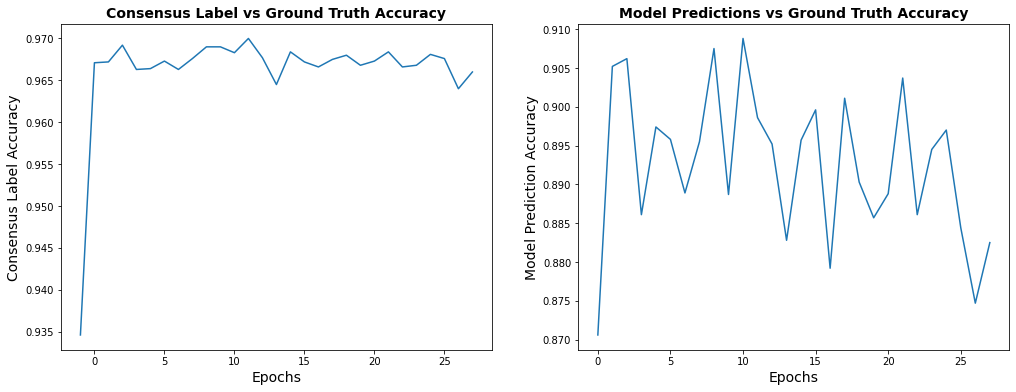

In [21]:
consensus_gtruth_accuracy = [model_results[i]["consensus_gtruth_accuracy"] 
                             for i in range(itter)] + [final_consensus_accuracy]

model_gtruth_accuracy = [model_results[i]["model_gtruth_accuracy"] for i in range(itter)]


# plot prc
plt.rcParams["figure.figsize"] = (17,6)
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(-1, itter),consensus_gtruth_accuracy)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Consensus Label Accuracy", fontsize=14)
plt.title("Consensus Label vs Ground Truth Accuracy", fontsize=14, fontweight="bold")

plt.subplot(1, 2, 2)
plt.plot(range(0, itter), model_gtruth_accuracy)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Model Prediction Accuracy", fontsize=14)
plt.title("Model Predictions vs Ground Truth Accuracy", fontsize=14, fontweight="bold")

plt.show()

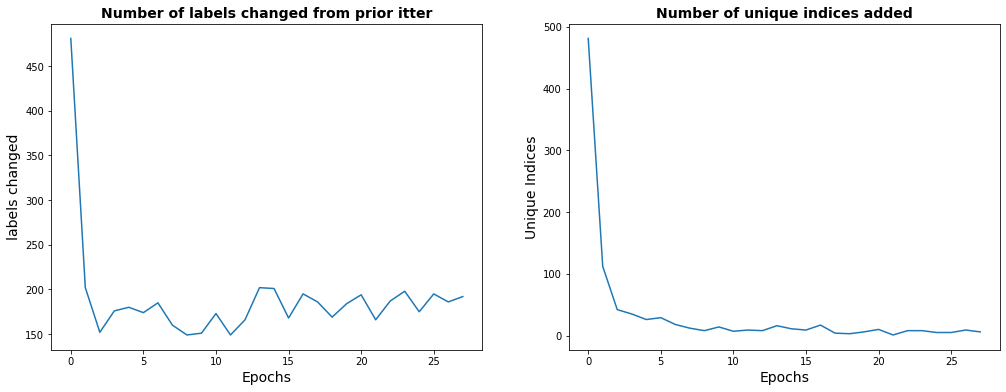

In [24]:
label_changes_from_prior = [model_results[i]["label_changes_from_prior"] for i in range(itter)]
unique_indices_added = [model_results[i]["unique_indices_added"] for i in range(itter)]

# plot prc
plt.rcParams["figure.figsize"] = (17,6)
plt.show()

plt.subplot(1, 2, 1)
plt.plot(range(0, itter),label_changes_from_prior)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("labels changed", fontsize=14)
plt.title("Number of labels changed from prior itter", fontsize=14, fontweight="bold")

plt.subplot(1, 2, 2)
plt.plot(range(0, itter), unique_indices_added)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Unique Indices", fontsize=14)
plt.title("Number of unique indices added", fontsize=14, fontweight="bold")

plt.show()

In [27]:
if consensus_gtruth_accuracy[0] >= consensus_gtruth_accuracy[-1]:  # check cleanlab has improved prediction accuracy
    raise Exception("Cleanlab failed to improve baseline consensus label accuracy.")

#### Cifar10h dataset attribution
Peterson, J.*, Battleday, R.*, Griffiths, T., & Russakovsky, O. (2019).
    Human uncertainty makes classification more robust.
    In Proceedings of the IEEE International Conference on Computer Vision.